# Jonas Hansen | Math 157 - Final Project Code | May 15, 2022

## Shannon Entropy Algorithm

In [1]:
# Importing libraries
import numpy as np
import math
import itertools
import random
import os
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import entropy
from collections import defaultdict, Counter

In [4]:
# Global variables
max_guesses = 10
word_len = 5
all_words_file = os.path.abspath("data/all_possible_guess_words.txt")
wordle_words_file = os.path.abspath("data/wordle_words.txt")

In [ ]:
# Loading list of five-letter words
with open(all_words_file) as file:
    all_dictionary = list(map(lambda x: x.strip(), file.readlines()))

# Loading list of Wordle solution words
with open(wordle_words_file) as file:
    dictionary = list(map(lambda x: x.strip(), file.readlines()))

# Make sure all words are the same length
diff_len_err = "ERROR: Word list contains words with different lengths!"
assert len({len(x) for x in all_dictionary}) == 1, diff_len_err
print("Loading dictionary (contains", len(all_dictionary), "words)")

# Initializing a list of hint patterns to use later
all_patterns = list(itertools.product([0, 1, 2], repeat=word_len))

In [7]:
def entropy(dist, base=None):
    '''
    Description: calculate Shannon entropy of distribution.
    Inputs:
        dist: data distribution.
        base: the log base used to compute the entropy.
    Outputs:
        H: the total entropy across distribution.
    '''
    dist_len = len(dist)

    if dist_len <= 1:
        return 0

    value, counts = np.unique(dist, return_counts=True)
    probs = counts / dist_len
    n_classes = np.count_nonzero(probs)

    if n_classes <= 1:
        return 0

    # Computing the entropy, H
    H = 0.
    base = math.e if base is None else base
    for i in probs:
        H -= i * math.log(i, base)

    return H

In [5]:
def calculate_hints(guess, solution):
    '''
    Description: returns hint pattern by comparing guess word to solution words (0 = gray letter, 1 = yellow
                 letter, 2 = green letter).
    Inputs:
        guess: the guess word.
        solution: the Wordel solution word.
    Output:
        tuple(pattern): tuple of hint pattern.
    '''
    incorrect = [idx for idx, val in enumerate(guess) if val != solution[idx]]
    counts = Counter(solution[i] for i in incorrect)
    pattern = [2] * 5
    for i in incorrect:
        char = guess[i]
        if counts[char] > 0:
            pattern[i] = 1
            counts[char] -= 1
        else:
            pattern[i] = 0
    
    return tuple(pattern)

In [6]:
def calculate_hint_dict(dictionary):
    '''
    Description: returns dictionary of possible words based on hint pattern.
    Inputs:
        dictionary: dictionary of words and their associated hint patterns.
    Outputs:
        dict(hint_dict): filtered dictinary of word choices.
    '''
    hint_dict = defaultdict(lambda: defaultdict(set))
    for word in tqdm(dictionary):
        for next_word in dictionary:
            pattern = calculate_hints(word, next_word)
            hint_dict[word][pattern].add(next_word)
    return dict(hint_dict)

In [9]:
# Generate the hint dictionary for all words (this takes a while)
if "hints_dict.p" in os.listdir("."):
    pattern_dict = pickle.load(open("hints_dict.p", "rb"))
else:
    pattern_dict = calculate_hint_dict(all_dictionary)
    pickle.dump(pattern_dict, open("hints_dict.p", "wb+""))

  0%|          | 1/12953 [00:00<25:39,  8.41it/s]

Loaded dictionary with 12953 words...


100%|██████████| 12953/12953 [24:05<00:00,  8.96it/s]  


In [8]:
def calculate_entropies(words, possible_words, hint_dict):
    '''
    Description: calculating Shannon entropies for guess words based on hint pattern.
    Inputs:
        words: guess words.
        possible_words: all five-letter words fitting pattern.
        hint_dict: filtered dictionary of word choices.
    Outputs:
        entropies: dictionary of words and their entropies.
    '''
    entropies = {}
    for word in words:
        count_list = []
        for pattern in all_patterns:
            hits = hint_dict[word][pattern]
            hits = hits.intersection(possible_words)
            counts.append(len(hits))
        entropies[word] = entropy(count_list)
    return entropies

In [10]:
# Run wordle automatically with all words, using starting word "salet" for each game
num_guess_list = []
salet_entropies = []
def auto_run_wordle():

    for solution_word in tqdm(dictionary):

        guess_word = "salet"
        all_words = set(all_dictionary)
        info = calculate_hints(guess_word, solution_word)
        words = pattern_dict[guess_word][info]
        all_words = all_words.intersection(words)
        
        for n_round in range(1, max_guesses):

            # Print round information
            print("Round", int(n_round), "\n------------------")
            print('Guessing:     ', guess_word)
            print('Info:         ', info)
            if guess_word == solution_word:
                print(f'WIN IN {n_round} GUESSES!\n\n\n')
                num_guess_list.append(int(n_round))
                break
                
            candidates = all_dictionary
            entropies = calculate_entropies(candidates, all_words, pattern_dict)

            if max(entropies.values()) < 0.1:
                candidates = all_words
                entropies = calculate_entropies(candidates, all_words, pattern_dict)

            # Guess the candiate with highest entropy
            top_word_and_entropy = max(entropies.items(), key=lambda x: x[1])
            guess_word = top_word_and_entropy[0]
            info = calculate_hints(guess_word, solution_word)
            
            # Add entropy of opening word for each game (in this case "salet")
            if n_round == 1:
                salet_entropies.append(top_word_and_entropy[1])

            # Filter our list of remaining possible words
            words = pattern_dict[guess_word][info]
            all_words = all_words.intersection(words)

In [11]:
def player_run_wordle():
    # Simulate games
    n_round = 1
    all_words = set(all_dictionary)
    answer_word = random.choice(dictionary)

    while True:
        
        if n_round == 1:
            print("ROUND", int(n_round), "\n-----------------------------------------------------------")
        else:
            print("\nROUND", int(n_round))
            print("Recommended next word:", max_entropy_word[0], "(entropy =", str(max_entropy_word[1]) + ")")
            print("-----------------------------------------------------------")
            
        guess_word = input("Guess a word, any word: ")
        info = calculate_hints(guess_word, answer_word)

        # Print round information
        print('Guessing:     ', guess_word)
        print('Info:         ', info)
        if guess_word == answer_word:
            print("\n\n-----------------------")
            print(" YOU WON IN", n_round, "GUESSES!")
            print("-----------------------")
            break

        # Filter our list of remaining possible words
        words = pattern_dict[guess_word][info]
        all_words = all_words.intersection(words)

        candidates = all_dictionary
        entropies = calculate_entropies(candidates, all_words, pattern_dict)

        if max(entropies.values()) < 0.1:
            candidates = all_words
            entropies = calculate_entropies(candidates, all_words, pattern_dict)

        # Guess the candiate with highest entropy
        max_entropy_word = max(entropies.items(), key=lambda x: x[1])

        n_round += 1

In [84]:
player_run_wordle()

ROUND 1 
-----------------------------------------------------------
Guess a word, any word: reach
Guessing:      reach
Info:          (1, 1, 0, 0, 0)

ROUND 2
Recommended next word: dites (entropy = 1.297199677065102)
-----------------------------------------------------------
Guess a word, any word: dites
Guessing:      dites
Info:          (0, 0, 0, 2, 0)

ROUND 3
Recommended next word: mogul (entropy = 0.5342358013337574)
-----------------------------------------------------------
Guess a word, any word: mogul
Guessing:      mogul
Info:          (0, 0, 0, 0, 0)

ROUND 4
Recommended next word: preif (entropy = 0.15716034512135274)
-----------------------------------------------------------
Guess a word, any word: preif
Guessing:      preif
Info:          (0, 2, 2, 0, 1)

ROUND 5
Recommended next word: freer (entropy = 0.02671193827915705)
-----------------------------------------------------------
Guess a word, any word: freer
Guessing:      freer
Info:          (2, 2, 2, 2, 2)


--

In [12]:
auto_run_wordle()

  0%|          | 0/2309 [00:00<?, ?it/s]

Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      chaya
Info:          (1, 0, 2, 0, 1)


  0%|          | 1/2309 [03:57<152:13:57, 237.45s/it]

Round 4 
------------------
Guessing:      aback
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      reaps
Info:          (0, 1, 2, 0, 1)
Round 3 
------------------
Guessing:      abuse
Info:          (2, 2, 0, 2, 2)


  0%|          | 2/2309 [04:48<116:17:53, 181.48s/it]

Round 4 
------------------
Guessing:      abase
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 1)
Round 2 
------------------
Guessing:      tiara
Info:          (1, 0, 2, 0, 1)


  0%|          | 3/2309 [05:25<88:32:55, 138.24s/it] 

Round 3 
------------------
Guessing:      abate
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 2, 0)
Round 2 
------------------
Guessing:      grind
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      above
Info:          (2, 2, 0, 0, 1)


  0%|          | 4/2309 [06:19<72:16:21, 112.88s/it]

Round 4 
------------------
Guessing:      abbey
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 2)
Round 2 
------------------
Guessing:      braai
Info:          (1, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      adbot
Info:          (2, 0, 2, 2, 2)


  0%|          | 5/2309 [07:15<61:19:01, 95.81s/it] 

Round 4 
------------------
Guessing:      abbot
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 1, 1, 0, 0)
Round 3 
------------------
Guessing:      dorba
Info:          (0, 1, 1, 1, 1)


  0%|          | 6/2309 [08:20<55:20:53, 86.52s/it]

Round 4 
------------------
Guessing:      abhor
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (1, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      bonds
Info:          (1, 0, 0, 2, 0)


  0%|          | 7/2309 [09:24<51:00:24, 79.77s/it]

Round 4 
------------------
Guessing:      abide
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 2, 2, 0)
Round 2 
------------------
Guessing:      dirge
Info:          (1, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      axled
Info:          (2, 0, 2, 2, 2)


  0%|          | 8/2309 [10:19<46:20:30, 72.50s/it]

Round 4 
------------------
Guessing:      abled
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (1, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      bonds
Info:          (1, 1, 0, 2, 0)


  0%|          | 9/2309 [11:17<43:28:08, 68.04s/it]

Round 4 
------------------
Guessing:      abode
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 2)
Round 2 
------------------
Guessing:      braai
Info:          (1, 1, 1, 0, 0)


  0%|          | 10/2309 [11:54<37:32:05, 58.78s/it]

Round 3 
------------------
Guessing:      abort
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 2)
Round 2 
------------------
Guessing:      braai
Info:          (1, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      adbot
Info:          (2, 0, 1, 1, 2)


  0%|          | 11/2309 [12:39<34:57:43, 54.77s/it]

Round 4 
------------------
Guessing:      about
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (0, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      bogan
Info:          (1, 1, 0, 1, 0)


  1%|          | 12/2309 [13:47<37:21:11, 58.54s/it]

Round 4 
------------------
Guessing:      above
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      reaps
Info:          (0, 1, 1, 0, 1)
Round 3 
------------------
Guessing:      admin
Info:          (2, 0, 0, 0, 0)


  1%|          | 13/2309 [14:34<35:06:52, 55.06s/it]

Round 4 
------------------
Guessing:      abuse
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      arias
Info:          (2, 0, 0, 0, 2)
Round 3 
------------------
Guessing:      demon
Info:          (0, 0, 0, 0, 0)
Round 4 
------------------
Guessing:      ascus
Info:          (2, 1, 0, 0, 2)


  1%|          | 14/2309 [15:49<38:52:18, 60.98s/it]

Round 5 
------------------
Guessing:      abyss
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 1, 2, 0, 2)
Round 3 
------------------
Guessing:      adorn
Info:          (2, 0, 2, 2, 2)


  1%|          | 15/2309 [16:39<36:49:10, 57.78s/it]

Round 4 
------------------
Guessing:      acorn
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 1, 0, 2, 0)
Round 3 
------------------
Guessing:      acais
Info:          (2, 2, 0, 2, 0)


  1%|          | 16/2309 [17:40<37:24:52, 58.74s/it]

Round 4 
------------------
Guessing:      acrid
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 1)
Round 2 
------------------
Guessing:      train
Info:          (1, 1, 1, 0, 0)
Round 3 
------------------
Guessing:      coypu
Info:          (1, 1, 0, 0, 0)


  1%|          | 17/2309 [18:35<36:43:12, 57.68s/it]

Round 4 
------------------
Guessing:      actor
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 1)
Round 2 
------------------
Guessing:      tiara
Info:          (1, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      atoke
Info:          (2, 1, 0, 0, 2)


  1%|          | 18/2309 [20:00<41:56:25, 65.90s/it]

Round 4 
------------------
Guessing:      acute
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (1, 0, 2, 0, 1)


  1%|          | 19/2309 [20:42<37:21:30, 58.73s/it]

Round 3 
------------------
Guessing:      adage
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 2)
Round 2 
------------------
Guessing:      braai
Info:          (0, 0, 2, 1, 0)
Round 3 
------------------
Guessing:      amaut
Info:          (2, 0, 2, 0, 2)


  1%|          | 20/2309 [21:29<35:07:33, 55.24s/it]

Round 4 
------------------
Guessing:      adapt
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 2)
Round 2 
------------------
Guessing:      recap
Info:          (0, 1, 0, 1, 1)


  1%|          | 21/2309 [22:03<30:59:54, 48.77s/it]

Round 3 
------------------
Guessing:      adept
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 2, 2)
Round 3 
------------------
Guessing:      amain
Info:          (2, 1, 0, 2, 2)


  1%|          | 22/2309 [23:04<33:18:47, 52.44s/it]

Round 4 
------------------
Guessing:      admin
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 2)
Round 2 
------------------
Guessing:      braai
Info:          (0, 0, 1, 0, 1)
Round 3 
------------------
Guessing:      aight
Info:          (2, 1, 0, 0, 2)


  1%|          | 23/2309 [23:59<33:51:16, 53.31s/it]

Round 4 
------------------
Guessing:      admit
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (1, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      bonds
Info:          (1, 1, 0, 1, 0)


  1%|          | 24/2309 [24:59<35:05:37, 55.29s/it]

Round 4 
------------------
Guessing:      adobe
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 2)
Round 2 
------------------
Guessing:      braai
Info:          (0, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      adown
Info:          (2, 2, 2, 0, 0)


  1%|          | 25/2309 [25:50<34:11:50, 53.90s/it]

Round 4 
------------------
Guessing:      adopt
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (1, 1, 1, 0, 0)
Round 3 
------------------
Guessing:      cedar
Info:          (0, 1, 1, 1, 1)


  1%|          | 26/2309 [26:36<32:44:41, 51.63s/it]

Round 4 
------------------
Guessing:      adore
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 1, 2, 0, 2)


  1%|          | 27/2309 [27:28<32:44:32, 51.65s/it]

Round 3 
------------------
Guessing:      adorn
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 2)
Round 2 
------------------
Guessing:      boric
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      plant
Info:          (0, 1, 1, 0, 2)


  1%|          | 28/2309 [28:10<30:58:35, 48.89s/it]

Round 4 
------------------
Guessing:      adult
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 2, 0)
Round 3 
------------------
Guessing:      addax
Info:          (2, 0, 0, 0, 2)


  1%|▏         | 29/2309 [29:59<42:19:26, 66.83s/it]

Round 4 
------------------
Guessing:      affix
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (0, 1, 1, 0, 0)
Round 3 
------------------
Guessing:      burry
Info:          (0, 0, 0, 2, 0)
Round 4 
------------------
Guessing:      afore
Info:          (2, 2, 0, 2, 2)


  1%|▏         | 30/2309 [31:13<43:36:38, 68.89s/it]

Round 5 
------------------
Guessing:      afire
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 2)
Round 2 
------------------
Guessing:      braai
Info:          (0, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      adown
Info:          (2, 0, 2, 0, 0)


  1%|▏         | 31/2309 [32:01<39:44:48, 62.81s/it]

Round 4 
------------------
Guessing:      afoot
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 2, 0, 0)
Round 3 
------------------
Guessing:      choof
Info:          (0, 0, 2, 0, 1)


  1%|▏         | 32/2309 [32:59<38:41:24, 61.17s/it]

Round 4 
------------------
Guessing:      afoul
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 2, 1)
Round 2 
------------------
Guessing:      apron
Info:          (2, 0, 1, 0, 0)


  1%|▏         | 33/2309 [33:26<32:12:01, 50.93s/it]

Round 3 
------------------
Guessing:      after
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (1, 0, 0, 2, 2)


  1%|▏         | 34/2309 [34:06<30:06:59, 47.66s/it]

Round 3 
------------------
Guessing:      again
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (0, 0, 2, 0, 1)


  2%|▏         | 35/2309 [35:12<33:35:56, 53.19s/it]

Round 3 
------------------
Guessing:      agape
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 1)
Round 2 
------------------
Guessing:      tiara
Info:          (1, 0, 2, 0, 1)
Round 3 
------------------
Guessing:      abate
Info:          (2, 0, 2, 2, 2)


  2%|▏         | 36/2309 [36:07<33:59:28, 53.84s/it]

Round 4 
------------------
Guessing:      agate
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 2)
Round 2 
------------------
Guessing:      recap
Info:          (0, 1, 0, 1, 0)


  2%|▏         | 37/2309 [36:45<30:57:38, 49.06s/it]

Round 3 
------------------
Guessing:      agent
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 1, 0)
Round 2 
------------------
Guessing:      cerne
Info:          (0, 0, 0, 0, 2)
Round 3 
------------------
Guessing:      algid
Info:          (2, 1, 1, 1, 0)


  2%|▏         | 38/2309 [37:36<31:23:22, 49.76s/it]

Round 4 
------------------
Guessing:      agile
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (1, 0, 0, 1, 1)
Round 3 
------------------
Guessing:      chank
Info:          (0, 0, 1, 2, 0)
Round 4 
------------------
Guessing:      awing
Info:          (2, 0, 2, 2, 2)


  2%|▏         | 39/2309 [38:42<34:18:05, 54.40s/it]

Round 5 
------------------
Guessing:      aging
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 2, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (0, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      ology
Info:          (1, 1, 0, 1, 0)


  2%|▏         | 40/2309 [39:30<33:12:04, 52.68s/it]

Round 4 
------------------
Guessing:      aglow
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (1, 0, 2, 0, 1)
Round 3 
------------------
Guessing:      among
Info:          (2, 0, 2, 2, 1)


  2%|▏         | 41/2309 [40:20<32:33:07, 51.67s/it]

Round 4 
------------------
Guessing:      agony
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 2, 0)
Round 2 
------------------
Guessing:      grind
Info:          (1, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      agger
Info:          (2, 2, 0, 2, 1)


  2%|▏         | 42/2309 [41:04<31:14:00, 49.60s/it]

Round 4 
------------------
Guessing:      agree
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (1, 0, 1, 0, 1)


  2%|▏         | 43/2309 [41:42<28:54:43, 45.93s/it]

Round 3 
------------------
Guessing:      ahead
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 2, 0)
Round 2 
------------------
Guessing:      grind
Info:          (0, 1, 1, 0, 1)


  2%|▏         | 44/2309 [42:15<26:29:55, 42.12s/it]

Round 3 
------------------
Guessing:      aider
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 1, 1, 1, 0)
Round 2 
------------------
Guessing:      feals
Info:          (0, 1, 1, 2, 1)


  2%|▏         | 45/2309 [42:45<24:08:45, 38.39s/it]

Round 3 
------------------
Guessing:      aisle
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      array
Info:          (2, 1, 0, 1, 0)


  2%|▏         | 46/2309 [43:40<27:21:21, 43.52s/it]

Round 4 
------------------
Guessing:      alarm
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      playa
Info:          (0, 2, 1, 0, 0)


  2%|▏         | 47/2309 [44:40<30:21:53, 48.33s/it]

Round 4 
------------------
Guessing:      album
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 1, 2)
Round 2 
------------------
Guessing:      recap
Info:          (1, 1, 0, 1, 0)


  2%|▏         | 48/2309 [45:06<26:16:04, 41.82s/it]

Round 3 
------------------
Guessing:      alert
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 1, 0)
Round 2 
------------------
Guessing:      cerne
Info:          (0, 0, 0, 0, 2)
Round 3 
------------------
Guessing:      algid
Info:          (2, 2, 2, 0, 0)


  2%|▏         | 49/2309 [45:56<27:46:50, 44.25s/it]

Round 4 
------------------
Guessing:      algae
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      pibal
Info:          (0, 1, 1, 1, 1)


  2%|▏         | 50/2309 [46:47<29:01:49, 46.26s/it]

Round 4 
------------------
Guessing:      alibi
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 2, 0)
Round 2 
------------------
Guessing:      aland
Info:          (2, 2, 0, 1, 0)


  2%|▏         | 51/2309 [47:13<25:12:39, 40.19s/it]

Round 3 
------------------
Guessing:      alien
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (1, 0, 0, 1, 2)
Round 3 
------------------
Guessing:      ligan
Info:          (1, 1, 1, 1, 2)


  2%|▏         | 52/2309 [47:54<25:20:30, 40.42s/it]

Round 4 
------------------
Guessing:      align
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 1, 0)
Round 2 
------------------
Guessing:      cerne
Info:          (0, 0, 0, 0, 2)
Round 3 
------------------
Guessing:      algid
Info:          (2, 2, 0, 1, 0)
Round 4 
------------------
Guessing:      alive
Info:          (2, 2, 2, 0, 2)


  2%|▏         | 53/2309 [49:03<30:38:06, 48.89s/it]

Round 5 
------------------
Guessing:      alike
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 1, 0)
Round 2 
------------------
Guessing:      cerne
Info:          (0, 0, 0, 0, 2)
Round 3 
------------------
Guessing:      algid
Info:          (2, 2, 0, 1, 0)


  2%|▏         | 54/2309 [49:56<31:26:32, 50.20s/it]

Round 4 
------------------
Guessing:      alive
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 2, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      gamay
Info:          (0, 1, 0, 2, 2)


  2%|▏         | 55/2309 [50:47<31:34:56, 50.44s/it]

Round 4 
------------------
Guessing:      allay
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 2, 2, 0)
Round 2 
------------------
Guessing:      dirge
Info:          (0, 0, 0, 0, 1)


  2%|▏         | 56/2309 [51:25<29:17:40, 46.81s/it]

Round 3 
------------------
Guessing:      alley
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 2, 0, 2)


  2%|▏         | 57/2309 [51:36<22:25:04, 35.84s/it]

Round 2 
------------------
Guessing:      allot
Info:          (2, 2, 2, 2, 2)
WIN IN 2 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 2, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (0, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      ology
Info:          (1, 2, 0, 0, 0)
Round 4 
------------------
Guessing:      allod
Info:          (2, 2, 2, 2, 0)


  3%|▎         | 58/2309 [52:43<28:21:38, 45.36s/it]

Round 5 
------------------
Guessing:      allow
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 2, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (0, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      ology
Info:          (1, 2, 0, 0, 2)


  3%|▎         | 59/2309 [53:31<28:41:35, 45.91s/it]

Round 4 
------------------
Guessing:      alloy
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 2)
Round 2 
------------------
Guessing:      boric
Info:          (0, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      ploat
Info:          (0, 2, 2, 1, 2)


  3%|▎         | 60/2309 [54:10<27:29:30, 44.01s/it]

Round 4 
------------------
Guessing:      aloft
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 1, 0)
Round 2 
------------------
Guessing:      cerne
Info:          (0, 0, 0, 2, 2)
Round 3 
------------------
Guessing:      apaid
Info:          (2, 0, 0, 0, 0)


  3%|▎         | 61/2309 [55:06<29:38:28, 47.47s/it]

Round 4 
------------------
Guessing:      alone
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (1, 0, 2, 0, 1)


  3%|▎         | 62/2309 [55:45<28:01:33, 44.90s/it]

Round 3 
------------------
Guessing:      along
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 2, 0, 0)
Round 3 
------------------
Guessing:      choof
Info:          (0, 0, 2, 2, 2)


  3%|▎         | 63/2309 [56:38<29:38:26, 47.51s/it]

Round 4 
------------------
Guessing:      aloof
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 2, 0, 0)
Round 3 
------------------
Guessing:      choof
Info:          (0, 0, 2, 0, 0)


  3%|▎         | 64/2309 [57:32<30:47:52, 49.39s/it]

Round 4 
------------------
Guessing:      aloud
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      playa
Info:          (1, 2, 1, 0, 2)


  3%|▎         | 65/2309 [58:31<32:33:55, 52.24s/it]

Round 4 
------------------
Guessing:      alpha
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 1)
Round 2 
------------------
Guessing:      rotal
Info:          (1, 0, 2, 2, 1)


  3%|▎         | 66/2309 [59:04<29:00:48, 46.57s/it]

Round 3 
------------------
Guessing:      altar
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 2, 1)


  3%|▎         | 67/2309 [59:15<22:21:31, 35.90s/it]

Round 2 
------------------
Guessing:      alter
Info:          (2, 2, 2, 2, 2)
WIN IN 2 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      arias
Info:          (2, 0, 0, 1, 2)
Round 3 
------------------
Guessing:      chynd
Info:          (0, 0, 0, 0, 0)


  3%|▎         | 68/2309 [1:00:07<25:23:46, 40.80s/it]

Round 4 
------------------
Guessing:      amass
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (0, 0, 2, 1, 1)


  3%|▎         | 69/2309 [1:00:44<24:32:15, 39.44s/it]

Round 3 
------------------
Guessing:      amaze
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 2, 0)
Round 2 
------------------
Guessing:      grind
Info:          (0, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      abaca
Info:          (2, 1, 0, 0, 0)


  3%|▎         | 70/2309 [1:01:30<25:50:38, 41.55s/it]

Round 4 
------------------
Guessing:      amber
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 1, 0)
Round 2 
------------------
Guessing:      cerne
Info:          (0, 0, 0, 0, 2)
Round 3 
------------------
Guessing:      algid
Info:          (2, 1, 0, 0, 0)
Round 4 
------------------
Guessing:      abamp
Info:          (2, 1, 0, 1, 0)


  3%|▎         | 71/2309 [1:02:37<30:37:09, 49.25s/it]

Round 5 
------------------
Guessing:      amble
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (1, 0, 1, 1, 0)
Round 3 
------------------
Guessing:      bemad
Info:          (0, 1, 1, 1, 2)


  3%|▎         | 72/2309 [1:03:27<30:45:13, 49.49s/it]

Round 4 
------------------
Guessing:      amend
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      arias
Info:          (2, 0, 2, 0, 2)
Round 3 
------------------
Guessing:      adman
Info:          (2, 0, 1, 0, 0)


  3%|▎         | 73/2309 [1:04:23<31:50:23, 51.26s/it]

Round 4 
------------------
Guessing:      amiss
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 1)
Round 2 
------------------
Guessing:      train
Info:          (1, 0, 1, 1, 0)
Round 3 
------------------
Guessing:      amigo
Info:          (2, 2, 2, 0, 0)


  3%|▎         | 74/2309 [1:05:14<31:46:46, 51.19s/it]

Round 4 
------------------
Guessing:      amity
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (1, 0, 2, 0, 1)


  3%|▎         | 75/2309 [1:05:53<29:32:13, 47.60s/it]

Round 3 
------------------
Guessing:      among
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 1, 0)
Round 2 
------------------
Guessing:      cerne
Info:          (0, 0, 0, 0, 2)
Round 3 
------------------
Guessing:      algid
Info:          (2, 1, 0, 0, 0)
Round 4 
------------------
Guessing:      abamp
Info:          (2, 0, 0, 1, 1)


  3%|▎         | 76/2309 [1:07:02<33:25:37, 53.89s/it]

Round 5 
------------------
Guessing:      ample
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      playa
Info:          (1, 1, 1, 1, 0)
Round 4 
------------------
Guessing:      apply
Info:          (2, 0, 2, 2, 2)


  3%|▎         | 77/2309 [1:08:04<35:04:04, 56.56s/it]

Round 5 
------------------
Guessing:      amply
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      reaps
Info:          (0, 1, 1, 0, 1)
Round 3 
------------------
Guessing:      admin
Info:          (2, 0, 1, 0, 0)


  3%|▎         | 78/2309 [1:08:55<34:01:52, 54.91s/it]

Round 4 
------------------
Guessing:      amuse
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 2, 0)
Round 2 
------------------
Guessing:      aland
Info:          (2, 1, 0, 1, 0)


  3%|▎         | 79/2309 [1:09:22<28:41:32, 46.32s/it]

Round 3 
------------------
Guessing:      angel
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 2, 0)
Round 2 
------------------
Guessing:      grind
Info:          (1, 1, 0, 1, 0)


  3%|▎         | 80/2309 [1:09:55<26:20:04, 42.53s/it]

Round 3 
------------------
Guessing:      anger
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 1, 0)
Round 2 
------------------
Guessing:      cerne
Info:          (0, 0, 0, 1, 2)
Round 3 
------------------
Guessing:      agios
Info:          (2, 1, 0, 0, 0)


  4%|▎         | 81/2309 [1:10:46<27:47:51, 44.92s/it]

Round 4 
------------------
Guessing:      angle
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (1, 1, 0, 0, 1)


  4%|▎         | 82/2309 [1:11:26<26:50:02, 43.38s/it]

Round 3 
------------------
Guessing:      angry
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 1, 0, 0, 2)
Round 2 
------------------
Guessing:      coarb
Info:          (0, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      agist
Info:          (2, 1, 0, 2, 2)


  4%|▎         | 83/2309 [1:12:07<26:22:34, 42.66s/it]

Round 4 
------------------
Guessing:      angst
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (0, 0, 1, 2, 0)
Round 3 
------------------
Guessing:      azyme
Info:          (2, 0, 0, 2, 2)


  4%|▎         | 84/2309 [1:12:58<27:55:56, 45.19s/it]

Round 4 
------------------
Guessing:      anime
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 1, 0)
Round 2 
------------------
Guessing:      cerne
Info:          (0, 0, 0, 1, 2)
Round 3 
------------------
Guessing:      agios
Info:          (2, 0, 0, 0, 0)


  4%|▎         | 85/2309 [1:13:48<28:55:20, 46.82s/it]

Round 4 
------------------
Guessing:      ankle
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 2, 0)
Round 2 
------------------
Guessing:      grind
Info:          (0, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      axmen
Info:          (2, 1, 0, 2, 1)


  4%|▎         | 86/2309 [1:14:33<28:27:36, 46.09s/it]

Round 4 
------------------
Guessing:      annex
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 1, 0, 1)
Round 3 
------------------
Guessing:      donah
Info:          (0, 1, 2, 1, 0)


  4%|▍         | 87/2309 [1:15:29<30:15:11, 49.01s/it]

Round 4 
------------------
Guessing:      annoy
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      aback
Info:          (2, 0, 0, 0, 0)


  4%|▍         | 88/2309 [1:16:17<30:06:30, 48.80s/it]

Round 4 
------------------
Guessing:      annul
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (1, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      bonds
Info:          (0, 1, 1, 2, 0)


  4%|▍         | 89/2309 [1:17:07<30:19:06, 49.17s/it]

Round 4 
------------------
Guessing:      anode
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 1)
Round 2 
------------------
Guessing:      train
Info:          (1, 0, 1, 2, 1)


  4%|▍         | 90/2309 [1:17:40<27:17:21, 44.27s/it]

Round 3 
------------------
Guessing:      antic
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 2, 1)


  4%|▍         | 91/2309 [1:18:18<26:10:52, 42.49s/it]

Round 3 
------------------
Guessing:      anvil
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 1)
Round 2 
------------------
Guessing:      train
Info:          (1, 1, 1, 0, 0)
Round 3 
------------------
Guessing:      coypu
Info:          (0, 2, 0, 0, 0)


  4%|▍         | 92/2309 [1:19:08<27:36:36, 44.83s/it]

Round 4 
------------------
Guessing:      aorta
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 2)
Round 2 
------------------
Guessing:      braai
Info:          (0, 1, 2, 1, 0)


  4%|▍         | 93/2309 [1:19:44<25:48:26, 41.93s/it]

Round 3 
------------------
Guessing:      apart
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 2, 0)
Round 3 
------------------
Guessing:      addax
Info:          (2, 1, 0, 0, 0)


  4%|▍         | 94/2309 [1:20:40<28:24:55, 46.18s/it]

Round 4 
------------------
Guessing:      aphid
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (1, 0, 0, 1, 1)
Round 3 
------------------
Guessing:      chank
Info:          (0, 0, 1, 2, 0)
Round 4 
------------------
Guessing:      awing
Info:          (2, 0, 2, 2, 2)
Round 5 
------------------
Guessing:      aging
Info:          (2, 0, 2, 2, 2)


  4%|▍         | 95/2309 [1:21:58<34:22:12, 55.89s/it]

Round 6 
------------------
Guessing:      aping
Info:          (2, 2, 2, 2, 2)
WIN IN 6 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 2, 0)
Round 2 
------------------
Guessing:      grind
Info:          (0, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      axmen
Info:          (2, 0, 0, 2, 1)


  4%|▍         | 96/2309 [1:22:43<32:15:19, 52.47s/it]

Round 4 
------------------
Guessing:      apnea
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 1, 0)
Round 2 
------------------
Guessing:      cerne
Info:          (0, 0, 0, 0, 2)
Round 3 
------------------
Guessing:      algid
Info:          (2, 1, 0, 0, 0)
Round 4 
------------------
Guessing:      abamp
Info:          (2, 0, 0, 0, 1)


  4%|▍         | 97/2309 [1:23:57<36:11:31, 58.90s/it]

Round 5 
------------------
Guessing:      apple
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      playa
Info:          (1, 1, 1, 1, 0)


  4%|▍         | 98/2309 [1:24:52<35:35:45, 57.96s/it]

Round 4 
------------------
Guessing:      apply
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 1, 1, 0, 2)
Round 3 
------------------
Guessing:      rowan
Info:          (1, 1, 0, 1, 2)


  4%|▍         | 99/2309 [1:25:40<33:37:40, 54.78s/it]

Round 4 
------------------
Guessing:      apron
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 1)
Round 2 
------------------
Guessing:      rotal
Info:          (0, 0, 2, 1, 1)


  4%|▍         | 100/2309 [1:26:13<29:39:45, 48.34s/it]

Round 3 
------------------
Guessing:      aptly
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 2, 1, 0, 0)
Round 3 
------------------
Guessing:      demob
Info:          (0, 0, 0, 2, 1)


  4%|▍         | 101/2309 [1:27:02<29:50:43, 48.66s/it]

Round 4 
------------------
Guessing:      arbor
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 2, 1, 0, 0)
Round 3 
------------------
Guessing:      demob
Info:          (1, 0, 0, 2, 0)


  4%|▍         | 102/2309 [1:27:59<31:14:07, 50.95s/it]

Round 4 
------------------
Guessing:      ardor
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (0, 2, 1, 0, 2)
Round 3 
------------------
Guessing:      areca
Info:          (2, 2, 2, 0, 2)


  4%|▍         | 103/2309 [1:28:51<31:33:10, 51.49s/it]

Round 4 
------------------
Guessing:      arena
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (0, 2, 1, 0, 0)
Round 3 
------------------
Guessing:      abune
Info:          (2, 0, 1, 0, 2)


  5%|▍         | 104/2309 [1:29:45<31:53:20, 52.06s/it]

Round 4 
------------------
Guessing:      argue
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      reaps
Info:          (1, 1, 1, 0, 1)
Round 3 
------------------
Guessing:      acock
Info:          (2, 0, 0, 0, 0)


  5%|▍         | 105/2309 [1:30:30<30:36:15, 49.99s/it]

Round 4 
------------------
Guessing:      arise
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 2, 1, 0, 0)
Round 3 
------------------
Guessing:      demob
Info:          (0, 0, 2, 2, 0)


  5%|▍         | 106/2309 [1:31:23<31:05:14, 50.80s/it]

Round 4 
------------------
Guessing:      armor
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 2, 2, 0, 0)
Round 3 
------------------
Guessing:      abamp
Info:          (2, 0, 1, 2, 0)


  5%|▍         | 107/2309 [1:32:16<31:29:16, 51.48s/it]

Round 4 
------------------
Guessing:      aroma
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      reaps
Info:          (1, 1, 1, 0, 1)
Round 3 
------------------
Guessing:      acock
Info:          (2, 0, 2, 0, 0)


  5%|▍         | 108/2309 [1:33:04<30:53:55, 50.54s/it]

Round 4 
------------------
Guessing:      arose
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      apayd
Info:          (2, 0, 1, 1, 0)


  5%|▍         | 109/2309 [1:33:59<31:44:57, 51.95s/it]

Round 4 
------------------
Guessing:      array
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 2, 1, 0, 0)
Round 3 
------------------
Guessing:      demob
Info:          (0, 0, 0, 2, 0)
Round 4 
------------------
Guessing:      arroz
Info:          (2, 2, 2, 2, 0)


  5%|▍         | 110/2309 [1:34:56<32:34:24, 53.33s/it]

Round 5 
------------------
Guessing:      arrow
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      arias
Info:          (2, 2, 0, 0, 1)


  5%|▍         | 111/2309 [1:35:32<29:23:19, 48.13s/it]

Round 3 
------------------
Guessing:      arson
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 1, 0, 0, 1)
Round 2 
------------------
Guessing:      train
Info:          (1, 2, 1, 0, 0)


  5%|▍         | 112/2309 [1:36:04<26:24:42, 43.28s/it]

Round 3 
------------------
Guessing:      artsy
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 1, 0, 0, 2)
Round 2 
------------------
Guessing:      coarb
Info:          (1, 1, 1, 0, 0)


  5%|▍         | 113/2309 [1:36:31<23:29:54, 38.52s/it]

Round 3 
------------------
Guessing:      ascot
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 1, 0, 2, 0)
Round 2 
------------------
Guessing:      rusks
Info:          (0, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      ashed
Info:          (2, 2, 2, 2, 0)


  5%|▍         | 114/2309 [1:37:21<25:29:28, 41.81s/it]

Round 4 
------------------
Guessing:      ashen
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      reaps
Info:          (0, 1, 1, 0, 1)
Round 3 
------------------
Guessing:      admin
Info:          (2, 1, 0, 1, 0)


  5%|▍         | 115/2309 [1:38:12<27:16:47, 44.76s/it]

Round 4 
------------------
Guessing:      aside
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 1, 0, 2, 0)
Round 2 
------------------
Guessing:      rusks
Info:          (0, 0, 1, 1, 0)
Round 3 
------------------
Guessing:      asked
Info:          (2, 2, 2, 2, 0)


  5%|▌         | 116/2309 [1:38:58<27:21:47, 44.92s/it]

Round 4 
------------------
Guessing:      askew
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      arias
Info:          (2, 0, 0, 2, 1)
Round 3 
------------------
Guessing:      asway
Info:          (2, 2, 0, 2, 2)


  5%|▌         | 117/2309 [1:39:50<28:44:19, 47.20s/it]

Round 4 
------------------
Guessing:      assay
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 1, 0, 2, 2)
Round 2 
------------------
Guessing:      ashet
Info:          (2, 2, 0, 2, 2)


  5%|▌         | 118/2309 [1:40:10<23:42:54, 38.97s/it]

Round 3 
------------------
Guessing:      asset
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 1)
Round 2 
------------------
Guessing:      rotal
Info:          (0, 1, 1, 1, 2)


  5%|▌         | 119/2309 [1:40:43<22:37:50, 37.20s/it]

Round 3 
------------------
Guessing:      atoll
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 1)
Round 2 
------------------
Guessing:      tiara
Info:          (1, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      atoke
Info:          (2, 2, 2, 0, 2)


  5%|▌         | 120/2309 [1:41:32<24:41:32, 40.61s/it]

Round 4 
------------------
Guessing:      atone
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 1)
Round 2 
------------------
Guessing:      train
Info:          (1, 0, 1, 2, 0)


  5%|▌         | 121/2309 [1:42:09<24:04:28, 39.61s/it]

Round 3 
------------------
Guessing:      attic
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 1, 2, 0)
Round 3 
------------------
Guessing:      adapt
Info:          (2, 1, 0, 0, 0)


  5%|▌         | 122/2309 [1:43:00<26:06:32, 42.98s/it]

Round 4 
------------------
Guessing:      audio
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 2)
Round 2 
------------------
Guessing:      braai
Info:          (0, 0, 1, 0, 1)
Round 3 
------------------
Guessing:      aight
Info:          (2, 1, 0, 0, 2)
Round 4 
------------------
Guessing:      admit
Info:          (2, 1, 0, 2, 2)


  5%|▌         | 123/2309 [1:44:00<29:18:11, 48.26s/it]

Round 5 
------------------
Guessing:      audit
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (1, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      apgar
Info:          (2, 0, 2, 0, 2)


  5%|▌         | 124/2309 [1:44:53<30:03:15, 49.52s/it]

Round 4 
------------------
Guessing:      augur
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 1)
Round 2 
------------------
Guessing:      train
Info:          (1, 0, 1, 0, 1)
Round 3 
------------------
Guessing:      junta
Info:          (0, 2, 2, 2, 1)


  5%|▌         | 125/2309 [1:45:44<30:22:53, 50.08s/it]

Round 4 
------------------
Guessing:      aunty
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 2, 0)
Round 3 
------------------
Guessing:      adsum
Info:          (2, 0, 0, 0, 0)


  5%|▌         | 126/2309 [1:46:36<30:39:26, 50.56s/it]

Round 4 
------------------
Guessing:      avail
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 2)
Round 2 
------------------
Guessing:      recap
Info:          (1, 1, 0, 1, 0)


  6%|▌         | 127/2309 [1:47:11<27:47:13, 45.84s/it]

Round 3 
------------------
Guessing:      avert
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 1, 2)
Round 3 
------------------
Guessing:      divan
Info:          (0, 1, 1, 2, 2)


  6%|▌         | 128/2309 [1:47:57<27:53:19, 46.03s/it]

Round 4 
------------------
Guessing:      avian
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 2, 2, 0)
Round 3 
------------------
Guessing:      axoid
Info:          (2, 0, 2, 2, 2)


  6%|▌         | 129/2309 [1:48:53<29:40:12, 49.00s/it]

Round 4 
------------------
Guessing:      avoid
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 2)
Round 2 
------------------
Guessing:      braai
Info:          (0, 0, 2, 1, 1)


  6%|▌         | 130/2309 [1:49:31<27:34:56, 45.57s/it]

Round 3 
------------------
Guessing:      await
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (0, 0, 2, 0, 1)
Round 3 
------------------
Guessing:      agape
Info:          (2, 0, 2, 0, 2)
Round 4 
------------------
Guessing:      awave
Info:          (2, 2, 2, 0, 2)


  6%|▌         | 131/2309 [1:50:25<29:12:48, 48.29s/it]

Round 5 
------------------
Guessing:      awake
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      murry
Info:          (0, 0, 0, 2, 0)
Round 4 
------------------
Guessing:      adaws
Info:          (2, 1, 2, 1, 0)


  6%|▌         | 132/2309 [1:51:41<34:05:14, 56.37s/it]

Round 5 
------------------
Guessing:      award
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (0, 1, 2, 0, 1)


  6%|▌         | 133/2309 [1:52:16<30:12:37, 49.98s/it]

Round 3 
------------------
Guessing:      aware
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      arias
Info:          (2, 0, 0, 1, 1)


  6%|▌         | 134/2309 [1:52:57<28:33:47, 47.28s/it]

Round 3 
------------------
Guessing:      awash
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      playa
Info:          (0, 1, 1, 0, 0)
Round 4 
------------------
Guessing:      bubal
Info:          (0, 1, 0, 1, 2)
Round 5 
------------------
Guessing:      ahull
Info:          (2, 0, 1, 0, 2)


  6%|▌         | 135/2309 [1:54:04<32:17:24, 53.47s/it]

Round 6 
------------------
Guessing:      awful
Info:          (2, 2, 2, 2, 2)
WIN IN 6 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (0, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      bogan
Info:          (0, 1, 0, 1, 0)


  6%|▌         | 136/2309 [1:54:59<32:26:14, 53.74s/it]

Round 4 
------------------
Guessing:      awoke
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      pibal
Info:          (0, 1, 0, 2, 2)


  6%|▌         | 137/2309 [1:55:51<32:13:05, 53.40s/it]

Round 4 
------------------
Guessing:      axial
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 1, 1, 0)
Round 3 
------------------
Guessing:      alamo
Info:          (2, 0, 0, 1, 1)


  6%|▌         | 138/2309 [1:56:44<32:00:57, 53.09s/it]

Round 4 
------------------
Guessing:      axiom
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 1, 1, 2)
Round 3 
------------------
Guessing:      anion
Info:          (2, 0, 2, 2, 2)
Round 4 
------------------
Guessing:      avion
Info:          (2, 0, 2, 2, 2)


  6%|▌         | 139/2309 [1:57:43<33:02:24, 54.81s/it]

Round 5 
------------------
Guessing:      axion
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (0, 1, 1, 0, 0)
Round 3 
------------------
Guessing:      burry
Info:          (0, 1, 0, 2, 0)


  6%|▌         | 140/2309 [1:58:41<33:36:52, 55.79s/it]

Round 4 
------------------
Guessing:      azure
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (0, 1, 0, 0, 2)
Round 3 
------------------
Guessing:      amnic
Info:          (1, 0, 1, 0, 1)
Round 4 
------------------
Guessing:      caxon
Info:          (1, 2, 0, 2, 2)


  6%|▌         | 141/2309 [1:59:44<34:57:32, 58.05s/it]

Round 5 
------------------
Guessing:      bacon
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 1, 0)
Round 2 
------------------
Guessing:      grind
Info:          (1, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      madge
Info:          (0, 2, 2, 2, 2)
Round 4 
------------------
Guessing:      fadge
Info:          (0, 2, 2, 2, 2)
Round 5 
------------------
Guessing:      wadge
Info:          (0, 2, 2, 2, 2)
Round 6 
------------------
Guessing:      cadge
Info:          (0, 2, 2, 2, 2)


  6%|▌         | 142/2309 [2:01:01<38:16:38, 63.59s/it]

Round 7 
------------------
Guessing:      badge
Info:          (2, 2, 2, 2, 2)
WIN IN 7 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 1, 0, 0)
Round 2 
------------------
Guessing:      lindy
Info:          (1, 0, 0, 1, 2)


  6%|▌         | 143/2309 [2:01:43<34:28:38, 57.30s/it]

Round 3 
------------------
Guessing:      badly
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 1, 2, 0)
Round 2 
------------------
Guessing:      cyder
Info:          (0, 0, 0, 2, 0)
Round 3 
------------------
Guessing:      bhang
Info:          (2, 0, 1, 0, 1)


  6%|▌         | 144/2309 [2:02:31<32:43:24, 54.41s/it]

Round 4 
------------------
Guessing:      bagel
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      mucky
Info:          (0, 0, 0, 0, 2)
Round 4 
------------------
Guessing:      badge
Info:          (2, 2, 0, 2, 0)


  6%|▋         | 145/2309 [2:03:54<37:47:57, 62.88s/it]

Round 5 
------------------
Guessing:      baggy
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 2, 0)
Round 2 
------------------
Guessing:      wordy
Info:          (0, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      repeg
Info:          (1, 0, 0, 2, 0)
Round 4 
------------------
Guessing:      chimb
Info:          (0, 0, 0, 0, 1)


  6%|▋         | 146/2309 [2:05:04<39:13:21, 65.28s/it]

Round 5 
------------------
Guessing:      baker
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 2, 2, 0)
Round 2 
------------------
Guessing:      dawah
Info:          (0, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      paler
Info:          (0, 2, 2, 2, 2)


  6%|▋         | 147/2309 [2:05:40<33:56:35, 56.52s/it]

Round 4 
------------------
Guessing:      baler
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 2, 0, 0)
Round 2 
------------------
Guessing:      chimp
Info:          (0, 0, 0, 2, 0)
Round 3 
------------------
Guessing:      malmy
Info:          (0, 2, 2, 2, 2)


  6%|▋         | 148/2309 [2:06:27<32:11:17, 53.62s/it]

Round 4 
------------------
Guessing:      balmy
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 1, 0, 0)
Round 2 
------------------
Guessing:      lindy
Info:          (1, 0, 2, 0, 0)
Round 3 
------------------
Guessing:      fanal
Info:          (0, 2, 2, 2, 2)


  6%|▋         | 149/2309 [2:07:21<32:13:21, 53.70s/it]

Round 4 
------------------
Guessing:      banal
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (0, 1, 0, 0, 1)
Round 3 
------------------
Guessing:      combo
Info:          (0, 0, 0, 1, 2)


  6%|▋         | 150/2309 [2:08:16<32:23:23, 54.01s/it]

Round 4 
------------------
Guessing:      banjo
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 1, 0)
Round 2 
------------------
Guessing:      grind
Info:          (1, 1, 0, 0, 0)


  7%|▋         | 151/2309 [2:08:54<29:32:57, 49.29s/it]

Round 3 
------------------
Guessing:      barge
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (0, 1, 2, 0, 2)
Round 3 
------------------
Guessing:      maron
Info:          (0, 2, 2, 2, 2)
Round 4 
------------------
Guessing:      caron
Info:          (0, 2, 2, 2, 2)


  7%|▋         | 152/2309 [2:09:44<29:41:12, 49.55s/it]

Round 5 
------------------
Guessing:      baron
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 2, 1, 0, 0)
Round 2 
------------------
Guessing:      lirks
Info:          (1, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      nasal
Info:          (0, 2, 2, 2, 2)


  7%|▋         | 153/2309 [2:10:34<29:41:52, 49.59s/it]

Round 4 
------------------
Guessing:      basal
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      drink
Info:          (0, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      combi
Info:          (1, 0, 0, 1, 1)


  7%|▋         | 154/2309 [2:11:32<31:12:51, 52.14s/it]

Round 4 
------------------
Guessing:      basic
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 2, 1, 0, 0)
Round 2 
------------------
Guessing:      lirks
Info:          (1, 1, 0, 0, 1)


  7%|▋         | 155/2309 [2:12:03<27:23:22, 45.78s/it]

Round 3 
------------------
Guessing:      basil
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      drink
Info:          (0, 0, 1, 1, 0)
Round 3 
------------------
Guessing:      ambit
Info:          (1, 0, 1, 2, 0)


  7%|▋         | 156/2309 [2:12:49<27:27:11, 45.90s/it]

Round 4 
------------------
Guessing:      basin
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      drink
Info:          (0, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      combi
Info:          (0, 0, 0, 1, 1)


  7%|▋         | 157/2309 [2:13:44<29:06:13, 48.69s/it]

Round 4 
------------------
Guessing:      basis
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 2, 0, 1, 1)
Round 2 
------------------
Guessing:      thaws
Info:          (1, 0, 1, 0, 1)
Round 3 
------------------
Guessing:      paste
Info:          (0, 2, 2, 2, 2)
Round 4 
------------------
Guessing:      caste
Info:          (0, 2, 2, 2, 2)


  7%|▋         | 158/2309 [2:14:27<28:02:40, 46.94s/it]

Round 5 
------------------
Guessing:      baste
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 1)
Round 2 
------------------
Guessing:      torta
Info:          (1, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      campi
Info:          (1, 2, 0, 0, 0)
Round 4 
------------------
Guessing:      watch
Info:          (0, 2, 2, 2, 2)
Round 5 
------------------
Guessing:      gatch
Info:          (0, 2, 2, 2, 2)


  7%|▋         | 159/2309 [2:15:58<35:56:10, 60.17s/it]

Round 6 
------------------
Guessing:      batch
Info:          (2, 2, 2, 2, 2)
WIN IN 6 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 1, 1)
Round 2 
------------------
Guessing:      truth
Info:          (1, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      eathe
Info:          (0, 2, 2, 2, 2)


  7%|▋         | 160/2309 [2:16:44<33:21:13, 55.87s/it]

Round 4 
------------------
Guessing:      bathe
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 1)
Round 2 
------------------
Guessing:      torta
Info:          (1, 1, 0, 0, 1)
Round 3 
------------------
Guessing:      patio
Info:          (0, 2, 2, 0, 1)


  7%|▋         | 161/2309 [2:17:30<31:33:24, 52.89s/it]

Round 4 
------------------
Guessing:      baton
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 1)
Round 2 
------------------
Guessing:      torta
Info:          (1, 0, 0, 2, 1)
Round 3 
------------------
Guessing:      pubic
Info:          (0, 0, 1, 0, 0)


  7%|▋         | 162/2309 [2:18:21<31:12:26, 52.33s/it]

Round 4 
------------------
Guessing:      batty
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      mucky
Info:          (0, 0, 0, 0, 2)
Round 4 
------------------
Guessing:      badge
Info:          (2, 2, 1, 0, 0)


  7%|▋         | 163/2309 [2:19:42<36:21:50, 61.00s/it]

Round 5 
------------------
Guessing:      bawdy
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (0, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      chook
Info:          (0, 0, 0, 2, 0)


  7%|▋         | 164/2309 [2:20:41<35:54:42, 60.27s/it]

Round 4 
------------------
Guessing:      bayou
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (0, 0, 2, 0, 0)
Round 3 
------------------
Guessing:      pecke
Info:          (0, 2, 1, 0, 0)


  7%|▋         | 165/2309 [2:21:39<35:27:58, 59.55s/it]

Round 4 
------------------
Guessing:      beach
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (1, 0, 2, 0, 0)


  7%|▋         | 166/2309 [2:22:15<31:20:57, 52.66s/it]

Round 3 
------------------
Guessing:      beady
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (1, 1, 2, 0, 0)
Round 3 
------------------
Guessing:      ambry
Info:          (1, 0, 1, 2, 0)


  7%|▋         | 167/2309 [2:23:06<31:00:45, 52.12s/it]

Round 4 
------------------
Guessing:      beard
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 1, 0, 1, 2)
Round 2 
------------------
Guessing:      abray
Info:          (1, 1, 0, 0, 0)


  7%|▋         | 168/2309 [2:23:32<26:18:47, 44.24s/it]

Round 3 
------------------
Guessing:      beast
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      bumpy
Info:          (2, 0, 0, 0, 0)


  7%|▋         | 169/2309 [2:24:31<28:59:09, 48.76s/it]

Round 4 
------------------
Guessing:      beech
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      bumpy
Info:          (2, 0, 0, 0, 2)
Round 4 
------------------
Guessing:      bevvy
Info:          (2, 2, 0, 0, 2)
Round 5 
------------------
Guessing:      bezzy
Info:          (2, 2, 0, 0, 2)


  7%|▋         | 170/2309 [2:25:43<33:00:07, 55.54s/it]

Round 6 
------------------
Guessing:      beefy
Info:          (2, 2, 2, 2, 2)
WIN IN 6 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 2)
Round 2 
------------------
Guessing:      preif
Info:          (0, 0, 1, 2, 1)
Round 3 
------------------
Guessing:      fecit
Info:          (1, 2, 0, 2, 2)


  7%|▋         | 171/2309 [2:26:24<30:21:30, 51.12s/it]

Round 4 
------------------
Guessing:      befit
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (0, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      bogan
Info:          (2, 0, 2, 2, 2)


  7%|▋         | 172/2309 [2:27:25<32:14:17, 54.31s/it]

Round 4 
------------------
Guessing:      began
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 2)
Round 2 
------------------
Guessing:      recap
Info:          (0, 2, 0, 2, 0)
Round 3 
------------------
Guessing:      defat
Info:          (0, 2, 0, 2, 2)


  7%|▋         | 173/2309 [2:28:03<29:13:01, 49.24s/it]

Round 4 
------------------
Guessing:      begat
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 2)
Round 2 
------------------
Guessing:      rumbo
Info:          (0, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      begin
Info:          (2, 2, 2, 0, 0)


  8%|▊         | 174/2309 [2:28:56<29:58:30, 50.54s/it]

Round 4 
------------------
Guessing:      beget
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (1, 0, 0, 2, 2)


  8%|▊         | 175/2309 [2:29:37<28:10:58, 47.54s/it]

Round 3 
------------------
Guessing:      begin
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (1, 0, 0, 0, 2)


  8%|▊         | 176/2309 [2:30:16<26:37:29, 44.94s/it]

Round 3 
------------------
Guessing:      begun
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (1, 0, 0, 1, 1)
Round 3 
------------------
Guessing:      bandh
Info:          (2, 0, 1, 0, 0)


  8%|▊         | 177/2309 [2:31:08<27:57:42, 47.21s/it]

Round 4 
------------------
Guessing:      being
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 2, 1, 0)
Round 2 
------------------
Guessing:      mobie
Info:          (0, 0, 1, 0, 1)


  8%|▊         | 178/2309 [2:31:40<25:15:00, 42.66s/it]

Round 3 
------------------
Guessing:      belch
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 2, 1, 0)
Round 2 
------------------
Guessing:      mobie
Info:          (0, 0, 1, 2, 2)


  8%|▊         | 179/2309 [2:32:12<23:13:35, 39.26s/it]

Round 3 
------------------
Guessing:      belie
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 2, 1, 0)
Round 2 
------------------
Guessing:      mobie
Info:          (0, 0, 1, 0, 2)


  8%|▊         | 180/2309 [2:32:44<22:00:18, 37.21s/it]

Round 3 
------------------
Guessing:      belle
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 2, 1, 0)
Round 2 
------------------
Guessing:      mobie
Info:          (0, 0, 1, 0, 1)
Round 3 
------------------
Guessing:      belch
Info:          (2, 2, 2, 0, 0)


  8%|▊         | 181/2309 [2:33:26<22:44:58, 38.49s/it]

Round 4 
------------------
Guessing:      belly
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 2, 1, 0)
Round 2 
------------------
Guessing:      mobie
Info:          (0, 1, 1, 0, 1)
Round 3 
------------------
Guessing:      belon
Info:          (2, 2, 2, 2, 0)


  8%|▊         | 182/2309 [2:34:06<23:05:27, 39.08s/it]

Round 4 
------------------
Guessing:      below
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      debye
Info:          (0, 2, 1, 0, 0)


  8%|▊         | 183/2309 [2:35:08<27:11:54, 46.06s/it]

Round 4 
------------------
Guessing:      bench
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 2)
Round 2 
------------------
Guessing:      rumbo
Info:          (1, 0, 0, 1, 0)


  8%|▊         | 184/2309 [2:35:40<24:40:09, 41.79s/it]

Round 3 
------------------
Guessing:      beret
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      durry
Info:          (0, 0, 2, 2, 2)
Round 4 
------------------
Guessing:      bumph
Info:          (2, 0, 0, 0, 0)


  8%|▊         | 185/2309 [2:36:55<30:30:20, 51.70s/it]

Round 5 
------------------
Guessing:      berry
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 1)
Round 2 
------------------
Guessing:      trite
Info:          (0, 1, 0, 2, 1)
Round 3 
------------------
Guessing:      birch
Info:          (2, 0, 2, 0, 2)


  8%|▊         | 186/2309 [2:37:43<29:52:13, 50.65s/it]

Round 4 
------------------
Guessing:      berth
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 2, 2)
Round 2 
------------------
Guessing:      bunco
Info:          (2, 0, 0, 0, 0)


  8%|▊         | 187/2309 [2:38:16<26:37:40, 45.17s/it]

Round 3 
------------------
Guessing:      beset
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 2, 1)
Round 2 
------------------
Guessing:      broil
Info:          (2, 0, 0, 0, 2)


  8%|▊         | 188/2309 [2:38:43<23:29:28, 39.87s/it]

Round 3 
------------------
Guessing:      betel
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 2, 0)
Round 2 
------------------
Guessing:      bourd
Info:          (2, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      bezel
Info:          (2, 2, 0, 2, 2)


  8%|▊         | 189/2309 [2:39:35<25:30:57, 43.33s/it]

Round 4 
------------------
Guessing:      bevel
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 2, 0)
Round 2 
------------------
Guessing:      bourd
Info:          (2, 0, 0, 0, 0)


  8%|▊         | 190/2309 [2:40:18<25:31:47, 43.37s/it]

Round 3 
------------------
Guessing:      bezel
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 1, 0)
Round 2 
------------------
Guessing:      doily
Info:          (0, 0, 1, 2, 0)
Round 3 
------------------
Guessing:      brack
Info:          (2, 0, 0, 0, 0)


  8%|▊         | 191/2309 [2:41:07<26:34:13, 45.16s/it]

Round 4 
------------------
Guessing:      bible
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      vampy
Info:          (0, 0, 0, 1, 0)


  8%|▊         | 192/2309 [2:42:03<28:23:32, 48.28s/it]

Round 4 
------------------
Guessing:      bicep
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      dumpy
Info:          (1, 0, 0, 0, 2)
Round 4 
------------------
Guessing:      kiddy
Info:          (0, 2, 2, 2, 2)


  8%|▊         | 193/2309 [2:43:19<33:22:27, 56.78s/it]

Round 5 
------------------
Guessing:      biddy
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 2)
Round 2 
------------------
Guessing:      proin
Info:          (0, 0, 1, 1, 0)
Round 3 
------------------
Guessing:      biggs
Info:          (2, 2, 2, 0, 0)


  8%|▊         | 194/2309 [2:44:02<30:49:45, 52.48s/it]

Round 4 
------------------
Guessing:      bigot
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 2, 1, 0)
Round 2 
------------------
Guessing:      mobie
Info:          (0, 0, 1, 1, 2)


  8%|▊         | 195/2309 [2:44:37<27:42:46, 47.19s/it]

Round 3 
------------------
Guessing:      bilge
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 2, 0, 0)
Round 2 
------------------
Guessing:      yogic
Info:          (1, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      fable
Info:          (0, 0, 1, 2, 0)


  8%|▊         | 196/2309 [2:45:28<28:19:52, 48.27s/it]

Round 4 
------------------
Guessing:      billy
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (1, 0, 0, 1, 1)
Round 3 
------------------
Guessing:      bandh
Info:          (2, 0, 2, 0, 0)


  9%|▊         | 197/2309 [2:46:20<29:01:30, 49.47s/it]

Round 4 
------------------
Guessing:      binge
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 1, 0, 1, 1)
Round 3 
------------------
Guessing:      bipod
Info:          (2, 2, 0, 1, 0)


  9%|▊         | 198/2309 [2:47:15<30:00:02, 51.16s/it]

Round 4 
------------------
Guessing:      bingo
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 2, 1, 0)
Round 3 
------------------
Guessing:      emoji
Info:          (1, 1, 2, 0, 1)


  9%|▊         | 199/2309 [2:48:04<29:38:47, 50.58s/it]

Round 4 
------------------
Guessing:      biome
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (1, 0, 2, 0, 1)
Round 3 
------------------
Guessing:      pyric
Info:          (0, 0, 2, 1, 1)


  9%|▊         | 200/2309 [2:48:58<30:12:12, 51.56s/it]

Round 4 
------------------
Guessing:      birch
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (0, 0, 2, 2, 2)
Round 3 
------------------
Guessing:      begum
Info:          (2, 0, 0, 0, 0)


  9%|▊         | 201/2309 [2:49:50<30:12:27, 51.59s/it]

Round 4 
------------------
Guessing:      birth
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      giron
Info:          (0, 2, 0, 2, 2)
Round 3 
------------------
Guessing:      vison
Info:          (0, 2, 2, 2, 2)


  9%|▊         | 202/2309 [2:50:41<30:08:52, 51.51s/it]

Round 4 
------------------
Guessing:      bison
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (0, 0, 0, 2, 0)
Round 3 
------------------
Guessing:      titch
Info:          (1, 2, 2, 0, 0)
Round 4 
------------------
Guessing:      ditty
Info:          (0, 2, 2, 2, 2)
Round 5 
------------------
Guessing:      witty
Info:          (0, 2, 2, 2, 2)
Round 6 
------------------
Guessing:      kitty
Info:          (0, 2, 2, 2, 2)


  9%|▉         | 203/2309 [2:52:15<37:40:05, 64.39s/it]

Round 7 
------------------
Guessing:      bitty
Info:          (2, 2, 2, 2, 2)
WIN IN 7 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      playa
Info:          (0, 2, 2, 0, 0)
Round 4 
------------------
Guessing:      bumfs
Info:          (2, 0, 0, 0, 0)


  9%|▉         | 204/2309 [2:53:38<40:52:58, 69.92s/it]

Round 5 
------------------
Guessing:      black
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 1, 0)
Round 2 
------------------
Guessing:      cerne
Info:          (0, 0, 0, 0, 2)
Round 3 
------------------
Guessing:      algid
Info:          (1, 2, 0, 0, 1)


  9%|▉         | 205/2309 [2:54:30<37:39:59, 64.45s/it]

Round 4 
------------------
Guessing:      blade
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 1, 0)
Round 2 
------------------
Guessing:      cerne
Info:          (0, 0, 0, 0, 2)
Round 3 
------------------
Guessing:      algid
Info:          (1, 2, 0, 0, 0)
Round 4 
------------------
Guessing:      abamp
Info:          (0, 1, 2, 2, 0)


  9%|▉         | 206/2309 [2:55:38<38:16:01, 65.51s/it]

Round 5 
------------------
Guessing:      blame
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      aback
Info:          (0, 1, 2, 0, 0)


  9%|▉         | 207/2309 [2:56:30<35:51:16, 61.41s/it]

Round 4 
------------------
Guessing:      bland
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      aback
Info:          (0, 1, 2, 0, 2)


  9%|▉         | 208/2309 [2:57:23<34:27:34, 59.05s/it]

Round 4 
------------------
Guessing:      blank
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 1, 0)
Round 2 
------------------
Guessing:      cerne
Info:          (0, 0, 1, 0, 2)
Round 3 
------------------
Guessing:      begum
Info:          (2, 1, 0, 0, 0)


  9%|▉         | 209/2309 [2:58:12<32:39:32, 55.99s/it]

Round 4 
------------------
Guessing:      blare
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 1, 1, 0, 2)
Round 2 
------------------
Guessing:      bicep
Info:          (2, 0, 0, 0, 0)


  9%|▉         | 210/2309 [2:58:40<27:44:06, 47.57s/it]

Round 3 
------------------
Guessing:      blast
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 1, 0)
Round 2 
------------------
Guessing:      cerne
Info:          (0, 0, 0, 0, 2)
Round 3 
------------------
Guessing:      algid
Info:          (1, 2, 0, 0, 0)
Round 4 
------------------
Guessing:      abamp
Info:          (0, 1, 2, 0, 0)


  9%|▉         | 211/2309 [2:59:46<30:59:00, 53.17s/it]

Round 5 
------------------
Guessing:      blaze
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 1, 0)
Round 2 
------------------
Guessing:      cerne
Info:          (0, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      plead
Info:          (0, 2, 2, 2, 0)
Round 4 
------------------
Guessing:      fleam
Info:          (0, 2, 2, 2, 0)


  9%|▉         | 212/2309 [3:00:49<32:36:41, 55.99s/it]

Round 5 
------------------
Guessing:      bleak
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 1, 2)
Round 2 
------------------
Guessing:      recap
Info:          (0, 1, 0, 2, 0)


  9%|▉         | 213/2309 [3:01:16<27:36:14, 47.41s/it]

Round 3 
------------------
Guessing:      bleat
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 2, 0)
Round 2 
------------------
Guessing:      bourd
Info:          (2, 0, 0, 0, 2)


  9%|▉         | 214/2309 [3:01:50<25:16:57, 43.44s/it]

Round 3 
------------------
Guessing:      bleed
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 2, 0)
Round 2 
------------------
Guessing:      bourd
Info:          (2, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      bezel
Info:          (2, 1, 0, 2, 1)


  9%|▉         | 215/2309 [3:02:43<26:51:02, 46.16s/it]

Round 4 
------------------
Guessing:      bleep
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 1, 0)
Round 2 
------------------
Guessing:      doily
Info:          (1, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      agene
Info:          (0, 0, 2, 2, 0)


  9%|▉         | 216/2309 [3:03:33<27:33:55, 47.41s/it]

Round 4 
------------------
Guessing:      blend
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 1, 1, 0)
Round 2 
------------------
Guessing:      weils
Info:          (0, 1, 0, 1, 2)
Round 3 
------------------
Guessing:      boofy
Info:          (2, 0, 0, 0, 0)


  9%|▉         | 217/2309 [3:04:26<28:25:54, 48.93s/it]

Round 4 
------------------
Guessing:      bless
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      duply
Info:          (0, 0, 1, 1, 0)
Round 4 
------------------
Guessing:      flimp
Info:          (0, 2, 2, 2, 2)


  9%|▉         | 218/2309 [3:05:26<30:21:23, 52.26s/it]

Round 5 
------------------
Guessing:      blimp
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 0, 2, 1)
Round 3 
------------------
Guessing:      byked
Info:          (2, 0, 0, 0, 2)


  9%|▉         | 219/2309 [3:06:17<30:08:44, 51.93s/it]

Round 4 
------------------
Guessing:      blind
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 0, 2, 1)
Round 3 
------------------
Guessing:      byked
Info:          (2, 0, 1, 0, 0)


 10%|▉         | 220/2309 [3:07:07<29:51:44, 51.46s/it]

Round 4 
------------------
Guessing:      blink
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      boing
Info:          (2, 0, 2, 0, 0)


 10%|▉         | 221/2309 [3:07:43<27:03:26, 46.65s/it]

Round 3 
------------------
Guessing:      bliss
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 1)
Round 2 
------------------
Guessing:      roily
Info:          (0, 0, 2, 1, 0)


 10%|▉         | 222/2309 [3:08:14<24:18:24, 41.93s/it]

Round 3 
------------------
Guessing:      blitz
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 2)
Round 2 
------------------
Guessing:      boric
Info:          (2, 1, 0, 0, 0)


 10%|▉         | 223/2309 [3:08:42<21:52:37, 37.76s/it]

Round 3 
------------------
Guessing:      bloat
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (1, 1, 0, 0, 0)


 10%|▉         | 224/2309 [3:09:19<21:46:42, 37.60s/it]

Round 3 
------------------
Guessing:      block
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 1, 0)
Round 2 
------------------
Guessing:      doily
Info:          (0, 1, 0, 1, 0)
Round 3 
------------------
Guessing:      gerbe
Info:          (0, 0, 0, 1, 2)


 10%|▉         | 225/2309 [3:10:09<23:59:25, 41.44s/it]

Round 4 
------------------
Guessing:      bloke
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 1, 0, 2, 0)
Round 3 
------------------
Guessing:      gopak
Info:          (0, 1, 0, 0, 0)


 10%|▉         | 226/2309 [3:10:56<24:57:40, 43.14s/it]

Round 4 
------------------
Guessing:      blond
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      pudgy
Info:          (0, 0, 1, 0, 0)


 10%|▉         | 227/2309 [3:11:52<27:02:15, 46.75s/it]

Round 4 
------------------
Guessing:      blood
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      pudgy
Info:          (0, 0, 0, 0, 0)


 10%|▉         | 228/2309 [3:12:55<29:52:12, 51.67s/it]

Round 4 
------------------
Guessing:      bloom
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 1, 0, 1, 0)
Round 3 
------------------
Guessing:      flown
Info:          (0, 2, 2, 2, 2)


 10%|▉         | 229/2309 [3:13:40<28:39:58, 49.61s/it]

Round 4 
------------------
Guessing:      blown
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 2, 0)
Round 2 
------------------
Guessing:      bourd
Info:          (2, 0, 2, 1, 0)


 10%|▉         | 230/2309 [3:14:16<26:21:43, 45.65s/it]

Round 3 
------------------
Guessing:      bluer
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      bumpy
Info:          (2, 1, 0, 0, 0)


 10%|█         | 231/2309 [3:15:09<27:41:35, 47.98s/it]

Round 4 
------------------
Guessing:      bluff
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 2)
Round 2 
------------------
Guessing:      gonif
Info:          (0, 0, 1, 0, 0)


 10%|█         | 232/2309 [3:15:38<24:20:36, 42.19s/it]

Round 3 
------------------
Guessing:      blunt
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      ardri
Info:          (0, 0, 0, 2, 0)


 10%|█         | 233/2309 [3:16:26<25:20:15, 43.94s/it]

Round 4 
------------------
Guessing:      blurb
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 2)
Round 2 
------------------
Guessing:      gonif
Info:          (0, 0, 0, 0, 0)


 10%|█         | 234/2309 [3:17:00<23:33:47, 40.88s/it]

Round 3 
------------------
Guessing:      blurt
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      boing
Info:          (2, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      burbs
Info:          (2, 1, 0, 0, 1)


 10%|█         | 235/2309 [3:17:49<24:55:29, 43.26s/it]

Round 4 
------------------
Guessing:      blush
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 1, 1, 0, 0)
Round 3 
------------------
Guessing:      dorba
Info:          (1, 2, 1, 1, 1)


 10%|█         | 236/2309 [3:18:51<28:11:33, 48.96s/it]

Round 4 
------------------
Guessing:      board
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 1, 0, 0, 2)
Round 2 
------------------
Guessing:      coarb
Info:          (0, 2, 2, 0, 1)


 10%|█         | 237/2309 [3:19:20<24:41:24, 42.90s/it]

Round 3 
------------------
Guessing:      boast
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      gombo
Info:          (0, 2, 0, 2, 0)
Round 4 
------------------
Guessing:      hobby
Info:          (0, 2, 2, 2, 2)
Round 5 
------------------
Guessing:      yobby
Info:          (0, 2, 2, 2, 2)


 10%|█         | 238/2309 [3:20:44<31:53:46, 55.45s/it]

Round 6 
------------------
Guessing:      bobby
Info:          (2, 2, 2, 2, 2)
WIN IN 6 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (1, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      chevy
Info:          (0, 0, 1, 0, 2)


 10%|█         | 239/2309 [3:21:41<32:08:52, 55.91s/it]

Round 4 
------------------
Guessing:      boney
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 2, 0, 1, 0)
Round 3 
------------------
Guessing:      bundy
Info:          (2, 0, 2, 0, 0)


 10%|█         | 240/2309 [3:22:37<32:05:36, 55.84s/it]

Round 4 
------------------
Guessing:      bongo
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      giron
Info:          (0, 0, 0, 1, 1)
Round 3 
------------------
Guessing:      bound
Info:          (2, 2, 1, 1, 0)


 10%|█         | 241/2309 [3:23:36<32:32:46, 56.66s/it]

Round 4 
------------------
Guessing:      bonus
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      gombo
Info:          (0, 2, 0, 2, 1)


 10%|█         | 242/2309 [3:24:31<32:19:59, 56.31s/it]

Round 4 
------------------
Guessing:      booby
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 0, 2)
Round 2 
------------------
Guessing:      boric
Info:          (2, 2, 0, 0, 0)


 11%|█         | 243/2309 [3:25:04<28:15:06, 49.23s/it]

Round 3 
------------------
Guessing:      boost
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (0, 2, 0, 2, 2)
Round 3 
------------------
Guessing:      buffy
Info:          (2, 0, 0, 0, 0)


 11%|█         | 244/2309 [3:25:50<27:39:01, 48.20s/it]

Round 4 
------------------
Guessing:      booth
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (0, 2, 0, 2, 0)
Round 3 
------------------
Guessing:      bumpy
Info:          (2, 0, 0, 0, 2)
Round 4 
------------------
Guessing:      boxty
Info:          (2, 2, 0, 2, 2)
Round 5 
------------------
Guessing:      botty
Info:          (2, 2, 0, 2, 2)


 11%|█         | 245/2309 [3:27:01<31:37:14, 55.15s/it]

Round 6 
------------------
Guessing:      booty
Info:          (2, 2, 2, 2, 2)
WIN IN 6 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 2, 0, 0)
Round 3 
------------------
Guessing:      vehme
Info:          (0, 0, 0, 0, 2)
Round 4 
------------------
Guessing:      cooze
Info:          (0, 2, 2, 2, 2)


 11%|█         | 246/2309 [3:28:04<33:01:10, 57.62s/it]

Round 5 
------------------
Guessing:      booze
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      gombo
Info:          (0, 2, 0, 1, 1)
Round 4 
------------------
Guessing:      boody
Info:          (2, 2, 2, 0, 2)
Round 5 
------------------
Guessing:      booky
Info:          (2, 2, 2, 0, 2)


 11%|█         | 247/2309 [3:29:29<37:37:58, 65.70s/it]

Round 6 
------------------
Guessing:      boozy
Info:          (2, 2, 2, 2, 2)
WIN IN 6 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 1, 1, 0, 0)
Round 3 
------------------
Guessing:      dorba
Info:          (0, 2, 2, 1, 1)
Round 4 
------------------
Guessing:      borak
Info:          (2, 2, 2, 2, 0)


 11%|█         | 248/2309 [3:30:38<38:15:31, 66.83s/it]

Round 5 
------------------
Guessing:      borax
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 1, 1, 0, 1)
Round 3 
------------------
Guessing:      bandy
Info:          (2, 0, 1, 0, 0)


 11%|█         | 249/2309 [3:31:31<35:45:08, 62.48s/it]

Round 4 
------------------
Guessing:      borne
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      giron
Info:          (0, 0, 0, 2, 0)
Round 3 
------------------
Guessing:      jumby
Info:          (0, 0, 1, 1, 0)


 11%|█         | 250/2309 [3:32:26<34:30:49, 60.34s/it]

Round 4 
------------------
Guessing:      bosom
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      giron
Info:          (0, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      compo
Info:          (0, 2, 0, 0, 0)
Round 4 
------------------
Guessing:      dusky
Info:          (0, 0, 2, 0, 2)


 11%|█         | 251/2309 [3:33:46<37:49:00, 66.15s/it]

Round 5 
------------------
Guessing:      bossy
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (0, 2, 0, 1, 2)
Round 3 
------------------
Guessing:      begum
Info:          (2, 0, 0, 0, 0)


 11%|█         | 252/2309 [3:34:33<34:29:18, 60.36s/it]

Round 4 
------------------
Guessing:      botch
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      gombo
Info:          (1, 2, 0, 1, 0)


 11%|█         | 253/2309 [3:35:35<34:50:08, 61.00s/it]

Round 4 
------------------
Guessing:      bough
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 1, 0)
Round 2 
------------------
Guessing:      doily
Info:          (0, 2, 0, 2, 0)
Round 3 
------------------
Guessing:      bourn
Info:          (2, 2, 2, 0, 0)


 11%|█         | 254/2309 [3:36:26<33:05:22, 57.97s/it]

Round 4 
------------------
Guessing:      boule
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 2, 0, 2, 0)
Round 3 
------------------
Guessing:      dumpy
Info:          (1, 1, 0, 0, 0)
Round 4 
------------------
Guessing:      hound
Info:          (0, 2, 2, 2, 2)


 11%|█         | 255/2309 [3:37:34<34:52:12, 61.12s/it]

Round 5 
------------------
Guessing:      bound
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 2, 0)
Round 2 
------------------
Guessing:      bourd
Info:          (2, 2, 0, 0, 0)


 11%|█         | 256/2309 [3:38:08<30:11:18, 52.94s/it]

Round 3 
------------------
Guessing:      bowel
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 0, 0, 1, 2)
Round 3 
------------------
Guessing:      compo
Info:          (0, 2, 0, 0, 0)
Round 4 
------------------
Guessing:      kerry
Info:          (0, 1, 1, 0, 0)
Round 5 
------------------
Guessing:      bevue
Info:          (2, 1, 0, 0, 0)


 11%|█         | 257/2309 [3:39:35<35:52:19, 62.93s/it]

Round 6 
------------------
Guessing:      boxer
Info:          (2, 2, 2, 2, 2)
WIN IN 6 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (0, 2, 2, 0, 0)
Round 3 
------------------
Guessing:      pluck
Info:          (0, 0, 0, 2, 0)


 11%|█         | 258/2309 [3:40:29<34:21:34, 60.31s/it]

Round 4 
------------------
Guessing:      brace
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 2, 0, 2, 0)
Round 3 
------------------
Guessing:      bacca
Info:          (2, 1, 0, 0, 0)


 11%|█         | 259/2309 [3:41:19<32:39:39, 57.36s/it]

Round 4 
------------------
Guessing:      braid
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 2, 0, 2, 2)
Round 3 
------------------
Guessing:      drain
Info:          (0, 2, 2, 2, 2)


 11%|█▏        | 260/2309 [3:42:06<30:50:38, 54.19s/it]

Round 4 
------------------
Guessing:      brain
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (0, 2, 2, 0, 0)
Round 3 
------------------
Guessing:      pluck
Info:          (0, 0, 0, 0, 1)


 11%|█▏        | 261/2309 [3:43:03<31:19:58, 55.08s/it]

Round 4 
------------------
Guessing:      brake
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 2, 0, 0, 1)
Round 3 
------------------
Guessing:      aback
Info:          (0, 1, 2, 0, 0)


 11%|█▏        | 262/2309 [3:43:53<30:25:19, 53.50s/it]

Round 4 
------------------
Guessing:      brand
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      arias
Info:          (1, 2, 0, 0, 1)
Round 3 
------------------
Guessing:      crash
Info:          (0, 2, 2, 2, 2)


 11%|█▏        | 263/2309 [3:44:48<30:34:21, 53.79s/it]

Round 4 
------------------
Guessing:      brash
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      arias
Info:          (1, 2, 0, 0, 2)
Round 3 
------------------
Guessing:      pudgy
Info:          (0, 0, 0, 0, 0)
Round 4 
------------------
Guessing:      basks
Info:          (2, 1, 1, 0, 2)


 11%|█▏        | 264/2309 [3:46:00<33:42:52, 59.35s/it]

Round 5 
------------------
Guessing:      brass
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (0, 2, 2, 0, 0)
Round 3 
------------------
Guessing:      pluck
Info:          (0, 0, 0, 0, 0)
Round 4 
------------------
Guessing:      bavin
Info:          (2, 1, 1, 0, 0)


 11%|█▏        | 265/2309 [3:47:06<34:50:20, 61.36s/it]

Round 5 
------------------
Guessing:      brave
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 2, 1, 0, 0)
Round 3 
------------------
Guessing:      demob
Info:          (0, 0, 0, 1, 1)


 12%|█▏        | 266/2309 [3:48:00<33:35:24, 59.19s/it]

Round 4 
------------------
Guessing:      bravo
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      abaca
Info:          (0, 1, 2, 0, 0)


 12%|█▏        | 267/2309 [3:48:51<32:07:25, 56.63s/it]

Round 4 
------------------
Guessing:      brawl
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 2, 0, 0, 2)
Round 3 
------------------
Guessing:      abamp
Info:          (0, 1, 2, 0, 0)


 12%|█▏        | 268/2309 [3:49:42<31:11:14, 55.01s/it]

Round 4 
------------------
Guessing:      brawn
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (1, 2, 1, 0, 0)
Round 3 
------------------
Guessing:      oread
Info:          (0, 2, 2, 2, 2)


 12%|█▏        | 269/2309 [3:50:28<29:43:30, 52.46s/it]

Round 4 
------------------
Guessing:      bread
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (0, 2, 1, 0, 0)
Round 3 
------------------
Guessing:      abune
Info:          (1, 1, 0, 0, 1)


 12%|█▏        | 270/2309 [3:51:21<29:40:31, 52.39s/it]

Round 4 
------------------
Guessing:      break
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 0, 1, 0, 1)
Round 3 
------------------
Guessing:      cerge
Info:          (0, 1, 1, 0, 1)
Round 4 
------------------
Guessing:      freed
Info:          (0, 2, 2, 2, 2)
Round 5 
------------------
Guessing:      preed
Info:          (0, 2, 2, 2, 2)


 12%|█▏        | 271/2309 [3:52:32<32:50:15, 58.01s/it]

Round 6 
------------------
Guessing:      breed
Info:          (2, 2, 2, 2, 2)
WIN IN 6 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 2, 0, 1, 0)
Round 3 
------------------
Guessing:      abaca
Info:          (1, 1, 0, 0, 0)


 12%|█▏        | 272/2309 [3:53:27<32:23:59, 57.26s/it]

Round 4 
------------------
Guessing:      briar
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 2, 0, 1, 0)
Round 3 
------------------
Guessing:      caped
Info:          (0, 0, 0, 1, 0)


 12%|█▏        | 273/2309 [3:54:23<32:08:34, 56.83s/it]

Round 4 
------------------
Guessing:      bribe
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (1, 0, 1, 0, 1)
Round 3 
------------------
Guessing:      bawdy
Info:          (2, 0, 0, 0, 0)


 12%|█▏        | 274/2309 [3:55:18<31:48:26, 56.27s/it]

Round 4 
------------------
Guessing:      brick
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 2, 0, 1, 0)
Round 3 
------------------
Guessing:      caped
Info:          (0, 0, 0, 1, 1)
Round 4 
------------------
Guessing:      drive
Info:          (1, 2, 2, 0, 2)


 12%|█▏        | 275/2309 [3:56:18<32:25:03, 57.38s/it]

Round 5 
------------------
Guessing:      bride
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 1, 0, 0, 1)
Round 3 
------------------
Guessing:      prief
Info:          (0, 2, 2, 2, 2)


 12%|█▏        | 276/2309 [3:57:07<30:58:14, 54.84s/it]

Round 4 
------------------
Guessing:      brief
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 2, 0, 1, 1)
Round 3 
------------------
Guessing:      urine
Info:          (0, 2, 2, 2, 2)


 12%|█▏        | 277/2309 [3:57:59<30:28:49, 54.00s/it]

Round 4 
------------------
Guessing:      brine
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 1, 2, 1)
Round 3 
------------------
Guessing:      budge
Info:          (2, 0, 0, 1, 0)


 12%|█▏        | 278/2309 [3:58:54<30:38:52, 54.32s/it]

Round 4 
------------------
Guessing:      bring
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 1, 2, 1)
Round 3 
------------------
Guessing:      budge
Info:          (2, 0, 0, 0, 0)


 12%|█▏        | 279/2309 [3:59:55<31:42:52, 56.24s/it]

Round 4 
------------------
Guessing:      brink
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 1, 2, 1)
Round 3 
------------------
Guessing:      budge
Info:          (2, 0, 0, 0, 0)
Round 4 
------------------
Guessing:      brink
Info:          (2, 2, 2, 2, 0)


 12%|█▏        | 280/2309 [4:01:01<33:19:28, 59.13s/it]

Round 5 
------------------
Guessing:      briny
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      giron
Info:          (0, 1, 1, 0, 0)
Round 3 
------------------
Guessing:      bumps
Info:          (2, 0, 0, 0, 1)


 12%|█▏        | 281/2309 [4:02:00<33:20:12, 59.18s/it]

Round 4 
------------------
Guessing:      brisk
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 2, 2, 0, 0)
Round 3 
------------------
Guessing:      abamp
Info:          (1, 1, 0, 0, 0)


 12%|█▏        | 282/2309 [4:02:50<31:44:16, 56.37s/it]

Round 4 
------------------
Guessing:      broad
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 1, 1, 0, 1)


 12%|█▏        | 283/2309 [4:03:29<28:47:01, 51.15s/it]

Round 3 
------------------
Guessing:      broil
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 2, 2, 0, 0)
Round 3 
------------------
Guessing:      dimbo
Info:          (0, 0, 0, 1, 1)


 12%|█▏        | 284/2309 [4:04:26<29:51:08, 53.07s/it]

Round 4 
------------------
Guessing:      broke
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 1, 1, 0, 0)
Round 3 
------------------
Guessing:      pudgy
Info:          (0, 0, 1, 0, 0)


 12%|█▏        | 285/2309 [4:05:25<30:45:21, 54.70s/it]

Round 4 
------------------
Guessing:      brood
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 1, 1, 0, 0)
Round 3 
------------------
Guessing:      pudgy
Info:          (0, 0, 0, 0, 0)
Round 4 
------------------
Guessing:      abmho
Info:          (0, 1, 0, 0, 1)


 12%|█▏        | 286/2309 [4:06:31<32:43:53, 58.25s/it]

Round 5 
------------------
Guessing:      brook
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 1, 1, 0, 0)
Round 3 
------------------
Guessing:      pudgy
Info:          (0, 0, 0, 0, 0)
Round 4 
------------------
Guessing:      abmho
Info:          (0, 1, 1, 0, 1)


 12%|█▏        | 287/2309 [4:07:39<34:14:49, 60.97s/it]

Round 5 
------------------
Guessing:      broom
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (0, 1, 1, 2, 2)
Round 3 
------------------
Guessing:      wroth
Info:          (0, 2, 2, 2, 2)
Round 4 
------------------
Guessing:      troth
Info:          (0, 2, 2, 2, 2)
Round 5 
------------------
Guessing:      froth
Info:          (0, 2, 2, 2, 2)


 12%|█▏        | 288/2309 [4:08:37<33:46:51, 60.17s/it]

Round 6 
------------------
Guessing:      broth
Info:          (2, 2, 2, 2, 2)
WIN IN 6 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 1, 1, 1, 0)
Round 3 
------------------
Guessing:      bawdy
Info:          (2, 0, 1, 0, 0)


 13%|█▎        | 289/2309 [4:09:32<32:53:36, 58.62s/it]

Round 4 
------------------
Guessing:      brown
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 2)
Round 2 
------------------
Guessing:      proin
Info:          (0, 2, 0, 0, 1)
Round 3 
------------------
Guessing:      grunt
Info:          (0, 2, 2, 2, 2)


 13%|█▎        | 290/2309 [4:10:18<30:50:23, 54.99s/it]

Round 4 
------------------
Guessing:      brunt
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      giron
Info:          (0, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      duchy
Info:          (0, 1, 0, 1, 0)


 13%|█▎        | 291/2309 [4:11:17<31:29:30, 56.18s/it]

Round 4 
------------------
Guessing:      brush
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 1)
Round 2 
------------------
Guessing:      trite
Info:          (0, 2, 0, 2, 2)


 13%|█▎        | 292/2309 [4:11:52<27:46:39, 49.58s/it]

Round 3 
------------------
Guessing:      brute
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      pygmy
Info:          (0, 0, 0, 0, 2)
Round 4 
------------------
Guessing:      bifid
Info:          (2, 0, 0, 0, 1)


 13%|█▎        | 293/2309 [4:13:15<33:25:11, 59.68s/it]

Round 5 
------------------
Guessing:      buddy
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (1, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      dumky
Info:          (1, 2, 0, 0, 0)
Round 4 
------------------
Guessing:      judge
Info:          (0, 2, 2, 2, 2)
Round 5 
------------------
Guessing:      fudge
Info:          (0, 2, 2, 2, 2)


 13%|█▎        | 294/2309 [4:14:35<36:49:01, 65.78s/it]

Round 6 
------------------
Guessing:      budge
Info:          (2, 2, 2, 2, 2)
WIN IN 6 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      pygmy
Info:          (0, 0, 2, 0, 2)
Round 4 
------------------
Guessing:      vughy
Info:          (0, 2, 2, 0, 2)
Round 5 
------------------
Guessing:      fuggy
Info:          (0, 2, 2, 2, 2)


 13%|█▎        | 295/2309 [4:15:59<39:49:32, 71.19s/it]

Round 6 
------------------
Guessing:      buggy
Info:          (2, 2, 2, 2, 2)
WIN IN 6 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 1, 0)
Round 2 
------------------
Guessing:      doily
Info:          (0, 0, 0, 2, 0)
Round 3 
------------------
Guessing:      bunce
Info:          (2, 2, 0, 0, 2)


 13%|█▎        | 296/2309 [4:16:50<36:29:04, 65.25s/it]

Round 4 
------------------
Guessing:      bugle
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      duply
Info:          (1, 2, 0, 2, 0)


 13%|█▎        | 297/2309 [4:17:46<34:51:37, 62.37s/it]

Round 4 
------------------
Guessing:      build
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 2)
Round 2 
------------------
Guessing:      gonif
Info:          (0, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      blush
Info:          (2, 1, 1, 0, 0)


 13%|█▎        | 298/2309 [4:18:27<31:18:42, 56.05s/it]

Round 4 
------------------
Guessing:      built
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 2, 1, 0)
Round 2 
------------------
Guessing:      mobie
Info:          (0, 0, 1, 0, 2)
Round 3 
------------------
Guessing:      belle
Info:          (2, 0, 2, 0, 2)


 13%|█▎        | 299/2309 [4:19:09<29:00:44, 51.96s/it]

Round 4 
------------------
Guessing:      bulge
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 2, 0, 0)
Round 2 
------------------
Guessing:      yogic
Info:          (1, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      buhls
Info:          (2, 2, 0, 1, 0)


 13%|█▎        | 300/2309 [4:20:03<29:13:27, 52.37s/it]

Round 4 
------------------
Guessing:      bulky
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 2, 0, 0)
Round 2 
------------------
Guessing:      yogic
Info:          (1, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      buhls
Info:          (2, 2, 0, 2, 0)


 13%|█▎        | 301/2309 [4:20:59<29:55:37, 53.65s/it]

Round 4 
------------------
Guessing:      bully
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (1, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      dunch
Info:          (0, 2, 2, 2, 2)
Round 4 
------------------
Guessing:      munch
Info:          (0, 2, 2, 2, 2)
Round 5 
------------------
Guessing:      punch
Info:          (0, 2, 2, 2, 2)


 13%|█▎        | 302/2309 [4:22:19<34:15:36, 61.45s/it]

Round 6 
------------------
Guessing:      bunch
Info:          (2, 2, 2, 2, 2)
WIN IN 6 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 0, 2, 0)
Round 3 
------------------
Guessing:      budge
Info:          (2, 2, 0, 0, 0)


 13%|█▎        | 303/2309 [4:23:13<33:03:24, 59.32s/it]

Round 4 
------------------
Guessing:      bunny
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 2, 0, 0)
Round 3 
------------------
Guessing:      bigly
Info:          (2, 0, 0, 2, 2)


 13%|█▎        | 304/2309 [4:24:06<31:53:18, 57.26s/it]

Round 4 
------------------
Guessing:      burly
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 2)
Round 2 
------------------
Guessing:      proin
Info:          (0, 1, 0, 0, 1)


 13%|█▎        | 305/2309 [4:24:40<28:00:07, 50.30s/it]

Round 3 
------------------
Guessing:      burnt
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 0, 2)
Round 2 
------------------
Guessing:      boric
Info:          (2, 0, 2, 0, 0)


 13%|█▎        | 306/2309 [4:25:15<25:26:30, 45.73s/it]

Round 3 
------------------
Guessing:      burst
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      becks
Info:          (2, 1, 0, 0, 1)


 13%|█▎        | 307/2309 [4:26:10<27:03:40, 48.66s/it]

Round 4 
------------------
Guessing:      bused
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      giron
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      mucky
Info:          (0, 2, 0, 0, 2)
Round 4 
------------------
Guessing:      hasps
Info:          (1, 0, 2, 0, 0)


 13%|█▎        | 308/2309 [4:27:28<31:48:08, 57.22s/it]

Round 5 
------------------
Guessing:      bushy
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (0, 0, 0, 1, 2)
Round 3 
------------------
Guessing:      humid
Info:          (1, 2, 0, 0, 0)
Round 4 
------------------
Guessing:      cutch
Info:          (0, 2, 2, 2, 2)
Round 5 
------------------
Guessing:      kutch
Info:          (0, 2, 2, 2, 2)


 13%|█▎        | 309/2309 [4:28:41<34:31:09, 62.13s/it]

Round 6 
------------------
Guessing:      butch
Info:          (2, 2, 2, 2, 2)
WIN IN 6 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 1)
Round 2 
------------------
Guessing:      trite
Info:          (1, 0, 0, 2, 2)
Round 3 
------------------
Guessing:      botte
Info:          (2, 0, 2, 2, 2)


 13%|█▎        | 310/2309 [4:29:35<33:07:50, 59.67s/it]

Round 4 
------------------
Guessing:      butte
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      dumpy
Info:          (0, 2, 1, 0, 0)


 13%|█▎        | 311/2309 [4:30:42<34:18:58, 61.83s/it]

Round 4 
------------------
Guessing:      buxom
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 0, 0, 0, 2)
Round 3 
------------------
Guessing:      beefy
Info:          (2, 1, 0, 0, 1)


 14%|█▎        | 312/2309 [4:31:45<34:28:03, 62.13s/it]

Round 4 
------------------
Guessing:      buyer
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 2, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      gamay
Info:          (0, 0, 0, 2, 1)
Round 4 
------------------
Guessing:      yclad
Info:          (1, 0, 2, 2, 0)


 14%|█▎        | 313/2309 [4:32:41<33:24:42, 60.26s/it]

Round 5 
------------------
Guessing:      bylaw
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 1, 0, 0)
Round 2 
------------------
Guessing:      lindy
Info:          (1, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      crump
Info:          (2, 0, 0, 0, 0)


 14%|█▎        | 314/2309 [4:33:34<32:13:40, 58.16s/it]

Round 4 
------------------
Guessing:      cabal
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      mucky
Info:          (0, 0, 1, 0, 2)
Round 4 
------------------
Guessing:      cadgy
Info:          (2, 2, 0, 0, 2)


 14%|█▎        | 315/2309 [4:34:47<34:41:43, 62.64s/it]

Round 5 
------------------
Guessing:      cabby
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (0, 0, 0, 2, 2)
Round 3 
------------------
Guessing:      baggy
Info:          (1, 2, 0, 0, 0)


 14%|█▎        | 316/2309 [4:35:37<32:31:02, 58.74s/it]

Round 4 
------------------
Guessing:      cabin
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 1, 1, 0)
Round 2 
------------------
Guessing:      pricy
Info:          (0, 0, 0, 1, 0)


 14%|█▎        | 317/2309 [4:36:08<27:57:21, 50.52s/it]

Round 3 
------------------
Guessing:      cable
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (0, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      chook
Info:          (2, 0, 1, 0, 0)


 14%|█▍        | 318/2309 [4:37:00<28:10:44, 50.95s/it]

Round 4 
------------------
Guessing:      cacao
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 1, 0)
Round 2 
------------------
Guessing:      grind
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      combe
Info:          (2, 0, 0, 0, 2)


 14%|█▍        | 319/2309 [4:37:49<27:52:04, 50.41s/it]

Round 4 
------------------
Guessing:      cache
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 1)
Round 2 
------------------
Guessing:      torta
Info:          (0, 0, 0, 2, 1)
Round 3 
------------------
Guessing:      pubic
Info:          (0, 0, 0, 1, 1)


 14%|█▍        | 320/2309 [4:38:40<27:58:39, 50.64s/it]

Round 4 
------------------
Guessing:      cacti
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      mucky
Info:          (0, 0, 1, 0, 2)
Round 4 
------------------
Guessing:      cadgy
Info:          (2, 2, 2, 0, 2)


 14%|█▍        | 321/2309 [4:39:50<31:10:56, 56.47s/it]

Round 5 
------------------
Guessing:      caddy
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 2, 2)
Round 2 
------------------
Guessing:      cairn
Info:          (2, 2, 0, 0, 0)


 14%|█▍        | 322/2309 [4:40:16<26:05:23, 47.27s/it]

Round 3 
------------------
Guessing:      cadet
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 2, 0)
Round 2 
------------------
Guessing:      wordy
Info:          (0, 0, 0, 0, 2)
Round 3 
------------------
Guessing:      macks
Info:          (0, 2, 1, 0, 0)


 14%|█▍        | 323/2309 [4:41:07<26:35:03, 48.19s/it]

Round 4 
------------------
Guessing:      cagey
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (0, 0, 1, 1, 2)
Round 3 
------------------
Guessing:      bairn
Info:          (0, 2, 2, 2, 2)


 14%|█▍        | 324/2309 [4:41:52<26:04:47, 47.30s/it]

Round 4 
------------------
Guessing:      cairn
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 1, 2, 0)
Round 2 
------------------
Guessing:      cyder
Info:          (2, 0, 0, 2, 0)
Round 3 
------------------
Guessing:      cavel
Info:          (2, 2, 0, 2, 2)


 14%|█▍        | 325/2309 [4:42:36<25:31:59, 46.33s/it]

Round 4 
------------------
Guessing:      camel
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 2, 0)
Round 2 
------------------
Guessing:      wordy
Info:          (0, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      oaken
Info:          (1, 2, 0, 2, 0)


 14%|█▍        | 326/2309 [4:43:28<26:33:13, 48.21s/it]

Round 4 
------------------
Guessing:      cameo
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 1, 0, 0)
Round 2 
------------------
Guessing:      lindy
Info:          (1, 0, 2, 0, 0)
Round 3 
------------------
Guessing:      fanal
Info:          (0, 2, 2, 2, 2)
Round 4 
------------------
Guessing:      banal
Info:          (0, 2, 2, 2, 2)


 14%|█▍        | 327/2309 [4:44:26<27:59:48, 50.85s/it]

Round 5 
------------------
Guessing:      canal
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      dunny
Info:          (1, 0, 2, 0, 2)
Round 4 
------------------
Guessing:      handy
Info:          (0, 2, 2, 2, 2)


 14%|█▍        | 328/2309 [4:45:40<31:53:23, 57.95s/it]

Round 5 
------------------
Guessing:      candy
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      dunny
Info:          (0, 0, 2, 2, 2)
Round 4 
------------------
Guessing:      fanny
Info:          (0, 2, 2, 2, 2)


 14%|█▍        | 329/2309 [4:46:49<33:45:28, 61.38s/it]

Round 5 
------------------
Guessing:      canny
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 1, 0)
Round 2 
------------------
Guessing:      grind
Info:          (0, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      cheap
Info:          (2, 0, 1, 1, 0)


 14%|█▍        | 330/2309 [4:47:39<31:44:59, 57.76s/it]

Round 4 
------------------
Guessing:      canoe
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (0, 1, 0, 0, 2)
Round 3 
------------------
Guessing:      amnic
Info:          (1, 0, 2, 0, 1)


 14%|█▍        | 331/2309 [4:48:27<30:14:24, 55.04s/it]

Round 4 
------------------
Guessing:      canon
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 2, 0)
Round 2 
------------------
Guessing:      wordy
Info:          (0, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      repeg
Info:          (1, 0, 2, 2, 0)
Round 4 
------------------
Guessing:      paper
Info:          (0, 2, 2, 2, 2)


 14%|█▍        | 332/2309 [4:49:37<32:33:03, 59.27s/it]

Round 5 
------------------
Guessing:      caper
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 2)
Round 2 
------------------
Guessing:      ginch
Info:          (0, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      capot
Info:          (2, 2, 2, 0, 2)


 14%|█▍        | 333/2309 [4:50:28<31:14:10, 56.91s/it]

Round 4 
------------------
Guessing:      caput
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 2)
Round 2 
------------------
Guessing:      ginch
Info:          (0, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      capot
Info:          (2, 2, 0, 0, 2)


 14%|█▍        | 334/2309 [4:51:19<30:15:58, 55.17s/it]

Round 4 
------------------
Guessing:      carat
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (0, 1, 2, 0, 0)
Round 3 
------------------
Guessing:      combo
Info:          (2, 0, 0, 0, 2)


 15%|█▍        | 335/2309 [4:52:13<29:58:19, 54.66s/it]

Round 4 
------------------
Guessing:      cargo
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 1, 0, 0)
Round 2 
------------------
Guessing:      lindy
Info:          (1, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      crump
Info:          (2, 1, 0, 0, 0)


 15%|█▍        | 336/2309 [4:53:05<29:32:31, 53.90s/it]

Round 4 
------------------
Guessing:      carol
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (0, 0, 2, 0, 0)
Round 3 
------------------
Guessing:      dhaba
Info:          (0, 0, 1, 0, 0)
Round 4 
------------------
Guessing:      charm
Info:          (2, 0, 1, 2, 0)


 15%|█▍        | 337/2309 [4:54:13<31:57:38, 58.35s/it]

Round 5 
------------------
Guessing:      carry
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 1, 0)
Round 2 
------------------
Guessing:      grind
Info:          (0, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      carap
Info:          (2, 2, 2, 0, 0)


 15%|█▍        | 338/2309 [4:55:02<30:24:25, 55.54s/it]

Round 4 
------------------
Guessing:      carve
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 2, 0, 1, 1)
Round 2 
------------------
Guessing:      thaws
Info:          (1, 0, 1, 0, 1)
Round 3 
------------------
Guessing:      paste
Info:          (0, 2, 2, 2, 2)


 15%|█▍        | 339/2309 [4:55:42<27:42:02, 50.62s/it]

Round 4 
------------------
Guessing:      caste
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 1)
Round 2 
------------------
Guessing:      torta
Info:          (1, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      campi
Info:          (2, 2, 0, 0, 0)


 15%|█▍        | 340/2309 [4:56:34<27:55:12, 51.05s/it]

Round 4 
------------------
Guessing:      catch
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 2, 1)
Round 2 
------------------
Guessing:      tromp
Info:          (1, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      eched
Info:          (0, 1, 0, 2, 0)


 15%|█▍        | 341/2309 [4:57:21<27:14:37, 49.84s/it]

Round 4 
------------------
Guessing:      cater
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 1)
Round 2 
------------------
Guessing:      torta
Info:          (1, 0, 0, 2, 1)
Round 3 
------------------
Guessing:      pubic
Info:          (0, 0, 0, 0, 1)


 15%|█▍        | 342/2309 [4:58:08<26:54:03, 49.23s/it]

Round 4 
------------------
Guessing:      catty
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 1, 0, 0)
Round 2 
------------------
Guessing:      lindy
Info:          (1, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      crump
Info:          (2, 0, 2, 0, 0)


 15%|█▍        | 343/2309 [4:58:59<27:08:44, 49.71s/it]

Round 4 
------------------
Guessing:      caulk
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 2, 0, 1, 0)
Round 2 
------------------
Guessing:      priss
Info:          (0, 0, 0, 2, 0)
Round 3 
------------------
Guessing:      bhuna
Info:          (0, 0, 2, 0, 1)


 15%|█▍        | 344/2309 [4:59:40<25:43:05, 47.12s/it]

Round 4 
------------------
Guessing:      cause
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 1, 0, 0)
Round 2 
------------------
Guessing:      lindy
Info:          (1, 1, 0, 0, 0)


 15%|█▍        | 345/2309 [5:00:16<23:51:51, 43.74s/it]

Round 3 
------------------
Guessing:      cavil
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      reaps
Info:          (0, 2, 2, 0, 1)
Round 3 
------------------
Guessing:      fease
Info:          (0, 2, 2, 2, 2)


 15%|█▍        | 346/2309 [5:01:05<24:45:59, 45.42s/it]

Round 4 
------------------
Guessing:      cease
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (1, 1, 1, 0, 0)


 15%|█▌        | 347/2309 [5:01:46<24:00:14, 44.04s/it]

Round 3 
------------------
Guessing:      cedar
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 2, 1, 0)
Round 2 
------------------
Guessing:      mobie
Info:          (0, 1, 0, 0, 1)
Round 3 
------------------
Guessing:      chelp
Info:          (2, 0, 1, 2, 0)


 15%|█▌        | 348/2309 [5:02:32<24:19:27, 44.65s/it]

Round 4 
------------------
Guessing:      cello
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (0, 0, 2, 0, 0)
Round 3 
------------------
Guessing:      pecke
Info:          (0, 0, 1, 0, 2)
Round 4 
------------------
Guessing:      chave
Info:          (2, 2, 2, 0, 2)
Round 5 
------------------
Guessing:      chace
Info:          (2, 2, 2, 0, 2)


 15%|█▌        | 349/2309 [5:03:46<29:02:52, 53.35s/it]

Round 6 
------------------
Guessing:      chafe
Info:          (2, 2, 2, 2, 2)
WIN IN 6 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      chaya
Info:          (2, 2, 2, 0, 0)
Round 4 
------------------
Guessing:      chack
Info:          (2, 2, 2, 0, 0)


 15%|█▌        | 350/2309 [5:05:00<32:26:36, 59.62s/it]

Round 5 
------------------
Guessing:      chaff
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 2, 2)
Round 3 
------------------
Guessing:      amain
Info:          (0, 0, 2, 2, 2)


 15%|█▌        | 351/2309 [5:05:51<30:58:09, 56.94s/it]

Round 4 
------------------
Guessing:      chain
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 1, 0, 2, 0)
Round 3 
------------------
Guessing:      acais
Info:          (0, 1, 2, 2, 0)


 15%|█▌        | 352/2309 [5:06:42<30:02:10, 55.25s/it]

Round 4 
------------------
Guessing:      chair
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      playa
Info:          (0, 1, 2, 0, 0)
Round 4 
------------------
Guessing:      luach
Info:          (1, 0, 2, 1, 1)


 15%|█▌        | 353/2309 [5:07:54<32:38:20, 60.07s/it]

Round 5 
------------------
Guessing:      chalk
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      chaya
Info:          (2, 2, 2, 0, 0)
Round 4 
------------------
Guessing:      chack
Info:          (2, 2, 2, 0, 0)
Round 5 
------------------
Guessing:      chaff
Info:          (2, 2, 2, 0, 0)


 15%|█▌        | 354/2309 [5:09:22<37:17:36, 68.67s/it]

Round 6 
------------------
Guessing:      champ
Info:          (2, 2, 2, 2, 2)
WIN IN 6 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 2)
Round 2 
------------------
Guessing:      braai
Info:          (0, 0, 2, 0, 0)
Round 3 
------------------
Guessing:      capon
Info:          (2, 1, 0, 0, 1)


 15%|█▌        | 355/2309 [5:10:17<34:59:15, 64.46s/it]

Round 4 
------------------
Guessing:      chant
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      arias
Info:          (1, 0, 0, 0, 2)
Round 3 
------------------
Guessing:      honky
Info:          (1, 1, 0, 0, 0)
Round 4 
------------------
Guessing:      odahs
Info:          (1, 0, 2, 1, 2)


 15%|█▌        | 356/2309 [5:11:27<35:51:57, 66.11s/it]

Round 5 
------------------
Guessing:      chaos
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      murry
Info:          (0, 0, 0, 2, 0)
Round 4 
------------------
Guessing:      adaws
Info:          (0, 1, 2, 0, 0)


 15%|█▌        | 357/2309 [5:12:37<36:25:20, 67.17s/it]

Round 5 
------------------
Guessing:      chard
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      murry
Info:          (1, 0, 0, 2, 0)
Round 4 
------------------
Guessing:      pharm
Info:          (0, 2, 2, 2, 2)


 16%|█▌        | 358/2309 [5:13:46<36:46:18, 67.85s/it]

Round 5 
------------------
Guessing:      charm
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 2)
Round 2 
------------------
Guessing:      braai
Info:          (0, 1, 2, 0, 0)
Round 3 
------------------
Guessing:      quart
Info:          (0, 0, 2, 2, 2)


 16%|█▌        | 359/2309 [5:14:35<33:44:50, 62.30s/it]

Round 4 
------------------
Guessing:      chart
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      reaps
Info:          (0, 1, 2, 0, 1)
Round 3 
------------------
Guessing:      abuse
Info:          (1, 0, 0, 2, 2)


 16%|█▌        | 360/2309 [5:15:25<31:38:05, 58.43s/it]

Round 4 
------------------
Guessing:      chase
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      arias
Info:          (1, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      ancho
Info:          (1, 0, 1, 1, 0)


 16%|█▌        | 361/2309 [5:16:17<30:35:20, 56.53s/it]

Round 4 
------------------
Guessing:      chasm
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (0, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      bogan
Info:          (0, 0, 0, 2, 0)


 16%|█▌        | 362/2309 [5:17:19<31:33:09, 58.34s/it]

Round 4 
------------------
Guessing:      cheap
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 2)
Round 2 
------------------
Guessing:      recap
Info:          (0, 1, 1, 2, 0)


 16%|█▌        | 363/2309 [5:17:48<26:45:57, 49.52s/it]

Round 3 
------------------
Guessing:      cheat
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      bumpy
Info:          (0, 0, 0, 0, 0)
Round 4 
------------------
Guessing:      khazi
Info:          (1, 2, 0, 0, 0)


 16%|█▌        | 364/2309 [5:18:58<30:05:25, 55.69s/it]

Round 5 
------------------
Guessing:      check
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      peece
Info:          (0, 1, 2, 1, 0)


 16%|█▌        | 365/2309 [5:19:53<29:52:17, 55.32s/it]

Round 4 
------------------
Guessing:      cheek
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 0, 0, 0, 2)
Round 3 
------------------
Guessing:      beefy
Info:          (0, 1, 2, 0, 0)


 16%|█▌        | 366/2309 [5:20:56<31:07:53, 57.68s/it]

Round 4 
------------------
Guessing:      cheer
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      merde
Info:          (0, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      phony
Info:          (0, 2, 0, 0, 0)
Round 4 
------------------
Guessing:      chefs
Info:          (2, 2, 2, 0, 2)
Round 5 
------------------
Guessing:      chews
Info:          (2, 2, 2, 0, 2)


 16%|█▌        | 367/2309 [5:22:18<35:00:14, 64.89s/it]

Round 6 
------------------
Guessing:      chess
Info:          (2, 2, 2, 2, 2)
WIN IN 6 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 1, 2)
Round 2 
------------------
Guessing:      regie
Info:          (0, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      escot
Info:          (1, 1, 1, 0, 2)


 16%|█▌        | 368/2309 [5:23:04<31:58:04, 59.29s/it]

Round 4 
------------------
Guessing:      chest
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (2, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      civic
Info:          (2, 1, 0, 0, 1)
Round 4 
------------------
Guessing:      chich
Info:          (2, 2, 2, 2, 0)


 16%|█▌        | 369/2309 [5:24:08<32:39:04, 60.59s/it]

Round 5 
------------------
Guessing:      chick
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      deuce
Info:          (1, 0, 0, 1, 2)


 16%|█▌        | 370/2309 [5:25:06<32:20:45, 60.05s/it]

Round 4 
------------------
Guessing:      chide
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 1, 0, 0, 0)


 16%|█▌        | 371/2309 [5:25:43<28:34:29, 53.08s/it]

Round 3 
------------------
Guessing:      chief
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (2, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      alkyl
Info:          (0, 1, 0, 0, 0)


 16%|█▌        | 372/2309 [5:26:31<27:42:10, 51.49s/it]

Round 4 
------------------
Guessing:      child
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (2, 0, 0, 0, 2)


 16%|█▌        | 373/2309 [5:27:07<25:15:18, 46.96s/it]

Round 3 
------------------
Guessing:      chili
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (2, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      alkyl
Info:          (0, 1, 0, 0, 2)


 16%|█▌        | 374/2309 [5:28:02<26:27:56, 49.24s/it]

Round 4 
------------------
Guessing:      chill
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      deuce
Info:          (0, 0, 0, 1, 2)
Round 4 
------------------
Guessing:      miche
Info:          (1, 1, 1, 1, 2)


 16%|█▌        | 375/2309 [5:29:14<30:10:56, 56.18s/it]

Round 5 
------------------
Guessing:      chime
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 1, 1)
Round 3 
------------------
Guessing:      dinna
Info:          (0, 1, 0, 2, 2)
Round 4 
------------------
Guessing:      quina
Info:          (0, 0, 2, 2, 2)


 16%|█▋        | 376/2309 [5:30:24<32:17:01, 60.12s/it]

Round 5 
------------------
Guessing:      china
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (2, 0, 1, 0, 1)
Round 3 
------------------
Guessing:      bumph
Info:          (0, 0, 0, 1, 1)


 16%|█▋        | 377/2309 [5:31:17<31:11:06, 58.11s/it]

Round 4 
------------------
Guessing:      chirp
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (2, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      smoko
Info:          (0, 0, 2, 1, 0)
Round 4 
------------------
Guessing:      chowk
Info:          (2, 2, 2, 0, 2)


 16%|█▋        | 378/2309 [5:32:17<31:28:30, 58.68s/it]

Round 5 
------------------
Guessing:      chock
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (2, 1, 1, 0, 1)
Round 3 
------------------
Guessing:      chiro
Info:          (2, 2, 1, 1, 1)


 16%|█▋        | 379/2309 [5:33:04<29:38:09, 55.28s/it]

Round 4 
------------------
Guessing:      choir
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 2, 0, 0)
Round 3 
------------------
Guessing:      vehme
Info:          (0, 0, 1, 0, 2)
Round 4 
------------------
Guessing:      chode
Info:          (2, 2, 2, 0, 2)


 16%|█▋        | 380/2309 [5:34:13<31:47:07, 59.32s/it]

Round 5 
------------------
Guessing:      choke
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (2, 1, 1, 0, 0)
Round 3 
------------------
Guessing:      boord
Info:          (0, 0, 2, 2, 2)


 17%|█▋        | 381/2309 [5:35:07<30:57:28, 57.81s/it]

Round 4 
------------------
Guessing:      chord
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 1, 2, 0, 0)


 17%|█▋        | 382/2309 [5:35:51<28:37:41, 53.48s/it]

Round 3 
------------------
Guessing:      chore
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      merde
Info:          (0, 0, 0, 0, 2)
Round 3 
------------------
Guessing:      pubic
Info:          (0, 0, 0, 0, 1)


 17%|█▋        | 383/2309 [5:36:45<28:41:51, 53.64s/it]

Round 4 
------------------
Guessing:      chose
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (2, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      pubco
Info:          (0, 1, 0, 2, 0)


 17%|█▋        | 384/2309 [5:37:34<27:56:58, 52.27s/it]

Round 4 
------------------
Guessing:      chuck
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (2, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      pubco
Info:          (1, 1, 0, 1, 0)


 17%|█▋        | 385/2309 [5:38:24<27:37:25, 51.69s/it]

Round 4 
------------------
Guessing:      chump
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (2, 0, 0, 2, 0)
Round 3 
------------------
Guessing:      chynd
Info:          (2, 2, 0, 2, 0)


 17%|█▋        | 386/2309 [5:39:12<26:56:06, 50.42s/it]

Round 4 
------------------
Guessing:      chunk
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (2, 0, 1, 1, 0)


 17%|█▋        | 387/2309 [5:39:58<26:16:17, 49.21s/it]

Round 3 
------------------
Guessing:      churn
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 1)
Round 2 
------------------
Guessing:      trite
Info:          (0, 0, 0, 2, 2)
Round 3 
------------------
Guessing:      enemy
Info:          (1, 0, 0, 0, 0)


 17%|█▋        | 388/2309 [5:40:53<27:13:40, 51.03s/it]

Round 4 
------------------
Guessing:      chute
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 2, 2, 0, 2)
Round 3 
------------------
Guessing:      beech
Info:          (0, 1, 0, 1, 0)


 17%|█▋        | 389/2309 [5:41:44<27:09:23, 50.92s/it]

Round 4 
------------------
Guessing:      cider
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (1, 1, 0, 1, 0)
Round 3 
------------------
Guessing:      jirga
Info:          (0, 2, 1, 1, 1)


 17%|█▋        | 390/2309 [5:42:37<27:27:18, 51.51s/it]

Round 4 
------------------
Guessing:      cigar
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (2, 0, 0, 1, 1)


 17%|█▋        | 391/2309 [5:43:19<25:58:01, 48.74s/it]

Round 3 
------------------
Guessing:      cinch
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 1, 0, 1, 0)
Round 3 
------------------
Guessing:      micra
Info:          (0, 2, 1, 1, 2)


 17%|█▋        | 392/2309 [5:44:13<26:44:46, 50.23s/it]

Round 4 
------------------
Guessing:      circa
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (2, 0, 0, 0, 1)


 17%|█▋        | 393/2309 [5:44:59<26:04:11, 48.98s/it]

Round 3 
------------------
Guessing:      civic
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (2, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      alkyl
Info:          (0, 0, 0, 0, 2)


 17%|█▋        | 394/2309 [5:45:50<26:23:03, 49.60s/it]

Round 4 
------------------
Guessing:      civil
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      playa
Info:          (0, 2, 2, 0, 0)
Round 4 
------------------
Guessing:      bumfs
Info:          (0, 0, 0, 0, 0)


 17%|█▋        | 395/2309 [5:47:09<30:58:43, 58.27s/it]

Round 5 
------------------
Guessing:      clack
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 2, 0)
Round 3 
------------------
Guessing:      adsum
Info:          (1, 0, 0, 0, 2)


 17%|█▋        | 396/2309 [5:47:54<28:58:53, 54.54s/it]

Round 4 
------------------
Guessing:      claim
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      playa
Info:          (1, 2, 2, 0, 0)


 17%|█▋        | 397/2309 [5:48:53<29:41:05, 55.89s/it]

Round 4 
------------------
Guessing:      clamp
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (1, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      klang
Info:          (0, 2, 2, 2, 2)
Round 4 
------------------
Guessing:      alang
Info:          (0, 2, 2, 2, 2)


 17%|█▋        | 398/2309 [5:49:46<29:12:27, 55.02s/it]

Round 5 
------------------
Guessing:      clang
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      aback
Info:          (0, 0, 2, 1, 2)


 17%|█▋        | 399/2309 [5:50:41<29:11:17, 55.01s/it]

Round 4 
------------------
Guessing:      clank
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      glaum
Info:          (0, 2, 2, 0, 0)
Round 3 
------------------
Guessing:      pinch
Info:          (0, 0, 0, 1, 2)


 17%|█▋        | 400/2309 [5:51:34<28:43:45, 54.18s/it]

Round 4 
------------------
Guessing:      clash
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      glaum
Info:          (0, 2, 2, 0, 0)
Round 3 
------------------
Guessing:      pinch
Info:          (1, 0, 0, 1, 0)


 17%|█▋        | 401/2309 [5:52:25<28:19:03, 53.43s/it]

Round 4 
------------------
Guessing:      clasp
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      glaum
Info:          (0, 2, 2, 0, 0)
Round 3 
------------------
Guessing:      pinch
Info:          (0, 0, 0, 1, 0)


 17%|█▋        | 402/2309 [5:53:20<28:26:26, 53.69s/it]

Round 4 
------------------
Guessing:      class
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 1, 0)
Round 2 
------------------
Guessing:      cerne
Info:          (2, 1, 0, 1, 0)


 17%|█▋        | 403/2309 [5:53:53<25:11:26, 47.58s/it]

Round 3 
------------------
Guessing:      clean
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 1, 0)
Round 2 
------------------
Guessing:      cerne
Info:          (2, 1, 1, 0, 0)


 17%|█▋        | 404/2309 [5:54:29<23:21:36, 44.14s/it]

Round 3 
------------------
Guessing:      clear
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 1, 2)
Round 2 
------------------
Guessing:      recap
Info:          (0, 1, 1, 2, 0)


 18%|█▊        | 405/2309 [5:54:53<20:11:41, 38.18s/it]

Round 3 
------------------
Guessing:      cleat
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 1, 2)
Round 2 
------------------
Guessing:      blink
Info:          (0, 2, 0, 0, 0)


 18%|█▊        | 406/2309 [5:55:24<18:56:23, 35.83s/it]

Round 3 
------------------
Guessing:      cleft
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 1, 0)
Round 2 
------------------
Guessing:      doily
Info:          (0, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      clump
Info:          (2, 2, 0, 0, 0)


 18%|█▊        | 407/2309 [5:56:20<22:11:38, 42.01s/it]

Round 4 
------------------
Guessing:      clerk
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (2, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      alkyl
Info:          (0, 2, 1, 0, 0)


 18%|█▊        | 408/2309 [5:57:08<23:05:16, 43.72s/it]

Round 4 
------------------
Guessing:      click
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (2, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      alkyl
Info:          (0, 2, 0, 0, 0)


 18%|█▊        | 409/2309 [5:58:04<25:06:00, 47.56s/it]

Round 4 
------------------
Guessing:      cliff
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (2, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      alkyl
Info:          (0, 2, 0, 0, 0)
Round 4 
------------------
Guessing:      cliff
Info:          (2, 2, 2, 0, 0)


 18%|█▊        | 410/2309 [5:59:04<26:56:40, 51.08s/it]

Round 5 
------------------
Guessing:      climb
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (2, 0, 0, 2, 1)


 18%|█▊        | 411/2309 [5:59:42<24:51:53, 47.16s/it]

Round 3 
------------------
Guessing:      cling
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (2, 0, 0, 2, 1)
Round 3 
------------------
Guessing:      cling
Info:          (2, 2, 2, 2, 0)


 18%|█▊        | 412/2309 [6:00:28<24:44:48, 46.96s/it]

Round 4 
------------------
Guessing:      clink
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 2, 0, 0)
Round 3 
------------------
Guessing:      choof
Info:          (2, 0, 2, 0, 0)
Round 4 
------------------
Guessing:      cloam
Info:          (2, 2, 2, 2, 0)


 18%|█▊        | 413/2309 [6:01:32<27:21:34, 51.95s/it]

Round 5 
------------------
Guessing:      cloak
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (2, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      flump
Info:          (0, 2, 0, 0, 0)


 18%|█▊        | 414/2309 [6:02:23<27:18:00, 51.86s/it]

Round 4 
------------------
Guessing:      clock
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 1, 0)
Round 2 
------------------
Guessing:      doily
Info:          (0, 1, 0, 1, 0)
Round 3 
------------------
Guessing:      gerbe
Info:          (0, 0, 0, 0, 2)
Round 4 
------------------
Guessing:      clove
Info:          (2, 2, 2, 0, 2)
Round 5 
------------------
Guessing:      cloke
Info:          (2, 2, 2, 0, 2)


 18%|█▊        | 415/2309 [6:03:41<31:24:20, 59.69s/it]

Round 6 
------------------
Guessing:      clone
Info:          (2, 2, 2, 2, 2)
WIN IN 6 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 1, 1, 0)
Round 2 
------------------
Guessing:      weils
Info:          (0, 1, 0, 1, 1)
Round 3 
------------------
Guessing:      afoot
Info:          (0, 0, 2, 0, 0)


 18%|█▊        | 416/2309 [6:04:31<29:49:39, 56.72s/it]

Round 4 
------------------
Guessing:      close
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 1)
Round 2 
------------------
Guessing:      roily
Info:          (0, 1, 0, 1, 0)
Round 3 
------------------
Guessing:      plotz
Info:          (0, 2, 2, 2, 0)


 18%|█▊        | 417/2309 [6:05:19<28:22:02, 53.98s/it]

Round 4 
------------------
Guessing:      cloth
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (2, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      flump
Info:          (0, 2, 1, 0, 0)


 18%|█▊        | 418/2309 [6:06:13<28:19:17, 53.92s/it]

Round 4 
------------------
Guessing:      cloud
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 2)
Round 2 
------------------
Guessing:      gonif
Info:          (0, 1, 0, 0, 0)


 18%|█▊        | 419/2309 [6:06:47<25:17:52, 48.19s/it]

Round 3 
------------------
Guessing:      clout
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 1, 0)
Round 2 
------------------
Guessing:      doily
Info:          (0, 1, 0, 1, 0)
Round 3 
------------------
Guessing:      gerbe
Info:          (0, 0, 0, 0, 2)


 18%|█▊        | 420/2309 [6:07:41<26:08:53, 49.83s/it]

Round 4 
------------------
Guessing:      clove
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (2, 1, 0, 1, 0)


 18%|█▊        | 421/2309 [6:08:14<23:30:12, 44.82s/it]

Round 3 
------------------
Guessing:      clown
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (2, 0, 0, 0, 0)


 18%|█▊        | 422/2309 [6:08:52<22:26:26, 42.81s/it]

Round 3 
------------------
Guessing:      cluck
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 2, 0)
Round 2 
------------------
Guessing:      bourd
Info:          (0, 0, 2, 0, 2)


 18%|█▊        | 423/2309 [6:09:31<21:50:04, 41.68s/it]

Round 3 
------------------
Guessing:      clued
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (2, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      cluck
Info:          (2, 2, 2, 0, 0)


 18%|█▊        | 424/2309 [6:10:14<21:56:36, 41.91s/it]

Round 4 
------------------
Guessing:      clump
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (2, 0, 0, 2, 0)


 18%|█▊        | 425/2309 [6:10:53<21:32:59, 41.18s/it]

Round 3 
------------------
Guessing:      clung
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      champ
Info:          (2, 1, 2, 0, 0)


 18%|█▊        | 426/2309 [6:11:46<23:20:20, 44.62s/it]

Round 4 
------------------
Guessing:      coach
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 1, 0, 0, 2)
Round 2 
------------------
Guessing:      coarb
Info:          (2, 2, 2, 0, 0)


 18%|█▊        | 427/2309 [6:12:11<20:18:55, 38.86s/it]

Round 3 
------------------
Guessing:      coast
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 1, 1, 0, 0)
Round 3 
------------------
Guessing:      dorba
Info:          (0, 2, 1, 1, 2)


 19%|█▊        | 428/2309 [6:13:04<22:27:13, 42.97s/it]

Round 4 
------------------
Guessing:      cobra
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      champ
Info:          (2, 0, 1, 0, 0)


 19%|█▊        | 429/2309 [6:14:00<24:26:01, 46.79s/it]

Round 4 
------------------
Guessing:      cocoa
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 2, 0, 0)
Round 2 
------------------
Guessing:      yogic
Info:          (0, 2, 0, 0, 1)


 19%|█▊        | 430/2309 [6:14:33<22:18:42, 42.75s/it]

Round 3 
------------------
Guessing:      colon
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 2, 0, 0)
Round 2 
------------------
Guessing:      yogic
Info:          (0, 2, 0, 0, 1)
Round 3 
------------------
Guessing:      colon
Info:          (2, 2, 2, 2, 0)


 19%|█▊        | 431/2309 [6:15:18<22:40:32, 43.47s/it]

Round 4 
------------------
Guessing:      color
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 2)
Round 2 
------------------
Guessing:      rumbo
Info:          (0, 0, 2, 0, 1)


 19%|█▊        | 432/2309 [6:15:49<20:46:29, 39.85s/it]

Round 3 
------------------
Guessing:      comet
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (2, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      boomy
Info:          (0, 2, 0, 1, 2)


 19%|█▉        | 433/2309 [6:16:42<22:49:31, 43.80s/it]

Round 4 
------------------
Guessing:      comfy
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (2, 2, 0, 0, 1)


 19%|█▉        | 434/2309 [6:17:25<22:33:19, 43.31s/it]

Round 3 
------------------
Guessing:      comic
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      champ
Info:          (2, 0, 1, 2, 0)


 19%|█▉        | 435/2309 [6:18:21<24:34:23, 47.21s/it]

Round 4 
------------------
Guessing:      comma
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (2, 2, 0, 1, 0)
Round 3 
------------------
Guessing:      hedgy
Info:          (1, 0, 0, 0, 0)


 19%|█▉        | 436/2309 [6:19:12<25:13:17, 48.48s/it]

Round 4 
------------------
Guessing:      conch
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (2, 2, 0, 1, 0)
Round 3 
------------------
Guessing:      hedgy
Info:          (0, 0, 1, 0, 0)


 19%|█▉        | 437/2309 [6:20:09<26:32:49, 51.05s/it]

Round 4 
------------------
Guessing:      condo
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (2, 2, 0, 1, 1)
Round 3 
------------------
Guessing:      conin
Info:          (2, 2, 2, 2, 0)


 19%|█▉        | 438/2309 [6:21:01<26:33:50, 51.11s/it]

Round 4 
------------------
Guessing:      conic
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      merde
Info:          (0, 0, 0, 0, 2)
Round 3 
------------------
Guessing:      pubic
Info:          (1, 0, 0, 0, 1)


 19%|█▉        | 439/2309 [6:22:01<27:54:47, 53.74s/it]

Round 4 
------------------
Guessing:      copse
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 1, 1, 0, 0)
Round 3 
------------------
Guessing:      myrrh
Info:          (0, 0, 2, 0, 0)
Round 4 
------------------
Guessing:      boral
Info:          (0, 2, 2, 2, 2)


 19%|█▉        | 440/2309 [6:23:10<30:22:25, 58.50s/it]

Round 5 
------------------
Guessing:      coral
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 0, 0, 1, 2)
Round 3 
------------------
Guessing:      compo
Info:          (2, 2, 0, 0, 0)
Round 4 
------------------
Guessing:      cower
Info:          (2, 2, 0, 2, 2)


 19%|█▉        | 441/2309 [6:24:22<32:28:49, 62.60s/it]

Round 5 
------------------
Guessing:      corer
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (2, 2, 2, 2, 0)
Round 3 
------------------
Guessing:      corno
Info:          (2, 2, 2, 2, 0)
Round 4 
------------------
Guessing:      cornu
Info:          (2, 2, 2, 2, 0)


 19%|█▉        | 442/2309 [6:25:22<31:57:04, 61.61s/it]

Round 5 
------------------
Guessing:      corny
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (2, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      boomy
Info:          (0, 2, 0, 0, 0)
Round 4 
------------------
Guessing:      cough
Info:          (2, 2, 2, 0, 2)


 19%|█▉        | 443/2309 [6:26:32<33:15:38, 64.17s/it]

Round 5 
------------------
Guessing:      couch
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (2, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      boomy
Info:          (0, 2, 0, 0, 0)


 19%|█▉        | 444/2309 [6:27:30<32:17:39, 62.34s/it]

Round 4 
------------------
Guessing:      cough
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (2, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      cooly
Info:          (2, 2, 0, 2, 0)


 19%|█▉        | 445/2309 [6:28:16<29:49:01, 57.59s/it]

Round 4 
------------------
Guessing:      could
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 2)
Round 2 
------------------
Guessing:      proin
Info:          (0, 0, 1, 0, 1)
Round 3 
------------------
Guessing:      comfy
Info:          (2, 2, 0, 0, 0)


 19%|█▉        | 446/2309 [6:29:07<28:40:24, 55.41s/it]

Round 4 
------------------
Guessing:      count
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      becke
Info:          (0, 0, 1, 0, 2)


 19%|█▉        | 447/2309 [6:30:04<28:55:08, 55.91s/it]

Round 4 
------------------
Guessing:      coupe
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 2)
Round 2 
------------------
Guessing:      proin
Info:          (0, 1, 1, 0, 0)
Round 3 
------------------
Guessing:      yourt
Info:          (0, 2, 2, 2, 2)


 19%|█▉        | 448/2309 [6:30:49<27:11:45, 52.61s/it]

Round 4 
------------------
Guessing:      court
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (1, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      chevy
Info:          (2, 0, 1, 1, 0)


 19%|█▉        | 449/2309 [6:31:44<27:40:06, 53.55s/it]

Round 4 
------------------
Guessing:      coven
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 0, 0, 1, 2)
Round 3 
------------------
Guessing:      compo
Info:          (2, 2, 0, 0, 0)
Round 4 
------------------
Guessing:      cower
Info:          (2, 2, 0, 2, 2)
Round 5 
------------------
Guessing:      corer
Info:          (2, 2, 0, 2, 2)
Round 6 
------------------
Guessing:      coyer
Info:          (2, 2, 0, 2, 2)


 19%|█▉        | 450/2309 [6:33:13<33:05:43, 64.09s/it]

Round 7 
------------------
Guessing:      cover
Info:          (2, 2, 2, 2, 2)
WIN IN 7 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 2)
Round 2 
------------------
Guessing:      rumbo
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      acing
Info:          (0, 1, 0, 0, 0)


 20%|█▉        | 451/2309 [6:34:01<30:32:06, 59.16s/it]

Round 4 
------------------
Guessing:      covet
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      choky
Info:          (2, 0, 1, 0, 2)
Round 4 
------------------
Guessing:      cozey
Info:          (2, 2, 0, 2, 2)


 20%|█▉        | 452/2309 [6:35:14<32:44:05, 63.46s/it]

Round 5 
------------------
Guessing:      covey
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 0, 0, 1, 2)
Round 3 
------------------
Guessing:      compo
Info:          (2, 2, 0, 0, 0)


 20%|█▉        | 453/2309 [6:36:14<32:08:25, 62.34s/it]

Round 4 
------------------
Guessing:      cower
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (2, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      cooly
Info:          (2, 2, 0, 2, 2)


 20%|█▉        | 454/2309 [6:37:04<30:11:21, 58.59s/it]

Round 4 
------------------
Guessing:      coyly
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      apayd
Info:          (0, 0, 2, 0, 0)


 20%|█▉        | 455/2309 [6:38:02<30:06:05, 58.45s/it]

Round 4 
------------------
Guessing:      crack
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 2)
Round 2 
------------------
Guessing:      braai
Info:          (0, 2, 2, 0, 0)
Round 3 
------------------
Guessing:      poncy
Info:          (0, 0, 0, 1, 0)


 20%|█▉        | 456/2309 [6:38:50<28:30:45, 55.39s/it]

Round 4 
------------------
Guessing:      craft
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      apayd
Info:          (0, 1, 2, 0, 0)


 20%|█▉        | 457/2309 [6:39:49<29:06:19, 56.58s/it]

Round 4 
------------------
Guessing:      cramp
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (0, 2, 2, 0, 0)
Round 3 
------------------
Guessing:      pluck
Info:          (0, 0, 0, 1, 0)


 20%|█▉        | 458/2309 [6:40:47<29:16:25, 56.93s/it]

Round 4 
------------------
Guessing:      crane
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 2, 0, 0, 1)
Round 3 
------------------
Guessing:      aback
Info:          (0, 0, 2, 1, 2)


 20%|█▉        | 459/2309 [6:41:39<28:28:25, 55.41s/it]

Round 4 
------------------
Guessing:      crank
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      arias
Info:          (1, 2, 0, 0, 1)


 20%|█▉        | 460/2309 [6:42:17<25:46:01, 50.17s/it]

Round 3 
------------------
Guessing:      crash
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      arias
Info:          (1, 2, 0, 0, 2)
Round 3 
------------------
Guessing:      pudgy
Info:          (0, 0, 0, 0, 0)
Round 4 
------------------
Guessing:      basks
Info:          (0, 1, 1, 0, 2)


 20%|█▉        | 461/2309 [6:43:37<30:17:53, 59.02s/it]

Round 5 
------------------
Guessing:      crass
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 1)
Round 2 
------------------
Guessing:      tiara
Info:          (1, 0, 2, 1, 0)
Round 3 
------------------
Guessing:      croup
Info:          (2, 2, 0, 0, 0)


 20%|██        | 462/2309 [6:44:23<28:19:36, 55.21s/it]

Round 4 
------------------
Guessing:      crate
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (0, 2, 2, 0, 0)
Round 3 
------------------
Guessing:      pluck
Info:          (0, 0, 0, 1, 0)
Round 4 
------------------
Guessing:      crane
Info:          (2, 2, 2, 0, 2)
Round 5 
------------------
Guessing:      crare
Info:          (2, 2, 2, 0, 2)
Round 6 
------------------
Guessing:      craze
Info:          (2, 2, 2, 0, 2)


 20%|██        | 463/2309 [6:45:51<33:22:48, 65.10s/it]

Round 7 
------------------
Guessing:      crave
Info:          (2, 2, 2, 2, 2)
WIN IN 7 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      abaca
Info:          (0, 0, 2, 1, 0)


 20%|██        | 464/2309 [6:46:43<31:16:29, 61.02s/it]

Round 4 
------------------
Guessing:      crawl
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (0, 2, 2, 0, 0)
Round 3 
------------------
Guessing:      pluck
Info:          (0, 0, 0, 1, 0)
Round 4 
------------------
Guessing:      crane
Info:          (2, 2, 2, 0, 2)
Round 5 
------------------
Guessing:      crare
Info:          (2, 2, 2, 0, 2)


 20%|██        | 465/2309 [6:48:06<34:41:47, 67.74s/it]

Round 6 
------------------
Guessing:      craze
Info:          (2, 2, 2, 2, 2)
WIN IN 6 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      apayd
Info:          (0, 0, 2, 1, 0)
Round 4 
------------------
Guessing:      braxy
Info:          (0, 2, 2, 0, 2)


 20%|██        | 466/2309 [6:49:15<34:50:39, 68.06s/it]

Round 5 
------------------
Guessing:      crazy
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (0, 2, 1, 0, 0)
Round 3 
------------------
Guessing:      abune
Info:          (1, 0, 0, 0, 1)


 20%|██        | 467/2309 [6:50:10<32:53:56, 64.30s/it]

Round 4 
------------------
Guessing:      creak
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (0, 2, 1, 1, 0)
Round 3 
------------------
Guessing:      bream
Info:          (0, 2, 2, 2, 2)


 20%|██        | 468/2309 [6:51:02<30:52:29, 60.37s/it]

Round 4 
------------------
Guessing:      cream
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 2, 1, 0, 0)


 20%|██        | 469/2309 [6:51:45<28:16:13, 55.31s/it]

Round 3 
------------------
Guessing:      credo
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 0, 1, 0, 1)
Round 3 
------------------
Guessing:      cerge
Info:          (2, 1, 1, 0, 1)


 20%|██        | 470/2309 [6:52:37<27:41:19, 54.20s/it]

Round 4 
------------------
Guessing:      creed
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      pecke
Info:          (0, 1, 1, 1, 1)


 20%|██        | 471/2309 [6:53:32<27:51:03, 54.55s/it]

Round 4 
------------------
Guessing:      creek
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      pecke
Info:          (1, 1, 1, 0, 1)


 20%|██        | 472/2309 [6:54:25<27:29:59, 53.89s/it]

Round 4 
------------------
Guessing:      creep
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      ducky
Info:          (0, 0, 1, 0, 0)
Round 4 
------------------
Guessing:      crepe
Info:          (2, 2, 2, 0, 2)


 20%|██        | 473/2309 [6:55:37<30:15:46, 59.34s/it]

Round 5 
------------------
Guessing:      creme
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      ducky
Info:          (0, 0, 1, 0, 0)


 21%|██        | 474/2309 [6:56:38<30:30:55, 59.87s/it]

Round 4 
------------------
Guessing:      crepe
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 2)
Round 2 
------------------
Guessing:      preif
Info:          (1, 2, 2, 0, 0)


 21%|██        | 475/2309 [6:57:08<26:00:16, 51.05s/it]

Round 3 
------------------
Guessing:      crept
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      merde
Info:          (0, 1, 1, 0, 0)
Round 3 
------------------
Guessing:      gripy
Info:          (0, 2, 0, 0, 0)
Round 4 
------------------
Guessing:      chews
Info:          (2, 0, 2, 0, 2)


 21%|██        | 476/2309 [6:58:13<28:10:28, 55.33s/it]

Round 5 
------------------
Guessing:      cress
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 1, 2)
Round 2 
------------------
Guessing:      regie
Info:          (1, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      prest
Info:          (0, 2, 2, 2, 2)


 21%|██        | 477/2309 [6:59:02<27:09:26, 53.37s/it]

Round 4 
------------------
Guessing:      crest
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (2, 0, 1, 0, 1)
Round 3 
------------------
Guessing:      bumph
Info:          (0, 0, 0, 0, 0)


 21%|██        | 478/2309 [6:59:55<27:01:07, 53.12s/it]

Round 4 
------------------
Guessing:      crick
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 1, 1, 0, 1)
Round 3 
------------------
Guessing:      wried
Info:          (0, 2, 2, 2, 2)
Round 4 
------------------
Guessing:      dried
Info:          (0, 2, 2, 2, 2)
Round 5 
------------------
Guessing:      pried
Info:          (0, 2, 2, 2, 2)


 21%|██        | 479/2309 [7:01:13<30:45:56, 60.52s/it]

Round 6 
------------------
Guessing:      cried
Info:          (2, 2, 2, 2, 2)
WIN IN 6 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 1, 0, 0, 2)
Round 3 
------------------
Guessing:      cowps
Info:          (2, 0, 0, 0, 0)


 21%|██        | 480/2309 [7:02:07<29:47:43, 58.65s/it]

Round 4 
------------------
Guessing:      crier
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 2, 0, 1, 0)
Round 3 
------------------
Guessing:      caped
Info:          (2, 0, 0, 1, 0)


 21%|██        | 481/2309 [7:02:59<28:45:57, 56.65s/it]

Round 4 
------------------
Guessing:      crime
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (2, 0, 1, 0, 1)
Round 3 
------------------
Guessing:      bumph
Info:          (0, 0, 1, 1, 0)


 21%|██        | 482/2309 [7:03:54<28:29:33, 56.14s/it]

Round 4 
------------------
Guessing:      crimp
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      giron
Info:          (0, 1, 1, 0, 0)
Round 3 
------------------
Guessing:      bumps
Info:          (0, 0, 0, 1, 1)


 21%|██        | 483/2309 [7:04:52<28:45:55, 56.71s/it]

Round 4 
------------------
Guessing:      crisp
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 2, 2, 0, 0)
Round 3 
------------------
Guessing:      abamp
Info:          (1, 0, 0, 0, 0)


 21%|██        | 484/2309 [7:05:46<28:19:02, 55.86s/it]

Round 4 
------------------
Guessing:      croak
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (2, 1, 1, 0, 0)
Round 3 
------------------
Guessing:      boord
Info:          (0, 0, 2, 1, 0)
Round 4 
------------------
Guessing:      croup
Info:          (2, 2, 2, 0, 0)


 21%|██        | 485/2309 [7:06:48<29:12:26, 57.65s/it]

Round 5 
------------------
Guessing:      crock
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 2, 2, 0, 1)
Round 3 
------------------
Guessing:      drone
Info:          (0, 2, 2, 2, 2)


 21%|██        | 486/2309 [7:07:43<28:53:11, 57.04s/it]

Round 4 
------------------
Guessing:      crone
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (2, 1, 1, 2, 0)
Round 3 
------------------
Guessing:      cronk
Info:          (2, 2, 2, 2, 0)


 21%|██        | 487/2309 [7:08:31<27:29:53, 54.33s/it]

Round 4 
------------------
Guessing:      crony
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (2, 1, 1, 0, 0)
Round 3 
------------------
Guessing:      boord
Info:          (0, 1, 2, 1, 0)


 21%|██        | 488/2309 [7:09:34<28:44:00, 56.80s/it]

Round 4 
------------------
Guessing:      crook
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      giron
Info:          (0, 0, 1, 1, 0)
Round 3 
------------------
Guessing:      compo
Info:          (2, 1, 0, 0, 0)
Round 4 
------------------
Guessing:      crows
Info:          (2, 2, 2, 0, 2)


 21%|██        | 489/2309 [7:10:42<30:22:51, 60.09s/it]

Round 5 
------------------
Guessing:      cross
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (2, 1, 1, 0, 0)
Round 3 
------------------
Guessing:      boord
Info:          (0, 0, 2, 1, 0)


 21%|██        | 490/2309 [7:11:41<30:17:07, 59.94s/it]

Round 4 
------------------
Guessing:      croup
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (2, 1, 1, 0, 0)
Round 3 
------------------
Guessing:      boord
Info:          (0, 0, 2, 1, 2)


 21%|██▏       | 491/2309 [7:12:35<29:16:47, 57.98s/it]

Round 4 
------------------
Guessing:      crowd
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (2, 1, 1, 1, 0)


 21%|██▏       | 492/2309 [7:13:13<26:14:32, 51.99s/it]

Round 3 
------------------
Guessing:      crown
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      ducky
Info:          (1, 1, 1, 0, 0)


 21%|██▏       | 493/2309 [7:14:16<28:01:47, 55.57s/it]

Round 4 
------------------
Guessing:      crude
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 2, 0)
Round 2 
------------------
Guessing:      bourd
Info:          (0, 0, 2, 1, 0)
Round 3 
------------------
Guessing:      gluer
Info:          (0, 1, 2, 2, 1)


 21%|██▏       | 494/2309 [7:15:01<26:17:04, 52.13s/it]

Round 4 
------------------
Guessing:      cruel
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (2, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      ambry
Info:          (0, 1, 1, 1, 0)


 21%|██▏       | 495/2309 [7:15:50<25:55:35, 51.45s/it]

Round 4 
------------------
Guessing:      crumb
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (2, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      ambry
Info:          (0, 1, 0, 1, 0)


 21%|██▏       | 496/2309 [7:16:44<26:09:41, 51.95s/it]

Round 4 
------------------
Guessing:      crump
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      giron
Info:          (0, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      duchy
Info:          (0, 1, 1, 1, 0)


 22%|██▏       | 497/2309 [7:17:38<26:30:10, 52.65s/it]

Round 4 
------------------
Guessing:      crush
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 0, 2)
Round 2 
------------------
Guessing:      boric
Info:          (0, 0, 1, 0, 1)


 22%|██▏       | 498/2309 [7:18:09<23:13:37, 46.17s/it]

Round 3 
------------------
Guessing:      crust
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 2)
Round 2 
------------------
Guessing:      proin
Info:          (1, 2, 0, 0, 0)


 22%|██▏       | 499/2309 [7:18:44<21:32:56, 42.86s/it]

Round 3 
------------------
Guessing:      crypt
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (2, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      civic
Info:          (2, 0, 0, 2, 2)


 22%|██▏       | 500/2309 [7:19:39<23:18:47, 46.39s/it]

Round 4 
------------------
Guessing:      cubic
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (2, 0, 0, 1, 1)
Round 3 
------------------
Guessing:      cinch
Info:          (2, 1, 1, 0, 0)


 22%|██▏       | 501/2309 [7:20:29<23:56:44, 47.68s/it]

Round 4 
------------------
Guessing:      cumin
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (2, 1, 2, 0, 1)


 22%|██▏       | 502/2309 [7:21:11<22:59:14, 45.80s/it]

Round 3 
------------------
Guessing:      curio
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (2, 0, 2, 0, 0)


 22%|██▏       | 503/2309 [7:21:49<21:47:30, 43.44s/it]

Round 3 
------------------
Guessing:      curly
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (2, 0, 2, 0, 0)


 22%|██▏       | 504/2309 [7:22:29<21:19:55, 42.55s/it]

Round 3 
------------------
Guessing:      curry
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      merde
Info:          (0, 0, 2, 0, 2)
Round 3 
------------------
Guessing:      bunch
Info:          (0, 2, 0, 1, 0)


 22%|██▏       | 505/2309 [7:23:26<23:24:46, 46.72s/it]

Round 4 
------------------
Guessing:      curse
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      durry
Info:          (0, 2, 2, 0, 0)
Round 4 
------------------
Guessing:      burke
Info:          (0, 2, 2, 0, 2)
Round 5 
------------------
Guessing:      furze
Info:          (0, 2, 2, 0, 2)


 22%|██▏       | 506/2309 [7:24:41<27:44:01, 55.37s/it]

Round 6 
------------------
Guessing:      curve
Info:          (2, 2, 2, 2, 2)
WIN IN 6 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (2, 0, 2, 0, 0)
Round 3 
------------------
Guessing:      curry
Info:          (2, 2, 2, 0, 2)


 22%|██▏       | 507/2309 [7:25:39<28:04:44, 56.10s/it]

Round 4 
------------------
Guessing:      curvy
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 1)
Round 2 
------------------
Guessing:      trite
Info:          (1, 0, 1, 0, 2)
Round 3 
------------------
Guessing:      hunks
Info:          (0, 2, 0, 0, 0)


 22%|██▏       | 508/2309 [7:26:35<28:06:49, 56.20s/it]

Round 4 
------------------
Guessing:      cutie
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 0, 0, 0, 2)
Round 3 
------------------
Guessing:      beefy
Info:          (1, 1, 0, 0, 1)


 22%|██▏       | 509/2309 [7:27:32<28:11:31, 56.38s/it]

Round 4 
------------------
Guessing:      cyber
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 1, 0)
Round 2 
------------------
Guessing:      doily
Info:          (0, 0, 0, 2, 1)
Round 3 
------------------
Guessing:      phyle
Info:          (0, 0, 1, 2, 2)


 22%|██▏       | 510/2309 [7:28:17<26:28:19, 52.97s/it]

Round 4 
------------------
Guessing:      cycle
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (2, 0, 0, 1, 1)
Round 3 
------------------
Guessing:      cinch
Info:          (2, 1, 2, 1, 0)


 22%|██▏       | 511/2309 [7:29:07<25:58:30, 52.01s/it]

Round 4 
------------------
Guessing:      cynic
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      mucky
Info:          (0, 0, 0, 0, 2)
Round 4 
------------------
Guessing:      badge
Info:          (0, 2, 2, 0, 0)


 22%|██▏       | 512/2309 [7:30:31<30:42:16, 61.51s/it]

Round 5 
------------------
Guessing:      daddy
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 1, 0, 0)
Round 2 
------------------
Guessing:      lindy
Info:          (1, 1, 0, 1, 2)


 22%|██▏       | 513/2309 [7:31:03<26:23:13, 52.89s/it]

Round 3 
------------------
Guessing:      daily
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (0, 0, 1, 1, 0)
Round 3 
------------------
Guessing:      duchy
Info:          (2, 0, 0, 0, 2)


 22%|██▏       | 514/2309 [7:31:55<26:14:33, 52.63s/it]

Round 4 
------------------
Guessing:      dairy
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      drink
Info:          (2, 0, 2, 0, 0)


 22%|██▏       | 515/2309 [7:32:34<24:09:00, 48.46s/it]

Round 3 
------------------
Guessing:      daisy
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 2, 0, 0)
Round 2 
------------------
Guessing:      chimp
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      dobla
Info:          (2, 0, 0, 2, 1)


 22%|██▏       | 516/2309 [7:33:24<24:22:49, 48.95s/it]

Round 4 
------------------
Guessing:      dally
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 1, 0)
Round 2 
------------------
Guessing:      grind
Info:          (0, 0, 0, 1, 1)


 22%|██▏       | 517/2309 [7:33:59<22:17:52, 44.80s/it]

Round 3 
------------------
Guessing:      dance
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      dunny
Info:          (2, 0, 2, 0, 2)
Round 4 
------------------
Guessing:      dancy
Info:          (2, 2, 2, 0, 2)


 22%|██▏       | 518/2309 [7:35:05<25:27:55, 51.19s/it]

Round 5 
------------------
Guessing:      dandy
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 1)
Round 2 
------------------
Guessing:      torta
Info:          (1, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      campi
Info:          (0, 2, 1, 0, 0)


 22%|██▏       | 519/2309 [7:36:00<25:53:13, 52.06s/it]

Round 4 
------------------
Guessing:      datum
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 2)
Round 2 
------------------
Guessing:      ginch
Info:          (0, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      nduja
Info:          (1, 1, 2, 0, 1)


 23%|██▎       | 520/2309 [7:36:42<24:25:43, 49.16s/it]

Round 4 
------------------
Guessing:      daunt
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 1, 2)
Round 2 
------------------
Guessing:      recap
Info:          (0, 2, 0, 1, 0)


 23%|██▎       | 521/2309 [7:37:13<21:41:24, 43.67s/it]

Round 3 
------------------
Guessing:      dealt
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 1)
Round 2 
------------------
Guessing:      tiara
Info:          (1, 0, 2, 0, 0)
Round 3 
------------------
Guessing:      heben
Info:          (1, 2, 0, 0, 0)
Round 4 
------------------
Guessing:      meath
Info:          (0, 2, 2, 2, 2)


 23%|██▎       | 522/2309 [7:38:11<23:52:04, 48.08s/it]

Round 5 
------------------
Guessing:      death
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (2, 1, 1, 0, 0)
Round 3 
------------------
Guessing:      dewar
Info:          (2, 2, 0, 2, 2)


 23%|██▎       | 523/2309 [7:39:07<25:00:18, 50.40s/it]

Round 4 
------------------
Guessing:      debar
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 2)
Round 2 
------------------
Guessing:      preif
Info:          (0, 0, 1, 2, 0)
Round 3 
------------------
Guessing:      demit
Info:          (2, 2, 0, 2, 2)


 23%|██▎       | 524/2309 [7:39:50<23:53:05, 48.17s/it]

Round 4 
------------------
Guessing:      debit
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (1, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      dumky
Info:          (2, 1, 0, 0, 0)


 23%|██▎       | 525/2309 [7:40:45<24:52:42, 50.20s/it]

Round 4 
------------------
Guessing:      debug
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 2)
Round 2 
------------------
Guessing:      preif
Info:          (0, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      embow
Info:          (1, 0, 2, 0, 0)


 23%|██▎       | 526/2309 [7:41:31<24:17:59, 49.06s/it]

Round 4 
------------------
Guessing:      debut
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 1, 0)
Round 2 
------------------
Guessing:      cerne
Info:          (1, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      fecal
Info:          (0, 2, 2, 2, 2)


 23%|██▎       | 527/2309 [7:42:17<23:42:34, 47.90s/it]

Round 4 
------------------
Guessing:      decal
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (2, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      chynd
Info:          (1, 0, 1, 0, 1)


 23%|██▎       | 528/2309 [7:43:08<24:16:49, 49.08s/it]

Round 4 
------------------
Guessing:      decay
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 1, 1, 0, 0)
Round 3 
------------------
Guessing:      porch
Info:          (0, 1, 1, 1, 0)


 23%|██▎       | 529/2309 [7:44:05<25:19:05, 51.21s/it]

Round 4 
------------------
Guessing:      decor
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      becke
Info:          (0, 2, 2, 0, 0)


 23%|██▎       | 530/2309 [7:45:02<26:16:39, 53.18s/it]

Round 4 
------------------
Guessing:      decoy
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      durry
Info:          (2, 0, 0, 2, 2)


 23%|██▎       | 531/2309 [7:45:59<26:43:11, 54.10s/it]

Round 4 
------------------
Guessing:      decry
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 0, 1, 0, 2)
Round 3 
------------------
Guessing:      beefy
Info:          (0, 2, 1, 1, 0)


 23%|██▎       | 532/2309 [7:46:44<25:29:17, 51.64s/it]

Round 4 
------------------
Guessing:      defer
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (1, 0, 0, 1, 2)
Round 3 
------------------
Guessing:      feign
Info:          (0, 2, 2, 2, 2)


 23%|██▎       | 533/2309 [7:47:32<24:51:21, 50.38s/it]

Round 4 
------------------
Guessing:      deign
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 1)
Round 2 
------------------
Guessing:      trite
Info:          (0, 0, 2, 2, 1)
Round 3 
------------------
Guessing:      meith
Info:          (0, 2, 2, 2, 0)


 23%|██▎       | 534/2309 [7:48:21<24:41:39, 50.08s/it]

Round 4 
------------------
Guessing:      deity
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 2, 1, 0)
Round 2 
------------------
Guessing:      boyar
Info:          (0, 0, 1, 2, 0)


 23%|██▎       | 535/2309 [7:48:51<21:42:05, 44.04s/it]

Round 3 
------------------
Guessing:      delay
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 2, 1, 1)
Round 2 
------------------
Guessing:      pelta
Info:          (0, 2, 2, 2, 2)


 23%|██▎       | 536/2309 [7:49:16<18:46:42, 38.13s/it]

Round 3 
------------------
Guessing:      delta
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 2, 1, 0)
Round 2 
------------------
Guessing:      mobie
Info:          (0, 0, 0, 0, 2)


 23%|██▎       | 537/2309 [7:49:50<18:14:36, 37.06s/it]

Round 3 
------------------
Guessing:      delve
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 1, 0, 2)
Round 3 
------------------
Guessing:      demob
Info:          (2, 2, 2, 2, 0)


 23%|██▎       | 538/2309 [7:50:41<20:19:09, 41.30s/it]

Round 4 
------------------
Guessing:      demon
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      durry
Info:          (2, 1, 1, 0, 0)


 23%|██▎       | 539/2309 [7:51:40<22:51:33, 46.49s/it]

Round 4 
------------------
Guessing:      demur
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 2, 1)
Round 3 
------------------
Guessing:      needs
Info:          (1, 2, 0, 1, 0)


 23%|██▎       | 540/2309 [7:52:29<23:17:00, 47.38s/it]

Round 4 
------------------
Guessing:      denim
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      merde
Info:          (0, 2, 0, 1, 2)


 23%|██▎       | 541/2309 [7:53:08<21:54:26, 44.61s/it]

Round 3 
------------------
Guessing:      dense
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 2)
Round 2 
------------------
Guessing:      preif
Info:          (1, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      donko
Info:          (2, 1, 0, 0, 0)


 23%|██▎       | 542/2309 [7:53:54<22:06:54, 45.06s/it]

Round 4 
------------------
Guessing:      depot
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 1)
Round 2 
------------------
Guessing:      trite
Info:          (0, 0, 0, 2, 1)
Round 3 
------------------
Guessing:      gonch
Info:          (0, 0, 0, 0, 2)
Round 4 
------------------
Guessing:      kheth
Info:          (0, 0, 1, 2, 2)


 24%|██▎       | 543/2309 [7:54:54<24:25:02, 49.77s/it]

Round 5 
------------------
Guessing:      depth
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      durry
Info:          (2, 0, 2, 0, 2)


 24%|██▎       | 544/2309 [7:55:52<25:35:29, 52.20s/it]

Round 4 
------------------
Guessing:      derby
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 1)
Round 2 
------------------
Guessing:      minor
Info:          (0, 0, 0, 0, 2)
Round 3 
------------------
Guessing:      putty
Info:          (0, 0, 2, 0, 0)


 24%|██▎       | 545/2309 [7:56:40<24:50:57, 50.71s/it]

Round 4 
------------------
Guessing:      deter
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 1)
Round 2 
------------------
Guessing:      trite
Info:          (1, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      bunko
Info:          (0, 0, 0, 0, 1)


 24%|██▎       | 546/2309 [7:57:30<24:51:40, 50.77s/it]

Round 4 
------------------
Guessing:      detox
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      bumpy
Info:          (0, 1, 0, 0, 0)
Round 4 
------------------
Guessing:      heuch
Info:          (0, 2, 2, 2, 0)


 24%|██▎       | 547/2309 [7:58:38<27:20:00, 55.85s/it]

Round 5 
------------------
Guessing:      deuce
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 1, 0)
Round 2 
------------------
Guessing:      doily
Info:          (2, 0, 1, 1, 0)


 24%|██▎       | 548/2309 [7:59:15<24:30:31, 50.10s/it]

Round 3 
------------------
Guessing:      devil
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 1, 0, 1, 0)
Round 3 
------------------
Guessing:      micra
Info:          (0, 2, 0, 2, 1)


 24%|██▍       | 549/2309 [8:00:07<24:48:38, 50.75s/it]

Round 4 
------------------
Guessing:      diary
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 2, 1, 0, 0)
Round 3 
------------------
Guessing:      pawky
Info:          (0, 0, 0, 0, 2)


 24%|██▍       | 550/2309 [8:01:02<25:20:30, 51.87s/it]

Round 4 
------------------
Guessing:      dicey
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 2)
Round 2 
------------------
Guessing:      proin
Info:          (0, 0, 0, 2, 0)
Round 3 
------------------
Guessing:      dixie
Info:          (2, 2, 0, 2, 0)


 24%|██▍       | 551/2309 [8:01:47<24:25:45, 50.03s/it]

Round 4 
------------------
Guessing:      digit
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 2, 0, 0)
Round 2 
------------------
Guessing:      yogic
Info:          (1, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      fable
Info:          (0, 0, 0, 2, 0)
Round 4 
------------------
Guessing:      hilly
Info:          (0, 2, 2, 2, 2)
Round 5 
------------------
Guessing:      willy
Info:          (0, 2, 2, 2, 2)


 24%|██▍       | 552/2309 [8:02:56<27:11:31, 55.72s/it]

Round 6 
------------------
Guessing:      dilly
Info:          (2, 2, 2, 2, 2)
WIN IN 6 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      duply
Info:          (2, 0, 0, 2, 2)


 24%|██▍       | 553/2309 [8:03:57<27:51:46, 57.12s/it]

Round 4 
------------------
Guessing:      dimly
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (1, 2, 1, 0, 2)


 24%|██▍       | 554/2309 [8:04:34<25:00:53, 51.31s/it]

Round 3 
------------------
Guessing:      diner
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 1, 0, 1, 1)
Round 3 
------------------
Guessing:      bipod
Info:          (0, 2, 0, 1, 1)


 24%|██▍       | 555/2309 [8:05:29<25:27:46, 52.26s/it]

Round 4 
------------------
Guessing:      dingo
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 0, 1, 1)
Round 3 
------------------
Guessing:      dumky
Info:          (2, 0, 0, 0, 2)


 24%|██▍       | 556/2309 [8:06:39<28:00:03, 57.50s/it]

Round 4 
------------------
Guessing:      dingy
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 2, 1, 0)
Round 3 
------------------
Guessing:      emoji
Info:          (1, 0, 2, 0, 1)


 24%|██▍       | 557/2309 [8:07:32<27:26:18, 56.38s/it]

Round 4 
------------------
Guessing:      diode
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (1, 1, 0, 1, 0)
Round 3 
------------------
Guessing:      ridge
Info:          (1, 2, 1, 2, 2)


 24%|██▍       | 558/2309 [8:08:32<27:51:16, 57.27s/it]

Round 4 
------------------
Guessing:      dirge
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (0, 0, 2, 2, 0)
Round 3 
------------------
Guessing:      purty
Info:          (0, 0, 2, 2, 2)


 24%|██▍       | 559/2309 [8:09:29<27:53:44, 57.39s/it]

Round 4 
------------------
Guessing:      dirty
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      giron
Info:          (0, 2, 0, 1, 0)
Round 3 
------------------
Guessing:      cupid
Info:          (1, 0, 0, 1, 1)


 24%|██▍       | 560/2309 [8:10:28<28:07:47, 57.90s/it]

Round 4 
------------------
Guessing:      disco
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (0, 0, 0, 1, 2)
Round 3 
------------------
Guessing:      humid
Info:          (1, 0, 0, 1, 1)


 24%|██▍       | 561/2309 [8:11:28<28:19:27, 58.33s/it]

Round 4 
------------------
Guessing:      ditch
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (0, 1, 0, 2, 0)
Round 3 
------------------
Guessing:      putto
Info:          (0, 0, 2, 2, 2)


 24%|██▍       | 562/2309 [8:12:19<27:12:39, 56.07s/it]

Round 4 
------------------
Guessing:      ditto
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (0, 0, 0, 2, 0)
Round 3 
------------------
Guessing:      titch
Info:          (1, 2, 2, 0, 0)


 24%|██▍       | 563/2309 [8:13:23<28:24:38, 58.58s/it]

Round 4 
------------------
Guessing:      ditty
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 2, 1, 0, 2)
Round 3 
------------------
Guessing:      dimer
Info:          (2, 2, 0, 2, 2)


 24%|██▍       | 564/2309 [8:14:14<27:14:16, 56.19s/it]

Round 4 
------------------
Guessing:      diver
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      dumpy
Info:          (2, 0, 0, 0, 2)


 24%|██▍       | 565/2309 [8:15:15<27:58:25, 57.74s/it]

Round 4 
------------------
Guessing:      dizzy
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (1, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      begum
Info:          (0, 1, 1, 0, 0)
Round 4 
------------------
Guessing:      wodge
Info:          (0, 2, 2, 2, 2)


 25%|██▍       | 566/2309 [8:16:25<29:47:21, 61.53s/it]

Round 5 
------------------
Guessing:      dodge
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      gombo
Info:          (1, 2, 0, 0, 0)
Round 4 
------------------
Guessing:      audad
Info:          (0, 0, 2, 0, 1)


 25%|██▍       | 567/2309 [8:17:37<31:16:22, 64.63s/it]

Round 5 
------------------
Guessing:      dodgy
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (1, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      ogham
Info:          (1, 1, 0, 1, 1)


 25%|██▍       | 568/2309 [8:18:23<28:27:57, 58.86s/it]

Round 4 
------------------
Guessing:      dogma
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 2, 0, 2, 1)
Round 3 
------------------
Guessing:      gibed
Info:          (1, 1, 0, 0, 1)


 25%|██▍       | 569/2309 [8:19:15<27:32:52, 57.00s/it]

Round 4 
------------------
Guessing:      doing
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 2, 0, 0)
Round 2 
------------------
Guessing:      yogic
Info:          (1, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      fjeld
Info:          (0, 0, 0, 2, 1)


 25%|██▍       | 570/2309 [8:20:07<26:45:37, 55.40s/it]

Round 4 
------------------
Guessing:      dolly
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 2, 1, 1, 0)
Round 3 
------------------
Guessing:      bandy
Info:          (0, 0, 2, 1, 0)


 25%|██▍       | 571/2309 [8:21:04<26:58:27, 55.87s/it]

Round 4 
------------------
Guessing:      donor
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 2)
Round 2 
------------------
Guessing:      proin
Info:          (0, 0, 1, 0, 1)
Round 3 
------------------
Guessing:      comfy
Info:          (0, 2, 0, 0, 0)


 25%|██▍       | 572/2309 [8:21:55<26:14:07, 54.37s/it]

Round 4 
------------------
Guessing:      donut
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 0, 1, 1, 0)
Round 3 
------------------
Guessing:      oomph
Info:          (0, 2, 0, 1, 0)
Round 4 
------------------
Guessing:      dicky
Info:          (2, 0, 0, 0, 2)


 25%|██▍       | 573/2309 [8:23:07<28:49:55, 59.79s/it]

Round 5 
------------------
Guessing:      dopey
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 2)
Round 2 
------------------
Guessing:      proin
Info:          (0, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      ached
Info:          (0, 0, 0, 0, 1)


 25%|██▍       | 574/2309 [8:23:55<27:04:35, 56.18s/it]

Round 4 
------------------
Guessing:      doubt
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      gombo
Info:          (1, 2, 0, 0, 0)
Round 4 
------------------
Guessing:      audad
Info:          (0, 1, 1, 0, 0)


 25%|██▍       | 575/2309 [8:25:10<29:43:33, 61.72s/it]

Round 5 
------------------
Guessing:      dough
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      gombo
Info:          (0, 2, 0, 0, 0)
Round 4 
------------------
Guessing:      duped
Info:          (2, 0, 0, 0, 1)


 25%|██▍       | 576/2309 [8:26:28<32:04:51, 66.64s/it]

Round 5 
------------------
Guessing:      dowdy
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 2, 0)
Round 2 
------------------
Guessing:      bourd
Info:          (0, 2, 0, 0, 1)
Round 3 
------------------
Guessing:      womyn
Info:          (1, 2, 0, 0, 0)


 25%|██▍       | 577/2309 [8:27:13<28:56:35, 60.16s/it]

Round 4 
------------------
Guessing:      dowel
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 2, 0, 2, 0)
Round 3 
------------------
Guessing:      dumpy
Info:          (2, 0, 0, 0, 2)


 25%|██▌       | 578/2309 [8:28:10<28:26:10, 59.14s/it]

Round 4 
------------------
Guessing:      downy
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 2, 1, 0, 0)
Round 3 
------------------
Guessing:      goory
Info:          (0, 2, 0, 2, 2)


 25%|██▌       | 579/2309 [8:29:04<27:46:29, 57.80s/it]

Round 4 
------------------
Guessing:      dowry
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (1, 0, 1, 1, 0)
Round 3 
------------------
Guessing:      bonze
Info:          (0, 2, 1, 1, 1)


 25%|██▌       | 580/2309 [8:30:05<28:08:17, 58.59s/it]

Round 4 
------------------
Guessing:      dozen
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 2)
Round 2 
------------------
Guessing:      braai
Info:          (0, 2, 2, 0, 0)
Round 3 
------------------
Guessing:      poncy
Info:          (0, 0, 0, 0, 0)
Round 4 
------------------
Guessing:      faked
Info:          (1, 1, 0, 0, 1)


 25%|██▌       | 581/2309 [8:31:12<29:21:06, 61.15s/it]

Round 5 
------------------
Guessing:      draft
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 2, 0, 2, 2)


 25%|██▌       | 582/2309 [8:31:49<25:55:03, 54.03s/it]

Round 3 
------------------
Guessing:      drain
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (2, 2, 2, 0, 0)
Round 3 
------------------
Guessing:      drave
Info:          (2, 2, 2, 0, 2)


 25%|██▌       | 583/2309 [8:32:38<25:08:44, 52.45s/it]

Round 4 
------------------
Guessing:      drake
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      apayd
Info:          (1, 0, 2, 0, 1)


 25%|██▌       | 584/2309 [8:33:34<25:40:24, 53.58s/it]

Round 4 
------------------
Guessing:      drama
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 2, 0, 0, 1)
Round 3 
------------------
Guessing:      aback
Info:          (0, 0, 2, 0, 2)
Round 4 
------------------
Guessing:      prank
Info:          (0, 2, 2, 2, 2)


 25%|██▌       | 585/2309 [8:34:49<28:40:01, 59.86s/it]

Round 5 
------------------
Guessing:      drank
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (2, 2, 2, 0, 0)
Round 3 
------------------
Guessing:      drave
Info:          (2, 2, 2, 0, 2)
Round 4 
------------------
Guessing:      drake
Info:          (2, 2, 2, 0, 2)


 25%|██▌       | 586/2309 [8:35:46<28:13:37, 58.98s/it]

Round 5 
------------------
Guessing:      drape
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      abaca
Info:          (0, 0, 2, 0, 0)


 25%|██▌       | 587/2309 [8:36:39<27:23:06, 57.25s/it]

Round 4 
------------------
Guessing:      drawl
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 2, 0, 0, 2)
Round 3 
------------------
Guessing:      abamp
Info:          (0, 0, 2, 0, 0)


 25%|██▌       | 588/2309 [8:37:31<26:35:25, 55.62s/it]

Round 4 
------------------
Guessing:      drawn
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (2, 2, 1, 0, 0)
Round 3 
------------------
Guessing:      drear
Info:          (2, 2, 2, 2, 0)


 26%|██▌       | 589/2309 [8:38:17<25:14:55, 52.85s/it]

Round 4 
------------------
Guessing:      dread
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (2, 2, 1, 1, 0)


 26%|██▌       | 590/2309 [8:38:57<23:22:43, 48.96s/it]

Round 3 
------------------
Guessing:      dream
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      merde
Info:          (0, 1, 1, 1, 0)
Round 3 
------------------
Guessing:      grisy
Info:          (0, 2, 0, 2, 0)


 26%|██▌       | 591/2309 [8:39:48<23:41:22, 49.64s/it]

Round 4 
------------------
Guessing:      dress
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 1, 1, 0, 1)
Round 3 
------------------
Guessing:      wried
Info:          (0, 2, 2, 2, 2)


 26%|██▌       | 592/2309 [8:40:43<24:23:24, 51.14s/it]

Round 4 
------------------
Guessing:      dried
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 1, 1, 0, 2)


 26%|██▌       | 593/2309 [8:41:21<22:29:06, 47.17s/it]

Round 3 
------------------
Guessing:      drier
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 2)
Round 2 
------------------
Guessing:      proin
Info:          (0, 2, 0, 1, 0)


 26%|██▌       | 594/2309 [8:41:58<21:06:26, 44.31s/it]

Round 3 
------------------
Guessing:      drift
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 1, 0, 1)
Round 3 
------------------
Guessing:      badly
Info:          (0, 0, 1, 2, 0)


 26%|██▌       | 595/2309 [8:42:46<21:38:26, 45.45s/it]

Round 4 
------------------
Guessing:      drill
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 1, 2, 1)
Round 3 
------------------
Guessing:      budge
Info:          (0, 0, 1, 0, 0)


 26%|██▌       | 596/2309 [8:43:39<22:37:00, 47.53s/it]

Round 4 
------------------
Guessing:      drink
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 2, 0, 1, 0)
Round 3 
------------------
Guessing:      caped
Info:          (0, 0, 0, 1, 1)


 26%|██▌       | 597/2309 [8:44:36<23:58:18, 50.41s/it]

Round 4 
------------------
Guessing:      drive
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 2)
Round 2 
------------------
Guessing:      proin
Info:          (0, 2, 2, 2, 0)


 26%|██▌       | 598/2309 [8:45:09<21:26:21, 45.11s/it]

Round 3 
------------------
Guessing:      droit
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 1, 1, 0, 0)
Round 3 
------------------
Guessing:      upbow
Info:          (0, 0, 0, 1, 0)
Round 4 
------------------
Guessing:      flory
Info:          (0, 1, 2, 1, 0)


 26%|██▌       | 599/2309 [8:46:07<23:21:54, 49.19s/it]

Round 5 
------------------
Guessing:      droll
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 2, 2, 0, 1)


 26%|██▌       | 600/2309 [8:46:47<22:01:46, 46.41s/it]

Round 3 
------------------
Guessing:      drone
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 1, 1, 0, 0)
Round 3 
------------------
Guessing:      upbow
Info:          (0, 0, 0, 2, 0)
Round 4 
------------------
Guessing:      floor
Info:          (0, 1, 2, 2, 1)


 26%|██▌       | 601/2309 [8:47:48<24:00:28, 50.60s/it]

Round 5 
------------------
Guessing:      drool
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 1, 1, 0, 0)
Round 3 
------------------
Guessing:      pudgy
Info:          (1, 0, 1, 0, 0)


 26%|██▌       | 602/2309 [8:48:45<24:59:47, 52.72s/it]

Round 4 
------------------
Guessing:      droop
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      giron
Info:          (0, 0, 1, 1, 0)
Round 3 
------------------
Guessing:      compo
Info:          (0, 1, 0, 0, 0)
Round 4 
------------------
Guessing:      bawds
Info:          (0, 0, 0, 1, 2)


 26%|██▌       | 603/2309 [8:49:57<27:42:02, 58.45s/it]

Round 5 
------------------
Guessing:      dross
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 2, 2, 0, 0)
Round 3 
------------------
Guessing:      dimbo
Info:          (2, 0, 0, 0, 1)
Round 4 
------------------
Guessing:      droke
Info:          (2, 2, 2, 0, 2)


 26%|██▌       | 604/2309 [8:50:59<28:06:30, 59.35s/it]

Round 5 
------------------
Guessing:      drove
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 1, 1, 1, 0)
Round 3 
------------------
Guessing:      bawdy
Info:          (0, 0, 1, 1, 0)


 26%|██▌       | 605/2309 [8:51:53<27:20:56, 57.78s/it]

Round 4 
------------------
Guessing:      drown
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 1, 0, 1)
Round 3 
------------------
Guessing:      midgy
Info:          (0, 1, 1, 0, 0)


 26%|██▌       | 606/2309 [8:53:05<29:19:55, 62.01s/it]

Round 4 
------------------
Guessing:      druid
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 1, 2, 0)
Round 3 
------------------
Guessing:      budge
Info:          (0, 1, 1, 0, 0)


 26%|██▋       | 607/2309 [8:53:59<28:10:37, 59.60s/it]

Round 4 
------------------
Guessing:      drunk
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 0, 1, 0, 2)
Round 3 
------------------
Guessing:      beefy
Info:          (0, 1, 0, 0, 1)


 26%|██▋       | 608/2309 [8:54:52<27:17:22, 57.76s/it]

Round 4 
------------------
Guessing:      dryer
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      ardri
Info:          (0, 2, 1, 0, 0)


 26%|██▋       | 609/2309 [8:55:39<25:46:56, 54.60s/it]

Round 4 
------------------
Guessing:      dryly
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (1, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      dumky
Info:          (2, 2, 0, 0, 2)


 26%|██▋       | 610/2309 [8:56:35<25:53:02, 54.85s/it]

Round 4 
------------------
Guessing:      duchy
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 2, 0, 0)
Round 2 
------------------
Guessing:      yogic
Info:          (1, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      buhls
Info:          (0, 2, 0, 2, 0)
Round 4 
------------------
Guessing:      pully
Info:          (0, 2, 2, 2, 2)
Round 5 
------------------
Guessing:      fully
Info:          (0, 2, 2, 2, 2)


 26%|██▋       | 611/2309 [8:57:40<27:16:41, 57.83s/it]

Round 6 
------------------
Guessing:      dully
Info:          (2, 2, 2, 2, 2)
WIN IN 6 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      pygmy
Info:          (0, 0, 0, 2, 2)
Round 4 
------------------
Guessing:      mummy
Info:          (0, 2, 2, 2, 2)


 27%|██▋       | 612/2309 [8:58:49<28:53:13, 61.28s/it]

Round 5 
------------------
Guessing:      dummy
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      pygmy
Info:          (1, 0, 0, 1, 2)
Round 4 
------------------
Guessing:      jumpy
Info:          (0, 2, 2, 2, 2)
Round 5 
------------------
Guessing:      bumpy
Info:          (0, 2, 2, 2, 2)
Round 6 
------------------
Guessing:      humpy
Info:          (0, 2, 2, 2, 2)


 27%|██▋       | 613/2309 [9:00:26<33:52:40, 71.91s/it]

Round 7 
------------------
Guessing:      dumpy
Info:          (2, 2, 2, 2, 2)
WIN IN 7 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      debye
Info:          (2, 0, 0, 0, 2)


 27%|██▋       | 614/2309 [9:01:27<32:23:53, 68.81s/it]

Round 4 
------------------
Guessing:      dunce
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      giron
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      mucky
Info:          (0, 2, 0, 2, 2)


 27%|██▋       | 615/2309 [9:02:25<30:52:30, 65.61s/it]

Round 4 
------------------
Guessing:      dusky
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      riots
Info:          (0, 0, 0, 2, 1)
Round 3 
------------------
Guessing:      fudgy
Info:          (0, 2, 1, 0, 2)


 27%|██▋       | 616/2309 [9:03:12<28:12:36, 59.99s/it]

Round 4 
------------------
Guessing:      dusty
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (0, 0, 0, 1, 2)
Round 3 
------------------
Guessing:      humid
Info:          (1, 2, 0, 0, 1)


 27%|██▋       | 617/2309 [9:04:02<26:44:45, 56.91s/it]

Round 4 
------------------
Guessing:      dutch
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 2)
Round 2 
------------------
Guessing:      rumbo
Info:          (0, 2, 0, 0, 0)


 27%|██▋       | 618/2309 [9:04:35<23:24:59, 49.85s/it]

Round 3 
------------------
Guessing:      duvet
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      murry
Info:          (0, 0, 0, 2, 0)
Round 4 
------------------
Guessing:      adaws
Info:          (0, 1, 2, 1, 0)


 27%|██▋       | 619/2309 [9:05:48<26:35:25, 56.64s/it]

Round 5 
------------------
Guessing:      dwarf
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 1, 0)
Round 2 
------------------
Guessing:      doily
Info:          (2, 0, 0, 2, 0)


 27%|██▋       | 620/2309 [9:06:25<23:53:14, 50.91s/it]

Round 3 
------------------
Guessing:      dwell
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 1, 2)
Round 2 
------------------
Guessing:      blink
Info:          (0, 1, 0, 0, 0)


 27%|██▋       | 621/2309 [9:06:56<21:01:16, 44.83s/it]

Round 3 
------------------
Guessing:      dwelt
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 0, 2, 1)
Round 3 
------------------
Guessing:      nymph
Info:          (1, 2, 0, 0, 0)


 27%|██▋       | 622/2309 [9:07:54<22:47:57, 48.65s/it]

Round 4 
------------------
Guessing:      dying
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 2, 0)
Round 2 
------------------
Guessing:      wordy
Info:          (0, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      repeg
Info:          (1, 1, 0, 2, 1)


 27%|██▋       | 623/2309 [9:08:49<23:42:28, 50.62s/it]

Round 4 
------------------
Guessing:      eager
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 1, 1, 0)
Round 2 
------------------
Guessing:      pricy
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      bodge
Info:          (0, 0, 0, 1, 2)


 27%|██▋       | 624/2309 [9:09:33<22:50:11, 48.79s/it]

Round 4 
------------------
Guessing:      eagle
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 1, 1, 0)
Round 2 
------------------
Guessing:      pricy
Info:          (0, 1, 0, 0, 2)


 27%|██▋       | 625/2309 [9:10:01<19:54:29, 42.56s/it]

Round 3 
------------------
Guessing:      early
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 1, 1)
Round 2 
------------------
Guessing:      truth
Info:          (0, 1, 0, 2, 2)


 27%|██▋       | 626/2309 [9:10:31<18:01:44, 38.56s/it]

Round 3 
------------------
Guessing:      earth
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 2, 1, 2, 0)
Round 2 
------------------
Guessing:      cards
Info:          (0, 2, 0, 0, 1)


 27%|██▋       | 627/2309 [9:11:00<16:42:45, 35.77s/it]

Round 3 
------------------
Guessing:      easel
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 2, 1)
Round 2 
------------------
Guessing:      tromp
Info:          (1, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      bhang
Info:          (0, 0, 1, 1, 0)


 27%|██▋       | 628/2309 [9:11:57<19:43:21, 42.24s/it]

Round 4 
------------------
Guessing:      eaten
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 2, 1)
Round 2 
------------------
Guessing:      tromp
Info:          (1, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      eched
Info:          (2, 0, 0, 2, 0)


 27%|██▋       | 629/2309 [9:12:42<20:06:47, 43.10s/it]

Round 4 
------------------
Guessing:      eater
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 2, 0, 1)
Round 3 
------------------
Guessing:      ouphe
Info:          (1, 0, 0, 0, 1)


 27%|██▋       | 630/2309 [9:13:34<21:21:13, 45.79s/it]

Round 4 
------------------
Guessing:      ebony
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 2, 1, 2)


 27%|██▋       | 631/2309 [9:13:44<16:17:04, 34.94s/it]

Round 2 
------------------
Guessing:      eclat
Info:          (2, 2, 2, 2, 2)
WIN IN 2 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 2)
Round 2 
------------------
Guessing:      preif
Info:          (0, 0, 1, 1, 0)


 27%|██▋       | 632/2309 [9:14:17<15:59:09, 34.32s/it]

Round 3 
------------------
Guessing:      edict
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      deuce
Info:          (1, 1, 0, 0, 0)


 27%|██▋       | 633/2309 [9:15:14<19:11:38, 41.23s/it]

Round 4 
------------------
Guessing:      edify
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 1, 0, 2, 0)
Round 3 
------------------
Guessing:      refed
Info:          (1, 2, 0, 1, 0)


 27%|██▋       | 634/2309 [9:16:11<21:23:07, 45.96s/it]

Round 4 
------------------
Guessing:      eerie
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 2)
Round 2 
------------------
Guessing:      rumbo
Info:          (1, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      greet
Info:          (1, 1, 1, 2, 2)


 28%|██▊       | 635/2309 [9:17:05<22:28:13, 48.32s/it]

Round 4 
------------------
Guessing:      egret
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 2)
Round 2 
------------------
Guessing:      preif
Info:          (0, 0, 1, 1, 0)
Round 3 
------------------
Guessing:      edict
Info:          (2, 0, 1, 0, 2)


 28%|██▊       | 636/2309 [9:17:49<21:54:47, 47.15s/it]

Round 4 
------------------
Guessing:      eight
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 2)
Round 2 
------------------
Guessing:      preif
Info:          (0, 0, 2, 0, 0)


 28%|██▊       | 637/2309 [9:18:25<20:16:57, 43.67s/it]

Round 3 
------------------
Guessing:      eject
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (1, 0, 0, 1, 1)
Round 3 
------------------
Guessing:      bandh
Info:          (0, 0, 1, 0, 0)
Round 4 
------------------
Guessing:      eying
Info:          (2, 0, 2, 2, 2)
Round 5 
------------------
Guessing:      exing
Info:          (2, 0, 2, 2, 2)


 28%|██▊       | 638/2309 [9:19:38<24:25:28, 52.62s/it]

Round 6 
------------------
Guessing:      eking
Info:          (2, 2, 2, 2, 2)
WIN IN 6 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 1, 1)
Round 2 
------------------
Guessing:      empts
Info:          (2, 0, 0, 2, 0)


 28%|██▊       | 639/2309 [9:20:07<21:05:17, 45.46s/it]

Round 3 
------------------
Guessing:      elate
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 1, 0)
Round 2 
------------------
Guessing:      doily
Info:          (0, 1, 0, 1, 0)
Round 3 
------------------
Guessing:      gerbe
Info:          (0, 1, 0, 1, 0)


 28%|██▊       | 640/2309 [9:21:05<22:43:53, 49.03s/it]

Round 4 
------------------
Guessing:      elbow
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 2, 0)
Round 2 
------------------
Guessing:      bourd
Info:          (0, 0, 0, 1, 1)


 28%|██▊       | 641/2309 [9:21:37<20:24:10, 44.04s/it]

Round 3 
------------------
Guessing:      elder
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 1, 2)
Round 2 
------------------
Guessing:      blink
Info:          (0, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      cleft
Info:          (1, 2, 2, 0, 2)


 28%|██▊       | 642/2309 [9:22:18<19:56:40, 43.07s/it]

Round 4 
------------------
Guessing:      elect
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 1, 0)
Round 2 
------------------
Guessing:      doily
Info:          (0, 0, 0, 1, 2)
Round 3 
------------------
Guessing:      ceaze
Info:          (0, 1, 0, 0, 1)


 28%|██▊       | 643/2309 [9:23:08<20:54:05, 45.17s/it]

Round 4 
------------------
Guessing:      elegy
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 1, 0)
Round 2 
------------------
Guessing:      doily
Info:          (0, 0, 1, 1, 0)
Round 3 
------------------
Guessing:      venue
Info:          (0, 1, 1, 0, 0)


 28%|██▊       | 644/2309 [9:24:07<22:50:17, 49.38s/it]

Round 4 
------------------
Guessing:      elfin
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 1, 0)
Round 2 
------------------
Guessing:      doily
Info:          (1, 0, 2, 1, 0)
Round 3 
------------------
Guessing:      glide
Info:          (0, 2, 2, 2, 2)


 28%|██▊       | 645/2309 [9:24:53<22:24:51, 48.49s/it]

Round 4 
------------------
Guessing:      elide
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 1, 1)
Round 2 
------------------
Guessing:      litho
Info:          (1, 1, 1, 0, 0)
Round 3 
------------------
Guessing:      buffa
Info:          (0, 0, 0, 0, 0)


 28%|██▊       | 646/2309 [9:25:42<22:23:47, 48.48s/it]

Round 4 
------------------
Guessing:      elite
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 1, 0)
Round 2 
------------------
Guessing:      doily
Info:          (0, 1, 0, 1, 0)
Round 3 
------------------
Guessing:      gerbe
Info:          (0, 1, 0, 0, 2)


 28%|██▊       | 647/2309 [9:26:39<23:33:11, 51.02s/it]

Round 4 
------------------
Guessing:      elope
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 1, 0)
Round 2 
------------------
Guessing:      doily
Info:          (1, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      agene
Info:          (0, 0, 1, 0, 2)


 28%|██▊       | 648/2309 [9:27:26<22:57:41, 49.77s/it]

Round 4 
------------------
Guessing:      elude
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 1, 0)
Round 2 
------------------
Guessing:      cerne
Info:          (0, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      plead
Info:          (0, 1, 1, 1, 0)


 28%|██▊       | 649/2309 [9:28:19<23:25:14, 50.79s/it]

Round 4 
------------------
Guessing:      email
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      dumky
Info:          (1, 0, 1, 0, 0)
Round 4 
------------------
Guessing:      meved
Info:          (1, 1, 0, 2, 2)


 28%|██▊       | 650/2309 [9:29:26<25:40:02, 55.70s/it]

Round 5 
------------------
Guessing:      embed
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 0, 0, 0, 2)
Round 3 
------------------
Guessing:      beefy
Info:          (1, 1, 1, 0, 0)


 28%|██▊       | 651/2309 [9:30:22<25:45:46, 55.94s/it]

Round 4 
------------------
Guessing:      ember
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      peece
Info:          (0, 1, 1, 1, 2)


 28%|██▊       | 652/2309 [9:31:17<25:33:41, 55.54s/it]

Round 4 
------------------
Guessing:      emcee
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 1)
Round 2 
------------------
Guessing:      trite
Info:          (0, 0, 0, 2, 1)
Round 3 
------------------
Guessing:      gonch
Info:          (0, 0, 0, 0, 0)


 28%|██▊       | 653/2309 [9:32:09<25:03:45, 54.48s/it]

Round 4 
------------------
Guessing:      empty
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 2)
Round 2 
------------------
Guessing:      recap
Info:          (0, 1, 1, 1, 0)
Round 3 
------------------
Guessing:      exact
Info:          (2, 0, 2, 2, 2)


 28%|██▊       | 654/2309 [9:32:51<23:16:53, 50.64s/it]

Round 4 
------------------
Guessing:      enact
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 1, 0, 1)
Round 3 
------------------
Guessing:      condo
Info:          (0, 1, 1, 1, 0)


 28%|██▊       | 655/2309 [9:33:50<24:26:36, 53.20s/it]

Round 4 
------------------
Guessing:      endow
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (0, 0, 0, 2, 2)
Round 3 
------------------
Guessing:      keema
Info:          (0, 1, 2, 2, 2)


 28%|██▊       | 656/2309 [9:34:39<23:51:25, 51.96s/it]

Round 4 
------------------
Guessing:      enema
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      debye
Info:          (0, 1, 0, 1, 1)


 28%|██▊       | 657/2309 [9:35:39<24:58:46, 54.44s/it]

Round 4 
------------------
Guessing:      enemy
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 1, 0, 1)
Round 3 
------------------
Guessing:      condo
Info:          (0, 1, 1, 0, 0)


 28%|██▊       | 658/2309 [9:36:35<25:08:28, 54.82s/it]

Round 4 
------------------
Guessing:      enjoy
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 1, 1)
Round 3 
------------------
Guessing:      deice
Info:          (0, 1, 1, 0, 0)


 29%|██▊       | 659/2309 [9:37:30<25:12:42, 55.01s/it]

Round 4 
------------------
Guessing:      ennui
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      merde
Info:          (0, 1, 0, 0, 2)
Round 3 
------------------
Guessing:      obese
Info:          (0, 0, 1, 1, 2)


 29%|██▊       | 660/2309 [9:38:16<23:56:10, 52.26s/it]

Round 4 
------------------
Guessing:      ensue
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 1)
Round 2 
------------------
Guessing:      minor
Info:          (0, 0, 1, 0, 2)


 29%|██▊       | 661/2309 [9:38:52<21:40:57, 47.36s/it]

Round 3 
------------------
Guessing:      enter
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 1)
Round 2 
------------------
Guessing:      trite
Info:          (1, 1, 0, 0, 1)
Round 3 
------------------
Guessing:      cruor
Info:          (0, 1, 0, 0, 0)


 29%|██▊       | 662/2309 [9:39:40<21:42:14, 47.44s/it]

Round 4 
------------------
Guessing:      entry
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 1, 0, 1)
Round 3 
------------------
Guessing:      condo
Info:          (0, 1, 1, 0, 0)
Round 4 
------------------
Guessing:      enjoy
Info:          (2, 2, 0, 2, 2)


 29%|██▊       | 663/2309 [9:40:48<24:28:34, 53.53s/it]

Round 5 
------------------
Guessing:      envoy
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 2, 0, 0)
Round 3 
------------------
Guessing:      vehme
Info:          (0, 1, 1, 0, 0)


 29%|██▉       | 664/2309 [9:41:42<24:36:55, 53.87s/it]

Round 4 
------------------
Guessing:      epoch
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 2, 0, 0)
Round 3 
------------------
Guessing:      vehme
Info:          (0, 1, 0, 0, 0)
Round 4 
------------------
Guessing:      ebook
Info:          (2, 0, 2, 0, 0)


 29%|██▉       | 665/2309 [9:42:50<26:29:52, 58.02s/it]

Round 5 
------------------
Guessing:      epoxy
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 1, 0)
Round 2 
------------------
Guessing:      cerne
Info:          (0, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      plead
Info:          (0, 1, 1, 2, 0)


 29%|██▉       | 666/2309 [9:43:42<25:39:47, 56.23s/it]

Round 4 
------------------
Guessing:      equal
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 2, 0)
Round 3 
------------------
Guessing:      bemud
Info:          (0, 1, 0, 1, 0)
Round 4 
------------------
Guessing:      juvie
Info:          (0, 1, 0, 2, 1)


 29%|██▉       | 667/2309 [9:44:43<26:15:19, 57.56s/it]

Round 5 
------------------
Guessing:      equip
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      reaps
Info:          (1, 1, 2, 0, 1)


 29%|██▉       | 668/2309 [9:45:21<23:34:20, 51.71s/it]

Round 3 
------------------
Guessing:      erase
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 2)
Round 2 
------------------
Guessing:      preif
Info:          (0, 2, 2, 0, 0)
Round 3 
------------------
Guessing:      bandy
Info:          (0, 0, 0, 0, 0)


 29%|██▉       | 669/2309 [9:46:04<22:21:59, 49.10s/it]

Round 4 
------------------
Guessing:      erect
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 2, 2, 0, 0)
Round 3 
------------------
Guessing:      dimbo
Info:          (1, 0, 0, 0, 1)


 29%|██▉       | 670/2309 [9:46:57<22:58:55, 50.48s/it]

Round 4 
------------------
Guessing:      erode
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 2, 1, 0, 0)
Round 3 
------------------
Guessing:      credo
Info:          (0, 2, 1, 0, 1)


 29%|██▉       | 671/2309 [9:47:47<22:50:32, 50.20s/it]

Round 4 
------------------
Guessing:      error
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 2)
Round 2 
------------------
Guessing:      preif
Info:          (1, 2, 1, 0, 0)


 29%|██▉       | 672/2309 [9:48:20<20:32:44, 45.18s/it]

Round 3 
------------------
Guessing:      erupt
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      reaps
Info:          (0, 1, 1, 0, 1)
Round 3 
------------------
Guessing:      admin
Info:          (1, 0, 0, 0, 0)


 29%|██▉       | 673/2309 [9:49:08<20:54:33, 46.01s/it]

Round 4 
------------------
Guessing:      essay
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 2, 1)
Round 2 
------------------
Guessing:      nitry
Info:          (0, 0, 2, 1, 0)


 29%|██▉       | 674/2309 [9:49:41<19:05:12, 42.03s/it]

Round 3 
------------------
Guessing:      ester
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 1)
Round 2 
------------------
Guessing:      minor
Info:          (0, 0, 0, 0, 2)
Round 3 
------------------
Guessing:      putty
Info:          (0, 0, 1, 0, 0)
Round 4 
------------------
Guessing:      tweer
Info:          (1, 0, 1, 2, 2)


 29%|██▉       | 675/2309 [9:50:38<21:04:47, 46.44s/it]

Round 5 
------------------
Guessing:      ether
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 1)
Round 2 
------------------
Guessing:      trite
Info:          (1, 0, 1, 0, 1)
Round 3 
------------------
Guessing:      bumfs
Info:          (0, 0, 0, 0, 0)


 29%|██▉       | 676/2309 [9:51:29<21:45:26, 47.96s/it]

Round 4 
------------------
Guessing:      ethic
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 1, 1)
Round 2 
------------------
Guessing:      rente
Info:          (0, 1, 0, 1, 0)
Round 3 
------------------
Guessing:      chais
Info:          (0, 1, 0, 0, 2)


 29%|██▉       | 677/2309 [9:52:15<21:28:01, 47.35s/it]

Round 4 
------------------
Guessing:      ethos
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 1)
Round 2 
------------------
Guessing:      trite
Info:          (1, 0, 0, 0, 2)
Round 3 
------------------
Guessing:      akene
Info:          (0, 0, 1, 0, 2)


 29%|██▉       | 678/2309 [9:53:02<21:25:52, 47.30s/it]

Round 4 
------------------
Guessing:      etude
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (1, 0, 2, 0, 0)
Round 3 
------------------
Guessing:      beady
Info:          (0, 1, 2, 2, 0)


 29%|██▉       | 679/2309 [9:53:49<21:17:15, 47.02s/it]

Round 4 
------------------
Guessing:      evade
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 2)
Round 2 
------------------
Guessing:      preif
Info:          (0, 0, 2, 0, 0)
Round 3 
------------------
Guessing:      eject
Info:          (2, 0, 2, 0, 2)


 29%|██▉       | 680/2309 [9:54:39<21:43:09, 48.00s/it]

Round 4 
------------------
Guessing:      event
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      durry
Info:          (0, 0, 0, 2, 2)
Round 4 
------------------
Guessing:      bevel
Info:          (0, 1, 1, 1, 0)


 29%|██▉       | 681/2309 [9:55:55<25:28:12, 56.32s/it]

Round 5 
------------------
Guessing:      every
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 2)
Round 2 
------------------
Guessing:      preif
Info:          (0, 0, 1, 1, 0)
Round 3 
------------------
Guessing:      edict
Info:          (2, 0, 2, 2, 2)


 30%|██▉       | 682/2309 [9:56:39<23:49:03, 52.70s/it]

Round 4 
------------------
Guessing:      evict
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 2, 0, 0)
Round 3 
------------------
Guessing:      vehme
Info:          (1, 1, 0, 0, 2)


 30%|██▉       | 683/2309 [9:57:47<25:52:58, 57.31s/it]

Round 4 
------------------
Guessing:      evoke
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 2)
Round 2 
------------------
Guessing:      recap
Info:          (0, 1, 1, 1, 0)


 30%|██▉       | 684/2309 [9:58:18<22:14:30, 49.27s/it]

Round 3 
------------------
Guessing:      exact
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 1, 2)
Round 2 
------------------
Guessing:      recap
Info:          (0, 1, 0, 1, 0)


 30%|██▉       | 685/2309 [9:58:45<19:15:11, 42.68s/it]

Round 3 
------------------
Guessing:      exalt
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 2, 0)
Round 2 
------------------
Guessing:      bourd
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      vinyl
Info:          (0, 0, 0, 0, 2)
Round 4 
------------------
Guessing:      bewig
Info:          (0, 1, 0, 0, 0)
Round 5 
------------------
Guessing:      expel
Info:          (2, 2, 0, 2, 2)


 30%|██▉       | 686/2309 [10:00:01<23:43:11, 52.61s/it]

Round 6 
------------------
Guessing:      excel
Info:          (2, 2, 2, 2, 2)
WIN IN 6 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 2)
Round 2 
------------------
Guessing:      preif
Info:          (0, 1, 2, 0, 0)
Round 3 
------------------
Guessing:      evert
Info:          (2, 0, 2, 2, 2)


 30%|██▉       | 687/2309 [10:00:48<22:55:55, 50.90s/it]

Round 4 
------------------
Guessing:      exert
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 1, 0)
Round 2 
------------------
Guessing:      doily
Info:          (0, 0, 2, 2, 0)
Round 3 
------------------
Guessing:      beech
Info:          (0, 1, 1, 0, 0)


 30%|██▉       | 688/2309 [10:01:34<22:18:40, 49.55s/it]

Round 4 
------------------
Guessing:      exile
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 1, 2)
Round 2 
------------------
Guessing:      regie
Info:          (0, 1, 0, 1, 0)
Round 3 
------------------
Guessing:      fiest
Info:          (0, 1, 1, 2, 2)


 30%|██▉       | 689/2309 [10:02:18<21:28:46, 47.73s/it]

Round 4 
------------------
Guessing:      exist
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 2, 0)
Round 2 
------------------
Guessing:      bourd
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      vinyl
Info:          (0, 0, 0, 0, 2)
Round 4 
------------------
Guessing:      bewig
Info:          (0, 1, 0, 0, 0)


 30%|██▉       | 690/2309 [10:03:27<24:19:28, 54.09s/it]

Round 5 
------------------
Guessing:      expel
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 1, 1)
Round 2 
------------------
Guessing:      litho
Info:          (1, 0, 2, 0, 1)
Round 3 
------------------
Guessing:      ketol
Info:          (0, 1, 2, 2, 2)


 30%|██▉       | 691/2309 [10:04:09<22:44:43, 50.61s/it]

Round 4 
------------------
Guessing:      extol
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 1)
Round 2 
------------------
Guessing:      tiara
Info:          (1, 0, 0, 2, 2)


 30%|██▉       | 692/2309 [10:04:49<21:20:15, 47.51s/it]

Round 3 
------------------
Guessing:      extra
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 1, 2)
Round 2 
------------------
Guessing:      blink
Info:          (0, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      dwelt
Info:          (0, 0, 1, 2, 2)


 30%|███       | 693/2309 [10:05:26<19:54:55, 44.37s/it]

Round 4 
------------------
Guessing:      exult
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (1, 0, 0, 1, 1)
Round 3 
------------------
Guessing:      bandh
Info:          (0, 0, 1, 0, 0)


 30%|███       | 694/2309 [10:06:32<22:46:06, 50.75s/it]

Round 4 
------------------
Guessing:      eying
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 1, 1, 0)
Round 2 
------------------
Guessing:      pricy
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      bodge
Info:          (1, 0, 0, 0, 2)
Round 4 
------------------
Guessing:      hable
Info:          (0, 2, 2, 2, 2)


 30%|███       | 695/2309 [10:07:28<23:27:13, 52.31s/it]

Round 5 
------------------
Guessing:      fable
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 2, 2)
Round 2 
------------------
Guessing:      cairn
Info:          (1, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      tacet
Info:          (0, 2, 2, 2, 2)


 30%|███       | 696/2309 [10:08:03<21:09:08, 47.21s/it]

Round 4 
------------------
Guessing:      facet
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 2)
Round 2 
------------------
Guessing:      ginch
Info:          (0, 1, 1, 0, 0)
Round 3 
------------------
Guessing:      paint
Info:          (0, 2, 2, 2, 2)
Round 4 
------------------
Guessing:      taint
Info:          (0, 2, 2, 2, 2)
Round 5 
------------------
Guessing:      daint
Info:          (0, 2, 2, 2, 2)


 30%|███       | 697/2309 [10:09:19<24:58:12, 55.76s/it]

Round 6 
------------------
Guessing:      faint
Info:          (2, 2, 2, 2, 2)
WIN IN 6 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (0, 0, 1, 1, 0)
Round 3 
------------------
Guessing:      duchy
Info:          (0, 0, 0, 0, 2)
Round 4 
------------------
Guessing:      vairy
Info:          (0, 2, 2, 2, 2)


 30%|███       | 698/2309 [10:10:28<26:41:12, 59.64s/it]

Round 5 
------------------
Guessing:      fairy
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 1)
Round 2 
------------------
Guessing:      torta
Info:          (0, 0, 0, 2, 1)
Round 3 
------------------
Guessing:      pubic
Info:          (0, 0, 0, 1, 0)


 30%|███       | 699/2309 [10:11:22<25:59:04, 58.10s/it]

Round 4 
------------------
Guessing:      faith
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 2, 2, 1, 0)
Round 2 
------------------
Guessing:      halse
Info:          (0, 2, 2, 2, 2)


 30%|███       | 700/2309 [10:11:48<21:36:16, 48.34s/it]

Round 3 
------------------
Guessing:      false
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      dunny
Info:          (0, 0, 2, 0, 2)
Round 4 
------------------
Guessing:      chawk
Info:          (1, 0, 1, 0, 0)


 30%|███       | 701/2309 [10:12:53<23:54:54, 53.54s/it]

Round 5 
------------------
Guessing:      fancy
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      dunny
Info:          (0, 0, 2, 2, 2)


 30%|███       | 702/2309 [10:13:53<24:39:14, 55.23s/it]

Round 4 
------------------
Guessing:      fanny
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 1, 0)
Round 2 
------------------
Guessing:      grind
Info:          (0, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      carap
Info:          (1, 2, 2, 0, 0)


 30%|███       | 703/2309 [10:14:41<23:47:57, 53.35s/it]

Round 4 
------------------
Guessing:      farce
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 1, 0, 1)
Round 2 
------------------
Guessing:      bothy
Info:          (0, 0, 2, 0, 0)
Round 3 
------------------
Guessing:      drank
Info:          (0, 0, 1, 0, 0)


 30%|███       | 704/2309 [10:15:25<22:31:23, 50.52s/it]

Round 4 
------------------
Guessing:      fatal
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 1)
Round 2 
------------------
Guessing:      torta
Info:          (1, 0, 0, 2, 1)
Round 3 
------------------
Guessing:      pubic
Info:          (0, 0, 0, 0, 0)


 31%|███       | 705/2309 [10:16:13<22:03:37, 49.51s/it]

Round 4 
------------------
Guessing:      fatty
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 1, 0, 2)
Round 2 
------------------
Guessing:      dough
Info:          (0, 0, 2, 0, 0)


 31%|███       | 706/2309 [10:16:38<18:46:52, 42.18s/it]

Round 3 
------------------
Guessing:      fault
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      dunny
Info:          (0, 1, 0, 2, 0)


 31%|███       | 707/2309 [10:17:36<20:53:31, 46.95s/it]

Round 4 
------------------
Guessing:      fauna
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (0, 1, 1, 0, 0)
Round 3 
------------------
Guessing:      refry
Info:          (1, 0, 1, 0, 0)


 31%|███       | 708/2309 [10:18:22<20:47:36, 46.76s/it]

Round 4 
------------------
Guessing:      favor
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 1, 0, 1, 2)
Round 2 
------------------
Guessing:      abray
Info:          (1, 0, 0, 0, 0)


 31%|███       | 709/2309 [10:18:49<18:09:01, 40.84s/it]

Round 3 
------------------
Guessing:      feast
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 1, 0)
Round 2 
------------------
Guessing:      cerne
Info:          (1, 2, 0, 0, 0)


 31%|███       | 710/2309 [10:19:28<17:51:55, 40.22s/it]

Round 3 
------------------
Guessing:      fecal
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (1, 0, 0, 1, 2)


 31%|███       | 711/2309 [10:20:05<17:26:41, 39.30s/it]

Round 3 
------------------
Guessing:      feign
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 2, 1, 0)
Round 2 
------------------
Guessing:      boyar
Info:          (0, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      cella
Info:          (0, 2, 2, 2, 2)


 31%|███       | 712/2309 [10:20:45<17:35:20, 39.65s/it]

Round 4 
------------------
Guessing:      fella
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 2, 1, 0)
Round 2 
------------------
Guessing:      mobie
Info:          (0, 1, 0, 0, 1)
Round 3 
------------------
Guessing:      chelp
Info:          (0, 0, 1, 1, 0)


 31%|███       | 713/2309 [10:21:33<18:39:17, 42.08s/it]

Round 4 
------------------
Guessing:      felon
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      bumpy
Info:          (0, 0, 2, 0, 0)


 31%|███       | 714/2309 [10:22:31<20:42:21, 46.73s/it]

Round 4 
------------------
Guessing:      femme
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      durry
Info:          (0, 1, 1, 0, 0)


 31%|███       | 715/2309 [10:23:31<22:31:04, 50.86s/it]

Round 4 
------------------
Guessing:      femur
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      debye
Info:          (0, 2, 0, 0, 2)
Round 4 
------------------
Guessing:      chump
Info:          (1, 0, 0, 0, 0)


 31%|███       | 716/2309 [10:24:40<24:49:30, 56.10s/it]

Round 5 
------------------
Guessing:      fence
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 1, 0)
Round 2 
------------------
Guessing:      cerne
Info:          (0, 2, 2, 0, 0)


 31%|███       | 717/2309 [10:25:16<22:13:33, 50.26s/it]

Round 3 
------------------
Guessing:      feral
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      durry
Info:          (0, 0, 2, 2, 2)
Round 4 
------------------
Guessing:      bumph
Info:          (0, 0, 0, 0, 0)
Round 5 
------------------
Guessing:      kerry
Info:          (0, 2, 2, 2, 2)
Round 6 
------------------
Guessing:      verry
Info:          (0, 2, 2, 2, 2)
Round 7 
------------------
Guessing:      jerry
Info:          (0, 2, 2, 2, 2)


 31%|███       | 718/2309 [10:27:02<29:35:17, 66.95s/it]

Round 8 
------------------
Guessing:      ferry
Info:          (2, 2, 2, 2, 2)
WIN IN 8 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 1, 1)
Round 2 
------------------
Guessing:      empts
Info:          (1, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      thale
Info:          (1, 0, 1, 1, 1)


 31%|███       | 719/2309 [10:27:40<25:39:34, 58.10s/it]

Round 4 
------------------
Guessing:      fetal
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 1)
Round 2 
------------------
Guessing:      trite
Info:          (1, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      bunko
Info:          (0, 0, 0, 0, 0)
Round 4 
------------------
Guessing:      vetch
Info:          (0, 2, 2, 2, 2)


 31%|███       | 720/2309 [10:28:45<26:34:07, 60.19s/it]

Round 5 
------------------
Guessing:      fetch
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 1)
Round 2 
------------------
Guessing:      trite
Info:          (1, 0, 1, 0, 1)
Round 3 
------------------
Guessing:      bumfs
Info:          (0, 0, 0, 1, 0)


 31%|███       | 721/2309 [10:29:31<24:44:45, 56.10s/it]

Round 4 
------------------
Guessing:      fetid
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 1, 1)
Round 2 
------------------
Guessing:      rente
Info:          (0, 2, 0, 1, 0)
Round 3 
------------------
Guessing:      thumb
Info:          (1, 0, 1, 0, 0)


 31%|███▏      | 722/2309 [10:30:20<23:43:06, 53.80s/it]

Round 4 
------------------
Guessing:      fetus
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 0, 0, 0, 2)
Round 3 
------------------
Guessing:      beefy
Info:          (0, 2, 1, 1, 0)
Round 4 
------------------
Guessing:      fewer
Info:          (2, 2, 0, 2, 2)
Round 5 
------------------
Guessing:      ferer
Info:          (2, 2, 0, 2, 2)


 31%|███▏      | 723/2309 [10:31:39<27:01:01, 61.32s/it]

Round 6 
------------------
Guessing:      fever
Info:          (2, 2, 2, 2, 2)
WIN IN 6 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 0, 0, 0, 2)
Round 3 
------------------
Guessing:      beefy
Info:          (0, 2, 1, 1, 0)


 31%|███▏      | 724/2309 [10:32:39<26:54:23, 61.11s/it]

Round 4 
------------------
Guessing:      fewer
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 2, 0, 0, 2)
Round 3 
------------------
Guessing:      befog
Info:          (1, 1, 1, 0, 0)


 31%|███▏      | 725/2309 [10:33:33<25:56:16, 58.95s/it]

Round 4 
------------------
Guessing:      fiber
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      giron
Info:          (0, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      dumky
Info:          (0, 1, 0, 0, 0)


 31%|███▏      | 726/2309 [10:34:30<25:36:23, 58.23s/it]

Round 4 
------------------
Guessing:      ficus
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 1, 0)
Round 2 
------------------
Guessing:      doily
Info:          (1, 0, 1, 2, 0)
Round 3 
------------------
Guessing:      bield
Info:          (0, 2, 2, 2, 2)
Round 4 
------------------
Guessing:      wield
Info:          (0, 2, 2, 2, 2)


 31%|███▏      | 727/2309 [10:35:26<25:19:20, 57.62s/it]

Round 5 
------------------
Guessing:      field
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 1, 1)
Round 3 
------------------
Guessing:      deice
Info:          (1, 1, 1, 0, 0)
Round 4 
------------------
Guessing:      piend
Info:          (0, 2, 2, 2, 2)


 32%|███▏      | 728/2309 [10:36:34<26:43:27, 60.85s/it]

Round 5 
------------------
Guessing:      fiend
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 1, 0, 1, 0)
Round 3 
------------------
Guessing:      fiere
Info:          (2, 2, 2, 2, 0)


 32%|███▏      | 729/2309 [10:37:31<26:06:33, 59.49s/it]

Round 4 
------------------
Guessing:      fiery
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (0, 0, 0, 2, 2)
Round 3 
------------------
Guessing:      width
Info:          (0, 2, 0, 2, 2)


 32%|███▏      | 730/2309 [10:38:17<24:26:37, 55.73s/it]

Round 4 
------------------
Guessing:      fifth
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (0, 0, 0, 2, 0)
Round 3 
------------------
Guessing:      titch
Info:          (1, 2, 0, 0, 0)
Round 4 
------------------
Guessing:      mifty
Info:          (0, 2, 2, 2, 2)


 32%|███▏      | 731/2309 [10:39:36<27:22:11, 62.44s/it]

Round 5 
------------------
Guessing:      fifty
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 2)
Round 2 
------------------
Guessing:      proin
Info:          (0, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      chimb
Info:          (0, 1, 1, 0, 0)
Round 4 
------------------
Guessing:      wight
Info:          (0, 2, 2, 2, 2)
Round 5 
------------------
Guessing:      kight
Info:          (0, 2, 2, 2, 2)
Round 6 
------------------
Guessing:      tight
Info:          (0, 2, 2, 2, 2)


 32%|███▏      | 732/2309 [10:41:03<30:40:30, 70.03s/it]

Round 7 
------------------
Guessing:      fight
Info:          (2, 2, 2, 2, 2)
WIN IN 7 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 2, 2, 0)
Round 2 
------------------
Guessing:      pyoid
Info:          (0, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      miler
Info:          (0, 2, 2, 2, 2)
Round 4 
------------------
Guessing:      viler
Info:          (0, 2, 2, 2, 2)


 32%|███▏      | 733/2309 [10:41:58<28:35:27, 65.31s/it]

Round 5 
------------------
Guessing:      filer
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 2, 2, 2)
Round 2 
------------------
Guessing:      coign
Info:          (0, 0, 1, 0, 0)


 32%|███▏      | 734/2309 [10:42:29<24:08:53, 55.20s/it]

Round 3 
------------------
Guessing:      filet
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 2, 0, 0)
Round 2 
------------------
Guessing:      yogic
Info:          (1, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      fable
Info:          (2, 0, 0, 2, 0)


 32%|███▏      | 735/2309 [10:43:17<23:13:13, 53.11s/it]

Round 4 
------------------
Guessing:      filly
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 2, 0, 0)
Round 2 
------------------
Guessing:      yogic
Info:          (1, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      fable
Info:          (2, 0, 0, 1, 0)


 32%|███▏      | 736/2309 [10:44:07<22:41:25, 51.93s/it]

Round 4 
------------------
Guessing:      filmy
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 2, 0, 1)
Round 2 
------------------
Guessing:      tichy
Info:          (1, 2, 0, 1, 0)


 32%|███▏      | 737/2309 [10:44:36<19:43:44, 45.18s/it]

Round 3 
------------------
Guessing:      filth
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 1, 1)
Round 3 
------------------
Guessing:      naval
Info:          (1, 0, 0, 2, 2)


 32%|███▏      | 738/2309 [10:45:34<21:25:52, 49.11s/it]

Round 4 
------------------
Guessing:      final
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (1, 0, 0, 1, 1)
Round 3 
------------------
Guessing:      fancy
Info:          (2, 0, 2, 2, 0)


 32%|███▏      | 739/2309 [10:46:28<22:00:10, 50.45s/it]

Round 4 
------------------
Guessing:      finch
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (1, 2, 0, 0, 2)
Round 3 
------------------
Guessing:      miner
Info:          (0, 2, 2, 2, 2)


 32%|███▏      | 740/2309 [10:47:24<22:42:21, 52.10s/it]

Round 4 
------------------
Guessing:      finer
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 0, 2)
Round 2 
------------------
Guessing:      boric
Info:          (0, 0, 2, 1, 0)


 32%|███▏      | 741/2309 [10:47:59<20:24:51, 46.87s/it]

Round 3 
------------------
Guessing:      first
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      giron
Info:          (0, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      dumky
Info:          (0, 0, 0, 0, 2)
Round 4 
------------------
Guessing:      apish
Info:          (0, 0, 1, 1, 1)


 32%|███▏      | 742/2309 [10:49:08<23:19:59, 53.61s/it]

Round 5 
------------------
Guessing:      fishy
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 2, 0, 0, 2)
Round 3 
------------------
Guessing:      befog
Info:          (0, 1, 1, 0, 0)
Round 4 
------------------
Guessing:      fiver
Info:          (2, 2, 0, 2, 2)


 32%|███▏      | 743/2309 [10:50:17<25:18:41, 58.19s/it]

Round 5 
------------------
Guessing:      fixer
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      dumpy
Info:          (0, 0, 0, 0, 2)
Round 4 
------------------
Guessing:      befog
Info:          (0, 0, 1, 0, 0)


 32%|███▏      | 744/2309 [10:51:40<28:35:54, 65.79s/it]

Round 5 
------------------
Guessing:      fizzy
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 1, 1, 0, 0)
Round 3 
------------------
Guessing:      pudgy
Info:          (0, 0, 1, 0, 0)
Round 4 
------------------
Guessing:      brood
Info:          (0, 1, 2, 0, 2)


 32%|███▏      | 745/2309 [10:52:52<29:18:14, 67.45s/it]

Round 5 
------------------
Guessing:      fjord
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      playa
Info:          (0, 2, 2, 0, 0)
Round 4 
------------------
Guessing:      bumfs
Info:          (0, 0, 0, 1, 0)


 32%|███▏      | 746/2309 [10:54:00<29:27:28, 67.85s/it]

Round 5 
------------------
Guessing:      flack
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 2, 0)
Round 3 
------------------
Guessing:      adsum
Info:          (1, 0, 0, 0, 0)


 32%|███▏      | 747/2309 [10:54:45<26:25:21, 60.90s/it]

Round 4 
------------------
Guessing:      flail
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 1, 0, 2, 0)


 32%|███▏      | 748/2309 [10:55:20<22:58:53, 53.00s/it]

Round 3 
------------------
Guessing:      flair
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 1, 0)
Round 2 
------------------
Guessing:      cerne
Info:          (0, 0, 0, 0, 2)
Round 3 
------------------
Guessing:      algid
Info:          (1, 2, 0, 0, 0)
Round 4 
------------------
Guessing:      abamp
Info:          (0, 0, 2, 0, 0)


 32%|███▏      | 749/2309 [10:56:20<23:58:39, 55.33s/it]

Round 5 
------------------
Guessing:      flake
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      playa
Info:          (0, 2, 2, 1, 0)
Round 4 
------------------
Guessing:      flaxy
Info:          (2, 2, 2, 0, 2)


 32%|███▏      | 750/2309 [10:57:29<25:38:37, 59.22s/it]

Round 5 
------------------
Guessing:      flaky
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 1, 0)
Round 2 
------------------
Guessing:      cerne
Info:          (0, 0, 0, 0, 2)
Round 3 
------------------
Guessing:      algid
Info:          (1, 2, 0, 0, 0)
Round 4 
------------------
Guessing:      abamp
Info:          (0, 0, 2, 2, 0)


 33%|███▎      | 751/2309 [10:58:36<26:40:52, 61.65s/it]

Round 5 
------------------
Guessing:      flame
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      aback
Info:          (0, 0, 2, 0, 2)
Round 4 
------------------
Guessing:      plank
Info:          (0, 2, 2, 2, 2)


 33%|███▎      | 752/2309 [10:59:39<26:47:20, 61.94s/it]

Round 5 
------------------
Guessing:      flank
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 1, 0)
Round 2 
------------------
Guessing:      cerne
Info:          (0, 0, 1, 0, 2)
Round 3 
------------------
Guessing:      begum
Info:          (0, 1, 0, 0, 0)


 33%|███▎      | 753/2309 [11:00:27<25:04:23, 58.01s/it]

Round 4 
------------------
Guessing:      flare
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      glaum
Info:          (0, 2, 2, 0, 0)
Round 3 
------------------
Guessing:      pinch
Info:          (0, 0, 0, 0, 2)


 33%|███▎      | 754/2309 [11:01:25<24:59:49, 57.87s/it]

Round 4 
------------------
Guessing:      flash
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      glaum
Info:          (0, 2, 2, 0, 0)
Round 3 
------------------
Guessing:      pinch
Info:          (0, 0, 0, 0, 0)
Round 4 
------------------
Guessing:      bawdy
Info:          (0, 1, 0, 0, 0)
Round 5 
------------------
Guessing:      flaks
Info:          (2, 2, 2, 1, 1)


 33%|███▎      | 755/2309 [11:02:42<27:31:25, 63.76s/it]

Round 6 
------------------
Guessing:      flask
Info:          (2, 2, 2, 2, 2)
WIN IN 6 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 1, 0)
Round 2 
------------------
Guessing:      doily
Info:          (0, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      clump
Info:          (1, 2, 0, 0, 0)


 33%|███▎      | 756/2309 [11:03:41<26:46:14, 62.06s/it]

Round 4 
------------------
Guessing:      fleck
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 2, 2)


 33%|███▎      | 757/2309 [11:03:54<20:28:46, 47.50s/it]

Round 2 
------------------
Guessing:      fleet
Info:          (2, 2, 2, 2, 2)
WIN IN 2 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 1, 1, 0)
Round 2 
------------------
Guessing:      weils
Info:          (0, 1, 0, 1, 1)
Round 3 
------------------
Guessing:      afoot
Info:          (0, 1, 0, 0, 0)


 33%|███▎      | 758/2309 [11:04:38<20:00:38, 46.45s/it]

Round 4 
------------------
Guessing:      flesh
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (1, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      bifid
Info:          (0, 1, 1, 0, 0)


 33%|███▎      | 759/2309 [11:05:27<20:17:08, 47.11s/it]

Round 4 
------------------
Guessing:      flick
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 2, 0)
Round 2 
------------------
Guessing:      bourd
Info:          (0, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      fever
Info:          (2, 0, 0, 2, 2)
Round 4 
------------------
Guessing:      flyer
Info:          (2, 2, 0, 2, 2)


 33%|███▎      | 760/2309 [11:06:34<22:50:38, 53.09s/it]

Round 5 
------------------
Guessing:      flier
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 0, 2, 1)
Round 3 
------------------
Guessing:      byked
Info:          (0, 0, 0, 0, 0)


 33%|███▎      | 761/2309 [11:07:27<22:49:43, 53.09s/it]

Round 4 
------------------
Guessing:      fling
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 2)
Round 2 
------------------
Guessing:      gonif
Info:          (0, 0, 1, 1, 1)


 33%|███▎      | 762/2309 [11:07:57<19:52:01, 46.23s/it]

Round 3 
------------------
Guessing:      flint
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 2)
Round 2 
------------------
Guessing:      gonif
Info:          (0, 0, 0, 1, 1)


 33%|███▎      | 763/2309 [11:08:30<18:05:33, 42.13s/it]

Round 3 
------------------
Guessing:      flirt
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 2)
Round 2 
------------------
Guessing:      boric
Info:          (0, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      ploat
Info:          (0, 2, 2, 2, 2)


 33%|███▎      | 764/2309 [11:09:13<18:14:24, 42.50s/it]

Round 4 
------------------
Guessing:      float
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (1, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      block
Info:          (0, 2, 2, 2, 2)


 33%|███▎      | 765/2309 [11:10:00<18:48:13, 43.84s/it]

Round 4 
------------------
Guessing:      flock
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      pudgy
Info:          (0, 0, 1, 0, 0)
Round 4 
------------------
Guessing:      blood
Info:          (0, 2, 2, 2, 2)


 33%|███▎      | 766/2309 [11:11:11<22:15:37, 51.94s/it]

Round 5 
------------------
Guessing:      flood
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 1, 1, 0, 0)
Round 3 
------------------
Guessing:      upbow
Info:          (0, 0, 0, 2, 0)


 33%|███▎      | 767/2309 [11:12:05<22:32:38, 52.63s/it]

Round 4 
------------------
Guessing:      floor
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 1, 2, 0, 0)


 33%|███▎      | 768/2309 [11:12:44<20:43:16, 48.41s/it]

Round 3 
------------------
Guessing:      flora
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      boing
Info:          (0, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      psych
Info:          (0, 1, 0, 0, 0)


 33%|███▎      | 769/2309 [11:13:41<21:48:31, 50.98s/it]

Round 4 
------------------
Guessing:      floss
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 1, 1, 0, 0)
Round 3 
------------------
Guessing:      upbow
Info:          (1, 0, 0, 1, 0)


 33%|███▎      | 770/2309 [11:14:35<22:10:23, 51.87s/it]

Round 4 
------------------
Guessing:      flour
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 2)
Round 2 
------------------
Guessing:      gonif
Info:          (0, 1, 0, 0, 1)


 33%|███▎      | 771/2309 [11:15:05<19:22:57, 45.37s/it]

Round 3 
------------------
Guessing:      flout
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 1, 0, 1, 0)


 33%|███▎      | 772/2309 [11:15:42<18:18:30, 42.88s/it]

Round 3 
------------------
Guessing:      flown
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      bumpy
Info:          (0, 1, 0, 0, 0)


 33%|███▎      | 773/2309 [11:16:41<20:26:03, 47.89s/it]

Round 4 
------------------
Guessing:      fluff
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      duply
Info:          (1, 1, 0, 1, 0)


 34%|███▎      | 774/2309 [11:17:34<20:57:49, 49.17s/it]

Round 4 
------------------
Guessing:      fluid
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 1, 0)
Round 2 
------------------
Guessing:      doily
Info:          (0, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      clump
Info:          (0, 2, 2, 0, 0)


 34%|███▎      | 775/2309 [11:18:26<21:23:52, 50.22s/it]

Round 4 
------------------
Guessing:      fluke
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 1, 0)
Round 2 
------------------
Guessing:      doily
Info:          (0, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      clump
Info:          (0, 2, 2, 2, 0)


 34%|███▎      | 776/2309 [11:19:21<21:55:17, 51.48s/it]

Round 4 
------------------
Guessing:      flume
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 0, 2, 0)
Round 3 
------------------
Guessing:      blunk
Info:          (0, 2, 2, 2, 0)


 34%|███▎      | 777/2309 [11:20:08<21:19:02, 50.09s/it]

Round 4 
------------------
Guessing:      flung
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 0, 2, 0)
Round 3 
------------------
Guessing:      blunk
Info:          (0, 2, 2, 2, 2)
Round 4 
------------------
Guessing:      plunk
Info:          (0, 2, 2, 2, 2)


 34%|███▎      | 778/2309 [11:21:10<22:54:47, 53.88s/it]

Round 5 
------------------
Guessing:      flunk
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      boing
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      parch
Info:          (0, 0, 0, 0, 2)


 34%|███▎      | 779/2309 [11:22:04<22:53:50, 53.88s/it]

Round 4 
------------------
Guessing:      flush
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 1, 1)
Round 2 
------------------
Guessing:      litho
Info:          (1, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      elegy
Info:          (1, 2, 0, 0, 0)


 34%|███▍      | 780/2309 [11:22:48<21:33:57, 50.78s/it]

Round 4 
------------------
Guessing:      flute
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 2, 0)
Round 2 
------------------
Guessing:      bourd
Info:          (0, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      fever
Info:          (2, 0, 0, 2, 2)


 34%|███▍      | 781/2309 [11:23:44<22:14:25, 52.40s/it]

Round 4 
------------------
Guessing:      flyer
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      champ
Info:          (0, 0, 2, 2, 0)


 34%|███▍      | 782/2309 [11:24:37<22:17:31, 52.55s/it]

Round 4 
------------------
Guessing:      foamy
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      cymol
Info:          (1, 0, 0, 1, 2)


 34%|███▍      | 783/2309 [11:25:32<22:33:25, 53.21s/it]

Round 4 
------------------
Guessing:      focal
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      giron
Info:          (0, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      compo
Info:          (1, 2, 0, 0, 0)
Round 4 
------------------
Guessing:      duchy
Info:          (0, 1, 2, 0, 0)


 34%|███▍      | 784/2309 [11:26:42<24:41:42, 58.30s/it]

Round 5 
------------------
Guessing:      focus
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      gombo
Info:          (1, 2, 0, 0, 0)
Round 4 
------------------
Guessing:      audad
Info:          (0, 0, 0, 0, 0)


 34%|███▍      | 785/2309 [11:27:52<26:13:11, 61.94s/it]

Round 5 
------------------
Guessing:      foggy
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 0, 2)
Round 2 
------------------
Guessing:      boric
Info:          (0, 2, 0, 1, 0)
Round 3 
------------------
Guessing:      joist
Info:          (0, 2, 2, 2, 2)
Round 4 
------------------
Guessing:      hoist
Info:          (0, 2, 2, 2, 2)
Round 5 
------------------
Guessing:      zoist
Info:          (0, 2, 2, 2, 2)


 34%|███▍      | 786/2309 [11:29:03<27:23:28, 64.75s/it]

Round 6 
------------------
Guessing:      foist
Info:          (2, 2, 2, 2, 2)
WIN IN 6 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 2, 0, 0)
Round 2 
------------------
Guessing:      yogic
Info:          (0, 2, 0, 2, 0)


 34%|███▍      | 787/2309 [11:29:39<23:37:23, 55.88s/it]

Round 3 
------------------
Guessing:      folio
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 2, 0, 0)
Round 2 
------------------
Guessing:      yogic
Info:          (1, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      fjeld
Info:          (2, 0, 0, 2, 0)


 34%|███▍      | 788/2309 [11:30:28<22:47:07, 53.93s/it]

Round 4 
------------------
Guessing:      folly
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 1, 1, 0, 0)
Round 3 
------------------
Guessing:      dorba
Info:          (0, 2, 2, 0, 1)
Round 4 
------------------
Guessing:      comfy
Info:          (0, 2, 0, 1, 2)


 34%|███▍      | 789/2309 [11:31:34<24:21:30, 57.69s/it]

Round 5 
------------------
Guessing:      foray
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 1, 1, 0, 0)
Round 3 
------------------
Guessing:      porch
Info:          (0, 2, 2, 2, 0)


 34%|███▍      | 790/2309 [11:32:28<23:48:52, 56.44s/it]

Round 4 
------------------
Guessing:      force
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (1, 1, 1, 0, 0)
Round 3 
------------------
Guessing:      coupe
Info:          (0, 2, 0, 0, 2)


 34%|███▍      | 791/2309 [11:33:17<22:48:59, 54.11s/it]

Round 4 
------------------
Guessing:      forge
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 2, 2, 0, 0)
Round 3 
------------------
Guessing:      dumbo
Info:          (0, 0, 0, 0, 2)


 34%|███▍      | 792/2309 [11:34:11<22:48:49, 54.14s/it]

Round 4 
------------------
Guessing:      forgo
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 1)
Round 2 
------------------
Guessing:      trite
Info:          (0, 1, 0, 2, 2)
Round 3 
------------------
Guessing:      ronte
Info:          (1, 2, 0, 2, 2)


 34%|███▍      | 793/2309 [11:35:00<22:06:55, 52.52s/it]

Round 4 
------------------
Guessing:      forte
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (0, 2, 2, 2, 2)


 34%|███▍      | 794/2309 [11:35:38<20:20:54, 48.35s/it]

Round 3 
------------------
Guessing:      forth
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (0, 2, 2, 2, 0)
Round 3 
------------------
Guessing:      borty
Info:          (0, 2, 2, 2, 2)


 34%|███▍      | 795/2309 [11:36:34<21:19:53, 50.72s/it]

Round 4 
------------------
Guessing:      forty
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 2, 2, 0, 0)
Round 3 
------------------
Guessing:      dumbo
Info:          (0, 1, 1, 0, 1)


 34%|███▍      | 796/2309 [11:37:31<22:04:55, 52.54s/it]

Round 4 
------------------
Guessing:      forum
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 2, 0, 2, 0)
Round 3 
------------------
Guessing:      dumpy
Info:          (1, 1, 0, 0, 0)
Round 4 
------------------
Guessing:      hound
Info:          (0, 2, 2, 2, 2)
Round 5 
------------------
Guessing:      bound
Info:          (0, 2, 2, 2, 2)
Round 6 
------------------
Guessing:      wound
Info:          (0, 2, 2, 2, 2)


 35%|███▍      | 797/2309 [11:39:02<26:51:28, 63.95s/it]

Round 7 
------------------
Guessing:      found
Info:          (2, 2, 2, 2, 2)
WIN IN 7 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 0, 0, 1, 2)
Round 3 
------------------
Guessing:      compo
Info:          (0, 2, 0, 0, 0)
Round 4 
------------------
Guessing:      kerry
Info:          (0, 1, 1, 0, 1)


 35%|███▍      | 798/2309 [11:40:21<28:42:15, 68.39s/it]

Round 5 
------------------
Guessing:      foyer
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 2, 0, 2, 0)
Round 3 
------------------
Guessing:      brail
Info:          (0, 2, 2, 2, 2)


 35%|███▍      | 799/2309 [11:41:10<26:20:17, 62.79s/it]

Round 4 
------------------
Guessing:      frail
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (0, 2, 2, 2, 0)


 35%|███▍      | 800/2309 [11:41:52<23:38:18, 56.39s/it]

Round 3 
------------------
Guessing:      frame
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 2, 0, 0, 1)
Round 3 
------------------
Guessing:      aback
Info:          (0, 0, 2, 0, 2)
Round 4 
------------------
Guessing:      prank
Info:          (0, 2, 2, 2, 2)
Round 5 
------------------
Guessing:      drank
Info:          (0, 2, 2, 2, 2)


 35%|███▍      | 801/2309 [11:42:57<24:47:41, 59.19s/it]

Round 6 
------------------
Guessing:      frank
Info:          (2, 2, 2, 2, 2)
WIN IN 6 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      apayd
Info:          (0, 0, 2, 0, 2)


 35%|███▍      | 802/2309 [11:44:01<25:18:17, 60.45s/it]

Round 4 
------------------
Guessing:      fraud
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (0, 2, 1, 0, 0)
Round 3 
------------------
Guessing:      abune
Info:          (1, 0, 0, 0, 1)
Round 4 
------------------
Guessing:      creak
Info:          (0, 2, 2, 2, 2)
Round 5 
------------------
Guessing:      wreak
Info:          (0, 2, 2, 2, 2)


 35%|███▍      | 803/2309 [11:45:12<26:34:35, 63.53s/it]

Round 6 
------------------
Guessing:      freak
Info:          (2, 2, 2, 2, 2)
WIN IN 6 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 0, 1, 0, 1)
Round 3 
------------------
Guessing:      cerge
Info:          (0, 1, 1, 0, 1)


 35%|███▍      | 804/2309 [11:46:10<25:57:28, 62.09s/it]

Round 4 
------------------
Guessing:      freed
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 0, 0, 0, 2)
Round 3 
------------------
Guessing:      beefy
Info:          (0, 1, 2, 1, 0)


 35%|███▍      | 805/2309 [11:47:08<25:25:17, 60.85s/it]

Round 4 
------------------
Guessing:      freer
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      merde
Info:          (0, 1, 1, 0, 0)
Round 3 
------------------
Guessing:      gripy
Info:          (0, 2, 0, 0, 0)
Round 4 
------------------
Guessing:      chews
Info:          (0, 1, 2, 0, 1)


 35%|███▍      | 806/2309 [11:48:12<25:45:58, 61.72s/it]

Round 5 
------------------
Guessing:      fresh
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 2, 0, 1, 0)
Round 3 
------------------
Guessing:      abaca
Info:          (1, 0, 0, 0, 0)


 35%|███▍      | 807/2309 [11:49:02<24:17:10, 58.21s/it]

Round 4 
------------------
Guessing:      friar
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 1, 1, 0, 1)
Round 3 
------------------
Guessing:      wried
Info:          (0, 2, 2, 2, 2)
Round 4 
------------------
Guessing:      dried
Info:          (0, 2, 2, 2, 2)
Round 5 
------------------
Guessing:      pried
Info:          (0, 2, 2, 2, 2)
Round 6 
------------------
Guessing:      cried
Info:          (0, 2, 2, 2, 2)


 35%|███▍      | 808/2309 [11:50:24<27:11:09, 65.20s/it]

Round 7 
------------------
Guessing:      fried
Info:          (2, 2, 2, 2, 2)
WIN IN 7 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 1, 0, 1)
Round 3 
------------------
Guessing:      badly
Info:          (0, 0, 0, 2, 0)
Round 4 
------------------
Guessing:      krill
Info:          (0, 2, 2, 2, 2)


 35%|███▌      | 809/2309 [11:51:35<28:00:15, 67.21s/it]

Round 5 
------------------
Guessing:      frill
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      giron
Info:          (0, 1, 1, 0, 0)
Round 3 
------------------
Guessing:      bumps
Info:          (0, 0, 0, 0, 1)


 35%|███▌      | 810/2309 [11:52:34<26:55:46, 64.67s/it]

Round 4 
------------------
Guessing:      frisk
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (0, 0, 1, 2, 0)


 35%|███▌      | 811/2309 [11:53:16<24:02:41, 57.78s/it]

Round 3 
------------------
Guessing:      fritz
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (1, 1, 1, 0, 0)
Round 3 
------------------
Guessing:      bucko
Info:          (0, 0, 1, 1, 1)


 35%|███▌      | 812/2309 [11:54:09<23:29:21, 56.49s/it]

Round 4 
------------------
Guessing:      frock
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 1, 1, 2, 0)
Round 3 
------------------
Guessing:      baked
Info:          (0, 0, 0, 0, 2)


 35%|███▌      | 813/2309 [11:55:01<22:54:43, 55.14s/it]

Round 4 
------------------
Guessing:      frond
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 2)
Round 2 
------------------
Guessing:      proin
Info:          (0, 2, 2, 0, 1)


 35%|███▌      | 814/2309 [11:55:37<20:30:11, 49.37s/it]

Round 3 
------------------
Guessing:      front
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 0, 2)
Round 2 
------------------
Guessing:      boric
Info:          (0, 1, 1, 0, 0)
Round 3 
------------------
Guessing:      prost
Info:          (0, 2, 2, 2, 2)


 35%|███▌      | 815/2309 [11:56:20<19:37:27, 47.29s/it]

Round 4 
------------------
Guessing:      frost
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (0, 1, 1, 2, 2)
Round 3 
------------------
Guessing:      wroth
Info:          (0, 2, 2, 2, 2)
Round 4 
------------------
Guessing:      troth
Info:          (0, 2, 2, 2, 2)


 35%|███▌      | 816/2309 [11:57:22<21:25:19, 51.65s/it]

Round 5 
------------------
Guessing:      froth
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 1, 1, 1, 0)
Round 3 
------------------
Guessing:      bawdy
Info:          (0, 0, 1, 0, 0)
Round 4 
------------------
Guessing:      grown
Info:          (0, 2, 2, 2, 2)


 35%|███▌      | 817/2309 [11:58:23<22:37:26, 54.59s/it]

Round 5 
------------------
Guessing:      frown
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 2, 2, 0, 0)
Round 3 
------------------
Guessing:      dimbo
Info:          (0, 0, 0, 0, 1)
Round 4 
------------------
Guessing:      capri
Info:          (0, 0, 0, 1, 0)


 35%|███▌      | 818/2309 [11:59:38<25:10:54, 60.80s/it]

Round 5 
------------------
Guessing:      froze
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 2)
Round 2 
------------------
Guessing:      proin
Info:          (0, 2, 0, 2, 0)


 35%|███▌      | 819/2309 [12:00:11<21:44:01, 52.51s/it]

Round 3 
------------------
Guessing:      fruit
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (1, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      dumky
Info:          (1, 2, 0, 0, 0)
Round 4 
------------------
Guessing:      judge
Info:          (0, 2, 2, 2, 2)


 36%|███▌      | 820/2309 [12:01:18<23:24:31, 56.60s/it]

Round 5 
------------------
Guessing:      fudge
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (1, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      dumky
Info:          (0, 2, 0, 0, 0)


 36%|███▌      | 821/2309 [12:02:13<23:11:16, 56.10s/it]

Round 4 
------------------
Guessing:      fugue
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 2, 0, 0)
Round 2 
------------------
Guessing:      yogic
Info:          (1, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      buhls
Info:          (0, 2, 0, 2, 0)
Round 4 
------------------
Guessing:      pully
Info:          (0, 2, 2, 2, 2)


 36%|███▌      | 822/2309 [12:03:13<23:39:24, 57.27s/it]

Round 5 
------------------
Guessing:      fully
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 0, 1, 2)
Round 3 
------------------
Guessing:      agued
Info:          (0, 1, 1, 0, 0)


 36%|███▌      | 823/2309 [12:04:04<22:54:00, 55.48s/it]

Round 4 
------------------
Guessing:      fungi
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      bundh
Info:          (0, 2, 2, 0, 0)
Round 4 
------------------
Guessing:      gunky
Info:          (0, 2, 2, 2, 2)
Round 5 
------------------
Guessing:      punky
Info:          (0, 2, 2, 2, 2)


 36%|███▌      | 824/2309 [12:05:22<25:43:57, 62.38s/it]

Round 6 
------------------
Guessing:      funky
Info:          (2, 2, 2, 2, 2)
WIN IN 6 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 0, 2, 0)
Round 3 
------------------
Guessing:      budge
Info:          (0, 2, 0, 0, 0)
Round 4 
------------------
Guessing:      nunny
Info:          (0, 2, 2, 2, 2)


 36%|███▌      | 825/2309 [12:06:30<26:21:23, 63.94s/it]

Round 5 
------------------
Guessing:      funny
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 1, 2, 0, 0)
Round 3 
------------------
Guessing:      boofy
Info:          (0, 1, 0, 1, 0)


 36%|███▌      | 826/2309 [12:07:23<25:01:17, 60.74s/it]

Round 4 
------------------
Guessing:      furor
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 2, 0, 0)
Round 3 
------------------
Guessing:      fudgy
Info:          (2, 2, 0, 0, 2)
Round 4 
------------------
Guessing:      furzy
Info:          (2, 2, 2, 0, 2)


 36%|███▌      | 827/2309 [12:08:23<24:53:43, 60.47s/it]

Round 5 
------------------
Guessing:      furry
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      giron
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      mucky
Info:          (0, 2, 0, 0, 2)
Round 4 
------------------
Guessing:      hasps
Info:          (0, 0, 2, 0, 1)


 36%|███▌      | 828/2309 [12:09:41<27:05:01, 65.83s/it]

Round 5 
------------------
Guessing:      fussy
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      pygmy
Info:          (0, 0, 0, 0, 2)
Round 4 
------------------
Guessing:      bifid
Info:          (0, 0, 1, 0, 0)


 36%|███▌      | 829/2309 [12:10:50<27:25:51, 66.72s/it]

Round 5 
------------------
Guessing:      fuzzy
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 1, 0)
Round 2 
------------------
Guessing:      grind
Info:          (2, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      jambu
Info:          (0, 2, 0, 0, 0)


 36%|███▌      | 830/2309 [12:11:35<24:40:34, 60.06s/it]

Round 4 
------------------
Guessing:      gaffe
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 1, 0, 0)
Round 2 
------------------
Guessing:      lindy
Info:          (1, 1, 0, 0, 2)
Round 3 
------------------
Guessing:      haily
Info:          (0, 2, 2, 2, 2)


 36%|███▌      | 831/2309 [12:12:15<22:16:12, 54.24s/it]

Round 4 
------------------
Guessing:      gaily
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 2, 0)
Round 2 
------------------
Guessing:      wordy
Info:          (0, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      repeg
Info:          (1, 0, 0, 2, 1)
Round 4 
------------------
Guessing:      gager
Info:          (2, 2, 0, 2, 2)
Round 5 
------------------
Guessing:      gazer
Info:          (2, 2, 0, 2, 2)


 36%|███▌      | 832/2309 [12:13:28<24:33:17, 59.85s/it]

Round 6 
------------------
Guessing:      gamer
Info:          (2, 2, 2, 2, 2)
WIN IN 6 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      mucky
Info:          (1, 0, 0, 0, 0)
Round 4 
------------------
Guessing:      gamba
Info:          (2, 2, 2, 0, 2)


 36%|███▌      | 833/2309 [12:14:39<25:54:24, 63.19s/it]

Round 5 
------------------
Guessing:      gamma
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 2)
Round 2 
------------------
Guessing:      ginch
Info:          (2, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      gavot
Info:          (2, 2, 0, 0, 2)


 36%|███▌      | 834/2309 [12:15:24<23:38:32, 57.70s/it]

Round 4 
------------------
Guessing:      gamut
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      drink
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      humpy
Info:          (0, 0, 0, 0, 2)


 36%|███▌      | 835/2309 [12:16:28<24:22:37, 59.54s/it]

Round 4 
------------------
Guessing:      gassy
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      mucky
Info:          (0, 1, 0, 0, 2)


 36%|███▌      | 836/2309 [12:17:27<24:19:35, 59.45s/it]

Round 4 
------------------
Guessing:      gaudy
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 1, 0)
Round 2 
------------------
Guessing:      grind
Info:          (2, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      jambu
Info:          (0, 2, 0, 0, 1)
Round 4 
------------------
Guessing:      gauze
Info:          (2, 2, 2, 0, 2)


 36%|███▌      | 837/2309 [12:18:21<23:37:40, 57.79s/it]

Round 5 
------------------
Guessing:      gauge
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 2)
Round 2 
------------------
Guessing:      ginch
Info:          (2, 0, 1, 0, 0)


 36%|███▋      | 838/2309 [12:18:55<20:40:21, 50.59s/it]

Round 3 
------------------
Guessing:      gaunt
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 1, 0)
Round 2 
------------------
Guessing:      grind
Info:          (2, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      jambu
Info:          (0, 2, 0, 0, 1)


 36%|███▋      | 839/2309 [12:19:42<20:17:04, 49.68s/it]

Round 4 
------------------
Guessing:      gauze
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 1, 2, 0)
Round 2 
------------------
Guessing:      cyder
Info:          (0, 0, 0, 2, 0)
Round 3 
------------------
Guessing:      bhang
Info:          (0, 0, 1, 0, 1)


 36%|███▋      | 840/2309 [12:20:30<20:01:27, 49.07s/it]

Round 4 
------------------
Guessing:      gavel
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      mucky
Info:          (0, 0, 0, 2, 2)


 36%|███▋      | 841/2309 [12:21:28<21:02:09, 51.59s/it]

Round 4 
------------------
Guessing:      gawky
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 2, 0)
Round 2 
------------------
Guessing:      wordy
Info:          (0, 0, 1, 0, 1)
Round 3 
------------------
Guessing:      baghs
Info:          (0, 2, 1, 0, 0)


 36%|███▋      | 842/2309 [12:22:15<20:32:20, 50.40s/it]

Round 4 
------------------
Guessing:      gayer
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 1, 0, 0)
Round 2 
------------------
Guessing:      lindy
Info:          (1, 0, 0, 0, 2)
Round 3 
------------------
Guessing:      apres
Info:          (1, 0, 0, 0, 0)


 37%|███▋      | 843/2309 [12:23:01<19:59:23, 49.09s/it]

Round 4 
------------------
Guessing:      gayly
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 2, 0)
Round 2 
------------------
Guessing:      wordy
Info:          (0, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      repeg
Info:          (1, 0, 0, 2, 1)
Round 4 
------------------
Guessing:      gager
Info:          (2, 2, 0, 2, 2)


 37%|███▋      | 844/2309 [12:24:07<21:58:26, 54.00s/it]

Round 5 
------------------
Guessing:      gazer
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (2, 0, 1, 0, 0)


 37%|███▋      | 845/2309 [12:24:47<20:16:28, 49.86s/it]

Round 3 
------------------
Guessing:      gecko
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (2, 0, 0, 0, 0)


 37%|███▋      | 846/2309 [12:25:27<19:05:54, 47.00s/it]

Round 3 
------------------
Guessing:      geeky
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      merde
Info:          (0, 2, 0, 0, 2)
Round 3 
------------------
Guessing:      fasci
Info:          (0, 0, 1, 0, 0)


 37%|███▋      | 847/2309 [12:26:21<19:56:33, 49.11s/it]

Round 4 
------------------
Guessing:      geese
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (2, 0, 0, 2, 1)
Round 3 
------------------
Guessing:      cepes
Info:          (0, 2, 0, 1, 0)


 37%|███▋      | 848/2309 [12:27:15<20:31:59, 50.60s/it]

Round 4 
------------------
Guessing:      genie
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (2, 1, 0, 0, 1)


 37%|███▋      | 849/2309 [12:28:07<20:41:35, 51.02s/it]

Round 3 
------------------
Guessing:      genre
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 0, 2)
Round 2 
------------------
Guessing:      boric
Info:          (0, 1, 0, 0, 0)


 37%|███▋      | 850/2309 [12:28:38<18:13:10, 44.96s/it]

Round 3 
------------------
Guessing:      ghost
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      pudgy
Info:          (0, 1, 0, 1, 0)


 37%|███▋      | 851/2309 [12:29:29<18:58:37, 46.86s/it]

Round 4 
------------------
Guessing:      ghoul
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 2)
Round 2 
------------------
Guessing:      braai
Info:          (0, 0, 2, 0, 1)
Round 3 
------------------
Guessing:      ahind
Info:          (1, 0, 1, 2, 0)


 37%|███▋      | 852/2309 [12:30:15<18:48:33, 46.47s/it]

Round 4 
------------------
Guessing:      giant
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      dumpy
Info:          (1, 0, 0, 0, 2)
Round 4 
------------------
Guessing:      kiddy
Info:          (0, 2, 2, 2, 2)
Round 5 
------------------
Guessing:      biddy
Info:          (0, 2, 2, 2, 2)
Round 6 
------------------
Guessing:      widdy
Info:          (0, 2, 2, 2, 2)


 37%|███▋      | 853/2309 [12:31:53<25:06:07, 62.07s/it]

Round 7 
------------------
Guessing:      giddy
Info:          (2, 2, 2, 2, 2)
WIN IN 7 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      giron
Info:          (2, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      gisms
Info:          (2, 2, 1, 0, 0)


 37%|███▋      | 854/2309 [12:32:48<24:08:26, 59.73s/it]

Round 4 
------------------
Guessing:      gipsy
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 2, 0, 1)
Round 3 
------------------
Guessing:      mirly
Info:          (0, 2, 2, 2, 2)


 37%|███▋      | 855/2309 [12:33:35<22:40:10, 56.13s/it]

Round 4 
------------------
Guessing:      girly
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (0, 0, 2, 2, 2)
Round 3 
------------------
Guessing:      begum
Info:          (0, 0, 1, 0, 0)


 37%|███▋      | 856/2309 [12:34:30<22:28:46, 55.70s/it]

Round 4 
------------------
Guessing:      girth
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (1, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      womby
Info:          (0, 0, 0, 0, 0)


 37%|███▋      | 857/2309 [12:35:28<22:41:20, 56.25s/it]

Round 4 
------------------
Guessing:      given
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 2, 0, 0, 2)
Round 3 
------------------
Guessing:      befog
Info:          (0, 1, 0, 0, 1)


 37%|███▋      | 858/2309 [12:36:25<22:50:09, 56.66s/it]

Round 4 
------------------
Guessing:      giver
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 1, 0)
Round 2 
------------------
Guessing:      cerne
Info:          (0, 0, 0, 0, 2)
Round 3 
------------------
Guessing:      algid
Info:          (1, 2, 1, 0, 1)


 37%|███▋      | 859/2309 [12:37:17<22:15:10, 55.25s/it]

Round 4 
------------------
Guessing:      glade
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (2, 0, 0, 0, 1)


 37%|███▋      | 860/2309 [12:37:51<19:38:25, 48.80s/it]

Round 3 
------------------
Guessing:      gland
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 1, 0)
Round 2 
------------------
Guessing:      cerne
Info:          (0, 0, 1, 0, 2)
Round 3 
------------------
Guessing:      begum
Info:          (0, 1, 1, 0, 0)


 37%|███▋      | 861/2309 [12:38:34<18:55:56, 47.07s/it]

Round 4 
------------------
Guessing:      glare
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      glaum
Info:          (2, 2, 2, 0, 0)
Round 3 
------------------
Guessing:      glads
Info:          (2, 2, 2, 0, 2)
Round 4 
------------------
Guessing:      glans
Info:          (2, 2, 2, 0, 2)


 37%|███▋      | 862/2309 [12:39:32<20:11:09, 50.22s/it]

Round 5 
------------------
Guessing:      glass
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 1, 0)
Round 2 
------------------
Guessing:      cerne
Info:          (0, 0, 0, 0, 2)
Round 3 
------------------
Guessing:      algid
Info:          (1, 2, 1, 0, 0)


 37%|███▋      | 863/2309 [12:40:27<20:48:55, 51.82s/it]

Round 4 
------------------
Guessing:      glaze
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 1, 0)
Round 2 
------------------
Guessing:      cerne
Info:          (0, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      plead
Info:          (0, 2, 2, 2, 0)
Round 4 
------------------
Guessing:      fleam
Info:          (0, 2, 2, 2, 2)


 37%|███▋      | 864/2309 [12:41:34<22:33:34, 56.20s/it]

Round 5 
------------------
Guessing:      gleam
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 1, 0)
Round 2 
------------------
Guessing:      cerne
Info:          (0, 1, 0, 1, 0)
Round 3 
------------------
Guessing:      elvan
Info:          (1, 2, 0, 2, 2)


 37%|███▋      | 865/2309 [12:42:19<21:16:53, 53.06s/it]

Round 4 
------------------
Guessing:      glean
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 1, 0)
Round 2 
------------------
Guessing:      doily
Info:          (1, 0, 2, 1, 0)


 38%|███▊      | 866/2309 [12:43:01<19:55:42, 49.72s/it]

Round 3 
------------------
Guessing:      glide
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 2)
Round 2 
------------------
Guessing:      gonif
Info:          (2, 0, 1, 1, 0)


 38%|███▊      | 867/2309 [12:43:30<17:20:25, 43.29s/it]

Round 3 
------------------
Guessing:      glint
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 2)
Round 2 
------------------
Guessing:      boric
Info:          (0, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      ploat
Info:          (0, 2, 2, 2, 2)
Round 4 
------------------
Guessing:      float
Info:          (0, 2, 2, 2, 2)


 38%|███▊      | 868/2309 [12:44:17<17:49:14, 44.52s/it]

Round 5 
------------------
Guessing:      gloat
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 1, 0)
Round 2 
------------------
Guessing:      doily
Info:          (0, 1, 0, 1, 0)
Round 3 
------------------
Guessing:      gerbe
Info:          (2, 0, 0, 2, 2)


 38%|███▊      | 869/2309 [12:45:13<19:11:22, 47.97s/it]

Round 4 
------------------
Guessing:      globe
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      pudgy
Info:          (0, 0, 0, 1, 0)


 38%|███▊      | 870/2309 [12:46:07<19:55:27, 49.85s/it]

Round 4 
------------------
Guessing:      gloom
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 1, 1, 0, 0)
Round 3 
------------------
Guessing:      upbow
Info:          (0, 0, 0, 1, 0)
Round 4 
------------------
Guessing:      flory
Info:          (0, 2, 2, 2, 2)


 38%|███▊      | 871/2309 [12:47:16<22:07:42, 55.40s/it]

Round 5 
------------------
Guessing:      glory
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      boing
Info:          (0, 1, 0, 0, 1)
Round 3 
------------------
Guessing:      gamic
Info:          (2, 0, 0, 0, 0)
Round 4 
------------------
Guessing:      glows
Info:          (2, 2, 2, 0, 2)


 38%|███▊      | 872/2309 [12:48:15<22:36:32, 56.64s/it]

Round 5 
------------------
Guessing:      gloss
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 1, 0)
Round 2 
------------------
Guessing:      doily
Info:          (0, 1, 0, 1, 0)
Round 3 
------------------
Guessing:      gerbe
Info:          (2, 0, 0, 0, 2)


 38%|███▊      | 873/2309 [12:49:13<22:46:55, 57.11s/it]

Round 4 
------------------
Guessing:      glove
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      bumpy
Info:          (0, 0, 0, 2, 1)


 38%|███▊      | 874/2309 [12:50:05<22:04:28, 55.38s/it]

Round 4 
------------------
Guessing:      glyph
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      arias
Info:          (1, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      ancho
Info:          (1, 2, 0, 1, 0)


 38%|███▊      | 875/2309 [12:50:52<21:08:50, 53.09s/it]

Round 4 
------------------
Guessing:      gnash
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (2, 0, 2, 0, 1)


 38%|███▊      | 876/2309 [12:51:32<19:30:14, 49.00s/it]

Round 3 
------------------
Guessing:      gnome
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      woody
Info:          (0, 2, 0, 1, 2)
Round 4 
------------------
Guessing:      doyly
Info:          (1, 2, 0, 2, 2)


 38%|███▊      | 877/2309 [12:52:36<21:19:10, 53.60s/it]

Round 5 
------------------
Guessing:      godly
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 2, 0, 2, 1)
Round 3 
------------------
Guessing:      gibed
Info:          (2, 1, 0, 0, 0)


 38%|███▊      | 878/2309 [12:53:29<21:15:02, 53.46s/it]

Round 4 
------------------
Guessing:      going
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 2, 2, 0)
Round 2 
------------------
Guessing:      pyoid
Info:          (0, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      owler
Info:          (1, 0, 2, 2, 0)


 38%|███▊      | 879/2309 [12:54:13<20:03:31, 50.50s/it]

Round 4 
------------------
Guessing:      golem
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 2, 0, 0)
Round 2 
------------------
Guessing:      yogic
Info:          (1, 2, 1, 0, 0)


 38%|███▊      | 880/2309 [12:54:48<18:15:20, 45.99s/it]

Round 3 
------------------
Guessing:      golly
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (2, 0, 1, 0, 1)


 38%|███▊      | 881/2309 [12:55:26<17:15:50, 43.52s/it]

Round 3 
------------------
Guessing:      gonad
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (1, 0, 0, 1, 2)
Round 3 
------------------
Guessing:      bough
Info:          (0, 2, 0, 1, 0)


 38%|███▊      | 882/2309 [12:56:18<18:14:21, 46.01s/it]

Round 4 
------------------
Guessing:      goner
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      gombo
Info:          (2, 2, 0, 0, 1)


 38%|███▊      | 883/2309 [12:57:23<20:30:14, 51.76s/it]

Round 4 
------------------
Guessing:      goody
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      choky
Info:          (0, 0, 2, 0, 2)
Round 4 
------------------
Guessing:      zooey
Info:          (0, 2, 2, 2, 2)


 38%|███▊      | 884/2309 [12:58:25<21:39:36, 54.72s/it]

Round 5 
------------------
Guessing:      gooey
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      gombo
Info:          (2, 2, 0, 0, 1)
Round 4 
------------------
Guessing:      goody
Info:          (2, 2, 2, 0, 2)
Round 5 
------------------
Guessing:      gooky
Info:          (2, 2, 2, 0, 2)


 38%|███▊      | 885/2309 [12:59:57<26:08:10, 66.07s/it]

Round 6 
------------------
Guessing:      goofy
Info:          (2, 2, 2, 2, 2)
WIN IN 6 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      merde
Info:          (0, 0, 0, 0, 2)
Round 3 
------------------
Guessing:      pubic
Info:          (0, 0, 0, 0, 0)
Round 4 
------------------
Guessing:      bongo
Info:          (0, 2, 0, 1, 1)


 38%|███▊      | 886/2309 [13:01:07<26:33:19, 67.18s/it]

Round 5 
------------------
Guessing:      goose
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (2, 1, 1, 0, 0)


 38%|███▊      | 887/2309 [13:01:42<22:44:52, 57.59s/it]

Round 3 
------------------
Guessing:      gorge
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (2, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      gecko
Info:          (2, 1, 0, 0, 1)


 38%|███▊      | 888/2309 [13:02:31<21:37:40, 54.79s/it]

Round 4 
------------------
Guessing:      gouge
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 2, 1, 0, 0)
Round 3 
------------------
Guessing:      goory
Info:          (2, 2, 0, 2, 0)


 39%|███▊      | 889/2309 [13:03:28<21:57:25, 55.67s/it]

Round 4 
------------------
Guessing:      gourd
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (0, 2, 2, 0, 0)
Round 3 
------------------
Guessing:      pluck
Info:          (0, 0, 0, 2, 0)
Round 4 
------------------
Guessing:      brace
Info:          (0, 2, 2, 2, 2)


 39%|███▊      | 890/2309 [13:04:38<23:34:26, 59.81s/it]

Round 5 
------------------
Guessing:      grace
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (1, 2, 2, 0, 0)
Round 3 
------------------
Guessing:      irade
Info:          (0, 2, 2, 2, 2)


 39%|███▊      | 891/2309 [13:05:26<22:09:19, 56.25s/it]

Round 4 
------------------
Guessing:      grade
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 2)
Round 2 
------------------
Guessing:      braai
Info:          (0, 2, 2, 0, 0)
Round 3 
------------------
Guessing:      poncy
Info:          (0, 0, 0, 0, 0)
Round 4 
------------------
Guessing:      faked
Info:          (1, 1, 0, 0, 0)


 39%|███▊      | 892/2309 [13:06:29<22:57:44, 58.34s/it]

Round 5 
------------------
Guessing:      graft
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (2, 2, 0, 2, 0)


 39%|███▊      | 893/2309 [13:07:05<20:18:37, 51.64s/it]

Round 3 
------------------
Guessing:      grail
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (2, 2, 0, 2, 2)


 39%|███▊      | 894/2309 [13:07:40<18:17:37, 46.54s/it]

Round 3 
------------------
Guessing:      grain
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (2, 2, 0, 0, 1)
Round 3 
------------------
Guessing:      grana
Info:          (2, 2, 2, 2, 0)


 39%|███▉      | 895/2309 [13:08:29<18:36:37, 47.38s/it]

Round 4 
------------------
Guessing:      grand
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 2)
Round 2 
------------------
Guessing:      braai
Info:          (0, 2, 2, 0, 0)
Round 3 
------------------
Guessing:      poncy
Info:          (0, 0, 1, 0, 0)


 39%|███▉      | 896/2309 [13:09:22<19:15:27, 49.06s/it]

Round 4 
------------------
Guessing:      grant
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (0, 2, 2, 0, 0)
Round 3 
------------------
Guessing:      pluck
Info:          (1, 0, 0, 0, 0)
Round 4 
------------------
Guessing:      frape
Info:          (0, 2, 2, 2, 2)


 39%|███▉      | 897/2309 [13:10:23<20:42:40, 52.80s/it]

Round 5 
------------------
Guessing:      grape
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (2, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      amply
Info:          (1, 0, 1, 0, 0)


 39%|███▉      | 898/2309 [13:11:19<21:00:14, 53.59s/it]

Round 4 
------------------
Guessing:      graph
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      arias
Info:          (1, 2, 0, 0, 1)
Round 3 
------------------
Guessing:      crash
Info:          (0, 2, 2, 2, 0)


 39%|███▉      | 899/2309 [13:12:11<20:51:08, 53.24s/it]

Round 4 
------------------
Guessing:      grasp
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      arias
Info:          (1, 2, 0, 0, 2)
Round 3 
------------------
Guessing:      pudgy
Info:          (0, 0, 0, 1, 0)
Round 4 
------------------
Guessing:      grams
Info:          (2, 2, 2, 0, 2)


 39%|███▉      | 900/2309 [13:13:36<24:31:36, 62.67s/it]

Round 5 
------------------
Guessing:      grass
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 1)
Round 2 
------------------
Guessing:      tiara
Info:          (1, 0, 2, 1, 0)
Round 3 
------------------
Guessing:      croup
Info:          (0, 2, 0, 0, 0)


 39%|███▉      | 901/2309 [13:14:24<22:48:41, 58.32s/it]

Round 4 
------------------
Guessing:      grate
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (0, 2, 2, 0, 0)
Round 3 
------------------
Guessing:      pluck
Info:          (0, 0, 0, 0, 0)
Round 4 
------------------
Guessing:      bavin
Info:          (0, 1, 1, 0, 0)


 39%|███▉      | 902/2309 [13:15:30<23:41:24, 60.61s/it]

Round 5 
------------------
Guessing:      grave
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (2, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      amply
Info:          (1, 0, 0, 0, 2)


 39%|███▉      | 903/2309 [13:16:23<22:43:34, 58.19s/it]

Round 4 
------------------
Guessing:      gravy
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (0, 2, 2, 0, 0)
Round 3 
------------------
Guessing:      pluck
Info:          (0, 0, 0, 0, 0)
Round 4 
------------------
Guessing:      bavin
Info:          (0, 1, 0, 0, 0)


 39%|███▉      | 904/2309 [13:17:29<23:42:56, 60.77s/it]

Round 5 
------------------
Guessing:      graze
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 2)
Round 2 
------------------
Guessing:      recap
Info:          (1, 1, 0, 2, 0)
Round 3 
------------------
Guessing:      treat
Info:          (0, 2, 2, 2, 2)


 39%|███▉      | 905/2309 [13:18:11<21:26:21, 54.97s/it]

Round 4 
------------------
Guessing:      great
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 0, 1, 0, 1)
Round 3 
------------------
Guessing:      cerge
Info:          (0, 1, 1, 1, 1)


 39%|███▉      | 906/2309 [13:19:10<21:55:59, 56.28s/it]

Round 4 
------------------
Guessing:      greed
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (1, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      weepy
Info:          (0, 1, 2, 0, 0)


 39%|███▉      | 907/2309 [13:20:01<21:18:16, 54.71s/it]

Round 4 
------------------
Guessing:      green
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 2)
Round 2 
------------------
Guessing:      rumbo
Info:          (1, 0, 0, 0, 0)


 39%|███▉      | 908/2309 [13:20:38<19:11:45, 49.33s/it]

Round 3 
------------------
Guessing:      greet
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 1, 0, 0, 1)
Round 3 
------------------
Guessing:      prief
Info:          (0, 2, 2, 2, 2)
Round 4 
------------------
Guessing:      brief
Info:          (0, 2, 2, 2, 2)


 39%|███▉      | 909/2309 [13:21:38<20:24:40, 52.49s/it]

Round 5 
------------------
Guessing:      grief
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 1, 0, 1)
Round 3 
------------------
Guessing:      badly
Info:          (0, 0, 0, 2, 0)
Round 4 
------------------
Guessing:      krill
Info:          (0, 2, 2, 2, 2)
Round 5 
------------------
Guessing:      frill
Info:          (0, 2, 2, 2, 2)


 39%|███▉      | 910/2309 [13:22:59<23:46:19, 61.17s/it]

Round 6 
------------------
Guessing:      grill
Info:          (2, 2, 2, 2, 2)
WIN IN 6 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (2, 2, 0, 1, 0)
Round 3 
------------------
Guessing:      grike
Info:          (2, 2, 2, 0, 2)
Round 4 
------------------
Guessing:      gride
Info:          (2, 2, 2, 0, 2)
Round 5 
------------------
Guessing:      grice
Info:          (2, 2, 2, 0, 2)
Round 6 
------------------
Guessing:      grize
Info:          (2, 2, 2, 0, 2)


 39%|███▉      | 911/2309 [13:24:31<27:18:30, 70.32s/it]

Round 7 
------------------
Guessing:      grime
Info:          (2, 2, 2, 2, 2)
WIN IN 7 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 1, 0, 1)
Round 3 
------------------
Guessing:      midgy
Info:          (1, 1, 0, 1, 2)


 39%|███▉      | 912/2309 [13:25:31<26:09:01, 67.39s/it]

Round 4 
------------------
Guessing:      grimy
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 1, 2, 1)
Round 3 
------------------
Guessing:      budge
Info:          (0, 0, 1, 1, 0)


 40%|███▉      | 913/2309 [13:26:24<24:24:44, 62.95s/it]

Round 4 
------------------
Guessing:      grind
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (2, 2, 0, 1, 0)
Round 3 
------------------
Guessing:      grike
Info:          (2, 2, 2, 0, 2)
Round 4 
------------------
Guessing:      gride
Info:          (2, 2, 2, 0, 2)
Round 5 
------------------
Guessing:      grice
Info:          (2, 2, 2, 0, 2)
Round 6 
------------------
Guessing:      grize
Info:          (2, 2, 2, 0, 2)
Round 7 
------------------
Guessing:      grime
Info:          (2, 2, 2, 0, 2)


 40%|███▉      | 914/2309 [13:28:00<28:12:55, 72.81s/it]

Round 8 
------------------
Guessing:      gripe
Info:          (2, 2, 2, 2, 2)
WIN IN 8 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (2, 2, 2, 0, 2)


 40%|███▉      | 915/2309 [13:28:40<24:23:35, 63.00s/it]

Round 3 
------------------
Guessing:      groan
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 1, 1, 1, 1)
Round 3 
------------------
Guessing:      bipod
Info:          (0, 1, 0, 1, 0)


 40%|███▉      | 916/2309 [13:29:34<23:19:52, 60.30s/it]

Round 4 
------------------
Guessing:      groin
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 1, 1, 0, 0)
Round 3 
------------------
Guessing:      pudgy
Info:          (0, 0, 0, 1, 0)


 40%|███▉      | 917/2309 [13:30:34<23:19:43, 60.33s/it]

Round 4 
------------------
Guessing:      groom
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (2, 2, 2, 0, 0)
Round 3 
------------------
Guessing:      grove
Info:          (2, 2, 2, 0, 2)


 40%|███▉      | 918/2309 [13:31:19<21:26:53, 55.51s/it]

Round 4 
------------------
Guessing:      grope
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      giron
Info:          (2, 0, 1, 1, 0)
Round 3 
------------------
Guessing:      bosks
Info:          (0, 1, 1, 0, 2)


 40%|███▉      | 919/2309 [13:32:11<21:01:50, 54.47s/it]

Round 4 
------------------
Guessing:      gross
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 1, 1, 0, 0)
Round 3 
------------------
Guessing:      pudgy
Info:          (1, 1, 0, 1, 0)


 40%|███▉      | 920/2309 [13:33:07<21:13:34, 55.01s/it]

Round 4 
------------------
Guessing:      group
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 2)
Round 2 
------------------
Guessing:      proin
Info:          (0, 2, 2, 0, 0)
Round 3 
------------------
Guessing:      chugs
Info:          (0, 0, 1, 1, 0)


 40%|███▉      | 921/2309 [13:33:58<20:47:59, 53.95s/it]

Round 4 
------------------
Guessing:      grout
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (2, 2, 2, 0, 0)


 40%|███▉      | 922/2309 [13:34:36<18:56:57, 49.18s/it]

Round 3 
------------------
Guessing:      grove
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 1, 1, 0, 0)
Round 3 
------------------
Guessing:      upbow
Info:          (0, 0, 0, 1, 1)


 40%|███▉      | 923/2309 [13:35:31<19:35:24, 50.88s/it]

Round 4 
------------------
Guessing:      growl
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 1, 1, 1, 0)
Round 3 
------------------
Guessing:      bawdy
Info:          (0, 0, 1, 0, 0)


 40%|████      | 924/2309 [13:36:23<19:42:50, 51.24s/it]

Round 4 
------------------
Guessing:      grown
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 2, 0)
Round 2 
------------------
Guessing:      bourd
Info:          (0, 0, 2, 1, 0)
Round 3 
------------------
Guessing:      gluer
Info:          (2, 1, 2, 2, 1)


 40%|████      | 925/2309 [13:37:12<19:25:49, 50.54s/it]

Round 4 
------------------
Guessing:      gruel
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      grimy
Info:          (2, 2, 0, 0, 0)


 40%|████      | 926/2309 [13:38:07<19:56:33, 51.91s/it]

Round 4 
------------------
Guessing:      gruff
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 2)
Round 2 
------------------
Guessing:      proin
Info:          (0, 2, 0, 0, 1)


 40%|████      | 927/2309 [13:38:41<17:52:06, 46.55s/it]

Round 3 
------------------
Guessing:      grunt
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (2, 1, 0, 0, 0)


 40%|████      | 928/2309 [13:39:19<16:49:30, 43.86s/it]

Round 3 
------------------
Guessing:      guard
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (2, 0, 0, 0, 0)


 40%|████      | 929/2309 [13:40:00<16:31:25, 43.11s/it]

Round 3 
------------------
Guessing:      guava
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      merde
Info:          (0, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      phony
Info:          (0, 0, 0, 0, 0)
Round 4 
------------------
Guessing:      faiks
Info:          (0, 0, 0, 0, 2)


 40%|████      | 930/2309 [13:41:09<19:25:18, 50.70s/it]

Round 5 
------------------
Guessing:      guess
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 1, 2)
Round 2 
------------------
Guessing:      regie
Info:          (0, 1, 1, 0, 0)
Round 3 
------------------
Guessing:      ghest
Info:          (2, 0, 2, 2, 2)


 40%|████      | 931/2309 [13:41:52<18:35:37, 48.58s/it]

Round 4 
------------------
Guessing:      guest
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (2, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      gigue
Info:          (2, 1, 0, 1, 2)


 40%|████      | 932/2309 [13:42:46<19:08:14, 50.03s/it]

Round 4 
------------------
Guessing:      guide
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      duply
Info:          (1, 2, 0, 2, 0)
Round 4 
------------------
Guessing:      build
Info:          (0, 2, 2, 2, 2)


 40%|████      | 933/2309 [13:43:55<21:15:47, 55.63s/it]

Round 5 
------------------
Guessing:      guild
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 1, 0)
Round 2 
------------------
Guessing:      doily
Info:          (0, 0, 2, 2, 0)
Round 3 
------------------
Guessing:      beech
Info:          (0, 1, 0, 0, 0)


 40%|████      | 934/2309 [13:44:42<20:16:27, 53.08s/it]

Round 4 
------------------
Guessing:      guile
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 2)
Round 2 
------------------
Guessing:      gonif
Info:          (2, 0, 0, 1, 0)


 40%|████      | 935/2309 [13:45:14<17:55:28, 46.96s/it]

Round 3 
------------------
Guessing:      guilt
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      merde
Info:          (0, 0, 0, 0, 2)
Round 3 
------------------
Guessing:      pubic
Info:          (0, 2, 0, 1, 0)


 41%|████      | 936/2309 [13:46:06<18:28:23, 48.44s/it]

Round 4 
------------------
Guessing:      guise
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 2, 0, 0)
Round 2 
------------------
Guessing:      yogic
Info:          (0, 0, 1, 0, 1)


 41%|████      | 937/2309 [13:46:43<17:06:18, 44.88s/it]

Round 3 
------------------
Guessing:      gulch
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 2, 0, 0)
Round 2 
------------------
Guessing:      yogic
Info:          (1, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      gulfy
Info:          (2, 2, 2, 0, 2)
Round 4 
------------------
Guessing:      gulpy
Info:          (2, 2, 2, 0, 2)


 41%|████      | 938/2309 [13:47:39<18:19:26, 48.12s/it]

Round 5 
------------------
Guessing:      gully
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      dumpy
Info:          (0, 2, 2, 0, 0)
Round 4 
------------------
Guessing:      jumbo
Info:          (0, 2, 2, 2, 2)


 41%|████      | 939/2309 [13:48:48<20:45:48, 54.56s/it]

Round 5 
------------------
Guessing:      gumbo
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      pygmy
Info:          (0, 0, 1, 2, 2)


 41%|████      | 940/2309 [13:49:46<21:04:47, 55.43s/it]

Round 4 
------------------
Guessing:      gummy
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      pygmy
Info:          (1, 0, 1, 0, 2)


 41%|████      | 941/2309 [13:50:41<21:00:43, 55.29s/it]

Round 4 
------------------
Guessing:      guppy
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      riots
Info:          (0, 0, 1, 2, 1)


 41%|████      | 942/2309 [13:51:16<18:44:47, 49.37s/it]

Round 3 
------------------
Guessing:      gusto
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      riots
Info:          (0, 0, 0, 2, 1)
Round 3 
------------------
Guessing:      fudgy
Info:          (0, 2, 0, 1, 2)


 41%|████      | 943/2309 [13:52:09<19:06:35, 50.36s/it]

Round 4 
------------------
Guessing:      gusty
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      giron
Info:          (2, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      chums
Info:          (0, 0, 0, 0, 1)


 41%|████      | 944/2309 [13:52:58<19:01:00, 50.15s/it]

Round 4 
------------------
Guessing:      gypsy
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 2)
Round 2 
------------------
Guessing:      ginch
Info:          (0, 1, 0, 0, 1)


 41%|████      | 945/2309 [13:53:31<17:02:18, 44.97s/it]

Round 3 
------------------
Guessing:      habit
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (0, 0, 1, 1, 0)
Round 3 
------------------
Guessing:      duchy
Info:          (0, 0, 0, 1, 2)


 41%|████      | 946/2309 [13:54:21<17:31:32, 46.29s/it]

Round 4 
------------------
Guessing:      hairy
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 2, 1, 0)
Round 2 
------------------
Guessing:      chive
Info:          (0, 1, 0, 2, 2)


 41%|████      | 947/2309 [13:54:45<14:59:41, 39.63s/it]

Round 3 
------------------
Guessing:      halve
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      dunny
Info:          (1, 0, 2, 0, 2)


 41%|████      | 948/2309 [13:55:47<17:32:55, 46.42s/it]

Round 4 
------------------
Guessing:      handy
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (1, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      mythy
Info:          (0, 0, 0, 1, 2)


 41%|████      | 949/2309 [13:56:37<17:59:31, 47.63s/it]

Round 4 
------------------
Guessing:      happy
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (0, 0, 2, 0, 0)
Round 3 
------------------
Guessing:      dhaba
Info:          (1, 1, 1, 0, 0)


 41%|████      | 950/2309 [13:57:39<19:29:55, 51.65s/it]

Round 4 
------------------
Guessing:      hardy
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 2, 0)
Round 2 
------------------
Guessing:      wordy
Info:          (0, 0, 2, 0, 0)
Round 3 
------------------
Guessing:      churr
Info:          (0, 1, 0, 1, 0)


 41%|████      | 951/2309 [13:58:36<20:09:11, 53.43s/it]

Round 4 
------------------
Guessing:      harem
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (1, 0, 2, 0, 0)


 41%|████      | 952/2309 [13:59:17<18:43:42, 49.68s/it]

Round 3 
------------------
Guessing:      harpy
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (0, 0, 2, 0, 0)
Round 3 
------------------
Guessing:      dhaba
Info:          (0, 1, 1, 0, 0)


 41%|████▏     | 953/2309 [14:00:14<19:35:08, 52.00s/it]

Round 4 
------------------
Guessing:      harry
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      drink
Info:          (0, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      bumph
Info:          (0, 0, 0, 0, 2)


 41%|████▏     | 954/2309 [14:01:08<19:41:50, 52.33s/it]

Round 4 
------------------
Guessing:      harsh
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 2, 0, 1, 1)
Round 2 
------------------
Guessing:      thaws
Info:          (1, 1, 1, 0, 1)


 41%|████▏     | 955/2309 [14:01:33<16:36:04, 44.14s/it]

Round 3 
------------------
Guessing:      haste
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 2, 0, 0, 1)
Round 2 
------------------
Guessing:      ritts
Info:          (0, 0, 0, 2, 1)
Round 3 
------------------
Guessing:      nymph
Info:          (0, 1, 0, 0, 1)


 41%|████▏     | 956/2309 [14:02:21<17:07:21, 45.56s/it]

Round 4 
------------------
Guessing:      hasty
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 1)
Round 2 
------------------
Guessing:      torta
Info:          (1, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      campi
Info:          (1, 2, 0, 0, 0)
Round 4 
------------------
Guessing:      watch
Info:          (0, 2, 2, 2, 2)
Round 5 
------------------
Guessing:      gatch
Info:          (0, 2, 2, 2, 2)
Round 6 
------------------
Guessing:      batch
Info:          (0, 2, 2, 2, 2)


 41%|████▏     | 957/2309 [14:03:56<22:35:06, 60.14s/it]

Round 7 
------------------
Guessing:      hatch
Info:          (2, 2, 2, 2, 2)
WIN IN 7 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 2, 1)
Round 2 
------------------
Guessing:      tromp
Info:          (1, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      eched
Info:          (0, 0, 1, 2, 0)


 41%|████▏     | 958/2309 [14:04:46<21:27:41, 57.19s/it]

Round 4 
------------------
Guessing:      hater
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 2)
Round 2 
------------------
Guessing:      ginch
Info:          (0, 0, 1, 0, 1)


 42%|████▏     | 959/2309 [14:05:19<18:41:41, 49.85s/it]

Round 3 
------------------
Guessing:      haunt
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 1, 1)
Round 2 
------------------
Guessing:      truth
Info:          (0, 0, 2, 2, 1)


 42%|████▏     | 960/2309 [14:05:51<16:42:28, 44.59s/it]

Round 3 
------------------
Guessing:      haute
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 2, 0)
Round 2 
------------------
Guessing:      wordy
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      munch
Info:          (0, 0, 1, 0, 1)


 42%|████▏     | 961/2309 [14:06:40<17:13:33, 46.00s/it]

Round 4 
------------------
Guessing:      haven
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (0, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      chook
Info:          (1, 1, 0, 2, 0)


 42%|████▏     | 962/2309 [14:07:35<18:08:09, 48.47s/it]

Round 4 
------------------
Guessing:      havoc
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 1, 2, 0)
Round 2 
------------------
Guessing:      cyder
Info:          (0, 0, 0, 2, 0)
Round 3 
------------------
Guessing:      bhang
Info:          (0, 1, 1, 0, 0)


 42%|████▏     | 963/2309 [14:08:19<17:43:12, 47.39s/it]

Round 4 
------------------
Guessing:      hazel
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (1, 0, 2, 0, 0)
Round 3 
------------------
Guessing:      beady
Info:          (0, 2, 2, 2, 2)


 42%|████▏     | 964/2309 [14:09:09<17:54:34, 47.94s/it]

Round 4 
------------------
Guessing:      heady
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (1, 1, 2, 0, 0)
Round 3 
------------------
Guessing:      ambry
Info:          (1, 0, 0, 2, 0)


 42%|████▏     | 965/2309 [14:10:00<18:18:10, 49.03s/it]

Round 4 
------------------
Guessing:      heard
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 2)
Round 2 
------------------
Guessing:      recap
Info:          (1, 2, 0, 1, 0)


 42%|████▏     | 966/2309 [14:10:31<16:16:58, 43.65s/it]

Round 3 
------------------
Guessing:      heart
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 1)
Round 2 
------------------
Guessing:      tiara
Info:          (1, 0, 2, 0, 0)
Round 3 
------------------
Guessing:      heben
Info:          (2, 2, 0, 0, 0)


 42%|████▏     | 967/2309 [14:11:23<17:07:14, 45.93s/it]

Round 4 
------------------
Guessing:      heath
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (0, 0, 2, 0, 0)
Round 3 
------------------
Guessing:      pecke
Info:          (0, 2, 0, 0, 2)
Round 4 
------------------
Guessing:      weave
Info:          (0, 2, 2, 2, 2)


 42%|████▏     | 968/2309 [14:12:29<19:23:08, 52.04s/it]

Round 5 
------------------
Guessing:      heave
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (0, 0, 2, 0, 0)
Round 3 
------------------
Guessing:      pecke
Info:          (0, 2, 0, 0, 0)
Round 4 
------------------
Guessing:      beano
Info:          (0, 2, 2, 0, 0)


 42%|████▏     | 969/2309 [14:13:42<21:43:14, 58.35s/it]

Round 5 
------------------
Guessing:      heavy
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (1, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      dumky
Info:          (1, 0, 0, 0, 0)


 42%|████▏     | 970/2309 [14:14:41<21:44:52, 58.47s/it]

Round 4 
------------------
Guessing:      hedge
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 1)
Round 2 
------------------
Guessing:      trite
Info:          (0, 0, 0, 2, 1)
Round 3 
------------------
Guessing:      gonch
Info:          (0, 0, 0, 0, 1)


 42%|████▏     | 971/2309 [14:15:32<20:55:10, 56.29s/it]

Round 4 
------------------
Guessing:      hefty
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 1, 2)
Round 2 
------------------
Guessing:      regie
Info:          (0, 2, 0, 1, 0)


 42%|████▏     | 972/2309 [14:16:04<18:12:51, 49.04s/it]

Round 3 
------------------
Guessing:      heist
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 2, 1, 0)
Round 2 
------------------
Guessing:      mobie
Info:          (0, 0, 0, 2, 1)
Round 3 
------------------
Guessing:      felid
Info:          (0, 2, 2, 2, 0)
Round 4 
------------------
Guessing:      relic
Info:          (0, 2, 2, 2, 0)


 42%|████▏     | 973/2309 [14:17:02<19:13:49, 51.82s/it]

Round 5 
------------------
Guessing:      helix
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 2, 1, 0)
Round 2 
------------------
Guessing:      mobie
Info:          (0, 1, 0, 0, 1)
Round 3 
------------------
Guessing:      chelp
Info:          (0, 1, 1, 2, 0)


 42%|████▏     | 974/2309 [14:17:46<18:21:11, 49.49s/it]

Round 4 
------------------
Guessing:      hello
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      debye
Info:          (0, 2, 0, 0, 2)
Round 4 
------------------
Guessing:      chump
Info:          (1, 1, 0, 0, 0)


 42%|████▏     | 975/2309 [14:19:02<21:14:40, 57.33s/it]

Round 5 
------------------
Guessing:      hence
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 1, 1, 0, 2)
Round 3 
------------------
Guessing:      recon
Info:          (1, 2, 0, 2, 2)


 42%|████▏     | 976/2309 [14:19:56<20:50:37, 56.29s/it]

Round 4 
------------------
Guessing:      heron
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 2, 0, 0)
Round 2 
------------------
Guessing:      yogic
Info:          (1, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      fable
Info:          (0, 0, 0, 2, 0)


 42%|████▏     | 977/2309 [14:20:47<20:18:50, 54.90s/it]

Round 4 
------------------
Guessing:      hilly
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (1, 0, 0, 1, 1)
Round 3 
------------------
Guessing:      bandh
Info:          (0, 0, 2, 0, 1)


 42%|████▏     | 978/2309 [14:21:45<20:36:15, 55.73s/it]

Round 4 
------------------
Guessing:      hinge
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 1, 0, 0, 1)
Round 3 
------------------
Guessing:      humid
Info:          (2, 0, 0, 1, 0)


 42%|████▏     | 979/2309 [14:22:42<20:45:06, 56.17s/it]

Round 4 
------------------
Guessing:      hippo
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      dumpy
Info:          (0, 0, 0, 2, 2)
Round 4 
------------------
Guessing:      yippy
Info:          (0, 2, 2, 2, 2)
Round 5 
------------------
Guessing:      gippy
Info:          (0, 2, 2, 2, 2)


 42%|████▏     | 980/2309 [14:24:10<24:13:30, 65.62s/it]

Round 6 
------------------
Guessing:      hippy
Info:          (2, 2, 2, 2, 2)
WIN IN 6 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (0, 0, 0, 1, 2)
Round 3 
------------------
Guessing:      humid
Info:          (2, 0, 0, 1, 0)


 42%|████▏     | 981/2309 [14:25:05<23:02:22, 62.46s/it]

Round 4 
------------------
Guessing:      hitch
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 1, 1, 0, 0)
Round 3 
------------------
Guessing:      dorba
Info:          (1, 2, 1, 0, 1)


 43%|████▎     | 982/2309 [14:25:57<21:54:36, 59.44s/it]

Round 4 
------------------
Guessing:      hoard
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      gombo
Info:          (0, 2, 0, 2, 0)


 43%|████▎     | 983/2309 [14:26:57<21:57:26, 59.61s/it]

Round 4 
------------------
Guessing:      hobby
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 0, 2)
Round 2 
------------------
Guessing:      boric
Info:          (0, 2, 0, 1, 0)
Round 3 
------------------
Guessing:      joist
Info:          (0, 2, 2, 2, 2)


 43%|████▎     | 984/2309 [14:27:47<20:51:58, 56.69s/it]

Round 4 
------------------
Guessing:      hoist
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 2, 0, 0)
Round 2 
------------------
Guessing:      yogic
Info:          (1, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      fjeld
Info:          (0, 0, 0, 2, 0)
Round 4 
------------------
Guessing:      lymph
Info:          (1, 1, 0, 0, 1)


 43%|████▎     | 985/2309 [14:28:49<21:24:01, 58.19s/it]

Round 5 
------------------
Guessing:      holly
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 0, 0, 1, 2)
Round 3 
------------------
Guessing:      compo
Info:          (0, 2, 2, 0, 0)


 43%|████▎     | 986/2309 [14:29:48<21:26:32, 58.35s/it]

Round 4 
------------------
Guessing:      homer
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (1, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      chevy
Info:          (0, 1, 1, 0, 2)


 43%|████▎     | 987/2309 [14:30:41<20:48:31, 56.67s/it]

Round 4 
------------------
Guessing:      honey
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 2, 1, 1, 0)
Round 3 
------------------
Guessing:      bandy
Info:          (0, 0, 2, 0, 0)


 43%|████▎     | 988/2309 [14:31:33<20:17:26, 55.30s/it]

Round 4 
------------------
Guessing:      honor
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 1, 1, 0, 0)
Round 3 
------------------
Guessing:      porch
Info:          (0, 2, 2, 0, 1)
Round 4 
------------------
Guessing:      horme
Info:          (2, 2, 2, 0, 2)


 43%|████▎     | 989/2309 [14:32:41<21:43:34, 59.25s/it]

Round 5 
------------------
Guessing:      horde
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 2, 2, 2, 0)
Round 3 
------------------
Guessing:      porno
Info:          (0, 2, 2, 2, 0)


 43%|████▎     | 990/2309 [14:33:41<21:46:35, 59.44s/it]

Round 4 
------------------
Guessing:      horny
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      merde
Info:          (0, 0, 2, 0, 2)
Round 3 
------------------
Guessing:      bunch
Info:          (0, 0, 0, 0, 1)


 43%|████▎     | 991/2309 [14:34:37<21:24:13, 58.46s/it]

Round 4 
------------------
Guessing:      horse
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 2, 1)
Round 2 
------------------
Guessing:      broil
Info:          (0, 0, 1, 0, 2)


 43%|████▎     | 992/2309 [14:35:11<18:43:01, 51.16s/it]

Round 3 
------------------
Guessing:      hotel
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 1)
Round 2 
------------------
Guessing:      roily
Info:          (0, 2, 0, 2, 2)


 43%|████▎     | 993/2309 [14:35:43<16:36:10, 45.42s/it]

Round 3 
------------------
Guessing:      hotly
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 2, 0, 2, 0)
Round 3 
------------------
Guessing:      dumpy
Info:          (1, 1, 0, 0, 0)


 43%|████▎     | 994/2309 [14:36:40<17:49:27, 48.80s/it]

Round 4 
------------------
Guessing:      hound
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      merde
Info:          (0, 0, 0, 0, 2)
Round 3 
------------------
Guessing:      pubic
Info:          (0, 1, 0, 0, 0)


 43%|████▎     | 995/2309 [14:37:36<18:38:14, 51.06s/it]

Round 4 
------------------
Guessing:      house
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 2, 0)
Round 2 
------------------
Guessing:      bourd
Info:          (0, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      envoy
Info:          (1, 0, 2, 1, 0)


 43%|████▎     | 996/2309 [14:38:24<18:13:30, 49.97s/it]

Round 4 
------------------
Guessing:      hovel
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 0, 0, 1, 2)
Round 3 
------------------
Guessing:      compo
Info:          (0, 2, 0, 0, 0)
Round 4 
------------------
Guessing:      kerry
Info:          (0, 1, 1, 0, 0)
Round 5 
------------------
Guessing:      bevue
Info:          (0, 1, 2, 0, 0)


 43%|████▎     | 997/2309 [14:39:53<22:32:22, 61.85s/it]

Round 6 
------------------
Guessing:      hover
Info:          (2, 2, 2, 2, 2)
WIN IN 6 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      gombo
Info:          (0, 2, 0, 0, 0)
Round 4 
------------------
Guessing:      duped
Info:          (1, 0, 0, 0, 0)


 43%|████▎     | 998/2309 [14:41:09<24:04:58, 66.13s/it]

Round 5 
------------------
Guessing:      howdy
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 0, 2)
Round 3 
------------------
Guessing:      dummy
Info:          (0, 2, 2, 0, 0)


 43%|████▎     | 999/2309 [14:41:59<22:17:12, 61.25s/it]

Round 4 
------------------
Guessing:      human
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      dumpy
Info:          (1, 2, 2, 0, 0)


 43%|████▎     | 1000/2309 [14:42:59<22:08:09, 60.88s/it]

Round 4 
------------------
Guessing:      humid
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 1, 1, 0, 0)
Round 3 
------------------
Guessing:      pudgy
Info:          (0, 2, 0, 0, 0)


 43%|████▎     | 1001/2309 [14:43:59<21:58:38, 60.49s/it]

Round 4 
------------------
Guessing:      humor
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      pygmy
Info:          (1, 0, 0, 1, 0)
Round 4 
------------------
Guessing:      bumph
Info:          (0, 2, 2, 2, 2)


 43%|████▎     | 1002/2309 [14:45:08<22:56:00, 63.17s/it]

Round 5 
------------------
Guessing:      humph
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      giron
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      mucky
Info:          (1, 2, 0, 0, 0)
Round 4 
------------------
Guessing:      pohed
Info:          (0, 0, 1, 0, 0)


 43%|████▎     | 1003/2309 [14:46:23<24:08:04, 66.53s/it]

Round 5 
------------------
Guessing:      humus
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (1, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      dunch
Info:          (0, 2, 2, 2, 2)
Round 4 
------------------
Guessing:      munch
Info:          (0, 2, 2, 2, 2)
Round 5 
------------------
Guessing:      punch
Info:          (0, 2, 2, 2, 2)
Round 6 
------------------
Guessing:      bunch
Info:          (0, 2, 2, 2, 2)


 43%|████▎     | 1004/2309 [14:47:48<26:10:18, 72.20s/it]

Round 7 
------------------
Guessing:      hunch
Info:          (2, 2, 2, 2, 2)
WIN IN 7 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      bundh
Info:          (0, 2, 2, 0, 1)


 44%|████▎     | 1005/2309 [14:48:52<25:17:04, 69.80s/it]

Round 4 
------------------
Guessing:      hunky
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 2, 0, 0)
Round 3 
------------------
Guessing:      fudgy
Info:          (0, 2, 0, 0, 2)
Round 4 
------------------
Guessing:      ambry
Info:          (0, 0, 0, 2, 2)


 44%|████▎     | 1006/2309 [14:50:03<25:19:38, 69.98s/it]

Round 5 
------------------
Guessing:      hurry
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      giron
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      mucky
Info:          (0, 2, 0, 2, 2)
Round 4 
------------------
Guessing:      dusky
Info:          (0, 2, 2, 2, 2)


 44%|████▎     | 1007/2309 [14:51:16<25:40:06, 70.97s/it]

Round 5 
------------------
Guessing:      husky
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      giron
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      mucky
Info:          (0, 2, 0, 0, 2)
Round 4 
------------------
Guessing:      hasps
Info:          (2, 0, 2, 0, 1)


 44%|████▎     | 1008/2309 [14:52:29<25:52:55, 71.62s/it]

Round 5 
------------------
Guessing:      hussy
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (0, 0, 0, 1, 2)
Round 3 
------------------
Guessing:      humid
Info:          (2, 2, 0, 0, 0)


 44%|████▎     | 1009/2309 [14:53:21<23:46:19, 65.83s/it]

Round 4 
------------------
Guessing:      hutch
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 1, 1, 0, 0)
Round 3 
------------------
Guessing:      pudgy
Info:          (0, 0, 2, 0, 1)


 44%|████▎     | 1010/2309 [14:54:15<22:26:08, 62.18s/it]

Round 4 
------------------
Guessing:      hydro
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (0, 0, 0, 0, 2)
Round 3 
------------------
Guessing:      bunny
Info:          (0, 0, 0, 2, 1)


 44%|████▍     | 1011/2309 [14:55:03<20:53:54, 57.96s/it]

Round 4 
------------------
Guessing:      hyena
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (1, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      wheen
Info:          (0, 1, 0, 2, 2)


 44%|████▍     | 1012/2309 [14:55:55<20:09:38, 55.96s/it]

Round 4 
------------------
Guessing:      hymen
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 0, 0, 0, 2)
Round 3 
------------------
Guessing:      beefy
Info:          (0, 1, 0, 0, 1)
Round 4 
------------------
Guessing:      caphs
Info:          (0, 0, 2, 1, 0)


 44%|████▍     | 1013/2309 [14:57:03<21:27:04, 59.59s/it]

Round 5 
------------------
Guessing:      hyper
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (1, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      bifid
Info:          (0, 1, 0, 1, 0)


 44%|████▍     | 1014/2309 [14:57:53<20:26:26, 56.82s/it]

Round 4 
------------------
Guessing:      icily
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (1, 0, 0, 2, 1)


 44%|████▍     | 1015/2309 [14:58:31<18:24:28, 51.21s/it]

Round 3 
------------------
Guessing:      icing
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 1, 0)
Round 2 
------------------
Guessing:      cerne
Info:          (0, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      plead
Info:          (0, 1, 2, 2, 1)


 44%|████▍     | 1016/2309 [14:59:25<18:38:25, 51.90s/it]

Round 4 
------------------
Guessing:      ideal
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 1, 0, 0, 1)
Round 3 
------------------
Guessing:      humid
Info:          (0, 0, 1, 1, 1)


 44%|████▍     | 1017/2309 [15:00:21<19:04:30, 53.15s/it]

Round 4 
------------------
Guessing:      idiom
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 2)
Round 2 
------------------
Guessing:      proin
Info:          (0, 0, 1, 1, 0)
Round 3 
------------------
Guessing:      biggs
Info:          (0, 1, 0, 0, 0)


 44%|████▍     | 1018/2309 [15:01:08<18:28:53, 51.54s/it]

Round 4 
------------------
Guessing:      idiot
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 2, 2, 0)
Round 2 
------------------
Guessing:      pyoid
Info:          (0, 0, 0, 1, 1)


 44%|████▍     | 1019/2309 [15:01:40<16:16:50, 45.43s/it]

Round 3 
------------------
Guessing:      idler
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      duply
Info:          (1, 0, 0, 2, 1)


 44%|████▍     | 1020/2309 [15:02:31<16:55:14, 47.26s/it]

Round 4 
------------------
Guessing:      idyll
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 2, 0, 0)
Round 2 
------------------
Guessing:      yogic
Info:          (0, 1, 1, 1, 0)


 44%|████▍     | 1021/2309 [15:03:05<15:28:45, 43.27s/it]

Round 3 
------------------
Guessing:      igloo
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      pibal
Info:          (0, 1, 0, 2, 1)
Round 4 
------------------
Guessing:      iliad
Info:          (2, 2, 2, 2, 0)


 44%|████▍     | 1022/2309 [15:04:08<17:33:20, 49.11s/it]

Round 5 
------------------
Guessing:      iliac
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (0, 0, 2, 1, 0)


 44%|████▍     | 1023/2309 [15:04:46<16:19:52, 45.72s/it]

Round 3 
------------------
Guessing:      image
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      deuce
Info:          (0, 0, 1, 0, 2)
Round 4 
------------------
Guessing:      pique
Info:          (0, 1, 0, 2, 2)


 44%|████▍     | 1024/2309 [15:05:51<18:26:33, 51.67s/it]

Round 5 
------------------
Guessing:      imbue
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 2, 0)
Round 2 
------------------
Guessing:      bourd
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      vinyl
Info:          (0, 1, 0, 0, 2)
Round 4 
------------------
Guessing:      chiel
Info:          (0, 0, 1, 2, 2)


 44%|████▍     | 1025/2309 [15:06:55<19:44:01, 55.33s/it]

Round 5 
------------------
Guessing:      impel
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      duply
Info:          (0, 0, 2, 2, 2)


 44%|████▍     | 1026/2309 [15:07:53<19:59:07, 56.08s/it]

Round 4 
------------------
Guessing:      imply
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (0, 0, 2, 0, 0)
Round 3 
------------------
Guessing:      pecke
Info:          (0, 0, 0, 0, 2)
Round 4 
------------------
Guessing:      buaze
Info:          (0, 0, 2, 0, 2)


 44%|████▍     | 1027/2309 [15:09:01<21:15:50, 59.71s/it]

Round 5 
------------------
Guessing:      inane
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 1, 0, 1, 1)
Round 3 
------------------
Guessing:      bipod
Info:          (1, 1, 0, 2, 0)


 45%|████▍     | 1028/2309 [15:09:59<21:00:42, 59.05s/it]

Round 4 
------------------
Guessing:      inbox
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (1, 0, 1, 1, 1)


 45%|████▍     | 1029/2309 [15:10:39<19:02:33, 53.56s/it]

Round 3 
------------------
Guessing:      incur
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (1, 1, 2, 0, 0)


 45%|████▍     | 1030/2309 [15:11:25<18:14:38, 51.35s/it]

Round 3 
------------------
Guessing:      index
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 2)
Round 2 
------------------
Guessing:      preif
Info:          (1, 0, 2, 1, 0)


 45%|████▍     | 1031/2309 [15:11:57<16:04:34, 45.29s/it]

Round 3 
------------------
Guessing:      inept
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 2)
Round 2 
------------------
Guessing:      preif
Info:          (0, 1, 2, 1, 0)


 45%|████▍     | 1032/2309 [15:12:30<14:48:03, 41.73s/it]

Round 3 
------------------
Guessing:      inert
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (1, 1, 0, 0, 2)
Round 3 
------------------
Guessing:      inner
Info:          (2, 2, 0, 2, 2)


 45%|████▍     | 1033/2309 [15:13:20<15:37:11, 44.07s/it]

Round 4 
------------------
Guessing:      infer
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 2)
Round 2 
------------------
Guessing:      proin
Info:          (0, 0, 1, 1, 1)
Round 3 
------------------
Guessing:      joint
Info:          (0, 1, 1, 1, 2)


 45%|████▍     | 1034/2309 [15:14:10<16:18:01, 46.02s/it]

Round 4 
------------------
Guessing:      ingot
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 2, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (0, 0, 0, 1, 1)


 45%|████▍     | 1035/2309 [15:14:44<15:01:50, 42.47s/it]

Round 3 
------------------
Guessing:      inlay
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 2, 2, 2)
Round 2 
------------------
Guessing:      coign
Info:          (0, 0, 1, 0, 1)


 45%|████▍     | 1036/2309 [15:15:11<13:20:38, 37.74s/it]

Round 3 
------------------
Guessing:      inlet
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (1, 1, 0, 0, 2)


 45%|████▍     | 1037/2309 [15:15:49<13:20:01, 37.74s/it]

Round 3 
------------------
Guessing:      inner
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 2)
Round 2 
------------------
Guessing:      proin
Info:          (1, 0, 0, 1, 1)


 45%|████▍     | 1038/2309 [15:16:20<12:36:52, 35.73s/it]

Round 3 
------------------
Guessing:      input
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 1)
Round 2 
------------------
Guessing:      minor
Info:          (0, 1, 1, 0, 2)


 45%|████▍     | 1039/2309 [15:16:51<12:09:33, 34.47s/it]

Round 3 
------------------
Guessing:      inter
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (1, 1, 1, 1, 0)
Round 3 
------------------
Guessing:      tronk
Info:          (1, 1, 1, 1, 0)


 45%|████▌     | 1040/2309 [15:17:37<13:18:16, 37.74s/it]

Round 4 
------------------
Guessing:      intro
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (1, 2, 0, 1, 1)


 45%|████▌     | 1041/2309 [15:18:21<13:57:48, 39.64s/it]

Round 3 
------------------
Guessing:      ionic
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 1)
Round 2 
------------------
Guessing:      tiara
Info:          (1, 1, 2, 1, 0)


 45%|████▌     | 1042/2309 [15:18:58<13:41:31, 38.90s/it]

Round 3 
------------------
Guessing:      irate
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 1, 1, 2, 1)
Round 3 
------------------
Guessing:      rhino
Info:          (1, 0, 1, 2, 1)


 45%|████▌     | 1043/2309 [15:19:46<14:36:11, 41.53s/it]

Round 4 
------------------
Guessing:      irony
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 2, 2, 2)


 45%|████▌     | 1044/2309 [15:19:58<11:33:25, 32.89s/it]

Round 2 
------------------
Guessing:      islet
Info:          (2, 2, 2, 2, 2)
WIN IN 2 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      merde
Info:          (0, 0, 0, 0, 2)
Round 3 
------------------
Guessing:      pubic
Info:          (0, 1, 0, 1, 0)


 45%|████▌     | 1045/2309 [15:21:00<14:35:55, 41.58s/it]

Round 4 
------------------
Guessing:      issue
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (0, 0, 0, 1, 1)
Round 3 
------------------
Guessing:      bitsy
Info:          (0, 1, 1, 0, 2)


 45%|████▌     | 1046/2309 [15:21:48<15:13:58, 43.42s/it]

Round 4 
------------------
Guessing:      itchy
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 1, 1, 0, 1)
Round 3 
------------------
Guessing:      groof
Info:          (0, 1, 2, 0, 0)


 45%|████▌     | 1047/2309 [15:22:40<16:08:00, 46.02s/it]

Round 4 
------------------
Guessing:      ivory
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 2)
Round 2 
------------------
Guessing:      ginch
Info:          (0, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      nduja
Info:          (1, 0, 2, 1, 1)


 45%|████▌     | 1048/2309 [15:23:25<16:02:52, 45.81s/it]

Round 4 
------------------
Guessing:      jaunt
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      mucky
Info:          (0, 0, 0, 0, 2)
Round 4 
------------------
Guessing:      badge
Info:          (0, 2, 0, 0, 0)


 45%|████▌     | 1049/2309 [15:24:39<18:56:57, 54.14s/it]

Round 5 
------------------
Guessing:      jazzy
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 2, 1, 0)
Round 2 
------------------
Guessing:      mobie
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      fjeld
Info:          (0, 1, 1, 2, 0)


 45%|████▌     | 1050/2309 [15:25:26<18:12:58, 52.09s/it]

Round 4 
------------------
Guessing:      jelly
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      durry
Info:          (0, 0, 2, 0, 2)
Round 4 
------------------
Guessing:      kaphs
Info:          (1, 0, 0, 0, 0)


 46%|████▌     | 1051/2309 [15:26:38<20:13:05, 57.86s/it]

Round 5 
------------------
Guessing:      jerky
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 1)
Round 2 
------------------
Guessing:      trite
Info:          (1, 0, 0, 2, 1)
Round 3 
------------------
Guessing:      banjo
Info:          (0, 0, 0, 1, 0)


 46%|████▌     | 1052/2309 [15:27:31<19:45:49, 56.60s/it]

Round 4 
------------------
Guessing:      jetty
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 2, 0)
Round 2 
------------------
Guessing:      bourd
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      vinyl
Info:          (0, 0, 0, 0, 2)
Round 4 
------------------
Guessing:      bewig
Info:          (0, 2, 2, 0, 0)


 46%|████▌     | 1053/2309 [15:28:38<20:49:10, 59.67s/it]

Round 5 
------------------
Guessing:      jewel
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      dumpy
Info:          (0, 0, 0, 0, 2)
Round 4 
------------------
Guessing:      befog
Info:          (0, 0, 2, 0, 0)


 46%|████▌     | 1054/2309 [15:29:53<22:24:48, 64.29s/it]

Round 5 
------------------
Guessing:      jiffy
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 2)
Round 2 
------------------
Guessing:      proin
Info:          (0, 0, 1, 1, 1)


 46%|████▌     | 1055/2309 [15:30:28<19:18:38, 55.44s/it]

Round 3 
------------------
Guessing:      joint
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 0, 2)
Round 2 
------------------
Guessing:      boric
Info:          (0, 2, 0, 1, 0)


 46%|████▌     | 1056/2309 [15:31:05<17:20:50, 49.84s/it]

Round 3 
------------------
Guessing:      joist
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 0, 0, 1, 2)
Round 3 
------------------
Guessing:      compo
Info:          (0, 2, 0, 0, 0)
Round 4 
------------------
Guessing:      kerry
Info:          (1, 1, 1, 0, 0)


 46%|████▌     | 1057/2309 [15:32:16<19:31:58, 56.16s/it]

Round 5 
------------------
Guessing:      joker
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 2, 0, 0)
Round 2 
------------------
Guessing:      yogic
Info:          (1, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      fjeld
Info:          (0, 1, 0, 2, 0)


 46%|████▌     | 1058/2309 [15:33:03<18:36:19, 53.54s/it]

Round 4 
------------------
Guessing:      jolly
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 0, 2)
Round 2 
------------------
Guessing:      boric
Info:          (0, 2, 0, 0, 0)


 46%|████▌     | 1059/2309 [15:33:39<16:44:18, 48.21s/it]

Round 3 
------------------
Guessing:      joust
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (1, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      dumky
Info:          (1, 2, 0, 0, 0)


 46%|████▌     | 1060/2309 [15:34:36<17:41:22, 50.99s/it]

Round 4 
------------------
Guessing:      judge
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      deuce
Info:          (0, 0, 1, 2, 2)


 46%|████▌     | 1061/2309 [15:35:35<18:31:25, 53.43s/it]

Round 4 
------------------
Guessing:      juice
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (1, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      dumky
Info:          (0, 2, 0, 0, 2)


 46%|████▌     | 1062/2309 [15:36:29<18:33:53, 53.60s/it]

Round 4 
------------------
Guessing:      juicy
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      dumpy
Info:          (0, 2, 2, 0, 0)


 46%|████▌     | 1063/2309 [15:37:25<18:45:35, 54.20s/it]

Round 4 
------------------
Guessing:      jumbo
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      pygmy
Info:          (1, 0, 0, 1, 2)


 46%|████▌     | 1064/2309 [15:38:33<20:10:18, 58.33s/it]

Round 4 
------------------
Guessing:      jumpy
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 1)
Round 2 
------------------
Guessing:      train
Info:          (1, 0, 1, 0, 1)


 46%|████▌     | 1065/2309 [15:39:08<17:44:02, 51.32s/it]

Round 3 
------------------
Guessing:      junta
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (1, 1, 0, 2, 0)
Round 3 
------------------
Guessing:      punto
Info:          (0, 2, 2, 2, 2)


 46%|████▌     | 1066/2309 [15:39:55<17:18:43, 50.14s/it]

Round 4 
------------------
Guessing:      junto
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 1, 2, 0, 0)
Round 3 
------------------
Guessing:      boofy
Info:          (0, 1, 0, 0, 0)


 46%|████▌     | 1067/2309 [15:40:54<18:11:26, 52.73s/it]

Round 4 
------------------
Guessing:      juror
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (1, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      mythy
Info:          (0, 0, 0, 0, 0)


 46%|████▋     | 1068/2309 [15:41:51<18:39:17, 54.12s/it]

Round 4 
------------------
Guessing:      kappa
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (0, 0, 2, 0, 0)
Round 3 
------------------
Guessing:      dhaba
Info:          (0, 0, 1, 0, 2)
Round 4 
------------------
Guessing:      marra
Info:          (1, 2, 2, 0, 2)


 46%|████▋     | 1069/2309 [15:42:59<20:00:57, 58.11s/it]

Round 5 
------------------
Guessing:      karma
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      mucky
Info:          (0, 0, 0, 1, 1)


 46%|████▋     | 1070/2309 [15:43:56<19:55:01, 57.87s/it]

Round 4 
------------------
Guessing:      kayak
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (0, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      bogan
Info:          (1, 0, 0, 2, 0)
Round 4 
------------------
Guessing:      hejab
Info:          (0, 2, 0, 2, 2)


 46%|████▋     | 1071/2309 [15:45:02<20:42:01, 60.19s/it]

Round 5 
------------------
Guessing:      kebab
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      aback
Info:          (0, 0, 2, 0, 1)
Round 4 
------------------
Guessing:      khazi
Info:          (2, 2, 2, 0, 2)
Round 5 
------------------
Guessing:      khadi
Info:          (2, 2, 2, 0, 2)


 46%|████▋     | 1072/2309 [15:46:26<23:08:29, 67.35s/it]

Round 6 
------------------
Guessing:      khaki
Info:          (2, 2, 2, 2, 2)
WIN IN 6 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 0, 1, 1)
Round 3 
------------------
Guessing:      dumky
Info:          (0, 0, 0, 2, 2)
Round 4 
------------------
Guessing:      hinky
Info:          (0, 2, 2, 2, 2)


 46%|████▋     | 1073/2309 [15:47:41<23:56:37, 69.74s/it]

Round 5 
------------------
Guessing:      kinky
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      giron
Info:          (0, 2, 0, 1, 0)
Round 3 
------------------
Guessing:      cupid
Info:          (0, 0, 0, 1, 0)


 47%|████▋     | 1074/2309 [15:48:35<22:18:30, 65.03s/it]

Round 4 
------------------
Guessing:      kiosk
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (0, 0, 0, 2, 0)
Round 3 
------------------
Guessing:      titch
Info:          (1, 2, 2, 0, 0)
Round 4 
------------------
Guessing:      ditty
Info:          (0, 2, 2, 2, 2)
Round 5 
------------------
Guessing:      witty
Info:          (0, 2, 2, 2, 2)


 47%|████▋     | 1075/2309 [15:49:54<23:41:55, 69.14s/it]

Round 6 
------------------
Guessing:      kitty
Info:          (2, 2, 2, 2, 2)
WIN IN 6 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      dhaba
Info:          (0, 0, 2, 0, 0)
Round 4 
------------------
Guessing:      nyaff
Info:          (1, 0, 2, 0, 0)


 47%|████▋     | 1076/2309 [15:51:06<23:59:42, 70.06s/it]

Round 5 
------------------
Guessing:      knack
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (0, 0, 2, 0, 0)
Round 3 
------------------
Guessing:      pecke
Info:          (0, 0, 0, 1, 2)


 47%|████▋     | 1077/2309 [15:52:04<22:40:40, 66.27s/it]

Round 4 
------------------
Guessing:      knave
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (1, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      bonds
Info:          (0, 0, 1, 1, 0)


 47%|████▋     | 1078/2309 [15:52:54<21:02:33, 61.54s/it]

Round 4 
------------------
Guessing:      knead
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (1, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      enmew
Info:          (1, 2, 0, 2, 0)


 47%|████▋     | 1079/2309 [15:53:48<20:13:12, 59.18s/it]

Round 4 
------------------
Guessing:      kneed
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 2, 0)
Round 2 
------------------
Guessing:      bourd
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      vinyl
Info:          (0, 0, 1, 0, 2)
Round 4 
------------------
Guessing:      newel
Info:          (1, 1, 0, 2, 2)


 47%|████▋     | 1080/2309 [15:54:50<20:32:36, 60.18s/it]

Round 5 
------------------
Guessing:      kneel
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 1, 2)
Round 2 
------------------
Guessing:      blink
Info:          (0, 1, 0, 1, 1)


 47%|████▋     | 1081/2309 [15:55:23<17:40:55, 51.84s/it]

Round 3 
------------------
Guessing:      knelt
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 1, 1)
Round 3 
------------------
Guessing:      deice
Info:          (0, 0, 2, 0, 2)
Round 4 
------------------
Guessing:      humfs
Info:          (0, 0, 0, 2, 0)


 47%|████▋     | 1082/2309 [15:56:33<19:33:45, 57.40s/it]

Round 5 
------------------
Guessing:      knife
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (1, 1, 0, 1, 0)
Round 3 
------------------
Guessing:      bunco
Info:          (0, 0, 1, 2, 1)


 47%|████▋     | 1083/2309 [15:57:27<19:14:37, 56.51s/it]

Round 4 
------------------
Guessing:      knock
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 1, 0, 1, 0)
Round 3 
------------------
Guessing:      flown
Info:          (0, 1, 2, 0, 1)


 47%|████▋     | 1084/2309 [15:58:22<19:03:40, 56.02s/it]

Round 4 
------------------
Guessing:      knoll
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 1, 0, 1, 0)
Round 3 
------------------
Guessing:      buggy
Info:          (0, 0, 0, 0, 0)


 47%|████▋     | 1085/2309 [15:59:21<19:18:02, 56.77s/it]

Round 4 
------------------
Guessing:      known
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      cymol
Info:          (0, 0, 0, 1, 1)
Round 4 
------------------
Guessing:      aband
Info:          (1, 0, 2, 0, 0)


 47%|████▋     | 1086/2309 [16:00:32<20:43:43, 61.02s/it]

Round 5 
------------------
Guessing:      koala
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 1, 0, 1)
Round 3 
------------------
Guessing:      badly
Info:          (0, 0, 0, 2, 0)


 47%|████▋     | 1087/2309 [16:01:29<20:18:41, 59.84s/it]

Round 4 
------------------
Guessing:      krill
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 1, 2, 0)
Round 2 
------------------
Guessing:      cyder
Info:          (0, 0, 0, 2, 0)
Round 3 
------------------
Guessing:      bhang
Info:          (1, 0, 1, 0, 0)


 47%|████▋     | 1088/2309 [16:02:14<18:45:46, 55.32s/it]

Round 4 
------------------
Guessing:      label
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 1, 0, 0)
Round 2 
------------------
Guessing:      lindy
Info:          (2, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      courb
Info:          (0, 1, 0, 1, 1)


 47%|████▋     | 1089/2309 [16:03:06<18:24:56, 54.34s/it]

Round 4 
------------------
Guessing:      labor
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 1, 2, 0)
Round 2 
------------------
Guessing:      cyder
Info:          (0, 0, 2, 2, 0)
Round 3 
------------------
Guessing:      laded
Info:          (2, 2, 2, 2, 0)


 47%|████▋     | 1090/2309 [16:03:46<17:00:22, 50.22s/it]

Round 4 
------------------
Guessing:      laden
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 1, 1, 0)
Round 2 
------------------
Guessing:      pricy
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      bodge
Info:          (0, 0, 2, 0, 2)


 47%|████▋     | 1091/2309 [16:04:33<16:39:00, 49.21s/it]

Round 4 
------------------
Guessing:      ladle
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 1, 2, 0)
Round 2 
------------------
Guessing:      cyder
Info:          (0, 0, 0, 2, 2)
Round 3 
------------------
Guessing:      laker
Info:          (2, 2, 0, 2, 2)
Round 4 
------------------
Guessing:      lawer
Info:          (2, 2, 0, 2, 2)
Round 5 
------------------
Guessing:      laxer
Info:          (2, 2, 0, 2, 2)


 47%|████▋     | 1092/2309 [16:05:47<19:09:22, 56.67s/it]

Round 6 
------------------
Guessing:      lager
Info:          (2, 2, 2, 2, 2)
WIN IN 6 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 1, 1, 0)
Round 2 
------------------
Guessing:      pricy
Info:          (0, 0, 0, 2, 0)


 47%|████▋     | 1093/2309 [16:06:18<16:32:02, 48.95s/it]

Round 3 
------------------
Guessing:      lance
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 1, 0, 0)
Round 2 
------------------
Guessing:      lindy
Info:          (2, 0, 2, 0, 2)


 47%|████▋     | 1094/2309 [16:06:50<14:49:54, 43.95s/it]

Round 3 
------------------
Guessing:      lanky
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 1, 2, 0)
Round 2 
------------------
Guessing:      cyder
Info:          (0, 0, 0, 2, 0)
Round 3 
------------------
Guessing:      bhang
Info:          (0, 0, 1, 0, 0)
Round 4 
------------------
Guessing:      favel
Info:          (0, 2, 0, 2, 2)


 47%|████▋     | 1095/2309 [16:07:51<16:28:42, 48.87s/it]

Round 5 
------------------
Guessing:      lapel
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 2, 1, 1, 0)
Round 2 
------------------
Guessing:      abele
Info:          (1, 0, 0, 1, 2)


 47%|████▋     | 1096/2309 [16:08:17<14:12:50, 42.19s/it]

Round 3 
------------------
Guessing:      lapse
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 1, 1, 0)
Round 2 
------------------
Guessing:      pricy
Info:          (0, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      farle
Info:          (0, 2, 2, 1, 2)


 48%|████▊     | 1097/2309 [16:09:06<14:52:59, 44.21s/it]

Round 4 
------------------
Guessing:      large
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 1, 0, 0)
Round 2 
------------------
Guessing:      lindy
Info:          (2, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      courb
Info:          (0, 0, 0, 1, 0)
Round 4 
------------------
Guessing:      lahar
Info:          (2, 2, 0, 1, 1)


 48%|████▊     | 1098/2309 [16:10:12<17:03:56, 50.73s/it]

Round 5 
------------------
Guessing:      larva
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 2, 1, 0, 0)
Round 2 
------------------
Guessing:      lirks
Info:          (2, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      lassu
Info:          (2, 2, 2, 2, 0)
Round 4 
------------------
Guessing:      lassy
Info:          (2, 2, 2, 2, 0)


 48%|████▊     | 1099/2309 [16:11:13<18:01:49, 53.64s/it]

Round 5 
------------------
Guessing:      lasso
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 1, 0, 1)
Round 2 
------------------
Guessing:      bothy
Info:          (0, 0, 2, 1, 0)


 48%|████▊     | 1100/2309 [16:11:47<16:02:09, 47.75s/it]

Round 3 
------------------
Guessing:      latch
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 1, 2, 1)
Round 2 
------------------
Guessing:      denar
Info:          (0, 1, 0, 1, 2)


 48%|████▊     | 1101/2309 [16:12:11<13:42:21, 40.85s/it]

Round 3 
------------------
Guessing:      later
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 1, 1, 1)
Round 2 
------------------
Guessing:      latke
Info:          (2, 2, 2, 0, 2)
Round 3 
------------------
Guessing:      latte
Info:          (2, 2, 2, 0, 2)


 48%|████▊     | 1102/2309 [16:12:50<13:26:43, 40.10s/it]

Round 4 
------------------
Guessing:      lathe
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 1, 1, 1)
Round 2 
------------------
Guessing:      latke
Info:          (2, 2, 2, 0, 2)


 48%|████▊     | 1103/2309 [16:13:14<11:52:55, 35.47s/it]

Round 3 
------------------
Guessing:      latte
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 1, 0, 0)
Round 2 
------------------
Guessing:      lindy
Info:          (2, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      courb
Info:          (0, 0, 2, 0, 0)


 48%|████▊     | 1104/2309 [16:14:13<14:13:46, 42.51s/it]

Round 4 
------------------
Guessing:      laugh
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 1, 2, 0)
Round 2 
------------------
Guessing:      cyder
Info:          (0, 1, 0, 2, 2)


 48%|████▊     | 1105/2309 [16:14:46<13:14:43, 39.60s/it]

Round 3 
------------------
Guessing:      layer
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 1, 0)
Round 2 
------------------
Guessing:      cerne
Info:          (1, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      fecal
Info:          (0, 2, 1, 1, 1)


 48%|████▊     | 1106/2309 [16:15:35<14:11:17, 42.46s/it]

Round 4 
------------------
Guessing:      leach
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 1, 0)
Round 2 
------------------
Guessing:      cerne
Info:          (0, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      dumpy
Info:          (0, 0, 0, 0, 2)
Round 4 
------------------
Guessing:      leaky
Info:          (2, 2, 2, 0, 2)


 48%|████▊     | 1107/2309 [16:16:40<16:26:47, 49.26s/it]

Round 5 
------------------
Guessing:      leafy
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 1, 0)
Round 2 
------------------
Guessing:      cerne
Info:          (0, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      dumpy
Info:          (0, 0, 0, 0, 2)


 48%|████▊     | 1108/2309 [16:17:37<17:10:19, 51.47s/it]

Round 4 
------------------
Guessing:      leaky
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 1, 2)
Round 2 
------------------
Guessing:      recap
Info:          (0, 2, 0, 1, 0)
Round 3 
------------------
Guessing:      dealt
Info:          (0, 2, 2, 1, 2)


 48%|████▊     | 1109/2309 [16:18:14<15:41:44, 47.09s/it]

Round 4 
------------------
Guessing:      leant
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 1, 2)
Round 2 
------------------
Guessing:      recap
Info:          (0, 2, 0, 1, 1)


 48%|████▊     | 1110/2309 [16:18:39<13:29:25, 40.51s/it]

Round 3 
------------------
Guessing:      leapt
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 1, 0)
Round 2 
------------------
Guessing:      cerne
Info:          (0, 2, 1, 1, 0)
Round 3 
------------------
Guessing:      renal
Info:          (1, 2, 1, 1, 1)


 48%|████▊     | 1111/2309 [16:19:30<14:32:43, 43.71s/it]

Round 4 
------------------
Guessing:      learn
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 1, 1, 1, 0)
Round 2 
------------------
Guessing:      feals
Info:          (0, 2, 2, 1, 1)
Round 3 
------------------
Guessing:      leash
Info:          (2, 2, 2, 2, 0)


 48%|████▊     | 1112/2309 [16:20:17<14:47:29, 44.49s/it]

Round 4 
------------------
Guessing:      lease
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 1, 1, 1, 0)
Round 2 
------------------
Guessing:      feals
Info:          (0, 2, 2, 1, 1)


 48%|████▊     | 1113/2309 [16:20:58<14:26:32, 43.47s/it]

Round 3 
------------------
Guessing:      leash
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 1, 1, 1, 2)


 48%|████▊     | 1114/2309 [16:21:08<11:10:07, 33.65s/it]

Round 2 
------------------
Guessing:      least
Info:          (2, 2, 2, 2, 2)
WIN IN 2 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 1, 0)
Round 2 
------------------
Guessing:      cerne
Info:          (0, 2, 0, 0, 2)
Round 3 
------------------
Guessing:      veale
Info:          (1, 2, 2, 1, 2)


 48%|████▊     | 1115/2309 [16:21:56<12:31:15, 37.75s/it]

Round 4 
------------------
Guessing:      leave
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 1, 0)
Round 2 
------------------
Guessing:      doily
Info:          (1, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      agene
Info:          (0, 1, 1, 0, 2)


 48%|████▊     | 1116/2309 [16:22:49<14:01:20, 42.31s/it]

Round 4 
------------------
Guessing:      ledge
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 1, 0)
Round 2 
------------------
Guessing:      doily
Info:          (0, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      clump
Info:          (1, 1, 0, 0, 0)


 48%|████▊     | 1117/2309 [16:23:53<16:13:24, 49.00s/it]

Round 4 
------------------
Guessing:      leech
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 1, 0)
Round 2 
------------------
Guessing:      doily
Info:          (0, 0, 0, 1, 2)
Round 3 
------------------
Guessing:      ceaze
Info:          (0, 2, 0, 0, 1)


 48%|████▊     | 1118/2309 [16:24:44<16:20:16, 49.38s/it]

Round 4 
------------------
Guessing:      leery
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 1, 1)
Round 2 
------------------
Guessing:      litho
Info:          (2, 0, 1, 0, 0)


 48%|████▊     | 1119/2309 [16:25:21<15:08:57, 45.83s/it]

Round 3 
------------------
Guessing:      lefty
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 1, 0)
Round 2 
------------------
Guessing:      cerne
Info:          (0, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      dumpy
Info:          (0, 0, 0, 0, 0)
Round 4 
------------------
Guessing:      lezza
Info:          (2, 2, 0, 0, 1)


 49%|████▊     | 1120/2309 [16:26:22<16:39:20, 50.43s/it]

Round 5 
------------------
Guessing:      legal
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 1, 0)
Round 2 
------------------
Guessing:      doily
Info:          (0, 0, 0, 1, 2)
Round 3 
------------------
Guessing:      ceaze
Info:          (0, 2, 0, 0, 0)


 49%|████▊     | 1121/2309 [16:27:14<16:47:27, 50.88s/it]

Round 4 
------------------
Guessing:      leggy
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 1, 0)
Round 2 
------------------
Guessing:      doily
Info:          (0, 1, 0, 1, 0)
Round 3 
------------------
Guessing:      gerbe
Info:          (0, 2, 0, 0, 0)
Round 4 
------------------
Guessing:      leuco
Info:          (2, 2, 0, 0, 1)


 49%|████▊     | 1122/2309 [16:28:20<18:12:59, 55.25s/it]

Round 5 
------------------
Guessing:      lemon
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 1, 0)
Round 2 
------------------
Guessing:      doily
Info:          (0, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      clump
Info:          (0, 1, 1, 1, 0)


 49%|████▊     | 1123/2309 [16:29:16<18:18:22, 55.57s/it]

Round 4 
------------------
Guessing:      lemur
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 2, 0)
Round 2 
------------------
Guessing:      bourd
Info:          (0, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      fever
Info:          (0, 2, 0, 2, 2)


 49%|████▊     | 1124/2309 [16:30:11<18:12:40, 55.33s/it]

Round 4 
------------------
Guessing:      leper
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 2, 0)
Round 2 
------------------
Guessing:      bourd
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      vinyl
Info:          (1, 0, 0, 0, 2)


 49%|████▊     | 1125/2309 [16:31:06<18:14:04, 55.44s/it]

Round 4 
------------------
Guessing:      level
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 2, 0)
Round 2 
------------------
Guessing:      bourd
Info:          (0, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      fever
Info:          (0, 2, 2, 2, 2)


 49%|████▉     | 1126/2309 [16:32:00<17:59:46, 54.76s/it]

Round 4 
------------------
Guessing:      lever
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 2, 0)
Round 2 
------------------
Guessing:      bourd
Info:          (1, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      again
Info:          (0, 0, 0, 1, 0)


 49%|████▉     | 1127/2309 [16:32:43<16:54:05, 51.48s/it]

Round 4 
------------------
Guessing:      libel
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 1, 0)
Round 2 
------------------
Guessing:      doily
Info:          (0, 0, 1, 1, 0)
Round 3 
------------------
Guessing:      venue
Info:          (0, 1, 0, 0, 2)


 49%|████▉     | 1128/2309 [16:33:38<17:10:46, 52.37s/it]

Round 4 
------------------
Guessing:      liege
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 2)
Round 2 
------------------
Guessing:      gonif
Info:          (1, 0, 0, 1, 0)


 49%|████▉     | 1129/2309 [16:34:09<15:03:46, 45.95s/it]

Round 3 
------------------
Guessing:      light
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 2, 0)
Round 2 
------------------
Guessing:      bourd
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      vinyl
Info:          (0, 2, 1, 0, 1)


 49%|████▉     | 1130/2309 [16:35:05<16:00:27, 48.88s/it]

Round 4 
------------------
Guessing:      liken
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 2, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (0, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      wilja
Info:          (0, 2, 2, 0, 1)


 49%|████▉     | 1131/2309 [16:35:48<15:28:43, 47.30s/it]

Round 4 
------------------
Guessing:      lilac
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 1, 0, 0, 1)


 49%|████▉     | 1132/2309 [16:36:29<14:49:11, 45.33s/it]

Round 3 
------------------
Guessing:      limbo
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 2)
Round 2 
------------------
Guessing:      gonif
Info:          (0, 0, 0, 2, 0)


 49%|████▉     | 1133/2309 [16:36:58<13:12:05, 40.41s/it]

Round 3 
------------------
Guessing:      limit
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 2, 0)
Round 2 
------------------
Guessing:      bourd
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      vinyl
Info:          (0, 2, 2, 0, 1)


 49%|████▉     | 1134/2309 [16:37:48<14:08:51, 43.35s/it]

Round 4 
------------------
Guessing:      linen
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 2, 0)
Round 2 
------------------
Guessing:      bourd
Info:          (0, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      fever
Info:          (0, 0, 0, 2, 2)
Round 4 
------------------
Guessing:      acing
Info:          (0, 0, 1, 1, 0)


 49%|████▉     | 1135/2309 [16:38:52<16:08:23, 49.49s/it]

Round 5 
------------------
Guessing:      liner
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 1, 0, 1, 1)
Round 3 
------------------
Guessing:      indol
Info:          (1, 1, 0, 1, 1)


 49%|████▉     | 1136/2309 [16:39:39<15:53:24, 48.77s/it]

Round 4 
------------------
Guessing:      lingo
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      duply
Info:          (1, 0, 2, 1, 0)


 49%|████▉     | 1137/2309 [16:40:43<17:20:47, 53.28s/it]

Round 4 
------------------
Guessing:      lipid
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 1, 1)
Round 2 
------------------
Guessing:      litho
Info:          (2, 2, 2, 2, 0)


 49%|████▉     | 1138/2309 [16:41:17<15:28:05, 47.55s/it]

Round 3 
------------------
Guessing:      lithe
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 2, 0)
Round 2 
------------------
Guessing:      bourd
Info:          (0, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      fever
Info:          (0, 0, 2, 2, 2)


 49%|████▉     | 1139/2309 [16:42:08<15:46:02, 48.51s/it]

Round 4 
------------------
Guessing:      liver
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      duply
Info:          (1, 0, 0, 1, 0)


 49%|████▉     | 1140/2309 [16:43:02<16:16:19, 50.11s/it]

Round 4 
------------------
Guessing:      livid
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      playa
Info:          (0, 2, 2, 0, 2)


 49%|████▉     | 1141/2309 [16:43:58<16:52:52, 52.03s/it]

Round 4 
------------------
Guessing:      llama
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      cymol
Info:          (0, 1, 1, 1, 1)


 49%|████▉     | 1142/2309 [16:44:51<16:59:37, 52.42s/it]

Round 4 
------------------
Guessing:      loamy
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 1)
Round 2 
------------------
Guessing:      rotal
Info:          (0, 2, 1, 1, 1)


 50%|████▉     | 1143/2309 [16:45:21<14:45:18, 45.56s/it]

Round 3 
------------------
Guessing:      loath
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      woody
Info:          (0, 2, 0, 0, 2)


 50%|████▉     | 1144/2309 [16:46:14<15:29:58, 47.90s/it]

Round 4 
------------------
Guessing:      lobby
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      cymol
Info:          (1, 0, 0, 1, 2)
Round 4 
------------------
Guessing:      focal
Info:          (0, 2, 2, 2, 2)


 50%|████▉     | 1145/2309 [16:47:19<17:07:08, 52.95s/it]

Round 5 
------------------
Guessing:      local
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      boing
Info:          (0, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      mucky
Info:          (0, 1, 2, 0, 0)


 50%|████▉     | 1146/2309 [16:48:10<16:55:24, 52.39s/it]

Round 4 
------------------
Guessing:      locus
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 1, 0)
Round 2 
------------------
Guessing:      doily
Info:          (1, 2, 0, 1, 0)


 50%|████▉     | 1147/2309 [16:48:45<15:11:04, 47.04s/it]

Round 3 
------------------
Guessing:      lodge
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 1)
Round 2 
------------------
Guessing:      roily
Info:          (0, 2, 0, 1, 2)


 50%|████▉     | 1148/2309 [16:49:15<13:34:02, 42.07s/it]

Round 3 
------------------
Guessing:      lofty
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (1, 2, 0, 0, 1)


 50%|████▉     | 1149/2309 [16:49:49<12:43:27, 39.49s/it]

Round 3 
------------------
Guessing:      logic
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 2, 0, 1, 1)


 50%|████▉     | 1150/2309 [16:50:30<12:53:44, 40.06s/it]

Round 3 
------------------
Guessing:      login
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      woody
Info:          (0, 2, 2, 0, 2)
Round 4 
------------------
Guessing:      bumph
Info:          (0, 0, 0, 2, 0)


 50%|████▉     | 1151/2309 [16:51:40<15:47:47, 49.11s/it]

Round 5 
------------------
Guessing:      loopy
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 1, 1, 0)
Round 2 
------------------
Guessing:      weils
Info:          (0, 1, 0, 1, 1)
Round 3 
------------------
Guessing:      afoot
Info:          (0, 0, 2, 1, 0)


 50%|████▉     | 1152/2309 [16:52:26<15:26:38, 48.05s/it]

Round 4 
------------------
Guessing:      loose
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 2, 2, 0, 0)
Round 3 
------------------
Guessing:      lordy
Info:          (2, 2, 2, 0, 2)


 50%|████▉     | 1153/2309 [16:53:14<15:24:29, 47.98s/it]

Round 4 
------------------
Guessing:      lorry
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 1, 2, 0)
Round 2 
------------------
Guessing:      yours
Info:          (0, 2, 0, 1, 1)


 50%|████▉     | 1154/2309 [16:53:50<14:14:02, 44.37s/it]

Round 3 
------------------
Guessing:      loser
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 1, 1, 0)
Round 2 
------------------
Guessing:      weils
Info:          (0, 1, 0, 1, 1)
Round 3 
------------------
Guessing:      afoot
Info:          (0, 0, 1, 0, 0)


 50%|█████     | 1155/2309 [16:54:38<14:37:43, 45.64s/it]

Round 4 
------------------
Guessing:      louse
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      boing
Info:          (0, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      mucky
Info:          (0, 1, 0, 0, 2)


 50%|█████     | 1156/2309 [16:55:30<15:15:48, 47.66s/it]

Round 4 
------------------
Guessing:      lousy
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 2, 0)
Round 2 
------------------
Guessing:      bourd
Info:          (0, 2, 0, 1, 0)
Round 3 
------------------
Guessing:      awful
Info:          (0, 0, 0, 0, 1)
Round 4 
------------------
Guessing:      loner
Info:          (2, 2, 0, 2, 2)


 50%|█████     | 1157/2309 [16:56:30<16:23:35, 51.23s/it]

Round 5 
------------------
Guessing:      lover
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 2, 0)
Round 2 
------------------
Guessing:      bourd
Info:          (0, 2, 0, 1, 0)
Round 3 
------------------
Guessing:      awful
Info:          (0, 1, 0, 0, 1)


 50%|█████     | 1158/2309 [16:57:18<16:06:16, 50.37s/it]

Round 4 
------------------
Guessing:      lower
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      woody
Info:          (1, 2, 0, 0, 2)
Round 4 
------------------
Guessing:      jowly
Info:          (0, 2, 2, 2, 2)


 50%|█████     | 1159/2309 [16:58:25<17:41:17, 55.37s/it]

Round 5 
------------------
Guessing:      lowly
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      cymol
Info:          (0, 1, 0, 1, 2)


 50%|█████     | 1160/2309 [16:59:22<17:45:36, 55.64s/it]

Round 4 
------------------
Guessing:      loyal
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (1, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      bifid
Info:          (0, 0, 0, 2, 2)


 50%|█████     | 1161/2309 [17:00:06<16:42:05, 52.37s/it]

Round 4 
------------------
Guessing:      lucid
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (1, 0, 0, 0, 0)


 50%|█████     | 1162/2309 [17:00:47<15:32:57, 48.80s/it]

Round 3 
------------------
Guessing:      lucky
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 2, 0)
Round 2 
------------------
Guessing:      bourd
Info:          (0, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      puzel
Info:          (0, 2, 0, 2, 1)


 50%|█████     | 1163/2309 [17:01:37<15:40:23, 49.23s/it]

Round 4 
------------------
Guessing:      lumen
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      bumpy
Info:          (0, 2, 2, 2, 2)


 50%|█████     | 1164/2309 [17:02:29<15:52:39, 49.92s/it]

Round 4 
------------------
Guessing:      lumpy
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 1, 0, 0, 1)


 50%|█████     | 1165/2309 [17:03:07<14:46:24, 46.49s/it]

Round 3 
------------------
Guessing:      lunar
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (1, 0, 0, 1, 0)


 50%|█████     | 1166/2309 [17:03:42<13:36:56, 42.88s/it]

Round 3 
------------------
Guessing:      lunch
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 1, 0)
Round 2 
------------------
Guessing:      doily
Info:          (0, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      clump
Info:          (0, 1, 1, 0, 0)
Round 4 
------------------
Guessing:      lurve
Info:          (2, 2, 0, 0, 2)


 51%|█████     | 1167/2309 [17:04:36<14:43:29, 46.42s/it]

Round 5 
------------------
Guessing:      lunge
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      boing
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      parch
Info:          (1, 0, 0, 0, 0)
Round 4 
------------------
Guessing:      lumps
Info:          (2, 2, 0, 1, 2)


 51%|█████     | 1168/2309 [17:05:37<16:03:19, 50.66s/it]

Round 5 
------------------
Guessing:      lupus
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (1, 0, 2, 0, 0)


 51%|█████     | 1169/2309 [17:06:12<14:34:46, 46.04s/it]

Round 3 
------------------
Guessing:      lurch
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 2, 0, 1)
Round 3 
------------------
Guessing:      mirly
Info:          (0, 1, 2, 1, 0)


 51%|█████     | 1170/2309 [17:07:08<15:31:30, 49.07s/it]

Round 4 
------------------
Guessing:      lurid
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 1, 0, 1)
Round 2 
------------------
Guessing:      lifts
Info:          (2, 0, 0, 2, 1)


 51%|█████     | 1171/2309 [17:07:41<13:57:16, 44.14s/it]

Round 3 
------------------
Guessing:      lusty
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 0, 2, 1)
Round 3 
------------------
Guessing:      byked
Info:          (0, 2, 0, 0, 0)


 51%|█████     | 1172/2309 [17:08:29<14:17:42, 45.26s/it]

Round 4 
------------------
Guessing:      lying
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      bumpy
Info:          (0, 0, 2, 2, 1)


 51%|█████     | 1173/2309 [17:09:22<14:59:41, 47.52s/it]

Round 4 
------------------
Guessing:      lymph
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (1, 0, 2, 0, 1)


 51%|█████     | 1174/2309 [17:09:56<13:42:17, 43.47s/it]

Round 3 
------------------
Guessing:      lyric
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      mucky
Info:          (2, 0, 2, 0, 0)


 51%|█████     | 1175/2309 [17:10:50<14:44:26, 46.80s/it]

Round 4 
------------------
Guessing:      macaw
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (0, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      chook
Info:          (1, 1, 1, 0, 0)


 51%|█████     | 1176/2309 [17:11:41<15:08:10, 48.09s/it]

Round 4 
------------------
Guessing:      macho
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (0, 1, 1, 0, 0)
Round 3 
------------------
Guessing:      refry
Info:          (0, 0, 0, 2, 0)


 51%|█████     | 1177/2309 [17:12:29<15:05:40, 48.00s/it]

Round 4 
------------------
Guessing:      macro
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      mucky
Info:          (2, 0, 0, 0, 0)
Round 4 
------------------
Guessing:      bigha
Info:          (0, 0, 0, 0, 1)


 51%|█████     | 1178/2309 [17:13:47<17:56:48, 57.12s/it]

Round 5 
------------------
Guessing:      madam
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 1, 0, 0)
Round 2 
------------------
Guessing:      lindy
Info:          (1, 0, 0, 1, 2)
Round 3 
------------------
Guessing:      badly
Info:          (0, 2, 2, 2, 2)


 51%|█████     | 1179/2309 [17:14:33<16:48:32, 53.55s/it]

Round 4 
------------------
Guessing:      madly
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (0, 0, 0, 2, 0)
Round 3 
------------------
Guessing:      madam
Info:          (2, 2, 0, 1, 0)


 51%|█████     | 1180/2309 [17:15:28<16:56:16, 54.01s/it]

Round 4 
------------------
Guessing:      mafia
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (0, 0, 0, 2, 0)
Round 3 
------------------
Guessing:      madam
Info:          (2, 2, 0, 0, 0)
Round 4 
------------------
Guessing:      mafic
Info:          (2, 2, 0, 2, 2)


 51%|█████     | 1181/2309 [17:16:29<17:34:02, 56.07s/it]

Round 5 
------------------
Guessing:      magic
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      mucky
Info:          (2, 0, 0, 0, 0)
Round 4 
------------------
Guessing:      bigha
Info:          (0, 0, 2, 0, 2)


 51%|█████     | 1182/2309 [17:17:47<19:38:28, 62.74s/it]

Round 5 
------------------
Guessing:      magma
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 1, 0)
Round 2 
------------------
Guessing:      grind
Info:          (0, 0, 2, 0, 0)


 51%|█████     | 1183/2309 [17:18:21<16:55:56, 54.14s/it]

Round 3 
------------------
Guessing:      maize
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (0, 1, 1, 0, 0)
Round 3 
------------------
Guessing:      refry
Info:          (1, 0, 0, 0, 0)


 51%|█████▏    | 1184/2309 [17:19:08<16:16:13, 52.07s/it]

Round 4 
------------------
Guessing:      major
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 2, 0)
Round 2 
------------------
Guessing:      wordy
Info:          (0, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      repeg
Info:          (1, 0, 0, 2, 0)
Round 4 
------------------
Guessing:      chimb
Info:          (0, 0, 0, 1, 0)
Round 5 
------------------
Guessing:      mazer
Info:          (2, 2, 0, 2, 2)


 51%|█████▏    | 1185/2309 [17:20:42<20:12:15, 64.71s/it]

Round 6 
------------------
Guessing:      maker
Info:          (2, 2, 2, 2, 2)
WIN IN 6 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (0, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      chook
Info:          (0, 0, 1, 0, 0)
Round 4 
------------------
Guessing:      gadjo
Info:          (0, 2, 0, 0, 2)


 51%|█████▏    | 1186/2309 [17:21:55<20:55:50, 67.10s/it]

Round 5 
------------------
Guessing:      mambo
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      mucky
Info:          (2, 0, 0, 0, 0)
Round 4 
------------------
Guessing:      bigha
Info:          (0, 0, 0, 0, 2)


 51%|█████▏    | 1187/2309 [17:23:19<22:30:43, 72.23s/it]

Round 5 
------------------
Guessing:      mamma
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      mucky
Info:          (2, 0, 0, 0, 2)


 51%|█████▏    | 1188/2309 [17:24:16<21:03:12, 67.61s/it]

Round 4 
------------------
Guessing:      mammy
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      dunny
Info:          (0, 0, 2, 0, 0)
Round 4 
------------------
Guessing:      amiga
Info:          (1, 1, 0, 2, 2)


 51%|█████▏    | 1189/2309 [17:25:29<21:33:42, 69.31s/it]

Round 5 
------------------
Guessing:      manga
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 1, 0)
Round 2 
------------------
Guessing:      grind
Info:          (1, 0, 0, 1, 0)


 52%|█████▏    | 1190/2309 [17:26:01<18:03:29, 58.10s/it]

Round 3 
------------------
Guessing:      mange
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (0, 1, 0, 0, 1)
Round 3 
------------------
Guessing:      combo
Info:          (0, 0, 1, 0, 2)


 52%|█████▏    | 1191/2309 [17:26:50<17:08:36, 55.20s/it]

Round 4 
------------------
Guessing:      mango
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      dunny
Info:          (0, 0, 2, 0, 2)
Round 4 
------------------
Guessing:      chawk
Info:          (0, 0, 1, 0, 0)


 52%|█████▏    | 1192/2309 [17:27:58<18:19:57, 59.08s/it]

Round 5 
------------------
Guessing:      mangy
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (0, 0, 0, 2, 1)


 52%|█████▏    | 1193/2309 [17:28:39<16:39:25, 53.73s/it]

Round 3 
------------------
Guessing:      mania
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (0, 0, 0, 2, 1)
Round 3 
------------------
Guessing:      mania
Info:          (2, 2, 2, 2, 0)


 52%|█████▏    | 1194/2309 [17:29:29<16:16:13, 52.53s/it]

Round 4 
------------------
Guessing:      manic
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 1, 0, 0)
Round 2 
------------------
Guessing:      lindy
Info:          (1, 0, 2, 0, 2)


 52%|█████▏    | 1195/2309 [17:30:05<14:44:35, 47.64s/it]

Round 3 
------------------
Guessing:      manly
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (0, 1, 1, 0, 1)


 52%|█████▏    | 1196/2309 [17:30:40<13:33:47, 43.87s/it]

Round 3 
------------------
Guessing:      manor
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 1, 1, 0)
Round 2 
------------------
Guessing:      pricy
Info:          (1, 0, 0, 0, 0)


 52%|█████▏    | 1197/2309 [17:31:18<12:58:59, 42.03s/it]

Round 3 
------------------
Guessing:      maple
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (0, 0, 2, 0, 0)
Round 3 
------------------
Guessing:      dhaba
Info:          (0, 1, 1, 0, 0)
Round 4 
------------------
Guessing:      harry
Info:          (1, 2, 2, 0, 0)


 52%|█████▏    | 1198/2309 [17:32:22<15:02:43, 48.75s/it]

Round 5 
------------------
Guessing:      march
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (0, 0, 2, 0, 0)
Round 3 
------------------
Guessing:      dhaba
Info:          (0, 0, 1, 0, 0)
Round 4 
------------------
Guessing:      charm
Info:          (0, 0, 1, 2, 1)


 52%|█████▏    | 1199/2309 [17:33:35<17:12:25, 55.81s/it]

Round 5 
------------------
Guessing:      marry
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      drink
Info:          (0, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      bumph
Info:          (0, 0, 1, 0, 2)


 52%|█████▏    | 1200/2309 [17:34:27<16:51:38, 54.73s/it]

Round 4 
------------------
Guessing:      marsh
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      drink
Info:          (0, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      gamas
Info:          (0, 2, 1, 0, 1)


 52%|█████▏    | 1201/2309 [17:35:21<16:44:46, 54.41s/it]

Round 4 
------------------
Guessing:      mason
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 2, 0, 1, 0)
Round 2 
------------------
Guessing:      priss
Info:          (0, 0, 0, 2, 1)


 52%|█████▏    | 1202/2309 [17:35:49<14:17:49, 46.49s/it]

Round 3 
------------------
Guessing:      masse
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 1)
Round 2 
------------------
Guessing:      torta
Info:          (1, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      campi
Info:          (1, 2, 1, 0, 0)


 52%|█████▏    | 1203/2309 [17:36:37<14:28:34, 47.12s/it]

Round 4 
------------------
Guessing:      match
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 2, 1)
Round 2 
------------------
Guessing:      tromp
Info:          (1, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      mated
Info:          (2, 2, 2, 2, 0)


 52%|█████▏    | 1204/2309 [17:37:25<14:29:07, 47.19s/it]

Round 4 
------------------
Guessing:      matey
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 1, 0)
Round 2 
------------------
Guessing:      grind
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      combe
Info:          (0, 0, 1, 0, 2)


 52%|█████▏    | 1205/2309 [17:38:15<14:46:27, 48.18s/it]

Round 4 
------------------
Guessing:      mauve
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (0, 0, 0, 2, 0)
Round 3 
------------------
Guessing:      madam
Info:          (2, 2, 0, 0, 2)


 52%|█████▏    | 1206/2309 [17:39:09<15:19:31, 50.02s/it]

Round 4 
------------------
Guessing:      maxim
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 1, 0)
Round 2 
------------------
Guessing:      grind
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      combe
Info:          (0, 0, 1, 2, 2)


 52%|█████▏    | 1207/2309 [17:39:56<14:57:50, 48.88s/it]

Round 4 
------------------
Guessing:      maybe
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (0, 1, 1, 0, 0)
Round 3 
------------------
Guessing:      refry
Info:          (1, 0, 0, 0, 1)


 52%|█████▏    | 1208/2309 [17:40:47<15:12:27, 49.72s/it]

Round 4 
------------------
Guessing:      mayor
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 1, 0)
Round 2 
------------------
Guessing:      cerne
Info:          (0, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      dumpy
Info:          (0, 0, 1, 0, 2)


 52%|█████▏    | 1209/2309 [17:41:41<15:31:27, 50.81s/it]

Round 4 
------------------
Guessing:      mealy
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 2)
Round 2 
------------------
Guessing:      recap
Info:          (0, 2, 0, 1, 0)
Round 3 
------------------
Guessing:      beaut
Info:          (0, 2, 2, 0, 2)


 52%|█████▏    | 1210/2309 [17:42:20<14:26:59, 47.33s/it]

Round 4 
------------------
Guessing:      meant
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 1)
Round 2 
------------------
Guessing:      tiara
Info:          (1, 0, 2, 0, 0)
Round 3 
------------------
Guessing:      heben
Info:          (0, 2, 0, 0, 0)


 52%|█████▏    | 1211/2309 [17:43:14<15:01:38, 49.27s/it]

Round 4 
------------------
Guessing:      meaty
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (0, 0, 0, 1, 2)
Round 3 
------------------
Guessing:      mekka
Info:          (2, 2, 0, 0, 2)


 52%|█████▏    | 1212/2309 [17:44:00<14:46:39, 48.50s/it]

Round 4 
------------------
Guessing:      mecca
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 1, 0)
Round 2 
------------------
Guessing:      cerne
Info:          (0, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      dumpy
Info:          (1, 0, 1, 0, 0)


 53%|█████▎    | 1213/2309 [17:44:53<15:06:58, 49.65s/it]

Round 4 
------------------
Guessing:      medal
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (1, 0, 0, 1, 2)


 53%|█████▎    | 1214/2309 [17:45:26<13:36:04, 44.72s/it]

Round 3 
------------------
Guessing:      media
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 2, 0)
Round 3 
------------------
Guessing:      bemud
Info:          (0, 2, 1, 0, 1)
Round 4 
------------------
Guessing:      medii
Info:          (2, 2, 2, 2, 0)


 53%|█████▎    | 1215/2309 [17:46:25<14:55:28, 49.11s/it]

Round 5 
------------------
Guessing:      medic
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 2, 2, 0)
Round 2 
------------------
Guessing:      pyoid
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      barge
Info:          (0, 0, 0, 0, 2)


 53%|█████▎    | 1216/2309 [17:47:16<15:01:45, 49.50s/it]

Round 4 
------------------
Guessing:      melee
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 2, 1, 0)
Round 2 
------------------
Guessing:      mobie
Info:          (2, 1, 0, 0, 1)


 53%|█████▎    | 1217/2309 [17:47:46<13:15:32, 43.71s/it]

Round 3 
------------------
Guessing:      melon
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      durry
Info:          (0, 0, 2, 0, 2)
Round 4 
------------------
Guessing:      kaphs
Info:          (0, 0, 0, 0, 0)


 53%|█████▎    | 1218/2309 [17:48:52<15:19:07, 50.55s/it]

Round 5 
------------------
Guessing:      mercy
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (1, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      cecum
Info:          (0, 2, 0, 0, 1)


 53%|█████▎    | 1219/2309 [17:49:46<15:33:28, 51.38s/it]

Round 4 
------------------
Guessing:      merge
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 2)
Round 2 
------------------
Guessing:      preif
Info:          (0, 1, 1, 2, 0)
Round 3 
------------------
Guessing:      rebit
Info:          (1, 2, 0, 2, 2)


 53%|█████▎    | 1220/2309 [17:50:28<14:45:37, 48.79s/it]

Round 4 
------------------
Guessing:      merit
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      durry
Info:          (0, 0, 2, 2, 2)
Round 4 
------------------
Guessing:      bumph
Info:          (0, 0, 1, 0, 0)


 53%|█████▎    | 1221/2309 [17:51:43<17:04:44, 56.51s/it]

Round 5 
------------------
Guessing:      merry
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 1, 1)
Round 2 
------------------
Guessing:      empts
Info:          (1, 1, 0, 1, 0)


 53%|█████▎    | 1222/2309 [17:52:08<14:11:16, 46.99s/it]

Round 3 
------------------
Guessing:      metal
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 1)
Round 2 
------------------
Guessing:      minor
Info:          (2, 0, 0, 0, 2)


 53%|█████▎    | 1223/2309 [17:52:43<13:05:45, 43.41s/it]

Round 3 
------------------
Guessing:      meter
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 1)
Round 2 
------------------
Guessing:      trite
Info:          (1, 1, 0, 0, 1)
Round 3 
------------------
Guessing:      cruor
Info:          (0, 1, 0, 1, 0)


 53%|█████▎    | 1224/2309 [17:53:34<13:48:15, 45.80s/it]

Round 4 
------------------
Guessing:      metro
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (1, 1, 1, 0, 1)
Round 3 
------------------
Guessing:      orgic
Info:          (1, 1, 0, 1, 1)
Round 4 
------------------
Guessing:      ichor
Info:          (1, 1, 0, 1, 1)


 53%|█████▎    | 1225/2309 [17:54:26<14:22:12, 47.72s/it]

Round 5 
------------------
Guessing:      micro
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (1, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      fehme
Info:          (0, 0, 0, 1, 2)


 53%|█████▎    | 1226/2309 [17:55:23<15:10:48, 50.46s/it]

Round 4 
------------------
Guessing:      midge
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 0, 2)
Round 2 
------------------
Guessing:      boric
Info:          (0, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      dunsh
Info:          (1, 0, 0, 2, 0)


 53%|█████▎    | 1227/2309 [17:56:09<14:43:13, 48.98s/it]

Round 4 
------------------
Guessing:      midst
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 2)
Round 2 
------------------
Guessing:      proin
Info:          (0, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      chimb
Info:          (0, 1, 1, 1, 0)


 53%|█████▎    | 1228/2309 [17:56:59<14:47:12, 49.24s/it]

Round 4 
------------------
Guessing:      might
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 2, 0, 0)
Round 2 
------------------
Guessing:      yogic
Info:          (1, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      fable
Info:          (0, 0, 0, 1, 0)


 53%|█████▎    | 1229/2309 [17:57:45<14:31:08, 48.40s/it]

Round 4 
------------------
Guessing:      milky
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (1, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      dumky
Info:          (0, 0, 2, 0, 0)


 53%|█████▎    | 1230/2309 [17:58:46<15:37:29, 52.13s/it]

Round 4 
------------------
Guessing:      mimic
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 1, 1)
Round 3 
------------------
Guessing:      deice
Info:          (0, 0, 1, 2, 2)


 53%|█████▎    | 1231/2309 [17:59:44<16:10:29, 54.02s/it]

Round 4 
------------------
Guessing:      mince
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (1, 2, 0, 0, 2)


 53%|█████▎    | 1232/2309 [18:00:23<14:46:14, 49.37s/it]

Round 3 
------------------
Guessing:      miner
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 0, 1, 1)
Round 3 
------------------
Guessing:      dumky
Info:          (0, 0, 1, 0, 0)


 53%|█████▎    | 1233/2309 [18:01:17<15:13:08, 50.92s/it]

Round 4 
------------------
Guessing:      minim
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 1, 1, 1, 1)
Round 3 
------------------
Guessing:      bipod
Info:          (0, 2, 0, 2, 0)


 53%|█████▎    | 1234/2309 [18:02:06<15:00:56, 50.28s/it]

Round 4 
------------------
Guessing:      minor
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (1, 0, 0, 2, 0)
Round 3 
------------------
Guessing:      apism
Info:          (0, 0, 1, 0, 1)


 53%|█████▎    | 1235/2309 [18:03:05<15:46:52, 52.90s/it]

Round 4 
------------------
Guessing:      minty
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      giron
Info:          (0, 2, 0, 0, 1)
Round 3 
------------------
Guessing:      dumka
Info:          (0, 1, 1, 0, 0)


 54%|█████▎    | 1236/2309 [18:04:00<15:58:49, 53.62s/it]

Round 4 
------------------
Guessing:      minus
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (0, 0, 2, 2, 2)
Round 3 
------------------
Guessing:      begum
Info:          (0, 0, 0, 0, 1)


 54%|█████▎    | 1237/2309 [18:04:47<15:22:44, 51.65s/it]

Round 4 
------------------
Guessing:      mirth
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 2, 0, 0, 2)
Round 3 
------------------
Guessing:      riser
Info:          (0, 2, 2, 2, 2)
Round 4 
------------------
Guessing:      wiser
Info:          (0, 2, 2, 2, 2)


 54%|█████▎    | 1238/2309 [18:05:38<15:16:05, 51.32s/it]

Round 5 
------------------
Guessing:      miser
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      giron
Info:          (0, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      dumky
Info:          (0, 0, 1, 0, 2)


 54%|█████▎    | 1239/2309 [18:06:40<16:13:09, 54.57s/it]

Round 4 
------------------
Guessing:      missy
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      champ
Info:          (1, 1, 1, 1, 0)


 54%|█████▎    | 1240/2309 [18:07:37<16:25:17, 55.30s/it]

Round 4 
------------------
Guessing:      mocha
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      cymol
Info:          (0, 0, 1, 1, 2)


 54%|█████▎    | 1241/2309 [18:08:28<16:02:42, 54.09s/it]

Round 4 
------------------
Guessing:      modal
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 2, 0)
Round 2 
------------------
Guessing:      bourd
Info:          (0, 2, 0, 0, 1)
Round 3 
------------------
Guessing:      womyn
Info:          (0, 2, 1, 0, 0)


 54%|█████▍    | 1242/2309 [18:09:17<15:30:30, 52.32s/it]

Round 4 
------------------
Guessing:      model
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 0, 2, 1, 0)
Round 3 
------------------
Guessing:      coxed
Info:          (0, 2, 0, 2, 1)


 54%|█████▍    | 1243/2309 [18:10:12<15:46:42, 53.29s/it]

Round 4 
------------------
Guessing:      modem
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      woody
Info:          (0, 2, 0, 0, 0)
Round 4 
------------------
Guessing:      voulu
Info:          (0, 2, 1, 1, 0)


 54%|█████▍    | 1244/2309 [18:11:19<17:00:28, 57.49s/it]

Round 5 
------------------
Guessing:      mogul
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 0, 2)
Round 2 
------------------
Guessing:      boric
Info:          (0, 2, 0, 1, 0)
Round 3 
------------------
Guessing:      joist
Info:          (0, 2, 2, 2, 2)
Round 4 
------------------
Guessing:      hoist
Info:          (0, 2, 2, 2, 2)
Round 5 
------------------
Guessing:      zoist
Info:          (0, 2, 2, 2, 2)
Round 6 
------------------
Guessing:      foist
Info:          (0, 2, 2, 2, 2)


 54%|█████▍    | 1245/2309 [18:12:34<18:28:57, 62.54s/it]

Round 7 
------------------
Guessing:      moist
Info:          (2, 2, 2, 2, 2)
WIN IN 7 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 2, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (0, 2, 1, 0, 0)


 54%|█████▍    | 1246/2309 [18:13:17<16:47:49, 56.89s/it]

Round 3 
------------------
Guessing:      molar
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 2, 0, 0)
Round 2 
------------------
Guessing:      yogic
Info:          (1, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      fjeld
Info:          (0, 0, 0, 1, 1)


 54%|█████▍    | 1247/2309 [18:14:06<16:04:05, 54.47s/it]

Round 4 
------------------
Guessing:      moldy
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (1, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      chevy
Info:          (0, 0, 1, 0, 2)
Round 4 
------------------
Guessing:      boney
Info:          (0, 2, 2, 2, 2)


 54%|█████▍    | 1248/2309 [18:15:13<17:09:44, 58.23s/it]

Round 5 
------------------
Guessing:      money
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (1, 2, 0, 2, 2)


 54%|█████▍    | 1249/2309 [18:15:47<14:58:10, 50.84s/it]

Round 3 
------------------
Guessing:      month
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      gombo
Info:          (0, 2, 1, 0, 1)


 54%|█████▍    | 1250/2309 [18:16:43<15:27:14, 52.54s/it]

Round 4 
------------------
Guessing:      moody
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      merde
Info:          (2, 0, 0, 0, 2)


 54%|█████▍    | 1251/2309 [18:17:21<14:08:14, 48.10s/it]

Round 3 
------------------
Guessing:      moose
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 1, 1, 0, 0)
Round 3 
------------------
Guessing:      myrrh
Info:          (2, 0, 2, 0, 0)


 54%|█████▍    | 1252/2309 [18:18:13<14:25:49, 49.15s/it]

Round 4 
------------------
Guessing:      moral
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 2, 2, 1, 0)
Round 3 
------------------
Guessing:      boron
Info:          (0, 2, 2, 2, 2)


 54%|█████▍    | 1253/2309 [18:19:01<14:18:18, 48.77s/it]

Round 4 
------------------
Guessing:      moron
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 2, 2, 0, 0)
Round 3 
------------------
Guessing:      dumbo
Info:          (0, 0, 1, 0, 1)
Round 4 
------------------
Guessing:      wormy
Info:          (0, 2, 2, 1, 0)


 54%|█████▍    | 1254/2309 [18:20:08<15:57:23, 54.45s/it]

Round 5 
------------------
Guessing:      morph
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      giron
Info:          (0, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      compo
Info:          (0, 2, 1, 0, 0)
Round 4 
------------------
Guessing:      abuse
Info:          (0, 0, 0, 2, 0)


 54%|█████▍    | 1255/2309 [18:21:26<17:58:04, 61.37s/it]

Round 5 
------------------
Guessing:      mossy
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 2, 1)
Round 2 
------------------
Guessing:      broil
Info:          (0, 0, 1, 0, 2)
Round 3 
------------------
Guessing:      hotel
Info:          (0, 2, 2, 2, 2)


 54%|█████▍    | 1256/2309 [18:22:05<16:00:13, 54.71s/it]

Round 4 
------------------
Guessing:      motel
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (0, 2, 0, 1, 0)
Round 3 
------------------
Guessing:      cupid
Info:          (0, 0, 0, 2, 0)


 54%|█████▍    | 1257/2309 [18:23:02<16:12:00, 55.44s/it]

Round 4 
------------------
Guessing:      motif
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (0, 2, 1, 1, 0)


 54%|█████▍    | 1258/2309 [18:23:38<14:28:53, 49.60s/it]

Round 3 
------------------
Guessing:      motor
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (0, 2, 0, 2, 0)
Round 3 
------------------
Guessing:      bumpy
Info:          (0, 0, 1, 0, 0)


 55%|█████▍    | 1259/2309 [18:24:33<14:56:07, 51.21s/it]

Round 4 
------------------
Guessing:      motto
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 2)
Round 2 
------------------
Guessing:      gonif
Info:          (0, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      poult
Info:          (0, 2, 2, 2, 2)
Round 4 
------------------
Guessing:      boult
Info:          (0, 2, 2, 2, 2)


 55%|█████▍    | 1260/2309 [18:25:26<15:03:28, 51.68s/it]

Round 5 
------------------
Guessing:      moult
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 2, 0, 2, 0)
Round 3 
------------------
Guessing:      dumpy
Info:          (1, 1, 1, 0, 0)


 55%|█████▍    | 1261/2309 [18:26:25<15:42:39, 53.97s/it]

Round 4 
------------------
Guessing:      mound
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 2)
Round 2 
------------------
Guessing:      proin
Info:          (0, 0, 1, 0, 1)
Round 3 
------------------
Guessing:      comfy
Info:          (0, 2, 1, 0, 0)


 55%|█████▍    | 1262/2309 [18:27:20<15:44:21, 54.12s/it]

Round 4 
------------------
Guessing:      mount
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 2, 1, 1, 0)
Round 3 
------------------
Guessing:      bandy
Info:          (0, 0, 1, 0, 0)


 55%|█████▍    | 1263/2309 [18:28:16<15:57:19, 54.91s/it]

Round 4 
------------------
Guessing:      mourn
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      merde
Info:          (2, 0, 0, 0, 2)
Round 3 
------------------
Guessing:      moose
Info:          (2, 2, 0, 2, 2)


 55%|█████▍    | 1264/2309 [18:29:04<15:19:13, 52.78s/it]

Round 4 
------------------
Guessing:      mouse
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (0, 2, 0, 2, 2)
Round 3 
------------------
Guessing:      buffy
Info:          (0, 1, 0, 0, 0)


 55%|█████▍    | 1265/2309 [18:30:00<15:32:59, 53.62s/it]

Round 4 
------------------
Guessing:      mouth
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 0, 0, 1, 2)
Round 3 
------------------
Guessing:      compo
Info:          (0, 2, 1, 0, 0)


 55%|█████▍    | 1266/2309 [18:30:59<15:59:54, 55.22s/it]

Round 4 
------------------
Guessing:      mover
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 1, 2, 0)
Round 3 
------------------
Guessing:      womby
Info:          (0, 2, 1, 0, 0)
Round 4 
------------------
Guessing:      moxie
Info:          (2, 2, 0, 2, 2)


 55%|█████▍    | 1267/2309 [18:32:01<16:33:00, 57.18s/it]

Round 5 
------------------
Guessing:      movie
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 0, 0, 1, 2)
Round 3 
------------------
Guessing:      compo
Info:          (0, 2, 1, 0, 0)
Round 4 
------------------
Guessing:      mover
Info:          (2, 2, 0, 2, 2)


 55%|█████▍    | 1268/2309 [18:33:10<17:37:13, 60.94s/it]

Round 5 
------------------
Guessing:      mower
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (1, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      dumky
Info:          (0, 2, 1, 2, 2)


 55%|█████▍    | 1269/2309 [18:34:01<16:44:09, 57.93s/it]

Round 4 
------------------
Guessing:      mucky
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      giron
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      mucky
Info:          (2, 2, 2, 0, 0)


 55%|█████▌    | 1270/2309 [18:35:09<17:32:32, 60.78s/it]

Round 4 
------------------
Guessing:      mucus
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      pygmy
Info:          (0, 0, 0, 1, 2)
Round 4 
------------------
Guessing:      dumky
Info:          (1, 2, 1, 0, 2)


 55%|█████▌    | 1271/2309 [18:36:17<18:11:07, 63.07s/it]

Round 5 
------------------
Guessing:      muddy
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 2, 0, 0)
Round 2 
------------------
Guessing:      yogic
Info:          (0, 0, 0, 0, 1)


 55%|█████▌    | 1272/2309 [18:36:51<15:37:34, 54.25s/it]

Round 3 
------------------
Guessing:      mulch
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      pygmy
Info:          (0, 0, 0, 2, 2)


 55%|█████▌    | 1273/2309 [18:37:48<15:52:10, 55.15s/it]

Round 4 
------------------
Guessing:      mummy
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (1, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      dunch
Info:          (0, 2, 2, 2, 2)


 55%|█████▌    | 1274/2309 [18:38:42<15:45:52, 54.83s/it]

Round 4 
------------------
Guessing:      munch
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      array
Info:          (0, 0, 2, 2, 0)


 55%|█████▌    | 1275/2309 [18:39:39<15:56:05, 55.48s/it]

Round 4 
------------------
Guessing:      mural
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 2, 0, 0)
Round 3 
------------------
Guessing:      fudgy
Info:          (0, 2, 0, 0, 2)
Round 4 
------------------
Guessing:      ambry
Info:          (0, 1, 0, 1, 2)


 55%|█████▌    | 1276/2309 [18:40:43<16:39:39, 58.06s/it]

Round 5 
------------------
Guessing:      murky
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      giron
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      mucky
Info:          (2, 2, 0, 0, 2)
Round 4 
------------------
Guessing:      mussy
Info:          (2, 2, 2, 0, 2)


 55%|█████▌    | 1277/2309 [18:42:01<18:20:46, 64.00s/it]

Round 5 
------------------
Guessing:      mushy
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      giron
Info:          (0, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      dumps
Info:          (0, 2, 1, 0, 1)


 55%|█████▌    | 1278/2309 [18:43:05<18:21:34, 64.11s/it]

Round 4 
------------------
Guessing:      music
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      giron
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      mucky
Info:          (2, 2, 0, 2, 2)


 55%|█████▌    | 1279/2309 [18:44:08<18:13:49, 63.72s/it]

Round 4 
------------------
Guessing:      musky
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      riots
Info:          (0, 0, 0, 2, 1)
Round 3 
------------------
Guessing:      fudgy
Info:          (0, 2, 0, 0, 2)
Round 4 
------------------
Guessing:      busty
Info:          (0, 2, 2, 2, 2)


 55%|█████▌    | 1280/2309 [18:45:05<17:35:15, 61.53s/it]

Round 5 
------------------
Guessing:      musty
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 2, 0, 0)
Round 3 
------------------
Guessing:      fudgy
Info:          (0, 0, 0, 0, 1)


 55%|█████▌    | 1281/2309 [18:45:56<16:40:40, 58.41s/it]

Round 4 
------------------
Guessing:      myrrh
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (0, 0, 1, 2, 1)
Round 3 
------------------
Guessing:      ranid
Info:          (1, 2, 1, 2, 1)


 56%|█████▌    | 1282/2309 [18:46:39<15:23:50, 53.97s/it]

Round 4 
------------------
Guessing:      nadir
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 1, 0)
Round 2 
------------------
Guessing:      grind
Info:          (0, 0, 2, 1, 0)


 56%|█████▌    | 1283/2309 [18:47:15<13:49:26, 48.51s/it]

Round 3 
------------------
Guessing:      naive
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      dunny
Info:          (0, 0, 2, 2, 2)
Round 4 
------------------
Guessing:      fanny
Info:          (0, 2, 2, 2, 2)
Round 5 
------------------
Guessing:      canny
Info:          (0, 2, 2, 2, 2)
Round 6 
------------------
Guessing:      janny
Info:          (0, 2, 2, 2, 2)


 56%|█████▌    | 1284/2309 [18:48:43<17:11:21, 60.37s/it]

Round 7 
------------------
Guessing:      nanny
Info:          (2, 2, 2, 2, 2)
WIN IN 7 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 2, 1, 0, 0)
Round 2 
------------------
Guessing:      lirks
Info:          (1, 0, 0, 0, 1)


 56%|█████▌    | 1285/2309 [18:49:24<15:30:31, 54.52s/it]

Round 3 
------------------
Guessing:      nasal
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 2, 0, 0, 1)
Round 2 
------------------
Guessing:      ritts
Info:          (0, 0, 0, 2, 1)
Round 3 
------------------
Guessing:      nymph
Info:          (2, 1, 0, 0, 0)


 56%|█████▌    | 1286/2309 [18:50:16<15:14:44, 53.65s/it]

Round 4 
------------------
Guessing:      nasty
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 1, 0, 1)
Round 2 
------------------
Guessing:      bothy
Info:          (0, 0, 2, 0, 0)
Round 3 
------------------
Guessing:      drank
Info:          (0, 0, 1, 1, 0)


 56%|█████▌    | 1287/2309 [18:50:59<14:20:57, 50.55s/it]

Round 4 
------------------
Guessing:      natal
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 1, 0, 0)
Round 2 
------------------
Guessing:      lindy
Info:          (1, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      nahal
Info:          (2, 2, 0, 2, 2)


 56%|█████▌    | 1288/2309 [18:51:44<13:51:41, 48.87s/it]

Round 4 
------------------
Guessing:      naval
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 1, 2, 0)
Round 2 
------------------
Guessing:      cyder
Info:          (0, 0, 0, 2, 0)
Round 3 
------------------
Guessing:      bhang
Info:          (0, 0, 1, 1, 0)
Round 4 
------------------
Guessing:      panel
Info:          (0, 2, 1, 2, 2)


 56%|█████▌    | 1289/2309 [18:52:49<15:15:41, 53.86s/it]

Round 5 
------------------
Guessing:      navel
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      debye
Info:          (1, 2, 0, 1, 1)


 56%|█████▌    | 1290/2309 [18:53:58<16:29:46, 58.28s/it]

Round 4 
------------------
Guessing:      needy
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (1, 0, 0, 1, 1)
Round 3 
------------------
Guessing:      bandh
Info:          (0, 0, 1, 0, 2)


 56%|█████▌    | 1291/2309 [18:54:51<16:00:52, 56.63s/it]

Round 4 
------------------
Guessing:      neigh
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 1, 0, 0, 1)
Round 3 
------------------
Guessing:      derny
Info:          (1, 2, 2, 1, 2)


 56%|█████▌    | 1292/2309 [18:55:43<15:35:30, 55.19s/it]

Round 4 
------------------
Guessing:      nerdy
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 1, 0, 0, 1)
Round 3 
------------------
Guessing:      derny
Info:          (0, 2, 2, 1, 0)


 56%|█████▌    | 1293/2309 [18:56:39<15:40:50, 55.56s/it]

Round 4 
------------------
Guessing:      nerve
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (2, 0, 0, 0, 2)
Round 3 
------------------
Guessing:      newer
Info:          (2, 2, 0, 2, 2)


 56%|█████▌    | 1294/2309 [18:57:30<15:15:23, 54.11s/it]

Round 4 
------------------
Guessing:      never
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (2, 0, 0, 0, 2)


 56%|█████▌    | 1295/2309 [18:58:11<14:08:10, 50.19s/it]

Round 3 
------------------
Guessing:      newer
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 1, 0)
Round 2 
------------------
Guessing:      doily
Info:          (0, 0, 0, 2, 2)
Round 3 
------------------
Guessing:      defer
Info:          (0, 2, 0, 0, 0)


 56%|█████▌    | 1296/2309 [18:58:59<13:58:17, 49.65s/it]

Round 4 
------------------
Guessing:      newly
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (2, 2, 0, 0, 2)
Round 3 
------------------
Guessing:      niger
Info:          (2, 2, 0, 2, 2)
Round 4 
------------------
Guessing:      nixer
Info:          (2, 2, 0, 2, 2)


 56%|█████▌    | 1297/2309 [18:59:59<14:50:16, 52.78s/it]

Round 5 
------------------
Guessing:      nicer
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 1, 1)
Round 3 
------------------
Guessing:      deice
Info:          (0, 0, 1, 1, 2)


 56%|█████▌    | 1298/2309 [19:00:58<15:18:46, 54.53s/it]

Round 4 
------------------
Guessing:      niche
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 1, 1)
Round 3 
------------------
Guessing:      deice
Info:          (0, 1, 1, 2, 2)


 56%|█████▋    | 1299/2309 [19:01:51<15:11:56, 54.18s/it]

Round 4 
------------------
Guessing:      niece
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 2)
Round 2 
------------------
Guessing:      proin
Info:          (0, 0, 0, 1, 1)
Round 3 
------------------
Guessing:      biccy
Info:          (0, 2, 0, 0, 0)


 56%|█████▋    | 1300/2309 [19:02:35<14:20:51, 51.19s/it]

Round 4 
------------------
Guessing:      night
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 1, 1)
Round 3 
------------------
Guessing:      dinna
Info:          (0, 2, 2, 1, 2)


 56%|█████▋    | 1301/2309 [19:03:31<14:40:30, 52.41s/it]

Round 4 
------------------
Guessing:      ninja
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 0, 2, 1)
Round 3 
------------------
Guessing:      nymph
Info:          (2, 1, 0, 0, 0)


 56%|█████▋    | 1302/2309 [19:04:23<14:37:38, 52.29s/it]

Round 4 
------------------
Guessing:      ninny
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (2, 0, 0, 2, 2)


 56%|█████▋    | 1303/2309 [19:04:59<13:17:18, 47.55s/it]

Round 3 
------------------
Guessing:      ninth
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 1, 0)
Round 2 
------------------
Guessing:      doily
Info:          (0, 2, 0, 2, 0)
Round 3 
------------------
Guessing:      bourn
Info:          (1, 2, 0, 0, 1)


 56%|█████▋    | 1304/2309 [19:05:47<13:19:00, 47.70s/it]

Round 4 
------------------
Guessing:      noble
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 2, 0, 1, 0)
Round 3 
------------------
Guessing:      annoy
Info:          (0, 1, 0, 1, 2)


 57%|█████▋    | 1305/2309 [19:06:36<13:24:51, 48.10s/it]

Round 4 
------------------
Guessing:      nobly
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      merde
Info:          (0, 0, 0, 0, 2)
Round 3 
------------------
Guessing:      pubic
Info:          (0, 0, 0, 1, 0)
Round 4 
------------------
Guessing:      visne
Info:          (0, 1, 1, 1, 2)


 57%|█████▋    | 1306/2309 [19:07:46<15:10:50, 54.49s/it]

Round 5 
------------------
Guessing:      noise
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      giron
Info:          (0, 1, 0, 1, 1)
Round 3 
------------------
Guessing:      chiks
Info:          (0, 0, 2, 0, 1)


 57%|█████▋    | 1307/2309 [19:08:38<14:58:30, 53.80s/it]

Round 4 
------------------
Guessing:      noisy
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 1, 0, 1)
Round 3 
------------------
Guessing:      donah
Info:          (1, 2, 1, 2, 0)


 57%|█████▋    | 1308/2309 [19:09:30<14:48:23, 53.25s/it]

Round 4 
------------------
Guessing:      nomad
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      merde
Info:          (0, 0, 0, 0, 2)
Round 3 
------------------
Guessing:      pubic
Info:          (0, 0, 0, 0, 0)
Round 4 
------------------
Guessing:      bongo
Info:          (0, 2, 1, 0, 1)


 57%|█████▋    | 1309/2309 [19:10:40<16:14:05, 58.45s/it]

Round 5 
------------------
Guessing:      noose
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)


 57%|█████▋    | 1310/2309 [19:11:10<13:47:57, 49.73s/it]

Round 2 
------------------
Guessing:      north
Info:          (2, 2, 2, 2, 2)
WIN IN 2 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (2, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      imshy
Info:          (0, 0, 2, 0, 2)


 57%|█████▋    | 1311/2309 [19:11:59<13:42:37, 49.46s/it]

Round 4 
------------------
Guessing:      nosey
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (2, 2, 0, 1, 2)


 57%|█████▋    | 1312/2309 [19:12:33<12:27:52, 45.01s/it]

Round 3 
------------------
Guessing:      notch
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 2, 0)
Round 2 
------------------
Guessing:      bourd
Info:          (0, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      envoy
Info:          (1, 1, 2, 1, 0)


 57%|█████▋    | 1313/2309 [19:13:23<12:51:03, 46.45s/it]

Round 4 
------------------
Guessing:      novel
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (1, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      vehme
Info:          (0, 0, 0, 0, 2)


 57%|█████▋    | 1314/2309 [19:14:12<13:00:47, 47.08s/it]

Round 4 
------------------
Guessing:      nudge
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      merde
Info:          (0, 0, 2, 0, 2)
Round 3 
------------------
Guessing:      bunch
Info:          (0, 2, 1, 0, 0)


 57%|█████▋    | 1315/2309 [19:15:05<13:31:40, 48.99s/it]

Round 4 
------------------
Guessing:      nurse
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (2, 0, 0, 2, 0)


 57%|█████▋    | 1316/2309 [19:15:43<12:36:08, 45.69s/it]

Round 3 
------------------
Guessing:      nutty
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 2, 0, 0)
Round 2 
------------------
Guessing:      yogic
Info:          (1, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      pylon
Info:          (0, 2, 2, 2, 2)


 57%|█████▋    | 1317/2309 [19:16:27<12:24:45, 45.05s/it]

Round 4 
------------------
Guessing:      nylon
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      bundh
Info:          (0, 0, 1, 0, 2)


 57%|█████▋    | 1318/2309 [19:17:25<13:30:00, 49.04s/it]

Round 4 
------------------
Guessing:      nymph
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 2, 0)
Round 2 
------------------
Guessing:      wordy
Info:          (0, 1, 0, 0, 0)


 57%|█████▋    | 1319/2309 [19:18:00<12:20:49, 44.90s/it]

Round 3 
------------------
Guessing:      oaken
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      merde
Info:          (0, 1, 0, 0, 2)


 57%|█████▋    | 1320/2309 [19:18:37<11:41:20, 42.55s/it]

Round 3 
------------------
Guessing:      obese
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (1, 1, 1, 0, 0)
Round 3 
------------------
Guessing:      bucko
Info:          (0, 1, 2, 0, 1)


 57%|█████▋    | 1321/2309 [19:19:29<12:27:36, 45.40s/it]

Round 4 
------------------
Guessing:      occur
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (0, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      bogan
Info:          (0, 1, 0, 2, 2)


 57%|█████▋    | 1322/2309 [19:20:30<13:43:15, 50.05s/it]

Round 4 
------------------
Guessing:      ocean
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 1)
Round 2 
------------------
Guessing:      rotal
Info:          (0, 1, 2, 2, 2)


 57%|█████▋    | 1323/2309 [19:21:01<12:07:05, 44.24s/it]

Round 3 
------------------
Guessing:      octal
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 2)
Round 2 
------------------
Guessing:      rumbo
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      acing
Info:          (0, 2, 0, 0, 0)


 57%|█████▋    | 1324/2309 [19:21:43<11:55:17, 43.57s/it]

Round 4 
------------------
Guessing:      octet
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 0, 2, 1, 2)
Round 3 
------------------
Guessing:      order
Info:          (2, 0, 2, 2, 2)


 57%|█████▋    | 1325/2309 [19:22:31<12:15:28, 44.85s/it]

Round 4 
------------------
Guessing:      odder
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      pudgy
Info:          (0, 0, 2, 0, 2)


 57%|█████▋    | 1326/2309 [19:23:25<13:01:15, 47.69s/it]

Round 4 
------------------
Guessing:      oddly
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      cymol
Info:          (0, 0, 0, 1, 2)
Round 4 
------------------
Guessing:      pokal
Info:          (0, 1, 0, 2, 2)


 57%|█████▋    | 1327/2309 [19:24:38<15:03:51, 55.23s/it]

Round 5 
------------------
Guessing:      offal
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 0, 0, 1, 2)
Round 3 
------------------
Guessing:      compo
Info:          (0, 1, 0, 0, 0)


 58%|█████▊    | 1328/2309 [19:25:37<15:21:55, 56.39s/it]

Round 4 
------------------
Guessing:      offer
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 1)
Round 2 
------------------
Guessing:      minor
Info:          (0, 0, 1, 1, 0)


 58%|█████▊    | 1329/2309 [19:26:16<13:54:02, 51.06s/it]

Round 3 
------------------
Guessing:      often
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 2, 0)
Round 2 
------------------
Guessing:      bourd
Info:          (0, 1, 0, 0, 1)


 58%|█████▊    | 1330/2309 [19:26:49<12:27:53, 45.84s/it]

Round 3 
------------------
Guessing:      olden
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 2, 0)
Round 2 
------------------
Guessing:      bourd
Info:          (0, 1, 0, 1, 1)


 58%|█████▊    | 1331/2309 [19:27:28<11:54:10, 43.81s/it]

Round 3 
------------------
Guessing:      older
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 1, 0)
Round 2 
------------------
Guessing:      doily
Info:          (0, 1, 2, 1, 0)


 58%|█████▊    | 1332/2309 [19:28:04<11:14:53, 41.45s/it]

Round 3 
------------------
Guessing:      olive
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 1, 1, 0, 0)
Round 3 
------------------
Guessing:      porch
Info:          (0, 1, 1, 0, 0)
Round 4 
------------------
Guessing:      abord
Info:          (0, 1, 1, 2, 0)


 58%|█████▊    | 1333/2309 [19:29:18<13:52:44, 51.19s/it]

Round 5 
------------------
Guessing:      ombre
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (0, 0, 0, 1, 2)
Round 3 
------------------
Guessing:      mekka
Info:          (1, 1, 0, 0, 2)


 58%|█████▊    | 1334/2309 [19:30:07<13:40:49, 50.51s/it]

Round 4 
------------------
Guessing:      omega
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 1, 0, 1, 1)
Round 3 
------------------
Guessing:      bipod
Info:          (0, 1, 0, 2, 0)
Round 4 
------------------
Guessing:      inion
Info:          (0, 2, 2, 2, 2)
Round 5 
------------------
Guessing:      union
Info:          (0, 2, 2, 2, 2)


 58%|█████▊    | 1335/2309 [19:31:29<16:13:33, 59.97s/it]

Round 6 
------------------
Guessing:      onion
Info:          (2, 2, 2, 2, 2)
WIN IN 6 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 2, 2)
Round 2 
------------------
Guessing:      bunco
Info:          (0, 0, 1, 0, 1)


 58%|█████▊    | 1336/2309 [19:32:03<14:03:31, 52.02s/it]

Round 3 
------------------
Guessing:      onset
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (0, 1, 0, 0, 2)
Round 3 
------------------
Guessing:      corni
Info:          (0, 1, 1, 0, 0)


 58%|█████▊    | 1337/2309 [19:32:57<14:12:10, 52.60s/it]

Round 4 
------------------
Guessing:      opera
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 1, 1, 1)


 58%|█████▊    | 1338/2309 [19:33:38<13:18:07, 49.32s/it]

Round 3 
------------------
Guessing:      opine
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 1, 0, 0, 1)
Round 3 
------------------
Guessing:      humid
Info:          (0, 1, 1, 1, 0)


 58%|█████▊    | 1339/2309 [19:34:32<13:36:45, 50.52s/it]

Round 4 
------------------
Guessing:      opium
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (0, 1, 0, 1, 0)
Round 3 
------------------
Guessing:      addio
Info:          (0, 0, 0, 2, 1)


 58%|█████▊    | 1340/2309 [19:35:20<13:26:47, 49.96s/it]

Round 4 
------------------
Guessing:      optic
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 2)
Round 2 
------------------
Guessing:      proin
Info:          (0, 2, 1, 2, 0)


 58%|█████▊    | 1341/2309 [19:35:55<12:10:30, 45.28s/it]

Round 3 
------------------
Guessing:      orbit
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 0, 2, 1, 2)


 58%|█████▊    | 1342/2309 [19:36:32<11:30:20, 42.83s/it]

Round 3 
------------------
Guessing:      order
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (1, 2, 1, 0, 2)


 58%|█████▊    | 1343/2309 [19:37:08<10:58:58, 40.93s/it]

Round 3 
------------------
Guessing:      organ
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 1)
Round 2 
------------------
Guessing:      minor
Info:          (0, 0, 0, 1, 2)
Round 3 
------------------
Guessing:      potty
Info:          (0, 1, 1, 0, 0)


 58%|█████▊    | 1344/2309 [19:38:00<11:50:47, 44.19s/it]

Round 4 
------------------
Guessing:      other
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 1)
Round 2 
------------------
Guessing:      minor
Info:          (0, 0, 0, 1, 2)
Round 3 
------------------
Guessing:      potty
Info:          (0, 1, 2, 1, 0)


 58%|█████▊    | 1345/2309 [19:38:48<12:07:12, 45.26s/it]

Round 4 
------------------
Guessing:      otter
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 2)
Round 2 
------------------
Guessing:      proin
Info:          (0, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      ached
Info:          (0, 0, 1, 0, 0)


 58%|█████▊    | 1346/2309 [19:39:36<12:19:12, 46.06s/it]

Round 4 
------------------
Guessing:      ought
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 1, 0, 1)
Round 3 
------------------
Guessing:      condo
Info:          (1, 1, 2, 0, 0)


 58%|█████▊    | 1347/2309 [19:40:32<13:06:57, 49.08s/it]

Round 4 
------------------
Guessing:      ounce
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (0, 1, 0, 1, 0)
Round 3 
------------------
Guessing:      addio
Info:          (0, 1, 0, 0, 2)


 58%|█████▊    | 1348/2309 [19:41:22<13:11:47, 49.44s/it]

Round 4 
------------------
Guessing:      outdo
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 1)
Round 2 
------------------
Guessing:      minor
Info:          (0, 0, 0, 1, 2)
Round 3 
------------------
Guessing:      potty
Info:          (0, 1, 2, 0, 0)
Round 4 
------------------
Guessing:      oxter
Info:          (2, 0, 2, 2, 2)


 58%|█████▊    | 1349/2309 [19:42:29<14:35:08, 54.70s/it]

Round 5 
------------------
Guessing:      outer
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (0, 1, 0, 1, 0)
Round 3 
------------------
Guessing:      addio
Info:          (0, 0, 0, 0, 2)


 58%|█████▊    | 1350/2309 [19:43:17<14:00:57, 52.61s/it]

Round 4 
------------------
Guessing:      outgo
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 1, 1, 0, 0)
Round 3 
------------------
Guessing:      dorba
Info:          (0, 1, 1, 0, 1)


 59%|█████▊    | 1351/2309 [19:44:14<14:21:42, 53.97s/it]

Round 4 
------------------
Guessing:      ovary
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 1)
Round 2 
------------------
Guessing:      tiara
Info:          (1, 0, 2, 0, 0)
Round 3 
------------------
Guessing:      heben
Info:          (0, 1, 0, 0, 0)


 59%|█████▊    | 1352/2309 [19:45:09<14:25:59, 54.29s/it]

Round 4 
------------------
Guessing:      ovate
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 2)
Round 2 
------------------
Guessing:      preif
Info:          (0, 1, 2, 0, 0)
Round 3 
------------------
Guessing:      evert
Info:          (0, 2, 2, 2, 2)


 59%|█████▊    | 1353/2309 [19:45:51<13:25:58, 50.58s/it]

Round 4 
------------------
Guessing:      overt
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 1, 1, 1)
Round 3 
------------------
Guessing:      opine
Info:          (2, 0, 2, 2, 2)


 59%|█████▊    | 1354/2309 [19:46:50<14:08:09, 53.29s/it]

Round 4 
------------------
Guessing:      ovine
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 1, 0, 0, 1)
Round 3 
------------------
Guessing:      humid
Info:          (0, 0, 0, 2, 2)


 59%|█████▊    | 1355/2309 [19:47:52<14:44:24, 55.62s/it]

Round 4 
------------------
Guessing:      ovoid
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 1, 0, 2, 1)
Round 3 
------------------
Guessing:      gulph
Info:          (1, 0, 0, 0, 0)


 59%|█████▊    | 1356/2309 [19:48:41<14:13:42, 53.75s/it]

Round 4 
------------------
Guessing:      owing
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (1, 0, 0, 1, 2)
Round 3 
------------------
Guessing:      bough
Info:          (0, 1, 0, 0, 0)


 59%|█████▉    | 1357/2309 [19:49:36<14:19:09, 54.15s/it]

Round 4 
------------------
Guessing:      owner
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 1, 1, 0)
Round 3 
------------------
Guessing:      ojime
Info:          (2, 0, 2, 0, 2)


 59%|█████▉    | 1358/2309 [19:50:37<14:51:07, 56.22s/it]

Round 4 
------------------
Guessing:      oxide
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 2, 0, 1)
Round 3 
------------------
Guessing:      ouphe
Info:          (2, 0, 0, 0, 2)


 59%|█████▉    | 1359/2309 [19:51:30<14:34:55, 55.26s/it]

Round 4 
------------------
Guessing:      ozone
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (2, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      dawah
Info:          (1, 2, 0, 0, 0)


 59%|█████▉    | 1360/2309 [19:52:26<14:37:01, 55.45s/it]

Round 4 
------------------
Guessing:      paddy
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (2, 0, 0, 0, 2)
Round 3 
------------------
Guessing:      pavan
Info:          (2, 2, 0, 2, 2)


 59%|█████▉    | 1361/2309 [19:53:17<14:16:24, 54.20s/it]

Round 4 
------------------
Guessing:      pagan
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 2)
Round 2 
------------------
Guessing:      ginch
Info:          (0, 1, 1, 0, 0)


 59%|█████▉    | 1362/2309 [19:53:54<12:53:55, 49.03s/it]

Round 3 
------------------
Guessing:      paint
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 2, 2, 0)
Round 2 
------------------
Guessing:      dawah
Info:          (0, 2, 0, 0, 0)


 59%|█████▉    | 1363/2309 [19:54:23<11:18:16, 43.02s/it]

Round 3 
------------------
Guessing:      paler
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 2, 2, 0, 0)
Round 2 
------------------
Guessing:      chimp
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      alaps
Info:          (1, 1, 0, 1, 1)


 59%|█████▉    | 1364/2309 [19:55:10<11:35:39, 44.17s/it]

Round 4 
------------------
Guessing:      palsy
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 1, 2, 0)
Round 2 
------------------
Guessing:      cyder
Info:          (0, 0, 0, 2, 0)
Round 3 
------------------
Guessing:      bhang
Info:          (0, 0, 1, 1, 0)


 59%|█████▉    | 1365/2309 [19:55:59<11:56:03, 45.51s/it]

Round 4 
------------------
Guessing:      panel
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (2, 0, 0, 2, 1)


 59%|█████▉    | 1366/2309 [19:56:38<11:24:25, 43.55s/it]

Round 3 
------------------
Guessing:      panic
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      drink
Info:          (0, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      gamas
Info:          (0, 2, 0, 0, 1)
Round 4 
------------------
Guessing:      bason
Info:          (0, 2, 1, 0, 1)


 59%|█████▉    | 1367/2309 [19:57:45<13:17:07, 50.77s/it]

Round 5 
------------------
Guessing:      pansy
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 1, 0, 0)
Round 2 
------------------
Guessing:      lindy
Info:          (1, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      crump
Info:          (0, 0, 0, 0, 1)


 59%|█████▉    | 1368/2309 [19:58:41<13:41:30, 52.38s/it]

Round 4 
------------------
Guessing:      papal
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 2, 0)
Round 2 
------------------
Guessing:      wordy
Info:          (0, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      repeg
Info:          (1, 0, 2, 2, 0)


 59%|█████▉    | 1369/2309 [19:59:44<14:29:56, 55.53s/it]

Round 4 
------------------
Guessing:      paper
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 2, 0)
Round 2 
------------------
Guessing:      wordy
Info:          (0, 0, 2, 0, 0)
Round 3 
------------------
Guessing:      churr
Info:          (0, 0, 0, 1, 2)


 59%|█████▉    | 1370/2309 [20:00:38<14:18:15, 54.84s/it]

Round 4 
------------------
Guessing:      parer
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (2, 0, 2, 0, 0)
Round 3 
------------------
Guessing:      bakra
Info:          (0, 2, 1, 1, 2)


 59%|█████▉    | 1371/2309 [20:01:26<13:49:00, 53.03s/it]

Round 4 
------------------
Guessing:      parka
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (2, 0, 2, 0, 0)
Round 3 
------------------
Guessing:      bakra
Info:          (0, 2, 0, 2, 0)


 59%|█████▉    | 1372/2309 [20:02:16<13:33:12, 52.07s/it]

Round 4 
------------------
Guessing:      parry
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 2, 0, 1, 0)
Round 2 
------------------
Guessing:      priss
Info:          (2, 1, 0, 2, 0)


 59%|█████▉    | 1373/2309 [20:02:45<11:41:52, 44.99s/it]

Round 3 
------------------
Guessing:      parse
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 1)
Round 2 
------------------
Guessing:      torta
Info:          (0, 0, 2, 2, 1)
Round 3 
------------------
Guessing:      amply
Info:          (1, 0, 1, 0, 2)


 60%|█████▉    | 1374/2309 [20:03:31<11:47:52, 45.43s/it]

Round 4 
------------------
Guessing:      party
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 2, 0, 0, 1)
Round 2 
------------------
Guessing:      ritts
Info:          (0, 0, 0, 2, 1)
Round 3 
------------------
Guessing:      nymph
Info:          (0, 0, 0, 1, 0)


 60%|█████▉    | 1375/2309 [20:04:24<12:21:47, 47.65s/it]

Round 4 
------------------
Guessing:      pasta
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 2, 0, 1, 1)
Round 2 
------------------
Guessing:      thaws
Info:          (1, 0, 1, 0, 1)


 60%|█████▉    | 1376/2309 [20:04:54<10:57:29, 42.28s/it]

Round 3 
------------------
Guessing:      paste
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 2, 0, 0, 1)
Round 2 
------------------
Guessing:      ritts
Info:          (0, 0, 0, 2, 1)
Round 3 
------------------
Guessing:      nymph
Info:          (0, 1, 0, 1, 0)


 60%|█████▉    | 1377/2309 [20:05:44<11:33:09, 44.62s/it]

Round 4 
------------------
Guessing:      pasty
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 1)
Round 2 
------------------
Guessing:      torta
Info:          (1, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      campi
Info:          (1, 2, 0, 1, 0)


 60%|█████▉    | 1378/2309 [20:06:34<11:59:45, 46.39s/it]

Round 4 
------------------
Guessing:      patch
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 1)
Round 2 
------------------
Guessing:      torta
Info:          (1, 1, 0, 0, 1)


 60%|█████▉    | 1379/2309 [20:07:13<11:25:08, 44.20s/it]

Round 3 
------------------
Guessing:      patio
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 2, 0, 0, 1)
Round 2 
------------------
Guessing:      ritts
Info:          (0, 0, 2, 0, 1)


 60%|█████▉    | 1380/2309 [20:07:48<10:37:28, 41.17s/it]

Round 3 
------------------
Guessing:      patsy
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 1)
Round 2 
------------------
Guessing:      torta
Info:          (1, 0, 0, 2, 1)
Round 3 
------------------
Guessing:      pubic
Info:          (2, 0, 0, 0, 0)


 60%|█████▉    | 1381/2309 [20:08:33<10:56:31, 42.45s/it]

Round 4 
------------------
Guessing:      patty
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 2, 0, 1, 0)
Round 2 
------------------
Guessing:      priss
Info:          (2, 0, 0, 2, 0)


 60%|█████▉    | 1382/2309 [20:09:03<9:56:42, 38.62s/it] 

Round 3 
------------------
Guessing:      pause
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 2, 0)
Round 2 
------------------
Guessing:      wordy
Info:          (0, 0, 0, 0, 1)


 60%|█████▉    | 1383/2309 [20:09:37<9:35:10, 37.27s/it]

Round 3 
------------------
Guessing:      payee
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 2, 0)
Round 2 
------------------
Guessing:      wordy
Info:          (0, 0, 1, 0, 1)
Round 3 
------------------
Guessing:      baghs
Info:          (0, 2, 0, 0, 0)
Round 4 
------------------
Guessing:      fayer
Info:          (0, 2, 2, 2, 2)


 60%|█████▉    | 1384/2309 [20:10:40<11:33:55, 45.01s/it]

Round 5 
------------------
Guessing:      payer
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (0, 0, 2, 0, 0)
Round 3 
------------------
Guessing:      pecke
Info:          (2, 2, 1, 0, 2)


 60%|█████▉    | 1385/2309 [20:11:38<12:31:50, 48.82s/it]

Round 4 
------------------
Guessing:      peace
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (0, 0, 2, 0, 0)
Round 3 
------------------
Guessing:      pecke
Info:          (2, 2, 1, 0, 0)


 60%|██████    | 1386/2309 [20:12:31<12:51:13, 50.13s/it]

Round 4 
------------------
Guessing:      peach
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 1, 0)
Round 2 
------------------
Guessing:      cerne
Info:          (0, 2, 1, 0, 0)
Round 3 
------------------
Guessing:      amply
Info:          (1, 0, 1, 1, 0)


 60%|██████    | 1387/2309 [20:13:20<12:47:59, 49.98s/it]

Round 4 
------------------
Guessing:      pearl
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (0, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      bogan
Info:          (0, 0, 0, 2, 2)


 60%|██████    | 1388/2309 [20:14:19<13:24:55, 52.44s/it]

Round 4 
------------------
Guessing:      pecan
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 1, 0)
Round 2 
------------------
Guessing:      cerne
Info:          (0, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      dumpy
Info:          (1, 0, 0, 1, 0)


 60%|██████    | 1389/2309 [20:15:09<13:16:43, 51.96s/it]

Round 4 
------------------
Guessing:      pedal
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 1, 0)
Round 2 
------------------
Guessing:      cerne
Info:          (0, 2, 0, 1, 0)
Round 3 
------------------
Guessing:      genal
Info:          (0, 2, 2, 2, 2)
Round 4 
------------------
Guessing:      venal
Info:          (0, 2, 2, 2, 2)


 60%|██████    | 1390/2309 [20:16:10<13:54:56, 54.51s/it]

Round 5 
------------------
Guessing:      penal
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      debye
Info:          (0, 2, 0, 0, 2)
Round 4 
------------------
Guessing:      chump
Info:          (1, 0, 0, 0, 1)


 60%|██████    | 1391/2309 [20:17:32<16:01:13, 62.83s/it]

Round 5 
------------------
Guessing:      pence
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      debye
Info:          (0, 2, 0, 0, 2)
Round 4 
------------------
Guessing:      chump
Info:          (0, 0, 0, 0, 1)


 60%|██████    | 1392/2309 [20:18:42<16:32:20, 64.93s/it]

Round 5 
------------------
Guessing:      penne
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      debye
Info:          (0, 2, 0, 1, 0)
Round 4 
------------------
Guessing:      wenny
Info:          (0, 2, 2, 2, 2)


 60%|██████    | 1393/2309 [20:19:59<17:28:05, 68.65s/it]

Round 5 
------------------
Guessing:      penny
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      durry
Info:          (0, 0, 2, 0, 0)
Round 4 
------------------
Guessing:      veeps
Info:          (0, 2, 0, 1, 0)


 60%|██████    | 1394/2309 [20:21:17<18:07:43, 71.33s/it]

Round 5 
------------------
Guessing:      perch
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 1, 0)
Round 2 
------------------
Guessing:      doily
Info:          (0, 0, 1, 1, 0)
Round 3 
------------------
Guessing:      venue
Info:          (0, 2, 0, 0, 0)


 60%|██████    | 1395/2309 [20:22:15<17:06:14, 67.37s/it]

Round 4 
------------------
Guessing:      peril
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      durry
Info:          (0, 0, 2, 0, 2)
Round 4 
------------------
Guessing:      kaphs
Info:          (1, 0, 1, 0, 0)


 60%|██████    | 1396/2309 [20:23:28<17:33:15, 69.22s/it]

Round 5 
------------------
Guessing:      perky
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      merde
Info:          (0, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      punks
Info:          (2, 0, 0, 2, 1)


 61%|██████    | 1397/2309 [20:24:25<16:34:20, 65.42s/it]

Round 4 
------------------
Guessing:      pesky
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 1, 1)
Round 2 
------------------
Guessing:      rente
Info:          (0, 2, 0, 2, 0)
Round 3 
------------------
Guessing:      fishy
Info:          (0, 0, 2, 0, 0)
Round 4 
------------------
Guessing:      gawps
Info:          (0, 0, 0, 1, 1)


 61%|██████    | 1398/2309 [20:25:32<16:40:28, 65.89s/it]

Round 5 
------------------
Guessing:      pesto
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 1, 1)
Round 2 
------------------
Guessing:      empts
Info:          (1, 0, 1, 1, 0)


 61%|██████    | 1399/2309 [20:25:59<13:42:27, 54.23s/it]

Round 3 
------------------
Guessing:      petal
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 1)
Round 2 
------------------
Guessing:      trite
Info:          (1, 0, 0, 2, 1)
Round 3 
------------------
Guessing:      banjo
Info:          (0, 0, 0, 0, 0)


 61%|██████    | 1400/2309 [20:26:44<13:00:21, 51.51s/it]

Round 4 
------------------
Guessing:      petty
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      reaps
Info:          (0, 1, 2, 1, 1)


 61%|██████    | 1401/2309 [20:27:21<11:51:42, 47.03s/it]

Round 3 
------------------
Guessing:      phase
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 2, 0, 1)
Round 3 
------------------
Guessing:      ouphe
Info:          (1, 0, 1, 1, 2)


 61%|██████    | 1402/2309 [20:28:12<12:09:11, 48.24s/it]

Round 4 
------------------
Guessing:      phone
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 1, 0, 2, 0)
Round 3 
------------------
Guessing:      phono
Info:          (2, 2, 2, 2, 0)


 61%|██████    | 1403/2309 [20:29:02<12:16:05, 48.75s/it]

Round 4 
------------------
Guessing:      phony
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (0, 1, 0, 2, 1)
Round 3 
------------------
Guessing:      dhoti
Info:          (0, 2, 2, 2, 0)


 61%|██████    | 1404/2309 [20:29:55<12:34:58, 50.05s/it]

Round 4 
------------------
Guessing:      photo
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 1, 1, 1)
Round 3 
------------------
Guessing:      amino
Info:          (1, 0, 1, 2, 2)


 61%|██████    | 1405/2309 [20:30:50<12:56:19, 51.53s/it]

Round 4 
------------------
Guessing:      piano
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (1, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      dumky
Info:          (0, 0, 0, 2, 2)


 61%|██████    | 1406/2309 [20:31:53<13:45:56, 54.88s/it]

Round 4 
------------------
Guessing:      picky
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      deuce
Info:          (0, 1, 0, 2, 2)


 61%|██████    | 1407/2309 [20:32:53<14:11:30, 56.64s/it]

Round 4 
------------------
Guessing:      piece
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 1)
Round 2 
------------------
Guessing:      trite
Info:          (0, 0, 1, 2, 1)


 61%|██████    | 1408/2309 [20:33:27<12:25:29, 49.64s/it]

Round 3 
------------------
Guessing:      piety
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      dumpy
Info:          (0, 0, 0, 1, 2)


 61%|██████    | 1409/2309 [20:34:23<12:54:50, 51.66s/it]

Round 4 
------------------
Guessing:      piggy
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 2, 0, 2)


 61%|██████    | 1410/2309 [20:34:37<10:03:58, 40.31s/it]

Round 2 
------------------
Guessing:      pilot
Info:          (2, 2, 2, 2, 2)
WIN IN 2 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (1, 0, 0, 1, 1)
Round 3 
------------------
Guessing:      fancy
Info:          (0, 0, 2, 2, 0)
Round 4 
------------------
Guessing:      ginch
Info:          (0, 2, 2, 2, 2)
Round 5 
------------------
Guessing:      winch
Info:          (0, 2, 2, 2, 2)


 61%|██████    | 1411/2309 [20:35:58<13:08:59, 52.72s/it]

Round 6 
------------------
Guessing:      pinch
Info:          (2, 2, 2, 2, 2)
WIN IN 6 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (1, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      womby
Info:          (0, 0, 0, 0, 2)


 61%|██████    | 1412/2309 [20:36:52<13:11:47, 52.96s/it]

Round 4 
------------------
Guessing:      piney
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 0, 1, 1)
Round 3 
------------------
Guessing:      dumky
Info:          (0, 0, 0, 2, 2)
Round 4 
------------------
Guessing:      hinky
Info:          (0, 2, 2, 2, 2)
Round 5 
------------------
Guessing:      kinky
Info:          (0, 2, 2, 2, 2)
Round 6 
------------------
Guessing:      zinky
Info:          (0, 2, 2, 2, 2)


 61%|██████    | 1413/2309 [20:38:17<15:36:03, 62.68s/it]

Round 7 
------------------
Guessing:      pinky
Info:          (2, 2, 2, 2, 2)
WIN IN 7 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (1, 1, 0, 2, 0)
Round 3 
------------------
Guessing:      punto
Info:          (2, 0, 2, 2, 2)


 61%|██████    | 1414/2309 [20:39:08<14:41:15, 59.08s/it]

Round 4 
------------------
Guessing:      pinto
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 2, 0, 0, 2)
Round 3 
------------------
Guessing:      befog
Info:          (0, 1, 0, 0, 0)
Round 4 
------------------
Guessing:      myrrh
Info:          (0, 0, 1, 0, 0)
Round 5 
------------------
Guessing:      papaw
Info:          (2, 0, 2, 0, 0)


 61%|██████▏   | 1415/2309 [20:40:35<16:43:45, 67.37s/it]

Round 6 
------------------
Guessing:      piper
Info:          (2, 2, 2, 2, 2)
WIN IN 6 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      deuce
Info:          (0, 0, 1, 0, 2)


 61%|██████▏   | 1416/2309 [20:41:40<16:33:08, 66.73s/it]

Round 4 
------------------
Guessing:      pique
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (0, 0, 0, 1, 2)
Round 3 
------------------
Guessing:      humid
Info:          (1, 0, 0, 1, 0)
Round 4 
------------------
Guessing:      gawps
Info:          (0, 0, 0, 1, 0)


 61%|██████▏   | 1417/2309 [20:42:41<16:08:18, 65.13s/it]

Round 5 
------------------
Guessing:      pitch
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (0, 0, 0, 1, 1)
Round 3 
------------------
Guessing:      bitsy
Info:          (0, 2, 2, 0, 2)
Round 4 
------------------
Guessing:      withy
Info:          (0, 2, 2, 2, 2)


 61%|██████▏   | 1418/2309 [20:43:44<15:56:39, 64.42s/it]

Round 5 
------------------
Guessing:      pithy
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 2)
Round 2 
------------------
Guessing:      proin
Info:          (2, 0, 1, 1, 0)


 61%|██████▏   | 1419/2309 [20:44:21<13:53:21, 56.18s/it]

Round 3 
------------------
Guessing:      pivot
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 2, 0)
Round 2 
------------------
Guessing:      bourd
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      vinyl
Info:          (0, 2, 0, 0, 2)
Round 4 
------------------
Guessing:      gimel
Info:          (0, 2, 0, 2, 2)


 61%|██████▏   | 1420/2309 [20:45:28<14:40:11, 59.41s/it]

Round 5 
------------------
Guessing:      pixel
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 2, 0)
Round 3 
------------------
Guessing:      bemud
Info:          (0, 1, 0, 0, 0)
Round 4 
------------------
Guessing:      wifie
Info:          (0, 2, 0, 2, 2)
Round 5 
------------------
Guessing:      civie
Info:          (0, 2, 0, 2, 2)


 62%|██████▏   | 1421/2309 [20:46:51<16:22:25, 66.38s/it]

Round 6 
------------------
Guessing:      pixie
Info:          (2, 2, 2, 2, 2)
WIN IN 6 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      aback
Info:          (1, 0, 0, 0, 0)
Round 4 
------------------
Guessing:      bifid
Info:          (0, 2, 0, 0, 0)


 62%|██████▏   | 1422/2309 [20:48:05<16:56:15, 68.74s/it]

Round 5 
------------------
Guessing:      pizza
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 1, 0)
Round 2 
------------------
Guessing:      cerne
Info:          (1, 0, 0, 0, 2)
Round 3 
------------------
Guessing:      glace
Info:          (0, 2, 2, 2, 2)


 62%|██████▏   | 1423/2309 [20:48:48<15:01:26, 61.05s/it]

Round 4 
------------------
Guessing:      place
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 2, 0)
Round 3 
------------------
Guessing:      adsum
Info:          (1, 1, 0, 0, 0)


 62%|██████▏   | 1424/2309 [20:49:41<14:25:44, 58.69s/it]

Round 4 
------------------
Guessing:      plaid
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 2, 2)
Round 3 
------------------
Guessing:      blain
Info:          (0, 2, 2, 2, 2)


 62%|██████▏   | 1425/2309 [20:50:27<13:28:18, 54.86s/it]

Round 4 
------------------
Guessing:      plain
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 2)
Round 2 
------------------
Guessing:      boric
Info:          (0, 0, 0, 2, 0)


 62%|██████▏   | 1426/2309 [20:50:58<11:42:15, 47.72s/it]

Round 3 
------------------
Guessing:      plait
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 1, 0)
Round 2 
------------------
Guessing:      cerne
Info:          (0, 0, 0, 2, 2)
Round 3 
------------------
Guessing:      apaid
Info:          (0, 1, 2, 0, 0)


 62%|██████▏   | 1427/2309 [20:51:46<11:42:49, 47.81s/it]

Round 4 
------------------
Guessing:      plane
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      aback
Info:          (0, 0, 2, 0, 2)


 62%|██████▏   | 1428/2309 [20:52:40<12:07:44, 49.56s/it]

Round 4 
------------------
Guessing:      plank
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 2)
Round 2 
------------------
Guessing:      boric
Info:          (0, 0, 0, 0, 0)


 62%|██████▏   | 1429/2309 [20:53:14<10:58:27, 44.90s/it]

Round 3 
------------------
Guessing:      plant
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 1, 1)
Round 2 
------------------
Guessing:      empts
Info:          (1, 0, 1, 2, 0)


 62%|██████▏   | 1430/2309 [20:53:38<9:27:28, 38.74s/it] 

Round 3 
------------------
Guessing:      plate
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      playa
Info:          (2, 2, 2, 0, 2)


 62%|██████▏   | 1431/2309 [20:54:40<11:06:59, 45.58s/it]

Round 4 
------------------
Guessing:      plaza
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 1, 0)
Round 2 
------------------
Guessing:      cerne
Info:          (0, 1, 0, 0, 0)


 62%|██████▏   | 1432/2309 [20:55:25<11:04:39, 45.47s/it]

Round 3 
------------------
Guessing:      plead
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 1, 2)
Round 2 
------------------
Guessing:      recap
Info:          (0, 1, 0, 2, 1)


 62%|██████▏   | 1433/2309 [20:55:52<9:43:22, 39.96s/it] 

Round 3 
------------------
Guessing:      pleat
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 2, 0)
Round 2 
------------------
Guessing:      bourd
Info:          (0, 0, 0, 0, 2)
Round 3 
------------------
Guessing:      flick
Info:          (0, 2, 2, 0, 0)


 62%|██████▏   | 1434/2309 [20:56:46<10:42:36, 44.06s/it]

Round 4 
------------------
Guessing:      plied
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 2, 0)
Round 2 
------------------
Guessing:      bourd
Info:          (0, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      fever
Info:          (0, 0, 0, 2, 2)
Round 4 
------------------
Guessing:      acing
Info:          (0, 0, 2, 0, 0)


 62%|██████▏   | 1435/2309 [20:57:54<12:27:13, 51.30s/it]

Round 5 
------------------
Guessing:      plier
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (1, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      lucky
Info:          (1, 1, 1, 1, 0)


 62%|██████▏   | 1436/2309 [20:58:42<12:13:31, 50.41s/it]

Round 4 
------------------
Guessing:      pluck
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      bumpy
Info:          (1, 1, 1, 1, 0)


 62%|██████▏   | 1437/2309 [20:59:38<12:37:32, 52.12s/it]

Round 4 
------------------
Guessing:      plumb
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 1, 0)
Round 2 
------------------
Guessing:      doily
Info:          (0, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      clump
Info:          (0, 2, 2, 2, 1)


 62%|██████▏   | 1438/2309 [21:00:33<12:46:38, 52.81s/it]

Round 4 
------------------
Guessing:      plume
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      bumpy
Info:          (0, 1, 1, 1, 0)


 62%|██████▏   | 1439/2309 [21:01:31<13:07:06, 54.28s/it]

Round 4 
------------------
Guessing:      plump
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 0, 2, 0)
Round 3 
------------------
Guessing:      blunk
Info:          (0, 2, 2, 2, 2)


 62%|██████▏   | 1440/2309 [21:02:20<12:45:07, 52.83s/it]

Round 4 
------------------
Guessing:      plunk
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      boing
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      parch
Info:          (2, 0, 0, 0, 2)


 62%|██████▏   | 1441/2309 [21:03:13<12:44:07, 52.82s/it]

Round 4 
------------------
Guessing:      plush
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      merde
Info:          (0, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      phony
Info:          (2, 0, 1, 0, 2)


 62%|██████▏   | 1442/2309 [21:04:06<12:43:30, 52.84s/it]

Round 4 
------------------
Guessing:      poesy
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 2)
Round 2 
------------------
Guessing:      proin
Info:          (2, 0, 1, 1, 1)
Round 3 
------------------
Guessing:      pinot
Info:          (2, 1, 1, 1, 2)


 62%|██████▏   | 1443/2309 [21:04:46<11:48:40, 49.10s/it]

Round 4 
------------------
Guessing:      point
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      merde
Info:          (0, 0, 0, 0, 2)
Round 3 
------------------
Guessing:      pubic
Info:          (2, 0, 0, 1, 0)


 63%|██████▎   | 1444/2309 [21:05:43<12:22:00, 51.47s/it]

Round 4 
------------------
Guessing:      poise
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 0, 0, 1, 2)
Round 3 
------------------
Guessing:      compo
Info:          (0, 2, 0, 1, 0)
Round 4 
------------------
Guessing:      roper
Info:          (0, 2, 1, 2, 2)
Round 5 
------------------
Guessing:      power
Info:          (2, 2, 0, 2, 2)


 63%|██████▎   | 1445/2309 [21:07:05<14:32:35, 60.60s/it]

Round 6 
------------------
Guessing:      poker
Info:          (2, 2, 2, 2, 2)
WIN IN 6 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 2, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (2, 2, 1, 0, 0)


 63%|██████▎   | 1446/2309 [21:07:39<12:35:15, 52.51s/it]

Round 3 
------------------
Guessing:      polar
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 2, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (2, 2, 0, 0, 0)


 63%|██████▎   | 1447/2309 [21:08:13<11:16:05, 47.06s/it]

Round 3 
------------------
Guessing:      polka
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 2, 0, 0)
Round 2 
------------------
Guessing:      yogic
Info:          (1, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      fjeld
Info:          (0, 0, 0, 1, 0)


 63%|██████▎   | 1448/2309 [21:09:12<12:05:41, 50.57s/it]

Round 4 
------------------
Guessing:      polyp
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (1, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      humpy
Info:          (1, 0, 0, 1, 0)


 63%|██████▎   | 1449/2309 [21:10:07<12:26:01, 52.05s/it]

Round 4 
------------------
Guessing:      pooch
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      gombo
Info:          (0, 2, 0, 0, 0)
Round 4 
------------------
Guessing:      duped
Info:          (0, 0, 2, 0, 0)
Round 5 
------------------
Guessing:      hoppy
Info:          (0, 2, 2, 2, 2)


 63%|██████▎   | 1450/2309 [21:11:37<15:06:20, 63.31s/it]

Round 6 
------------------
Guessing:      poppy
Info:          (2, 2, 2, 2, 2)
WIN IN 6 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (1, 2, 2, 0, 0)


 63%|██████▎   | 1451/2309 [21:12:15<13:17:12, 55.75s/it]

Round 3 
------------------
Guessing:      porch
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 0, 0, 1, 2)
Round 3 
------------------
Guessing:      hoser
Info:          (0, 2, 2, 2, 2)


 63%|██████▎   | 1452/2309 [21:13:03<12:43:05, 53.43s/it]

Round 4 
------------------
Guessing:      poser
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 0, 2)
Round 2 
------------------
Guessing:      boric
Info:          (0, 2, 0, 2, 0)


 63%|██████▎   | 1453/2309 [21:13:38<11:22:30, 47.84s/it]

Round 3 
------------------
Guessing:      posit
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      merde
Info:          (0, 0, 0, 0, 2)
Round 3 
------------------
Guessing:      pubic
Info:          (2, 0, 0, 0, 0)


 63%|██████▎   | 1454/2309 [21:14:36<12:06:15, 50.97s/it]

Round 4 
------------------
Guessing:      posse
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (1, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      humpy
Info:          (1, 1, 0, 1, 0)


 63%|██████▎   | 1455/2309 [21:15:28<12:11:33, 51.40s/it]

Round 4 
------------------
Guessing:      pouch
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 2, 0, 2, 0)
Round 3 
------------------
Guessing:      dumpy
Info:          (1, 1, 0, 1, 0)


 63%|██████▎   | 1456/2309 [21:16:27<12:42:56, 53.67s/it]

Round 4 
------------------
Guessing:      pound
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (0, 2, 0, 2, 0)
Round 3 
------------------
Guessing:      bumpy
Info:          (0, 1, 0, 1, 2)


 63%|██████▎   | 1457/2309 [21:17:22<12:48:30, 54.12s/it]

Round 4 
------------------
Guessing:      pouty
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 0, 0, 1, 2)
Round 3 
------------------
Guessing:      compo
Info:          (0, 2, 0, 1, 0)
Round 4 
------------------
Guessing:      roper
Info:          (0, 2, 1, 2, 2)


 63%|██████▎   | 1458/2309 [21:18:33<13:59:31, 59.19s/it]

Round 5 
------------------
Guessing:      power
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 2, 0, 0, 1)
Round 3 
------------------
Guessing:      aback
Info:          (0, 0, 2, 0, 2)


 63%|██████▎   | 1459/2309 [21:19:29<13:43:46, 58.15s/it]

Round 4 
------------------
Guessing:      prank
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 2, 0, 0, 2)
Round 3 
------------------
Guessing:      abamp
Info:          (0, 0, 2, 0, 1)


 63%|██████▎   | 1460/2309 [21:20:26<13:37:03, 57.74s/it]

Round 4 
------------------
Guessing:      prawn
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (1, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      weepy
Info:          (0, 1, 2, 1, 0)


 63%|██████▎   | 1461/2309 [21:21:24<13:37:45, 57.86s/it]

Round 4 
------------------
Guessing:      preen
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      merde
Info:          (0, 1, 1, 0, 0)
Round 3 
------------------
Guessing:      gripy
Info:          (0, 2, 0, 1, 0)


 63%|██████▎   | 1462/2309 [21:22:26<13:51:48, 58.92s/it]

Round 4 
------------------
Guessing:      press
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 2, 0, 1, 0)
Round 3 
------------------
Guessing:      caped
Info:          (1, 0, 1, 1, 0)


 63%|██████▎   | 1463/2309 [21:23:17<13:20:59, 56.81s/it]

Round 4 
------------------
Guessing:      price
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (1, 0, 1, 0, 1)
Round 3 
------------------
Guessing:      bawdy
Info:          (0, 0, 0, 0, 0)


 63%|██████▎   | 1464/2309 [21:24:05<12:42:42, 54.16s/it]

Round 4 
------------------
Guessing:      prick
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 2, 0, 1, 0)
Round 3 
------------------
Guessing:      caped
Info:          (0, 0, 1, 1, 1)


 63%|██████▎   | 1465/2309 [21:25:01<12:46:14, 54.47s/it]

Round 4 
------------------
Guessing:      pride
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 1, 1, 0, 1)
Round 3 
------------------
Guessing:      wried
Info:          (0, 2, 2, 2, 2)
Round 4 
------------------
Guessing:      dried
Info:          (0, 2, 2, 2, 2)


 63%|██████▎   | 1466/2309 [21:26:07<13:36:09, 58.09s/it]

Round 5 
------------------
Guessing:      pried
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 2, 0, 1, 0)
Round 3 
------------------
Guessing:      caped
Info:          (0, 0, 1, 1, 0)
Round 4 
------------------
Guessing:      prize
Info:          (2, 2, 2, 0, 2)


 64%|██████▎   | 1467/2309 [21:27:12<14:05:08, 60.22s/it]

Round 5 
------------------
Guessing:      prime
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 1, 1, 0, 1)
Round 3 
------------------
Guessing:      groof
Info:          (0, 2, 1, 0, 0)


 64%|██████▎   | 1468/2309 [21:28:09<13:48:26, 59.10s/it]

Round 4 
------------------
Guessing:      primo
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 2)
Round 2 
------------------
Guessing:      proin
Info:          (2, 2, 0, 1, 1)


 64%|██████▎   | 1469/2309 [21:28:45<12:11:42, 52.26s/it]

Round 3 
------------------
Guessing:      print
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 1, 1, 0, 1)
Round 3 
------------------
Guessing:      groof
Info:          (0, 2, 0, 2, 0)


 64%|██████▎   | 1470/2309 [21:29:39<12:18:52, 52.84s/it]

Round 4 
------------------
Guessing:      prior
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      giron
Info:          (0, 1, 1, 0, 0)
Round 3 
------------------
Guessing:      bumps
Info:          (0, 0, 1, 1, 1)


 64%|██████▎   | 1471/2309 [21:30:33<12:20:45, 53.04s/it]

Round 4 
------------------
Guessing:      prism
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 1, 0, 1)
Round 3 
------------------
Guessing:      midgy
Info:          (0, 1, 0, 0, 2)


 64%|██████▍   | 1472/2309 [21:31:30<12:36:25, 54.22s/it]

Round 4 
------------------
Guessing:      privy
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 2, 0, 1, 0)
Round 3 
------------------
Guessing:      caped
Info:          (0, 0, 1, 1, 0)


 64%|██████▍   | 1473/2309 [21:32:26<12:42:56, 54.76s/it]

Round 4 
------------------
Guessing:      prize
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 2, 2, 0, 0)
Round 3 
------------------
Guessing:      dimbo
Info:          (0, 0, 0, 2, 1)


 64%|██████▍   | 1474/2309 [21:33:24<12:57:56, 55.90s/it]

Round 4 
------------------
Guessing:      probe
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 2, 2, 0, 1)
Round 3 
------------------
Guessing:      drone
Info:          (0, 2, 2, 2, 2)
Round 4 
------------------
Guessing:      crone
Info:          (0, 2, 2, 2, 2)


 64%|██████▍   | 1475/2309 [21:34:25<13:17:16, 57.36s/it]

Round 5 
------------------
Guessing:      prone
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 1, 1, 2, 0)
Round 3 
------------------
Guessing:      baked
Info:          (0, 0, 0, 0, 0)
Round 4 
------------------
Guessing:      wrong
Info:          (0, 2, 2, 2, 2)


 64%|██████▍   | 1476/2309 [21:35:29<13:44:09, 59.36s/it]

Round 5 
------------------
Guessing:      prong
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 1, 1, 0, 0)
Round 3 
------------------
Guessing:      pudgy
Info:          (2, 0, 0, 0, 0)


 64%|██████▍   | 1477/2309 [21:36:33<14:03:03, 60.80s/it]

Round 4 
------------------
Guessing:      proof
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      merde
Info:          (0, 0, 1, 0, 2)
Round 3 
------------------
Guessing:      pubco
Info:          (2, 0, 0, 0, 1)


 64%|██████▍   | 1478/2309 [21:37:23<13:15:57, 57.47s/it]

Round 4 
------------------
Guessing:      prose
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 1, 1, 0, 0)
Round 3 
------------------
Guessing:      pudgy
Info:          (2, 1, 1, 0, 0)


 64%|██████▍   | 1479/2309 [21:38:16<12:58:17, 56.26s/it]

Round 4 
------------------
Guessing:      proud
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 2, 2, 0, 0)
Round 3 
------------------
Guessing:      dimbo
Info:          (0, 0, 0, 0, 1)
Round 4 
------------------
Guessing:      capri
Info:          (0, 0, 1, 1, 0)


 64%|██████▍   | 1480/2309 [21:39:27<13:57:00, 60.58s/it]

Round 5 
------------------
Guessing:      prove
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 1, 1, 0, 0)
Round 3 
------------------
Guessing:      upbow
Info:          (0, 1, 0, 1, 1)


 64%|██████▍   | 1481/2309 [21:40:18<13:17:12, 57.77s/it]

Round 4 
------------------
Guessing:      prowl
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 1, 1, 0, 0)
Round 3 
------------------
Guessing:      pudgy
Info:          (2, 0, 0, 0, 2)


 64%|██████▍   | 1482/2309 [21:41:14<13:08:40, 57.22s/it]

Round 4 
------------------
Guessing:      proxy
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      ducky
Info:          (1, 1, 0, 0, 0)


 64%|██████▍   | 1483/2309 [21:42:06<12:44:31, 55.53s/it]

Round 4 
------------------
Guessing:      prude
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 2, 0, 0, 1)


 64%|██████▍   | 1484/2309 [21:42:42<11:25:02, 49.82s/it]

Round 3 
------------------
Guessing:      prune
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      glaum
Info:          (0, 1, 2, 0, 2)


 64%|██████▍   | 1485/2309 [21:43:15<10:14:09, 44.72s/it]

Round 3 
------------------
Guessing:      psalm
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (1, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      dumky
Info:          (0, 2, 0, 0, 0)


 64%|██████▍   | 1486/2309 [21:44:10<10:53:58, 47.68s/it]

Round 4 
------------------
Guessing:      pubic
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      pygmy
Info:          (2, 0, 1, 0, 2)


 64%|██████▍   | 1487/2309 [21:45:10<11:45:18, 51.48s/it]

Round 4 
------------------
Guessing:      pudgy
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      pygmy
Info:          (2, 0, 0, 0, 2)
Round 4 
------------------
Guessing:      puppy
Info:          (2, 2, 0, 0, 2)
Round 5 
------------------
Guessing:      puddy
Info:          (2, 2, 0, 0, 2)


 64%|██████▍   | 1488/2309 [21:46:34<13:57:32, 61.21s/it]

Round 6 
------------------
Guessing:      puffy
Info:          (2, 2, 2, 2, 2)
WIN IN 6 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 2, 0, 0)
Round 2 
------------------
Guessing:      yogic
Info:          (1, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      buhls
Info:          (0, 2, 0, 1, 0)


 64%|██████▍   | 1489/2309 [21:47:29<13:32:14, 59.43s/it]

Round 4 
------------------
Guessing:      pulpy
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 2, 1, 0)
Round 2 
------------------
Guessing:      dimly
Info:          (0, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      bumph
Info:          (0, 2, 0, 1, 0)


 65%|██████▍   | 1490/2309 [21:48:14<12:32:52, 55.16s/it]

Round 4 
------------------
Guessing:      pulse
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (1, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      dunch
Info:          (0, 2, 2, 2, 2)
Round 4 
------------------
Guessing:      munch
Info:          (0, 2, 2, 2, 2)


 65%|██████▍   | 1491/2309 [21:49:24<13:29:03, 59.34s/it]

Round 5 
------------------
Guessing:      punch
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      duply
Info:          (0, 2, 2, 1, 0)


 65%|██████▍   | 1492/2309 [21:50:23<13:26:19, 59.22s/it]

Round 4 
------------------
Guessing:      pupil
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      pygmy
Info:          (2, 0, 0, 0, 2)


 65%|██████▍   | 1493/2309 [21:51:22<13:27:47, 59.40s/it]

Round 4 
------------------
Guessing:      puppy
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      pecke
Info:          (2, 1, 0, 0, 2)


 65%|██████▍   | 1494/2309 [21:52:13<12:49:17, 56.63s/it]

Round 4 
------------------
Guessing:      puree
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 0, 0, 0, 2)
Round 3 
------------------
Guessing:      beefy
Info:          (0, 1, 0, 0, 0)
Round 4 
------------------
Guessing:      gucks
Info:          (0, 2, 0, 0, 0)


 65%|██████▍   | 1495/2309 [21:53:27<14:00:53, 61.98s/it]

Round 5 
------------------
Guessing:      purer
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (1, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      cecum
Info:          (0, 1, 0, 1, 0)


 65%|██████▍   | 1496/2309 [21:54:17<13:10:37, 58.35s/it]

Round 4 
------------------
Guessing:      purge
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      merde
Info:          (0, 0, 2, 0, 2)
Round 3 
------------------
Guessing:      bunch
Info:          (0, 2, 0, 0, 0)


 65%|██████▍   | 1497/2309 [21:55:12<12:55:35, 57.31s/it]

Round 4 
------------------
Guessing:      purse
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      giron
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      mucky
Info:          (0, 2, 0, 0, 2)
Round 4 
------------------
Guessing:      hasps
Info:          (1, 0, 2, 1, 0)


 65%|██████▍   | 1498/2309 [21:56:27<14:07:44, 62.72s/it]

Round 5 
------------------
Guessing:      pushy
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (0, 0, 0, 2, 0)
Round 3 
------------------
Guessing:      titch
Info:          (1, 0, 2, 0, 0)
Round 4 
------------------
Guessing:      vutty
Info:          (0, 2, 2, 2, 2)


 65%|██████▍   | 1499/2309 [21:57:37<14:37:10, 64.98s/it]

Round 5 
------------------
Guessing:      putty
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 0, 0, 0)


 65%|██████▍   | 1500/2309 [21:58:24<13:20:47, 59.39s/it]

Round 3 
------------------
Guessing:      pygmy
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      chaya
Info:          (1, 0, 2, 0, 0)


 65%|██████▌   | 1501/2309 [21:59:18<13:00:59, 57.99s/it]

Round 4 
------------------
Guessing:      quack
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 2, 0)
Round 3 
------------------
Guessing:      adsum
Info:          (1, 0, 0, 1, 0)


 65%|██████▌   | 1502/2309 [22:00:05<12:15:56, 54.72s/it]

Round 4 
------------------
Guessing:      quail
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (0, 0, 2, 0, 0)
Round 3 
------------------
Guessing:      pecke
Info:          (0, 0, 0, 2, 2)


 65%|██████▌   | 1503/2309 [22:01:08<12:47:08, 57.11s/it]

Round 4 
------------------
Guessing:      quake
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      playa
Info:          (0, 1, 2, 0, 0)
Round 4 
------------------
Guessing:      luach
Info:          (1, 2, 2, 0, 0)


 65%|██████▌   | 1504/2309 [22:02:17<13:32:07, 60.53s/it]

Round 5 
------------------
Guessing:      qualm
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      murry
Info:          (0, 2, 0, 2, 0)


 65%|██████▌   | 1505/2309 [22:03:16<13:24:43, 60.05s/it]

Round 4 
------------------
Guessing:      quark
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 2)
Round 2 
------------------
Guessing:      braai
Info:          (0, 1, 2, 0, 0)


 65%|██████▌   | 1506/2309 [22:03:51<11:46:10, 52.77s/it]

Round 3 
------------------
Guessing:      quart
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      arias
Info:          (1, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      ancho
Info:          (1, 0, 0, 1, 0)


 65%|██████▌   | 1507/2309 [22:04:41<11:31:47, 51.76s/it]

Round 4 
------------------
Guessing:      quash
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      arias
Info:          (1, 0, 1, 0, 1)
Round 3 
------------------
Guessing:      abohm
Info:          (1, 0, 0, 0, 0)


 65%|██████▌   | 1508/2309 [22:05:30<11:20:42, 50.99s/it]

Round 4 
------------------
Guessing:      quasi
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (1, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      wheen
Info:          (0, 0, 2, 2, 2)


 65%|██████▌   | 1509/2309 [22:06:25<11:33:59, 52.05s/it]

Round 4 
------------------
Guessing:      queen
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 0, 0, 0, 2)
Round 3 
------------------
Guessing:      beefy
Info:          (0, 1, 2, 0, 0)
Round 4 
------------------
Guessing:      cheer
Info:          (0, 0, 2, 2, 2)


 65%|██████▌   | 1510/2309 [22:07:36<12:50:32, 57.86s/it]

Round 5 
------------------
Guessing:      queer
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 1, 0)
Round 2 
------------------
Guessing:      doily
Info:          (0, 0, 0, 2, 0)
Round 3 
------------------
Guessing:      bunce
Info:          (0, 2, 0, 0, 1)


 65%|██████▌   | 1511/2309 [22:08:29<12:29:42, 56.37s/it]

Round 4 
------------------
Guessing:      quell
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      durry
Info:          (0, 2, 0, 2, 2)


 65%|██████▌   | 1512/2309 [22:09:28<12:38:52, 57.13s/it]

Round 4 
------------------
Guessing:      query
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 1, 2)
Round 2 
------------------
Guessing:      regie
Info:          (0, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      escot
Info:          (1, 1, 0, 0, 2)


 66%|██████▌   | 1513/2309 [22:10:15<11:57:52, 54.11s/it]

Round 4 
------------------
Guessing:      quest
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      bumpy
Info:          (0, 2, 0, 0, 0)


 66%|██████▌   | 1514/2309 [22:11:19<12:36:05, 57.06s/it]

Round 4 
------------------
Guessing:      queue
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (1, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      dumky
Info:          (0, 2, 0, 1, 0)


 66%|██████▌   | 1515/2309 [22:12:16<12:35:03, 57.06s/it]

Round 4 
------------------
Guessing:      quick
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 2)
Round 2 
------------------
Guessing:      rumbo
Info:          (0, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      duvet
Info:          (0, 2, 0, 2, 2)


 66%|██████▌   | 1516/2309 [22:12:56<11:27:40, 52.03s/it]

Round 4 
------------------
Guessing:      quiet
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      duply
Info:          (0, 2, 0, 2, 0)


 66%|██████▌   | 1517/2309 [22:13:53<11:44:29, 53.37s/it]

Round 4 
------------------
Guessing:      quill
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 2)
Round 2 
------------------
Guessing:      gonif
Info:          (0, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      blush
Info:          (0, 1, 1, 0, 0)


 66%|██████▌   | 1518/2309 [22:14:35<11:00:17, 50.09s/it]

Round 4 
------------------
Guessing:      quilt
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 1, 0, 1)
Round 3 
------------------
Guessing:      midgy
Info:          (0, 1, 0, 0, 0)
Round 4 
------------------
Guessing:      whirr
Info:          (0, 0, 2, 2, 0)


 66%|██████▌   | 1519/2309 [22:15:39<11:53:57, 54.22s/it]

Round 5 
------------------
Guessing:      quirk
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 1)
Round 2 
------------------
Guessing:      trite
Info:          (0, 0, 2, 2, 2)
Round 3 
------------------
Guessing:      bhuna
Info:          (0, 0, 1, 0, 0)


 66%|██████▌   | 1520/2309 [22:16:26<11:25:46, 52.15s/it]

Round 4 
------------------
Guessing:      quite
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 1)
Round 2 
------------------
Guessing:      train
Info:          (1, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      cotta
Info:          (0, 1, 0, 2, 2)


 66%|██████▌   | 1521/2309 [22:17:18<11:25:08, 52.17s/it]

Round 4 
------------------
Guessing:      quota
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 1)
Round 2 
------------------
Guessing:      trite
Info:          (0, 0, 0, 2, 2)
Round 3 
------------------
Guessing:      enemy
Info:          (1, 0, 0, 0, 0)
Round 4 
------------------
Guessing:      chute
Info:          (0, 0, 1, 2, 2)


 66%|██████▌   | 1522/2309 [22:18:19<11:57:06, 54.67s/it]

Round 5 
------------------
Guessing:      quote
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (0, 1, 0, 2, 2)


 66%|██████▌   | 1523/2309 [22:19:00<11:02:56, 50.61s/it]

Round 3 
------------------
Guessing:      quoth
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (0, 0, 1, 1, 0)
Round 3 
------------------
Guessing:      duchy
Info:          (0, 0, 0, 0, 0)
Round 4 
------------------
Guessing:      bajri
Info:          (1, 2, 0, 1, 2)


 66%|██████▌   | 1524/2309 [22:20:05<11:58:09, 54.89s/it]

Round 5 
------------------
Guessing:      rabbi
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (0, 0, 1, 2, 0)
Round 3 
------------------
Guessing:      bifid
Info:          (1, 0, 0, 2, 2)


 66%|██████▌   | 1525/2309 [22:21:11<12:39:24, 58.12s/it]

Round 4 
------------------
Guessing:      rabid
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 2, 0)
Round 2 
------------------
Guessing:      wordy
Info:          (0, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      repeg
Info:          (2, 0, 0, 2, 0)
Round 4 
------------------
Guessing:      caver
Info:          (1, 2, 0, 2, 2)


 66%|██████▌   | 1526/2309 [22:22:23<13:33:08, 62.31s/it]

Round 5 
------------------
Guessing:      racer
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (0, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      jumby
Info:          (0, 0, 0, 0, 0)


 66%|██████▌   | 1527/2309 [22:23:21<13:15:55, 61.07s/it]

Round 4 
------------------
Guessing:      radar
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (0, 0, 1, 2, 0)
Round 3 
------------------
Guessing:      bifid
Info:          (0, 1, 0, 2, 1)


 66%|██████▌   | 1528/2309 [22:24:13<12:40:52, 58.45s/it]

Round 4 
------------------
Guessing:      radii
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (0, 1, 1, 2, 0)


 66%|██████▌   | 1529/2309 [22:24:47<11:02:31, 50.96s/it]

Round 3 
------------------
Guessing:      radio
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (0, 0, 1, 1, 1)
Round 3 
------------------
Guessing:      nairu
Info:          (1, 2, 2, 1, 0)


 66%|██████▋   | 1530/2309 [22:25:37<10:58:42, 50.73s/it]

Round 4 
------------------
Guessing:      rainy
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 2, 0, 1, 0)
Round 2 
------------------
Guessing:      priss
Info:          (0, 1, 2, 2, 0)


 66%|██████▋   | 1531/2309 [22:26:07<9:36:03, 44.43s/it] 

Round 3 
------------------
Guessing:      raise
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (0, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      jumby
Info:          (1, 0, 0, 0, 0)


 66%|██████▋   | 1532/2309 [22:26:59<10:07:20, 46.90s/it]

Round 4 
------------------
Guessing:      rajah
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 2, 0, 0)
Round 2 
------------------
Guessing:      chimp
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      dobla
Info:          (0, 0, 0, 2, 1)
Round 4 
------------------
Guessing:      wally
Info:          (0, 2, 2, 2, 2)
Round 5 
------------------
Guessing:      gally
Info:          (0, 2, 2, 2, 2)


 66%|██████▋   | 1533/2309 [22:28:08<11:29:45, 53.33s/it]

Round 6 
------------------
Guessing:      rally
Info:          (2, 2, 2, 2, 2)
WIN IN 6 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 2, 0, 0)
Round 2 
------------------
Guessing:      chimp
Info:          (0, 1, 0, 0, 1)


 66%|██████▋   | 1534/2309 [22:28:41<10:12:00, 47.38s/it]

Round 3 
------------------
Guessing:      ralph
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 2, 0)
Round 2 
------------------
Guessing:      wordy
Info:          (0, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      repeg
Info:          (2, 0, 0, 2, 0)
Round 4 
------------------
Guessing:      caver
Info:          (0, 2, 0, 2, 1)


 66%|██████▋   | 1535/2309 [22:29:52<11:41:17, 54.36s/it]

Round 5 
------------------
Guessing:      ramen
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (0, 0, 1, 0, 1)
Round 3 
------------------
Guessing:      aargh
Info:          (0, 2, 1, 0, 2)


 67%|██████▋   | 1536/2309 [22:30:38<11:10:40, 52.06s/it]

Round 4 
------------------
Guessing:      ranch
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (0, 0, 1, 0, 1)
Round 3 
------------------
Guessing:      aargh
Info:          (0, 2, 1, 0, 0)


 67%|██████▋   | 1537/2309 [22:31:31<11:10:15, 52.09s/it]

Round 4 
------------------
Guessing:      randy
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 1, 0)
Round 2 
------------------
Guessing:      grind
Info:          (1, 1, 0, 1, 0)


 67%|██████▋   | 1538/2309 [22:32:05<9:59:21, 46.64s/it] 

Round 3 
------------------
Guessing:      range
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (1, 0, 1, 2, 0)


 67%|██████▋   | 1539/2309 [22:32:38<9:08:31, 42.74s/it]

Round 3 
------------------
Guessing:      rapid
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 2, 0)
Round 2 
------------------
Guessing:      wordy
Info:          (0, 0, 2, 0, 0)
Round 3 
------------------
Guessing:      churr
Info:          (0, 0, 0, 1, 2)
Round 4 
------------------
Guessing:      parer
Info:          (0, 2, 2, 2, 2)
Round 5 
------------------
Guessing:      barer
Info:          (0, 2, 2, 2, 2)


 67%|██████▋   | 1540/2309 [22:33:57<11:27:51, 53.67s/it]

Round 6 
------------------
Guessing:      rarer
Info:          (2, 2, 2, 2, 2)
WIN IN 6 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      drink
Info:          (0, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      bumph
Info:          (0, 0, 0, 2, 0)
Round 4 
------------------
Guessing:      percs
Info:          (1, 0, 1, 0, 1)


 67%|██████▋   | 1541/2309 [22:35:05<12:20:33, 57.86s/it]

Round 5 
------------------
Guessing:      raspy
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 1)
Round 2 
------------------
Guessing:      torta
Info:          (1, 1, 1, 0, 1)


 67%|██████▋   | 1542/2309 [22:35:41<10:56:07, 51.33s/it]

Round 3 
------------------
Guessing:      ratio
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 1)
Round 2 
------------------
Guessing:      torta
Info:          (1, 0, 1, 2, 1)


 67%|██████▋   | 1543/2309 [22:36:18<9:59:40, 46.97s/it] 

Round 3 
------------------
Guessing:      ratty
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 2, 0)
Round 2 
------------------
Guessing:      wordy
Info:          (0, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      repeg
Info:          (2, 0, 0, 2, 0)
Round 4 
------------------
Guessing:      caver
Info:          (0, 2, 2, 2, 1)


 67%|██████▋   | 1544/2309 [22:37:27<11:22:59, 53.57s/it]

Round 5 
------------------
Guessing:      raven
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (0, 1, 1, 0, 2)
Round 3 
------------------
Guessing:      radon
Info:          (2, 2, 0, 2, 2)


 67%|██████▋   | 1545/2309 [22:38:17<11:10:18, 52.64s/it]

Round 4 
------------------
Guessing:      rayon
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (0, 1, 1, 0, 0)
Round 3 
------------------
Guessing:      refry
Info:          (2, 0, 0, 1, 0)


 67%|██████▋   | 1546/2309 [22:39:11<11:11:58, 52.84s/it]

Round 4 
------------------
Guessing:      razor
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (0, 1, 2, 0, 0)
Round 3 
------------------
Guessing:      heapy
Info:          (1, 2, 2, 0, 0)


 67%|██████▋   | 1547/2309 [22:40:00<10:58:59, 51.89s/it]

Round 4 
------------------
Guessing:      reach
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 2)
Round 2 
------------------
Guessing:      recap
Info:          (2, 2, 1, 1, 0)


 67%|██████▋   | 1548/2309 [22:40:30<9:31:55, 45.09s/it] 

Round 3 
------------------
Guessing:      react
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (1, 1, 2, 0, 0)
Round 3 
------------------
Guessing:      ambry
Info:          (1, 0, 0, 1, 2)


 67%|██████▋   | 1549/2309 [22:41:18<9:44:47, 46.17s/it]

Round 4 
------------------
Guessing:      ready
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 1, 0)
Round 2 
------------------
Guessing:      cerne
Info:          (0, 2, 1, 0, 0)
Round 3 
------------------
Guessing:      amply
Info:          (1, 1, 0, 2, 0)


 67%|██████▋   | 1550/2309 [22:42:09<10:03:10, 47.68s/it]

Round 4 
------------------
Guessing:      realm
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (0, 1, 2, 1, 0)
Round 3 
------------------
Guessing:      meare
Info:          (1, 2, 2, 2, 0)


 67%|██████▋   | 1551/2309 [22:42:58<10:04:17, 47.83s/it]

Round 4 
------------------
Guessing:      rearm
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (0, 1, 1, 0, 0)
Round 3 
------------------
Guessing:      burry
Info:          (1, 0, 1, 1, 0)


 67%|██████▋   | 1552/2309 [22:43:57<10:48:07, 51.37s/it]

Round 4 
------------------
Guessing:      rebar
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 2, 0)
Round 2 
------------------
Guessing:      bourd
Info:          (1, 0, 0, 1, 0)


 67%|██████▋   | 1553/2309 [22:44:31<9:41:24, 46.14s/it] 

Round 3 
------------------
Guessing:      rebel
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      merde
Info:          (0, 2, 1, 0, 0)
Round 3 
------------------
Guessing:      opsin
Info:          (0, 0, 1, 0, 0)
Round 4 
------------------
Guessing:      recks
Info:          (2, 2, 0, 0, 2)


 67%|██████▋   | 1554/2309 [22:45:35<10:47:17, 51.44s/it]

Round 5 
------------------
Guessing:      rebus
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 2)
Round 2 
------------------
Guessing:      preif
Info:          (0, 1, 1, 0, 0)
Round 3 
------------------
Guessing:      recut
Info:          (2, 2, 0, 2, 2)


 67%|██████▋   | 1555/2309 [22:46:19<10:17:48, 49.16s/it]

Round 4 
------------------
Guessing:      rebut
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (0, 1, 1, 0, 0)
Round 3 
------------------
Guessing:      burry
Info:          (0, 0, 1, 0, 0)
Round 4 
------------------
Guessing:      bench
Info:          (0, 2, 0, 1, 0)


 67%|██████▋   | 1556/2309 [22:47:31<11:43:44, 56.08s/it]

Round 5 
------------------
Guessing:      recap
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      durry
Info:          (0, 1, 1, 1, 0)


 67%|██████▋   | 1557/2309 [22:48:29<11:48:53, 56.56s/it]

Round 4 
------------------
Guessing:      recur
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 2)
Round 2 
------------------
Guessing:      preif
Info:          (0, 1, 1, 0, 0)


 67%|██████▋   | 1558/2309 [22:49:03<10:25:59, 50.01s/it]

Round 3 
------------------
Guessing:      recut
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      durry
Info:          (1, 0, 1, 0, 2)
Round 4 
------------------
Guessing:      reddy
Info:          (2, 2, 0, 2, 2)


 68%|██████▊   | 1559/2309 [22:50:07<11:17:35, 54.21s/it]

Round 5 
------------------
Guessing:      reedy
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 0, 0, 0, 2)
Round 3 
------------------
Guessing:      beefy
Info:          (0, 2, 1, 1, 0)
Round 4 
------------------
Guessing:      fewer
Info:          (1, 2, 0, 2, 2)


 68%|██████▊   | 1560/2309 [22:51:17<12:15:42, 58.93s/it]

Round 5 
------------------
Guessing:      refer
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 2)
Round 2 
------------------
Guessing:      preif
Info:          (0, 1, 1, 2, 1)


 68%|██████▊   | 1561/2309 [22:51:48<10:30:00, 50.54s/it]

Round 3 
------------------
Guessing:      refit
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 1, 0)
Round 2 
------------------
Guessing:      cerne
Info:          (0, 2, 1, 0, 0)
Round 3 
------------------
Guessing:      amply
Info:          (1, 0, 0, 1, 0)


 68%|██████▊   | 1562/2309 [22:52:33<10:07:35, 48.80s/it]

Round 4 
------------------
Guessing:      regal
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (0, 1, 1, 0, 0)
Round 3 
------------------
Guessing:      burry
Info:          (1, 0, 1, 0, 0)


 68%|██████▊   | 1563/2309 [22:53:31<10:39:04, 51.40s/it]

Round 4 
------------------
Guessing:      rehab
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (1, 1, 0, 1, 2)


 68%|██████▊   | 1564/2309 [22:54:04<9:33:04, 46.15s/it] 

Round 3 
------------------
Guessing:      reign
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 2, 1, 0)
Round 2 
------------------
Guessing:      boyar
Info:          (0, 0, 0, 2, 1)


 68%|██████▊   | 1565/2309 [22:54:32<8:24:18, 40.67s/it]

Round 3 
------------------
Guessing:      relax
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 2, 1, 0)
Round 2 
------------------
Guessing:      boyar
Info:          (0, 0, 1, 2, 1)


 68%|██████▊   | 1566/2309 [22:54:59<7:33:08, 36.59s/it]

Round 3 
------------------
Guessing:      relay
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 2, 1, 0)
Round 2 
------------------
Guessing:      mobie
Info:          (0, 0, 0, 2, 1)
Round 3 
------------------
Guessing:      felid
Info:          (0, 2, 2, 2, 0)


 68%|██████▊   | 1567/2309 [22:55:45<8:07:42, 39.44s/it]

Round 4 
------------------
Guessing:      relic
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 2)
Round 2 
------------------
Guessing:      preif
Info:          (0, 1, 1, 2, 0)
Round 3 
------------------
Guessing:      rebit
Info:          (2, 2, 0, 2, 2)


 68%|██████▊   | 1568/2309 [22:56:32<8:31:44, 41.44s/it]

Round 4 
------------------
Guessing:      remit
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 1, 0)
Round 2 
------------------
Guessing:      cerne
Info:          (0, 2, 1, 1, 0)


 68%|██████▊   | 1569/2309 [22:57:07<8:09:08, 39.66s/it]

Round 3 
------------------
Guessing:      renal
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (1, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      weepy
Info:          (1, 2, 1, 0, 0)


 68%|██████▊   | 1570/2309 [22:57:58<8:48:36, 42.92s/it]

Round 4 
------------------
Guessing:      renew
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (0, 1, 1, 0, 0)
Round 3 
------------------
Guessing:      burry
Info:          (0, 0, 1, 0, 2)
Round 4 
------------------
Guessing:      renay
Info:          (2, 2, 0, 2, 2)


 68%|██████▊   | 1571/2309 [22:59:04<10:14:18, 49.94s/it]

Round 5 
------------------
Guessing:      repay
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 2, 0)
Round 2 
------------------
Guessing:      bourd
Info:          (0, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      fever
Info:          (0, 2, 0, 2, 1)
Round 4 
------------------
Guessing:      merel
Info:          (0, 2, 1, 2, 2)


 68%|██████▊   | 1572/2309 [23:00:07<11:00:20, 53.76s/it]

Round 5 
------------------
Guessing:      repel
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 1, 0)
Round 2 
------------------
Guessing:      doily
Info:          (0, 0, 0, 2, 2)
Round 3 
------------------
Guessing:      defer
Info:          (0, 2, 0, 0, 1)


 68%|██████▊   | 1573/2309 [23:00:57<10:47:19, 52.77s/it]

Round 4 
------------------
Guessing:      reply
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 1, 0, 0, 2)
Round 3 
------------------
Guessing:      quern
Info:          (0, 1, 1, 1, 2)


 68%|██████▊   | 1574/2309 [23:01:49<10:44:26, 52.61s/it]

Round 4 
------------------
Guessing:      rerun
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 2, 2)
Round 2 
------------------
Guessing:      bunco
Info:          (0, 0, 0, 0, 0)


 68%|██████▊   | 1575/2309 [23:02:18<9:13:56, 45.28s/it] 

Round 3 
------------------
Guessing:      reset
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      merde
Info:          (0, 2, 1, 0, 0)
Round 3 
------------------
Guessing:      opsin
Info:          (0, 0, 2, 2, 2)


 68%|██████▊   | 1576/2309 [23:03:13<9:49:19, 48.24s/it]

Round 4 
------------------
Guessing:      resin
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 1)
Round 2 
------------------
Guessing:      trite
Info:          (1, 1, 0, 0, 1)
Round 3 
------------------
Guessing:      cruor
Info:          (1, 1, 0, 0, 0)


 68%|██████▊   | 1577/2309 [23:04:00<9:44:57, 47.95s/it]

Round 4 
------------------
Guessing:      retch
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 1)
Round 2 
------------------
Guessing:      trite
Info:          (1, 1, 0, 0, 1)
Round 3 
------------------
Guessing:      cruor
Info:          (0, 1, 0, 1, 1)


 68%|██████▊   | 1578/2309 [23:04:47<9:39:51, 47.60s/it]

Round 4 
------------------
Guessing:      retro
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 1)
Round 2 
------------------
Guessing:      trite
Info:          (1, 1, 0, 0, 1)
Round 3 
------------------
Guessing:      cruor
Info:          (0, 1, 0, 0, 1)


 68%|██████▊   | 1579/2309 [23:05:37<9:48:58, 48.41s/it]

Round 4 
------------------
Guessing:      retry
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      merde
Info:          (0, 2, 1, 0, 2)


 68%|██████▊   | 1580/2309 [23:06:12<8:59:17, 44.39s/it]

Round 3 
------------------
Guessing:      reuse
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 2, 0)
Round 2 
------------------
Guessing:      bourd
Info:          (0, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      fever
Info:          (0, 2, 2, 2, 1)


 68%|██████▊   | 1581/2309 [23:07:10<9:47:13, 48.40s/it]

Round 4 
------------------
Guessing:      revel
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      durry
Info:          (0, 1, 1, 0, 0)
Round 4 
------------------
Guessing:      femur
Info:          (0, 2, 0, 2, 1)


 69%|██████▊   | 1582/2309 [23:08:18<10:59:44, 54.45s/it]

Round 5 
------------------
Guessing:      revue
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 1, 1, 2, 1)


 69%|██████▊   | 1583/2309 [23:09:02<10:17:52, 51.06s/it]

Round 3 
------------------
Guessing:      rhino
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      durry
Info:          (0, 0, 1, 0, 1)


 69%|██████▊   | 1584/2309 [23:10:01<10:47:54, 53.62s/it]

Round 4 
------------------
Guessing:      rhyme
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 2, 2, 0, 2)
Round 3 
------------------
Guessing:      beech
Info:          (0, 1, 0, 0, 0)
Round 4 
------------------
Guessing:      wider
Info:          (0, 2, 2, 2, 2)


 69%|██████▊   | 1585/2309 [23:11:01<11:09:20, 55.47s/it]

Round 5 
------------------
Guessing:      rider
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (1, 1, 0, 1, 0)


 69%|██████▊   | 1586/2309 [23:11:39<10:04:36, 50.17s/it]

Round 3 
------------------
Guessing:      ridge
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 1, 0)
Round 2 
------------------
Guessing:      doily
Info:          (0, 0, 1, 2, 0)
Round 3 
------------------
Guessing:      brack
Info:          (0, 1, 0, 0, 0)


 69%|██████▊   | 1587/2309 [23:12:29<10:05:01, 50.28s/it]

Round 4 
------------------
Guessing:      rifle
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 2)
Round 2 
------------------
Guessing:      proin
Info:          (0, 1, 0, 1, 0)


 69%|██████▉   | 1588/2309 [23:13:05<9:12:11, 45.95s/it] 

Round 3 
------------------
Guessing:      right
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 1, 0, 1)
Round 3 
------------------
Guessing:      midgy
Info:          (0, 2, 1, 1, 0)


 69%|██████▉   | 1589/2309 [23:14:00<9:44:56, 48.75s/it]

Round 4 
------------------
Guessing:      rigid
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 1, 1, 0, 1)
Round 3 
------------------
Guessing:      groof
Info:          (1, 1, 0, 2, 0)
Round 4 
------------------
Guessing:      vigor
Info:          (0, 2, 2, 2, 2)


 69%|██████▉   | 1590/2309 [23:15:14<11:13:17, 56.19s/it]

Round 5 
------------------
Guessing:      rigor
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      merde
Info:          (0, 0, 1, 0, 2)
Round 3 
------------------
Guessing:      pubco
Info:          (0, 0, 0, 0, 0)
Round 4 
------------------
Guessing:      grise
Info:          (0, 1, 1, 2, 2)


 69%|██████▉   | 1591/2309 [23:16:22<11:55:07, 59.76s/it]

Round 5 
------------------
Guessing:      rinse
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (1, 2, 0, 0, 1)
Round 3 
------------------
Guessing:      riven
Info:          (2, 2, 0, 2, 2)


 69%|██████▉   | 1592/2309 [23:17:09<11:09:53, 56.06s/it]

Round 4 
------------------
Guessing:      ripen
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 2, 0, 0, 2)
Round 3 
------------------
Guessing:      befog
Info:          (0, 1, 0, 0, 0)
Round 4 
------------------
Guessing:      myrrh
Info:          (0, 0, 1, 1, 0)


 69%|██████▉   | 1593/2309 [23:18:37<13:00:49, 65.43s/it]

Round 5 
------------------
Guessing:      riper
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (1, 2, 0, 0, 1)
Round 3 
------------------
Guessing:      rines
Info:          (2, 2, 1, 2, 1)


 69%|██████▉   | 1594/2309 [23:19:23<11:50:00, 59.58s/it]

Round 4 
------------------
Guessing:      risen
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 2, 0, 0, 2)


 69%|██████▉   | 1595/2309 [23:20:04<10:42:26, 53.99s/it]

Round 3 
------------------
Guessing:      riser
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      giron
Info:          (0, 2, 1, 0, 0)
Round 3 
------------------
Guessing:      fusks
Info:          (0, 0, 2, 2, 0)


 69%|██████▉   | 1596/2309 [23:20:59<10:46:12, 54.38s/it]

Round 4 
------------------
Guessing:      risky
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 1, 0, 1, 0)
Round 3 
------------------
Guessing:      bovid
Info:          (0, 0, 2, 1, 0)


 69%|██████▉   | 1597/2309 [23:21:50<10:33:59, 53.43s/it]

Round 4 
------------------
Guessing:      rival
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 2, 0, 0, 2)
Round 3 
------------------
Guessing:      befog
Info:          (0, 1, 0, 0, 0)
Round 4 
------------------
Guessing:      myrrh
Info:          (0, 0, 1, 1, 0)
Round 5 
------------------
Guessing:      riper
Info:          (2, 2, 0, 2, 2)
Round 6 
------------------
Guessing:      ricer
Info:          (2, 2, 0, 2, 2)


 69%|██████▉   | 1598/2309 [23:23:31<13:20:42, 67.57s/it]

Round 7 
------------------
Guessing:      river
Info:          (2, 2, 2, 2, 2)
WIN IN 7 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 2)
Round 2 
------------------
Guessing:      rumbo
Info:          (2, 0, 0, 0, 0)


 69%|██████▉   | 1599/2309 [23:24:07<11:27:03, 58.06s/it]

Round 3 
------------------
Guessing:      rivet
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 1, 1, 0, 0)
Round 3 
------------------
Guessing:      dorba
Info:          (0, 2, 1, 0, 1)
Round 4 
------------------
Guessing:      achar
Info:          (1, 1, 1, 0, 1)


 69%|██████▉   | 1600/2309 [23:25:16<12:08:03, 61.61s/it]

Round 5 
------------------
Guessing:      roach
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 1, 0, 0, 2)
Round 2 
------------------
Guessing:      coarb
Info:          (0, 2, 2, 1, 0)


 69%|██████▉   | 1601/2309 [23:25:45<10:09:09, 51.62s/it]

Round 3 
------------------
Guessing:      roast
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 2, 1, 1, 1)
Round 3 
------------------
Guessing:      ronin
Info:          (2, 2, 0, 2, 2)


 69%|██████▉   | 1602/2309 [23:26:36<10:05:21, 51.37s/it]

Round 4 
------------------
Guessing:      robin
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 2)
Round 2 
------------------
Guessing:      proin
Info:          (0, 1, 1, 0, 0)
Round 3 
------------------
Guessing:      yourt
Info:          (0, 2, 0, 1, 2)
Round 4 
------------------
Guessing:      torot
Info:          (0, 2, 1, 2, 2)


 69%|██████▉   | 1603/2309 [23:27:38<10:42:46, 54.63s/it]

Round 5 
------------------
Guessing:      robot
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (1, 2, 1, 0, 0)


 69%|██████▉   | 1604/2309 [23:28:17<9:48:33, 50.09s/it] 

Round 3 
------------------
Guessing:      rocky
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 0, 2, 1, 1)


 70%|██████▉   | 1605/2309 [23:29:03<9:32:10, 48.77s/it]

Round 3 
------------------
Guessing:      rodeo
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 0, 0, 1, 2)
Round 3 
------------------
Guessing:      compo
Info:          (0, 2, 0, 0, 0)
Round 4 
------------------
Guessing:      kerry
Info:          (0, 1, 1, 1, 0)


 70%|██████▉   | 1606/2309 [23:30:26<11:31:58, 59.06s/it]

Round 5 
------------------
Guessing:      roger
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (1, 1, 1, 0, 0)
Round 3 
------------------
Guessing:      coupe
Info:          (0, 2, 1, 0, 2)


 70%|██████▉   | 1607/2309 [23:31:19<11:08:04, 57.10s/it]

Round 4 
------------------
Guessing:      rogue
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 2, 1, 0, 0)
Round 3 
------------------
Guessing:      goory
Info:          (0, 2, 2, 1, 2)
Round 4 
------------------
Guessing:      rooky
Info:          (2, 2, 2, 0, 2)
Round 5 
------------------
Guessing:      roofy
Info:          (2, 2, 2, 0, 2)
Round 6 
------------------
Guessing:      roopy
Info:          (2, 2, 2, 0, 2)


 70%|██████▉   | 1608/2309 [23:32:51<13:12:07, 67.80s/it]

Round 7 
------------------
Guessing:      roomy
Info:          (2, 2, 2, 2, 2)
WIN IN 7 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 0, 2)
Round 2 
------------------
Guessing:      boric
Info:          (0, 2, 1, 0, 0)
Round 3 
------------------
Guessing:      royst
Info:          (2, 2, 0, 2, 2)
Round 4 
------------------
Guessing:      roust
Info:          (2, 2, 0, 2, 2)


 70%|██████▉   | 1609/2309 [23:33:55<12:56:53, 66.59s/it]

Round 5 
------------------
Guessing:      roost
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (0, 2, 1, 1, 0)
Round 3 
------------------
Guessing:      motor
Info:          (0, 2, 2, 2, 2)


 70%|██████▉   | 1610/2309 [23:34:38<11:32:21, 59.43s/it]

Round 4 
------------------
Guessing:      rotor
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (1, 1, 1, 0, 0)
Round 3 
------------------
Guessing:      coupe
Info:          (0, 2, 2, 0, 2)


 70%|██████▉   | 1611/2309 [23:35:32<11:13:17, 57.88s/it]

Round 4 
------------------
Guessing:      rouge
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 2, 1, 0, 0)
Round 3 
------------------
Guessing:      goory
Info:          (1, 2, 0, 1, 0)


 70%|██████▉   | 1612/2309 [23:36:26<10:57:47, 56.63s/it]

Round 4 
------------------
Guessing:      rough
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 2, 1, 2, 0)
Round 3 
------------------
Guessing:      rownd
Info:          (2, 2, 0, 2, 2)


 70%|██████▉   | 1613/2309 [23:37:21<10:50:39, 56.09s/it]

Round 4 
------------------
Guessing:      round
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      merde
Info:          (0, 0, 1, 0, 2)
Round 3 
------------------
Guessing:      pubco
Info:          (0, 1, 0, 0, 1)


 70%|██████▉   | 1614/2309 [23:38:22<11:06:41, 57.56s/it]

Round 4 
------------------
Guessing:      rouse
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 1)
Round 2 
------------------
Guessing:      trite
Info:          (0, 1, 0, 2, 2)
Round 3 
------------------
Guessing:      ronte
Info:          (2, 2, 0, 2, 2)


 70%|██████▉   | 1615/2309 [23:39:09<10:32:01, 54.64s/it]

Round 4 
------------------
Guessing:      route
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 0, 0, 1, 2)
Round 3 
------------------
Guessing:      compo
Info:          (0, 2, 0, 0, 0)
Round 4 
------------------
Guessing:      kerry
Info:          (0, 1, 1, 1, 0)
Round 5 
------------------
Guessing:      roger
Info:          (2, 2, 0, 2, 2)


 70%|██████▉   | 1616/2309 [23:40:30<12:02:33, 62.56s/it]

Round 6 
------------------
Guessing:      rover
Info:          (2, 2, 2, 2, 2)
WIN IN 6 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 2, 1, 0, 0)
Round 3 
------------------
Guessing:      goory
Info:          (0, 2, 0, 1, 2)


 70%|███████   | 1617/2309 [23:41:33<12:02:36, 62.65s/it]

Round 4 
------------------
Guessing:      rowdy
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 0, 0, 1, 2)
Round 3 
------------------
Guessing:      compo
Info:          (0, 2, 0, 0, 0)
Round 4 
------------------
Guessing:      kerry
Info:          (0, 1, 1, 1, 0)
Round 5 
------------------
Guessing:      roger
Info:          (2, 2, 0, 2, 2)
Round 6 
------------------
Guessing:      rover
Info:          (2, 2, 0, 2, 2)


 70%|███████   | 1618/2309 [23:43:12<14:06:05, 73.47s/it]

Round 7 
------------------
Guessing:      rower
Info:          (2, 2, 2, 2, 2)
WIN IN 7 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 1, 1, 0, 0)
Round 3 
------------------
Guessing:      myrrh
Info:          (0, 1, 1, 0, 0)


 70%|███████   | 1619/2309 [23:44:06<12:58:01, 67.65s/it]

Round 4 
------------------
Guessing:      royal
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      grimy
Info:          (0, 1, 0, 0, 2)


 70%|███████   | 1620/2309 [23:45:08<12:37:16, 65.95s/it]

Round 4 
------------------
Guessing:      ruddy
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 0, 2, 0, 2)
Round 3 
------------------
Guessing:      bushy
Info:          (0, 2, 0, 0, 0)


 70%|███████   | 1621/2309 [23:45:57<11:36:29, 60.74s/it]

Round 4 
------------------
Guessing:      ruder
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      grimy
Info:          (1, 1, 0, 0, 2)


 70%|███████   | 1622/2309 [23:46:56<11:29:11, 60.19s/it]

Round 4 
------------------
Guessing:      rugby
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 2, 2, 0)
Round 2 
------------------
Guessing:      pyoid
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      barge
Info:          (0, 0, 1, 0, 1)


 70%|███████   | 1623/2309 [23:47:40<10:33:47, 55.43s/it]

Round 4 
------------------
Guessing:      ruler
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      murry
Info:          (1, 2, 1, 0, 0)
Round 4 
------------------
Guessing:      jumar
Info:          (0, 2, 2, 1, 1)


 70%|███████   | 1624/2309 [23:48:46<11:09:27, 58.64s/it]

Round 5 
------------------
Guessing:      rumba
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 1, 1, 0, 0)
Round 3 
------------------
Guessing:      pudgy
Info:          (0, 2, 0, 0, 0)
Round 4 
------------------
Guessing:      humor
Info:          (0, 2, 2, 2, 2)


 70%|███████   | 1625/2309 [23:49:58<11:52:59, 62.54s/it]

Round 5 
------------------
Guessing:      rumor
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      pecke
Info:          (1, 1, 0, 0, 2)


 70%|███████   | 1626/2309 [23:50:53<11:27:24, 60.39s/it]

Round 4 
------------------
Guessing:      rupee
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      array
Info:          (0, 1, 2, 2, 0)


 70%|███████   | 1627/2309 [23:51:46<11:00:48, 58.14s/it]

Round 4 
------------------
Guessing:      rural
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      riots
Info:          (2, 0, 0, 2, 1)


 71%|███████   | 1628/2309 [23:52:21<9:42:12, 51.30s/it] 

Round 3 
------------------
Guessing:      rusty
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 2, 1, 0, 0)
Round 2 
------------------
Guessing:      adios
Info:          (1, 1, 0, 0, 1)


 71%|███████   | 1629/2309 [23:52:44<8:02:54, 42.61s/it]

Round 3 
------------------
Guessing:      sadly
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 2, 0, 2, 0)
Round 2 
------------------
Guessing:      fyrds
Info:          (1, 0, 1, 0, 1)


 71%|███████   | 1630/2309 [23:53:14<7:21:00, 38.97s/it]

Round 3 
------------------
Guessing:      safer
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 2, 0, 0, 2)
Round 2 
------------------
Guessing:      abrin
Info:          (1, 0, 0, 1, 1)


 71%|███████   | 1631/2309 [23:53:38<6:29:04, 34.43s/it]

Round 3 
------------------
Guessing:      saint
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 2, 2, 0, 0)
Round 2 
------------------
Guessing:      podia
Info:          (0, 0, 1, 0, 1)


 71%|███████   | 1632/2309 [23:54:06<6:07:31, 32.57s/it]

Round 3 
------------------
Guessing:      salad
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 2, 2, 0, 0)
Round 2 
------------------
Guessing:      podia
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      salal
Info:          (2, 2, 2, 0, 1)


 71%|███████   | 1633/2309 [23:54:43<6:20:39, 33.79s/it]

Round 4 
------------------
Guessing:      sally
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 2, 2, 0, 0)
Round 2 
------------------
Guessing:      podia
Info:          (0, 1, 0, 0, 1)
Round 3 
------------------
Guessing:      salol
Info:          (2, 2, 2, 2, 0)


 71%|███████   | 1634/2309 [23:55:20<6:32:33, 34.89s/it]

Round 4 
------------------
Guessing:      salon
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 2, 2, 0, 0)
Round 2 
------------------
Guessing:      podia
Info:          (0, 0, 0, 0, 2)


 71%|███████   | 1635/2309 [23:55:50<6:15:39, 33.44s/it]

Round 3 
------------------
Guessing:      salsa
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 2, 2, 0, 1)


 71%|███████   | 1636/2309 [23:56:05<5:13:16, 27.93s/it]

Round 2 
------------------
Guessing:      salty
Info:          (2, 2, 2, 2, 2)
WIN IN 2 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 2, 2, 1, 0)
Round 2 
------------------
Guessing:      salse
Info:          (2, 2, 2, 0, 2)


 71%|███████   | 1637/2309 [23:56:33<5:11:28, 27.81s/it]

Round 3 
------------------
Guessing:      salve
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 2, 2, 0, 0)
Round 2 
------------------
Guessing:      podia
Info:          (0, 1, 0, 0, 1)
Round 3 
------------------
Guessing:      salol
Info:          (2, 2, 2, 1, 0)


 71%|███████   | 1638/2309 [23:57:13<5:52:41, 31.54s/it]

Round 4 
------------------
Guessing:      salvo
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      doris
Info:          (1, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      sadza
Info:          (2, 2, 1, 0, 0)


 71%|███████   | 1639/2309 [23:58:02<6:50:16, 36.74s/it]

Round 4 
------------------
Guessing:      sandy
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 2, 0, 2, 0)
Round 2 
------------------
Guessing:      fyrds
Info:          (0, 0, 1, 0, 1)
Round 3 
------------------
Guessing:      saber
Info:          (2, 2, 0, 2, 2)
Round 4 
------------------
Guessing:      sawer
Info:          (2, 2, 0, 2, 2)
Round 5 
------------------
Guessing:      sager
Info:          (2, 2, 0, 2, 2)
Round 6 
------------------
Guessing:      saver
Info:          (2, 2, 0, 2, 2)
Round 7 
------------------
Guessing:      saser
Info:          (2, 2, 0, 2, 2)


 71%|███████   | 1640/2309 [23:59:53<10:57:51, 59.00s/it]

Round 8 
------------------
Guessing:      saner
Info:          (2, 2, 2, 2, 2)
WIN IN 8 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      doris
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      munga
Info:          (0, 0, 0, 0, 1)
Round 4 
------------------
Guessing:      savvy
Info:          (2, 2, 0, 0, 2)


 71%|███████   | 1641/2309 [24:01:03<11:33:18, 62.27s/it]

Round 5 
------------------
Guessing:      sappy
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      doris
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      munga
Info:          (0, 0, 0, 0, 1)
Round 4 
------------------
Guessing:      savvy
Info:          (2, 2, 0, 0, 2)
Round 5 
------------------
Guessing:      sappy
Info:          (2, 2, 0, 0, 2)


 71%|███████   | 1642/2309 [24:02:15<12:05:54, 65.30s/it]

Round 6 
------------------
Guessing:      sassy
Info:          (2, 2, 2, 2, 2)
WIN IN 6 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 2, 0, 0, 1)
Round 2 
------------------
Guessing:      kinas
Info:          (0, 1, 1, 1, 1)


 71%|███████   | 1643/2309 [24:02:43<9:59:15, 53.99s/it] 

Round 3 
------------------
Guessing:      satin
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 2, 0, 0, 1)
Round 2 
------------------
Guessing:      kinas
Info:          (0, 0, 0, 1, 1)


 71%|███████   | 1644/2309 [24:03:08<8:23:54, 45.47s/it]

Round 3 
------------------
Guessing:      satyr
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 2, 0, 1, 0)
Round 2 
------------------
Guessing:      unrid
Info:          (1, 0, 0, 0, 0)


 71%|███████   | 1645/2309 [24:03:36<7:22:22, 39.97s/it]

Round 3 
------------------
Guessing:      sauce
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      doris
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      munga
Info:          (0, 1, 0, 0, 1)
Round 4 
------------------
Guessing:      sauch
Info:          (2, 2, 2, 2, 0)


 71%|███████▏  | 1646/2309 [24:04:39<8:40:58, 47.15s/it]

Round 5 
------------------
Guessing:      saucy
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      doris
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      munga
Info:          (0, 1, 1, 0, 2)


 71%|███████▏  | 1647/2309 [24:05:34<9:06:12, 49.50s/it]

Round 4 
------------------
Guessing:      sauna
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 2, 0, 1, 1)


 71%|███████▏  | 1648/2309 [24:05:46<6:59:39, 38.09s/it]

Round 2 
------------------
Guessing:      saute
Info:          (2, 2, 2, 2, 2)
WIN IN 2 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      doris
Info:          (0, 1, 1, 0, 1)
Round 3 
------------------
Guessing:      sapor
Info:          (2, 2, 0, 2, 2)


 71%|███████▏  | 1649/2309 [24:06:26<7:05:14, 38.66s/it]

Round 4 
------------------
Guessing:      savor
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      doris
Info:          (0, 1, 0, 0, 1)
Round 3 
------------------
Guessing:      begun
Info:          (0, 0, 0, 0, 0)


 71%|███████▏  | 1650/2309 [24:07:20<7:54:28, 43.20s/it]

Round 4 
------------------
Guessing:      savoy
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      doris
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      munga
Info:          (0, 0, 0, 0, 1)


 72%|███████▏  | 1651/2309 [24:08:13<8:27:56, 46.32s/it]

Round 4 
------------------
Guessing:      savvy
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      choil
Info:          (1, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      apayd
Info:          (0, 0, 2, 0, 2)


 72%|███████▏  | 1652/2309 [24:08:59<8:25:34, 46.17s/it]

Round 4 
------------------
Guessing:      scald
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 1, 1, 0)
Round 2 
------------------
Guessing:      peach
Info:          (0, 1, 2, 1, 0)


 72%|███████▏  | 1653/2309 [24:09:30<7:35:22, 41.65s/it]

Round 3 
------------------
Guessing:      scale
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      choil
Info:          (1, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      apayd
Info:          (0, 1, 2, 0, 0)


 72%|███████▏  | 1654/2309 [24:10:13<7:39:19, 42.08s/it]

Round 4 
------------------
Guessing:      scalp
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      choil
Info:          (1, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      apayd
Info:          (0, 0, 2, 1, 0)


 72%|███████▏  | 1655/2309 [24:11:03<8:02:02, 44.22s/it]

Round 4 
------------------
Guessing:      scaly
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      churn
Info:          (1, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      wimps
Info:          (0, 0, 1, 1, 1)


 72%|███████▏  | 1656/2309 [24:11:57<8:33:22, 47.17s/it]

Round 4 
------------------
Guessing:      scamp
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 0, 2)
Round 2 
------------------
Guessing:      chark
Info:          (1, 0, 2, 0, 0)
Round 3 
------------------
Guessing:      scatt
Info:          (2, 2, 2, 0, 2)


 72%|███████▏  | 1657/2309 [24:12:40<8:20:56, 46.10s/it]

Round 4 
------------------
Guessing:      scant
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      hepar
Info:          (0, 1, 0, 1, 1)
Round 3 
------------------
Guessing:      snare
Info:          (2, 0, 2, 2, 2)
Round 4 
------------------
Guessing:      soare
Info:          (2, 0, 2, 2, 2)


 72%|███████▏  | 1658/2309 [24:13:54<9:50:53, 54.46s/it]

Round 5 
------------------
Guessing:      scare
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      churn
Info:          (1, 0, 0, 2, 0)
Round 3 
------------------
Guessing:      scarp
Info:          (2, 2, 2, 2, 0)
Round 4 
------------------
Guessing:      scary
Info:          (2, 2, 2, 2, 0)


 72%|███████▏  | 1659/2309 [24:14:54<10:08:28, 56.17s/it]

Round 5 
------------------
Guessing:      scarf
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      churn
Info:          (1, 0, 0, 2, 0)
Round 3 
------------------
Guessing:      scarp
Info:          (2, 2, 2, 2, 0)


 72%|███████▏  | 1660/2309 [24:15:45<9:48:49, 54.44s/it] 

Round 4 
------------------
Guessing:      scary
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      diene
Info:          (0, 0, 2, 2, 2)
Round 3 
------------------
Guessing:      skene
Info:          (2, 0, 2, 2, 2)


 72%|███████▏  | 1661/2309 [24:16:29<9:16:25, 51.52s/it]

Round 4 
------------------
Guessing:      scene
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 1, 2)
Round 2 
------------------
Guessing:      chips
Info:          (1, 0, 0, 0, 1)


 72%|███████▏  | 1662/2309 [24:16:58<8:02:05, 44.71s/it]

Round 3 
------------------
Guessing:      scent
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      noups
Info:          (1, 1, 0, 0, 1)
Round 3 
------------------
Guessing:      chowk
Info:          (1, 0, 1, 0, 0)
Round 4 
------------------
Guessing:      sycon
Info:          (2, 0, 1, 2, 2)


 72%|███████▏  | 1663/2309 [24:18:01<9:01:19, 50.28s/it]

Round 5 
------------------
Guessing:      scion
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      noups
Info:          (0, 1, 0, 0, 1)
Round 3 
------------------
Guessing:      dhikr
Info:          (0, 0, 0, 0, 0)


 72%|███████▏  | 1664/2309 [24:19:04<9:40:08, 53.97s/it]

Round 4 
------------------
Guessing:      scoff
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      roils
Info:          (0, 1, 0, 2, 1)


 72%|███████▏  | 1665/2309 [24:19:37<8:32:29, 47.75s/it]

Round 3 
------------------
Guessing:      scold
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      diene
Info:          (0, 0, 0, 2, 2)
Round 3 
------------------
Guessing:      sonne
Info:          (2, 1, 0, 2, 2)


 72%|███████▏  | 1666/2309 [24:20:24<8:28:13, 47.42s/it]

Round 4 
------------------
Guessing:      scone
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      noups
Info:          (0, 1, 0, 1, 1)
Round 3 
------------------
Guessing:      crook
Info:          (1, 0, 2, 2, 0)


 72%|███████▏  | 1667/2309 [24:21:20<8:55:39, 50.06s/it]

Round 4 
------------------
Guessing:      scoop
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      diene
Info:          (0, 0, 0, 0, 2)
Round 3 
------------------
Guessing:      porch
Info:          (1, 1, 0, 1, 0)


 72%|███████▏  | 1668/2309 [24:22:15<9:11:22, 51.61s/it]

Round 4 
------------------
Guessing:      scope
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      diene
Info:          (0, 0, 0, 0, 2)
Round 3 
------------------
Guessing:      porch
Info:          (0, 1, 1, 1, 0)


 72%|███████▏  | 1669/2309 [24:23:14<9:33:51, 53.80s/it]

Round 4 
------------------
Guessing:      score
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      noups
Info:          (1, 1, 0, 0, 1)
Round 3 
------------------
Guessing:      chowk
Info:          (1, 0, 2, 0, 0)


 72%|███████▏  | 1670/2309 [24:24:07<9:29:57, 53.52s/it]

Round 4 
------------------
Guessing:      scorn
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      noups
Info:          (0, 1, 1, 0, 1)
Round 3 
------------------
Guessing:      scoug
Info:          (2, 2, 2, 2, 0)


 72%|███████▏  | 1671/2309 [24:24:56<9:14:43, 52.17s/it]

Round 4 
------------------
Guessing:      scour
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 2)
Round 2 
------------------
Guessing:      unrip
Info:          (1, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      chomp
Info:          (1, 0, 2, 0, 0)


 72%|███████▏  | 1672/2309 [24:25:46<9:05:59, 51.43s/it]

Round 4 
------------------
Guessing:      scout
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      roils
Info:          (0, 1, 0, 1, 1)
Round 3 
------------------
Guessing:      plook
Info:          (0, 1, 2, 0, 0)


 72%|███████▏  | 1673/2309 [24:26:35<8:56:53, 50.65s/it]

Round 4 
------------------
Guessing:      scowl
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      churn
Info:          (1, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      bumpy
Info:          (0, 0, 1, 0, 0)


 72%|███████▏  | 1674/2309 [24:27:25<8:53:43, 50.43s/it]

Round 4 
------------------
Guessing:      scram
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      churn
Info:          (1, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      bumpy
Info:          (0, 0, 0, 1, 0)


 73%|███████▎  | 1675/2309 [24:28:14<8:48:29, 50.01s/it]

Round 4 
------------------
Guessing:      scrap
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      cepes
Info:          (1, 1, 0, 2, 1)


 73%|███████▎  | 1676/2309 [24:29:03<8:46:55, 49.94s/it]

Round 4 
------------------
Guessing:      scree
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      cepes
Info:          (1, 0, 0, 2, 1)


 73%|███████▎  | 1677/2309 [24:29:55<8:50:07, 50.33s/it]

Round 4 
------------------
Guessing:      screw
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      noups
Info:          (0, 0, 1, 0, 1)
Round 3 
------------------
Guessing:      birch
Info:          (1, 0, 2, 1, 0)


 73%|███████▎  | 1678/2309 [24:30:46<8:52:43, 50.66s/it]

Round 4 
------------------
Guessing:      scrub
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      noups
Info:          (0, 0, 1, 0, 1)
Round 3 
------------------
Guessing:      birch
Info:          (0, 0, 2, 1, 0)


 73%|███████▎  | 1679/2309 [24:31:40<9:03:19, 51.75s/it]

Round 4 
------------------
Guessing:      scrum
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      churn
Info:          (1, 0, 2, 0, 0)


 73%|███████▎  | 1680/2309 [24:32:14<8:05:45, 46.34s/it]

Round 3 
------------------
Guessing:      scuba
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      hepar
Info:          (0, 2, 0, 2, 0)


 73%|███████▎  | 1681/2309 [24:32:48<7:27:26, 42.75s/it]

Round 3 
------------------
Guessing:      sedan
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      diene
Info:          (1, 0, 2, 0, 1)
Round 3 
------------------
Guessing:      seeds
Info:          (2, 2, 2, 2, 0)


 73%|███████▎  | 1682/2309 [24:33:31<7:27:12, 42.80s/it]

Round 4 
------------------
Guessing:      seedy
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      diene
Info:          (0, 0, 1, 0, 2)


 73%|███████▎  | 1683/2309 [24:34:13<7:22:05, 42.37s/it]

Round 3 
------------------
Guessing:      segue
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      diene
Info:          (0, 1, 1, 0, 2)
Round 3 
------------------
Guessing:      seise
Info:          (2, 2, 2, 0, 2)


 73%|███████▎  | 1684/2309 [24:35:11<8:09:39, 47.01s/it]

Round 4 
------------------
Guessing:      seize
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (1, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      wheys
Info:          (0, 0, 1, 0, 1)
Round 4 
------------------
Guessing:      seven
Info:          (2, 2, 0, 2, 2)


 73%|███████▎  | 1685/2309 [24:36:06<8:36:21, 49.65s/it]

Round 5 
------------------
Guessing:      semen
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      diene
Info:          (0, 0, 1, 1, 2)


 73%|███████▎  | 1686/2309 [24:36:41<7:48:17, 45.10s/it]

Round 3 
------------------
Guessing:      sense
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      hepar
Info:          (0, 2, 2, 1, 0)


 73%|███████▎  | 1687/2309 [24:37:16<7:15:54, 42.05s/it]

Round 3 
------------------
Guessing:      sepia
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      diene
Info:          (0, 1, 1, 0, 0)
Round 3 
------------------
Guessing:      charm
Info:          (0, 0, 0, 1, 0)


 73%|███████▎  | 1688/2309 [24:38:02<7:29:08, 43.40s/it]

Round 4 
------------------
Guessing:      serif
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      diene
Info:          (0, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      karos
Info:          (0, 0, 2, 0, 1)


 73%|███████▎  | 1689/2309 [24:38:52<7:49:05, 45.40s/it]

Round 4 
------------------
Guessing:      serum
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      diene
Info:          (0, 0, 1, 0, 2)
Round 3 
------------------
Guessing:      segue
Info:          (2, 2, 0, 0, 2)
Round 4 
------------------
Guessing:      serre
Info:          (2, 2, 2, 0, 2)


 73%|███████▎  | 1690/2309 [24:39:46<8:13:33, 47.84s/it]

Round 5 
------------------
Guessing:      serve
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 1, 1)
Round 2 
------------------
Guessing:      piety
Info:          (1, 0, 1, 1, 0)
Round 3 
------------------
Guessing:      stupe
Info:          (2, 1, 1, 1, 1)


 73%|███████▎  | 1691/2309 [24:40:35<8:15:55, 48.15s/it]

Round 4 
------------------
Guessing:      setup
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (1, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      wheys
Info:          (0, 0, 1, 0, 1)


 73%|███████▎  | 1692/2309 [24:41:28<8:31:28, 49.74s/it]

Round 4 
------------------
Guessing:      seven
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 0, 0, 0, 2)
Round 3 
------------------
Guessing:      kerve
Info:          (0, 2, 1, 1, 1)


 73%|███████▎  | 1693/2309 [24:42:24<8:49:42, 51.60s/it]

Round 4 
------------------
Guessing:      sever
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 0, 0, 0, 2)
Round 3 
------------------
Guessing:      kerve
Info:          (0, 2, 1, 0, 1)
Round 4 
------------------
Guessing:      sefer
Info:          (2, 2, 0, 2, 2)
Round 5 
------------------
Guessing:      sexer
Info:          (2, 2, 0, 2, 2)


 73%|███████▎  | 1694/2309 [24:43:37<9:54:07, 57.96s/it]

Round 6 
------------------
Guessing:      sewer
Info:          (2, 2, 2, 2, 2)
WIN IN 6 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      churn
Info:          (1, 2, 0, 0, 0)


 73%|███████▎  | 1695/2309 [24:44:16<8:53:41, 52.15s/it]

Round 3 
------------------
Guessing:      shack
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      hepar
Info:          (1, 1, 0, 1, 0)
Round 3 
------------------
Guessing:      dumka
Info:          (1, 0, 0, 0, 1)


 73%|███████▎  | 1696/2309 [24:45:04<8:40:59, 50.99s/it]

Round 4 
------------------
Guessing:      shade
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      churn
Info:          (0, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      adays
Info:          (0, 1, 2, 1, 1)


 73%|███████▎  | 1697/2309 [24:45:53<8:32:49, 50.28s/it]

Round 4 
------------------
Guessing:      shady
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 0, 2)
Round 2 
------------------
Guessing:      chark
Info:          (0, 2, 2, 0, 0)


 74%|███████▎  | 1698/2309 [24:46:19<7:20:09, 43.22s/it]

Round 3 
------------------
Guessing:      shaft
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      hepar
Info:          (1, 1, 0, 1, 0)
Round 3 
------------------
Guessing:      dumka
Info:          (0, 0, 0, 2, 1)


 74%|███████▎  | 1699/2309 [24:47:05<7:27:48, 44.05s/it]

Round 4 
------------------
Guessing:      shake
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      churn
Info:          (0, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      adays
Info:          (0, 0, 2, 1, 1)


 74%|███████▎  | 1700/2309 [24:47:56<7:46:51, 46.00s/it]

Round 4 
------------------
Guessing:      shaky
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 1, 1, 0)
Round 2 
------------------
Guessing:      peach
Info:          (0, 1, 2, 0, 1)


 74%|███████▎  | 1701/2309 [24:48:28<7:04:12, 41.86s/it]

Round 3 
------------------
Guessing:      shale
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      choil
Info:          (0, 2, 0, 0, 2)
Round 3 
------------------
Guessing:      shaul
Info:          (2, 2, 2, 0, 2)
Round 4 
------------------
Guessing:      shawl
Info:          (2, 2, 2, 0, 2)


 74%|███████▎  | 1702/2309 [24:49:41<8:37:38, 51.17s/it]

Round 5 
------------------
Guessing:      shall
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 1, 0, 2)
Round 2 
------------------
Guessing:      morph
Info:          (0, 0, 0, 0, 1)


 74%|███████▍  | 1703/2309 [24:50:06<7:17:54, 43.36s/it]

Round 3 
------------------
Guessing:      shalt
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      hepar
Info:          (1, 1, 0, 1, 0)
Round 3 
------------------
Guessing:      dumka
Info:          (0, 0, 1, 0, 1)


 74%|███████▍  | 1704/2309 [24:50:52<7:25:34, 44.19s/it]

Round 4 
------------------
Guessing:      shame
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      churn
Info:          (0, 2, 0, 0, 1)
Round 3 
------------------
Guessing:      shans
Info:          (2, 2, 2, 2, 0)


 74%|███████▍  | 1705/2309 [24:51:42<7:43:17, 46.02s/it]

Round 4 
------------------
Guessing:      shank
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      hepar
Info:          (1, 1, 1, 1, 0)


 74%|███████▍  | 1706/2309 [24:52:17<7:07:33, 42.54s/it]

Round 3 
------------------
Guessing:      shape
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      churn
Info:          (0, 2, 0, 2, 0)
Round 3 
------------------
Guessing:      shark
Info:          (2, 2, 2, 2, 0)
Round 4 
------------------
Guessing:      sharp
Info:          (2, 2, 2, 2, 0)


 74%|███████▍  | 1707/2309 [24:53:10<7:40:00, 45.85s/it]

Round 5 
------------------
Guessing:      shard
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      hepar
Info:          (1, 1, 0, 1, 1)


 74%|███████▍  | 1708/2309 [24:53:44<7:03:45, 42.31s/it]

Round 3 
------------------
Guessing:      share
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      churn
Info:          (0, 2, 0, 2, 0)


 74%|███████▍  | 1709/2309 [24:54:20<6:43:40, 40.37s/it]

Round 3 
------------------
Guessing:      shark
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      churn
Info:          (0, 2, 0, 2, 0)
Round 3 
------------------
Guessing:      shark
Info:          (2, 2, 2, 2, 0)


 74%|███████▍  | 1710/2309 [24:55:09<7:08:25, 42.91s/it]

Round 4 
------------------
Guessing:      sharp
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      hepar
Info:          (1, 1, 0, 1, 0)
Round 3 
------------------
Guessing:      dumka
Info:          (0, 0, 0, 0, 1)


 74%|███████▍  | 1711/2309 [24:55:56<7:20:19, 44.18s/it]

Round 4 
------------------
Guessing:      shave
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      choil
Info:          (0, 2, 0, 0, 2)
Round 3 
------------------
Guessing:      shaul
Info:          (2, 2, 2, 0, 2)


 74%|███████▍  | 1712/2309 [24:56:41<7:19:59, 44.22s/it]

Round 4 
------------------
Guessing:      shawl
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      hepar
Info:          (1, 1, 0, 2, 2)


 74%|███████▍  | 1713/2309 [24:57:16<6:52:54, 41.57s/it]

Round 3 
------------------
Guessing:      shear
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (1, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      wheys
Info:          (0, 2, 2, 0, 1)


 74%|███████▍  | 1714/2309 [24:58:03<7:09:02, 43.27s/it]

Round 4 
------------------
Guessing:      sheen
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      kumys
Info:          (0, 0, 0, 0, 1)
Round 4 
------------------
Guessing:      sweep
Info:          (2, 0, 2, 2, 2)


 74%|███████▍  | 1715/2309 [24:59:07<8:10:14, 49.52s/it]

Round 5 
------------------
Guessing:      sheep
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 0, 0, 0, 2)
Round 3 
------------------
Guessing:      kerve
Info:          (0, 1, 1, 0, 1)
Round 4 
------------------
Guessing:      sweer
Info:          (2, 0, 2, 2, 2)


 74%|███████▍  | 1716/2309 [25:00:10<8:47:59, 53.42s/it]

Round 5 
------------------
Guessing:      sheer
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 2, 2)


 74%|███████▍  | 1717/2309 [25:00:25<6:54:24, 42.00s/it]

Round 2 
------------------
Guessing:      sheet
Info:          (2, 2, 2, 2, 2)
WIN IN 2 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      diene
Info:          (0, 1, 2, 0, 0)
Round 3 
------------------
Guessing:      sweir
Info:          (2, 0, 2, 2, 0)
Round 4 
------------------
Guessing:      smeik
Info:          (2, 0, 2, 2, 2)


 74%|███████▍  | 1718/2309 [25:01:22<7:37:08, 46.41s/it]

Round 5 
------------------
Guessing:      sheik
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 1, 1, 0)
Round 2 
------------------
Guessing:      pioye
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      kembs
Info:          (0, 1, 0, 0, 1)
Round 4 
------------------
Guessing:      shell
Info:          (2, 2, 2, 2, 0)


 74%|███████▍  | 1719/2309 [25:02:29<8:37:18, 52.61s/it]

Round 5 
------------------
Guessing:      shelf
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 1, 1, 0)
Round 2 
------------------
Guessing:      pioye
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      kembs
Info:          (0, 1, 0, 0, 1)


 74%|███████▍  | 1720/2309 [25:03:26<8:48:30, 53.84s/it]

Round 4 
------------------
Guessing:      shell
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 1, 1, 0, 0)


 75%|███████▍  | 1721/2309 [25:04:07<8:10:58, 50.10s/it]

Round 3 
------------------
Guessing:      shied
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 2)
Round 2 
------------------
Guessing:      unrip
Info:          (0, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      chafe
Info:          (0, 2, 0, 2, 0)


 75%|███████▍  | 1722/2309 [25:05:00<8:19:22, 51.04s/it]

Round 4 
------------------
Guessing:      shift
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      diene
Info:          (0, 1, 0, 2, 2)
Round 3 
------------------
Guessing:      spine
Info:          (2, 0, 2, 2, 2)
Round 4 
------------------
Guessing:      swine
Info:          (2, 0, 2, 2, 2)


 75%|███████▍  | 1723/2309 [25:05:58<8:38:00, 53.04s/it]

Round 5 
------------------
Guessing:      shine
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      noups
Info:          (1, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      aking
Info:          (0, 0, 2, 2, 0)


 75%|███████▍  | 1724/2309 [25:06:59<8:59:12, 55.30s/it]

Round 4 
------------------
Guessing:      shiny
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      diene
Info:          (0, 1, 0, 0, 2)
Round 3 
------------------
Guessing:      chirp
Info:          (0, 2, 2, 2, 0)


 75%|███████▍  | 1725/2309 [25:07:47<8:38:03, 53.22s/it]

Round 4 
------------------
Guessing:      shire
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      noups
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      chirk
Info:          (0, 2, 2, 2, 2)


 75%|███████▍  | 1726/2309 [25:08:36<8:23:56, 51.86s/it]

Round 4 
------------------
Guessing:      shirk
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 2)
Round 2 
------------------
Guessing:      unrip
Info:          (0, 0, 1, 1, 0)


 75%|███████▍  | 1727/2309 [25:09:11<7:33:58, 46.80s/it]

Round 3 
------------------
Guessing:      shirt
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      choil
Info:          (0, 2, 2, 0, 2)


 75%|███████▍  | 1728/2309 [25:09:42<6:49:05, 42.25s/it]

Round 3 
------------------
Guessing:      shoal
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      noups
Info:          (0, 1, 0, 0, 1)
Round 3 
------------------
Guessing:      dhikr
Info:          (0, 2, 0, 1, 0)


 75%|███████▍  | 1729/2309 [25:10:37<7:24:32, 45.99s/it]

Round 4 
------------------
Guessing:      shock
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      diene
Info:          (0, 0, 0, 2, 2)
Round 3 
------------------
Guessing:      sonne
Info:          (2, 1, 0, 2, 2)
Round 4 
------------------
Guessing:      scone
Info:          (2, 0, 2, 2, 2)


 75%|███████▍  | 1730/2309 [25:11:33<7:51:48, 48.89s/it]

Round 5 
------------------
Guessing:      shone
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      noups
Info:          (0, 1, 0, 0, 1)
Round 3 
------------------
Guessing:      dhikr
Info:          (0, 2, 0, 1, 0)
Round 4 
------------------
Guessing:      shock
Info:          (2, 2, 2, 0, 2)


 75%|███████▍  | 1731/2309 [25:12:38<8:38:30, 53.82s/it]

Round 5 
------------------
Guessing:      shook
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 2)
Round 2 
------------------
Guessing:      unrip
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      cahow
Info:          (0, 0, 1, 2, 0)


 75%|███████▌  | 1732/2309 [25:13:27<8:24:47, 52.49s/it]

Round 4 
------------------
Guessing:      shoot
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      diene
Info:          (0, 0, 0, 0, 2)
Round 3 
------------------
Guessing:      porch
Info:          (0, 1, 1, 0, 1)


 75%|███████▌  | 1733/2309 [25:14:25<8:39:11, 54.08s/it]

Round 4 
------------------
Guessing:      shore
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      noups
Info:          (1, 1, 0, 0, 1)
Round 3 
------------------
Guessing:      chowk
Info:          (0, 2, 2, 0, 0)


 75%|███████▌  | 1734/2309 [25:15:21<8:43:58, 54.67s/it]

Round 4 
------------------
Guessing:      shorn
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 2)
Round 2 
------------------
Guessing:      unrip
Info:          (0, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      skort
Info:          (2, 0, 2, 2, 2)


 75%|███████▌  | 1735/2309 [25:16:01<7:58:55, 50.06s/it]

Round 4 
------------------
Guessing:      short
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 2)
Round 2 
------------------
Guessing:      unrip
Info:          (1, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      chomp
Info:          (0, 2, 2, 0, 0)


 75%|███████▌  | 1736/2309 [25:16:53<8:05:29, 50.84s/it]

Round 4 
------------------
Guessing:      shout
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      diene
Info:          (0, 0, 0, 0, 2)
Round 3 
------------------
Guessing:      porch
Info:          (0, 1, 0, 0, 1)


 75%|███████▌  | 1737/2309 [25:17:54<8:32:14, 53.73s/it]

Round 4 
------------------
Guessing:      shove
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      noups
Info:          (1, 1, 0, 0, 1)
Round 3 
------------------
Guessing:      chowk
Info:          (0, 2, 2, 2, 0)


 75%|███████▌  | 1738/2309 [25:18:50<8:37:53, 54.42s/it]

Round 4 
------------------
Guessing:      shown
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      noups
Info:          (0, 1, 0, 0, 1)
Round 3 
------------------
Guessing:      dhikr
Info:          (0, 2, 0, 0, 0)


 75%|███████▌  | 1739/2309 [25:19:46<8:41:56, 54.94s/it]

Round 4 
------------------
Guessing:      showy
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      cepes
Info:          (0, 0, 0, 2, 1)


 75%|███████▌  | 1740/2309 [25:20:35<8:23:56, 53.14s/it]

Round 4 
------------------
Guessing:      shrew
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      noups
Info:          (0, 0, 1, 0, 1)
Round 3 
------------------
Guessing:      birch
Info:          (1, 0, 2, 0, 1)


 75%|███████▌  | 1741/2309 [25:21:29<8:26:29, 53.50s/it]

Round 4 
------------------
Guessing:      shrub
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      noups
Info:          (0, 0, 1, 0, 1)
Round 3 
------------------
Guessing:      birch
Info:          (0, 0, 2, 0, 1)


 75%|███████▌  | 1742/2309 [25:22:21<8:20:12, 52.93s/it]

Round 4 
------------------
Guessing:      shrug
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      noups
Info:          (0, 0, 2, 0, 1)
Round 3 
------------------
Guessing:      chard
Info:          (1, 2, 0, 0, 0)


 75%|███████▌  | 1743/2309 [25:23:13<8:16:49, 52.67s/it]

Round 4 
------------------
Guessing:      shuck
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 2)
Round 2 
------------------
Guessing:      unrip
Info:          (1, 1, 0, 0, 0)


 76%|███████▌  | 1744/2309 [25:23:45<7:18:39, 46.58s/it]

Round 3 
------------------
Guessing:      shunt
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      noups
Info:          (0, 0, 2, 0, 1)
Round 3 
------------------
Guessing:      chard
Info:          (0, 2, 0, 0, 0)


 76%|███████▌  | 1745/2309 [25:24:34<7:25:26, 47.39s/it]

Round 4 
------------------
Guessing:      shush
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      roils
Info:          (0, 0, 0, 2, 1)
Round 3 
------------------
Guessing:      pluck
Info:          (0, 1, 0, 0, 0)


 76%|███████▌  | 1746/2309 [25:25:27<7:39:35, 48.98s/it]

Round 4 
------------------
Guessing:      shyly
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      diene
Info:          (0, 2, 2, 0, 2)


 76%|███████▌  | 1747/2309 [25:26:02<6:58:10, 44.65s/it]

Round 3 
------------------
Guessing:      siege
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      diene
Info:          (0, 2, 2, 0, 2)
Round 3 
------------------
Guessing:      siege
Info:          (2, 2, 2, 0, 2)


 76%|███████▌  | 1748/2309 [25:26:42<6:46:02, 43.43s/it]

Round 4 
------------------
Guessing:      sieve
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 2)
Round 2 
------------------
Guessing:      unrip
Info:          (0, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      chafe
Info:          (0, 1, 0, 0, 0)


 76%|███████▌  | 1749/2309 [25:27:30<6:57:40, 44.75s/it]

Round 4 
------------------
Guessing:      sight
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      churn
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      wimpy
Info:          (0, 2, 1, 0, 0)


 76%|███████▌  | 1750/2309 [25:28:26<7:28:34, 48.15s/it]

Round 4 
------------------
Guessing:      sigma
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 2, 0, 0)
Round 2 
------------------
Guessing:      yukos
Info:          (1, 0, 1, 0, 1)


 76%|███████▌  | 1751/2309 [25:28:57<6:39:56, 43.00s/it]

Round 3 
------------------
Guessing:      silky
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 2, 0, 0)
Round 2 
------------------
Guessing:      yukos
Info:          (1, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      sylph
Info:          (2, 1, 2, 0, 0)


 76%|███████▌  | 1752/2309 [25:29:33<6:18:28, 40.77s/it]

Round 4 
------------------
Guessing:      silly
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      diene
Info:          (0, 2, 0, 1, 2)


 76%|███████▌  | 1753/2309 [25:30:12<6:14:21, 40.40s/it]

Round 3 
------------------
Guessing:      since
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (1, 2, 0, 0, 0)


 76%|███████▌  | 1754/2309 [25:30:49<6:03:59, 39.35s/it]

Round 3 
------------------
Guessing:      sinew
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      diene
Info:          (0, 2, 0, 1, 2)
Round 3 
------------------
Guessing:      since
Info:          (2, 2, 2, 0, 2)


 76%|███████▌  | 1755/2309 [25:31:40<6:34:55, 42.77s/it]

Round 4 
------------------
Guessing:      singe
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (1, 2, 0, 0, 1)


 76%|███████▌  | 1756/2309 [25:32:17<6:19:07, 41.13s/it]

Round 3 
------------------
Guessing:      siren
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      noups
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      chirk
Info:          (0, 0, 1, 0, 0)


 76%|███████▌  | 1757/2309 [25:33:15<7:03:58, 46.08s/it]

Round 4 
------------------
Guessing:      sissy
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      pours
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      ching
Info:          (0, 1, 1, 0, 0)


 76%|███████▌  | 1758/2309 [25:34:06<7:18:00, 47.70s/it]

Round 4 
------------------
Guessing:      sixth
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      pours
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      ching
Info:          (0, 0, 1, 0, 0)


 76%|███████▌  | 1759/2309 [25:34:56<7:23:54, 48.43s/it]

Round 4 
------------------
Guessing:      sixty
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 1, 1)
Round 2 
------------------
Guessing:      drake
Info:          (0, 0, 2, 1, 2)


 76%|███████▌  | 1760/2309 [25:35:26<6:30:58, 42.73s/it]

Round 3 
------------------
Guessing:      skate
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 1, 0, 0, 2)
Round 3 
------------------
Guessing:      shier
Info:          (2, 0, 2, 2, 2)
Round 4 
------------------
Guessing:      spier
Info:          (2, 0, 2, 2, 2)


 76%|███████▋  | 1761/2309 [25:36:18<6:55:19, 45.47s/it]

Round 5 
------------------
Guessing:      skier
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      noups
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      chirk
Info:          (0, 0, 2, 0, 1)


 76%|███████▋  | 1762/2309 [25:37:19<7:36:48, 50.11s/it]

Round 4 
------------------
Guessing:      skiff
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      roils
Info:          (0, 0, 2, 2, 1)
Round 3 
------------------
Guessing:      chewy
Info:          (0, 0, 0, 0, 0)
Round 4 
------------------
Guessing:      spill
Info:          (2, 0, 2, 2, 2)


 76%|███████▋  | 1763/2309 [25:38:18<8:02:20, 53.00s/it]

Round 5 
------------------
Guessing:      skill
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      noups
Info:          (0, 0, 0, 1, 1)
Round 3 
------------------
Guessing:      carks
Info:          (0, 0, 0, 1, 1)


 76%|███████▋  | 1764/2309 [25:39:10<7:57:03, 52.52s/it]

Round 4 
------------------
Guessing:      skimp
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 2)
Round 2 
------------------
Guessing:      unrip
Info:          (0, 0, 1, 1, 0)
Round 3 
------------------
Guessing:      shirt
Info:          (2, 0, 2, 2, 2)


 76%|███████▋  | 1765/2309 [25:39:52<7:26:46, 49.28s/it]

Round 4 
------------------
Guessing:      skirt
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      roils
Info:          (0, 0, 0, 2, 1)
Round 3 
------------------
Guessing:      pluck
Info:          (0, 1, 2, 0, 2)


 76%|███████▋  | 1766/2309 [25:40:39<7:20:48, 48.71s/it]

Round 4 
------------------
Guessing:      skulk
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      roils
Info:          (0, 0, 0, 2, 1)
Round 3 
------------------
Guessing:      pluck
Info:          (0, 1, 2, 0, 1)


 77%|███████▋  | 1767/2309 [25:41:26<7:14:41, 48.12s/it]

Round 4 
------------------
Guessing:      skull
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      noups
Info:          (1, 0, 2, 0, 1)
Round 3 
------------------
Guessing:      ankhs
Info:          (0, 1, 1, 0, 1)


 77%|███████▋  | 1768/2309 [25:42:14<7:15:11, 48.27s/it]

Round 4 
------------------
Guessing:      skunk
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      choil
Info:          (1, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      apayd
Info:          (0, 0, 2, 0, 0)


 77%|███████▋  | 1769/2309 [25:43:01<7:09:56, 47.77s/it]

Round 4 
------------------
Guessing:      slack
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      choil
Info:          (0, 0, 0, 2, 1)
Round 3 
------------------
Guessing:      slaid
Info:          (2, 2, 2, 2, 0)


 77%|███████▋  | 1770/2309 [25:43:43<6:52:58, 45.97s/it]

Round 4 
------------------
Guessing:      slain
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      choil
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      gymps
Info:          (1, 0, 0, 0, 1)


 77%|███████▋  | 1771/2309 [25:44:36<7:11:09, 48.08s/it]

Round 4 
------------------
Guessing:      slang
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 1, 0, 2)
Round 2 
------------------
Guessing:      morph
Info:          (0, 0, 0, 0, 0)


 77%|███████▋  | 1772/2309 [25:45:02<6:12:13, 41.59s/it]

Round 3 
------------------
Guessing:      slant
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      choil
Info:          (0, 1, 0, 0, 1)


 77%|███████▋  | 1773/2309 [25:45:33<5:42:51, 38.38s/it]

Round 3 
------------------
Guessing:      slash
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 1, 1, 1)
Round 2 
------------------
Guessing:      abele
Info:          (1, 0, 0, 1, 2)


 77%|███████▋  | 1774/2309 [25:45:59<5:09:01, 34.66s/it]

Round 3 
------------------
Guessing:      slate
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 1, 2, 0)
Round 2 
------------------
Guessing:      repel
Info:          (0, 1, 0, 2, 1)


 77%|███████▋  | 1775/2309 [25:46:30<4:58:24, 33.53s/it]

Round 3 
------------------
Guessing:      sleek
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 1, 2, 0)
Round 2 
------------------
Guessing:      repel
Info:          (0, 1, 1, 2, 1)


 77%|███████▋  | 1776/2309 [25:46:59<4:45:48, 32.17s/it]

Round 3 
------------------
Guessing:      sleep
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 1, 2, 2)


 77%|███████▋  | 1777/2309 [25:47:10<3:48:03, 25.72s/it]

Round 2 
------------------
Guessing:      sleet
Info:          (2, 2, 2, 2, 2)
WIN IN 2 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 1, 1, 2)
Round 2 
------------------
Guessing:      smelt
Info:          (2, 0, 2, 1, 2)


 77%|███████▋  | 1778/2309 [25:47:33<3:41:06, 24.98s/it]

Round 3 
------------------
Guessing:      slept
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 1, 1, 0)
Round 2 
------------------
Guessing:      pioye
Info:          (0, 1, 0, 0, 2)
Round 3 
------------------
Guessing:      almud
Info:          (0, 2, 0, 0, 0)
Round 4 
------------------
Guessing:      slive
Info:          (2, 2, 2, 0, 2)


 77%|███████▋  | 1779/2309 [25:48:38<5:26:46, 36.99s/it]

Round 5 
------------------
Guessing:      slice
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      roils
Info:          (0, 0, 2, 1, 1)
Round 3 
------------------
Guessing:      ankhs
Info:          (0, 0, 1, 0, 1)


 77%|███████▋  | 1780/2309 [25:49:34<6:17:33, 42.82s/it]

Round 4 
------------------
Guessing:      slick
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 1, 1, 0)
Round 2 
------------------
Guessing:      pioye
Info:          (0, 1, 0, 0, 2)
Round 3 
------------------
Guessing:      almud
Info:          (0, 2, 0, 0, 1)


 77%|███████▋  | 1781/2309 [25:50:18<6:20:02, 43.19s/it]

Round 4 
------------------
Guessing:      slide
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 1, 1, 0)
Round 2 
------------------
Guessing:      pioye
Info:          (0, 1, 0, 0, 2)
Round 3 
------------------
Guessing:      almud
Info:          (0, 2, 1, 0, 0)


 77%|███████▋  | 1782/2309 [25:51:15<6:53:58, 47.13s/it]

Round 4 
------------------
Guessing:      slime
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      roils
Info:          (0, 0, 2, 1, 1)
Round 3 
------------------
Guessing:      ankhs
Info:          (0, 0, 0, 0, 1)


 77%|███████▋  | 1783/2309 [25:52:03<6:56:05, 47.46s/it]

Round 4 
------------------
Guessing:      slimy
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      roils
Info:          (0, 0, 2, 1, 1)
Round 3 
------------------
Guessing:      ankhs
Info:          (0, 1, 0, 0, 1)


 77%|███████▋  | 1784/2309 [25:52:51<6:56:21, 47.58s/it]

Round 4 
------------------
Guessing:      sling
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      roils
Info:          (0, 0, 2, 1, 1)
Round 3 
------------------
Guessing:      ankhs
Info:          (0, 1, 1, 0, 1)


 77%|███████▋  | 1785/2309 [25:53:40<7:00:03, 48.10s/it]

Round 4 
------------------
Guessing:      slink
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      roils
Info:          (0, 1, 0, 1, 1)
Round 3 
------------------
Guessing:      plook
Info:          (1, 2, 2, 2, 0)


 77%|███████▋  | 1786/2309 [25:54:28<6:58:24, 48.00s/it]

Round 4 
------------------
Guessing:      sloop
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 1, 1, 0)
Round 2 
------------------
Guessing:      pioye
Info:          (1, 0, 2, 0, 2)


 77%|███████▋  | 1787/2309 [25:55:01<6:20:10, 43.70s/it]

Round 3 
------------------
Guessing:      slope
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      roils
Info:          (0, 1, 0, 1, 1)
Round 3 
------------------
Guessing:      plook
Info:          (0, 2, 2, 0, 0)
Round 4 
------------------
Guessing:      sloyd
Info:          (2, 2, 2, 0, 0)


 77%|███████▋  | 1788/2309 [25:56:00<6:58:59, 48.25s/it]

Round 5 
------------------
Guessing:      slosh
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 1, 0, 1)
Round 2 
------------------
Guessing:      mooli
Info:          (0, 0, 2, 1, 0)
Round 3 
------------------
Guessing:      slots
Info:          (2, 2, 2, 2, 0)


 77%|███████▋  | 1789/2309 [25:56:39<6:33:49, 45.44s/it]

Round 4 
------------------
Guessing:      sloth
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      roils
Info:          (0, 0, 0, 1, 1)
Round 3 
------------------
Guessing:      bandh
Info:          (0, 0, 0, 0, 0)


 78%|███████▊  | 1790/2309 [25:57:34<6:56:42, 48.17s/it]

Round 4 
------------------
Guessing:      slump
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      roils
Info:          (0, 0, 0, 1, 1)
Round 3 
------------------
Guessing:      bandh
Info:          (0, 0, 1, 0, 0)
Round 4 
------------------
Guessing:      slunk
Info:          (2, 2, 2, 2, 0)


 78%|███████▊  | 1791/2309 [25:58:29<7:14:01, 50.27s/it]

Round 5 
------------------
Guessing:      slung
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      roils
Info:          (0, 0, 0, 1, 1)
Round 3 
------------------
Guessing:      bandh
Info:          (0, 0, 1, 0, 0)


 78%|███████▊  | 1792/2309 [25:59:21<7:16:45, 50.69s/it]

Round 4 
------------------
Guessing:      slunk
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      roils
Info:          (1, 0, 0, 1, 1)


 78%|███████▊  | 1793/2309 [25:59:59<6:44:41, 47.06s/it]

Round 3 
------------------
Guessing:      slurp
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      roils
Info:          (0, 0, 0, 1, 1)
Round 3 
------------------
Guessing:      bandh
Info:          (0, 0, 0, 0, 2)


 78%|███████▊  | 1794/2309 [26:00:57<7:12:44, 50.42s/it]

Round 4 
------------------
Guessing:      slush
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      roils
Info:          (0, 0, 0, 2, 1)
Round 3 
------------------
Guessing:      pluck
Info:          (0, 2, 0, 0, 0)


 78%|███████▊  | 1795/2309 [26:01:46<7:05:57, 49.72s/it]

Round 4 
------------------
Guessing:      slyly
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      churn
Info:          (1, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      wimps
Info:          (0, 0, 1, 0, 1)


 78%|███████▊  | 1796/2309 [26:02:42<7:21:15, 51.61s/it]

Round 4 
------------------
Guessing:      smack
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      choil
Info:          (0, 0, 0, 0, 2)
Round 3 
------------------
Guessing:      duply
Info:          (0, 0, 0, 2, 0)


 78%|███████▊  | 1797/2309 [26:03:32<7:16:29, 51.15s/it]

Round 4 
------------------
Guessing:      small
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 0, 2)
Round 2 
------------------
Guessing:      chark
Info:          (0, 0, 2, 2, 0)


 78%|███████▊  | 1798/2309 [26:04:08<6:38:32, 46.79s/it]

Round 3 
------------------
Guessing:      smart
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      churn
Info:          (0, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      agami
Info:          (0, 0, 2, 1, 0)


 78%|███████▊  | 1799/2309 [26:04:56<6:39:55, 47.05s/it]

Round 4 
------------------
Guessing:      smash
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      hepar
Info:          (0, 1, 0, 2, 2)


 78%|███████▊  | 1800/2309 [26:05:33<6:14:19, 44.13s/it]

Round 3 
------------------
Guessing:      smear
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 1, 1, 0)
Round 2 
------------------
Guessing:      pioye
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      kembs
Info:          (0, 1, 1, 0, 1)


 78%|███████▊  | 1801/2309 [26:06:20<6:20:15, 44.91s/it]

Round 4 
------------------
Guessing:      smell
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 1, 1, 2)


 78%|███████▊  | 1802/2309 [26:06:34<5:01:29, 35.68s/it]

Round 2 
------------------
Guessing:      smelt
Info:          (2, 2, 2, 2, 2)
WIN IN 2 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 1, 1, 0)
Round 2 
------------------
Guessing:      pioye
Info:          (0, 1, 0, 0, 2)
Round 3 
------------------
Guessing:      almud
Info:          (0, 1, 1, 0, 0)


 78%|███████▊  | 1803/2309 [26:07:20<5:25:47, 38.63s/it]

Round 4 
------------------
Guessing:      smile
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      noups
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      chirk
Info:          (0, 0, 2, 2, 2)


 78%|███████▊  | 1804/2309 [26:08:13<6:02:31, 43.07s/it]

Round 4 
------------------
Guessing:      smirk
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 1, 1)
Round 2 
------------------
Guessing:      piety
Info:          (0, 1, 1, 2, 0)
Round 3 
------------------
Guessing:      chunk
Info:          (0, 0, 0, 0, 0)


 78%|███████▊  | 1805/2309 [26:09:02<6:16:22, 44.81s/it]

Round 4 
------------------
Guessing:      smite
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      pours
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      ching
Info:          (0, 1, 2, 0, 0)
Round 4 
------------------
Guessing:      swith
Info:          (2, 0, 2, 2, 2)


 78%|███████▊  | 1806/2309 [26:09:59<6:47:09, 48.57s/it]

Round 5 
------------------
Guessing:      smith
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      noups
Info:          (0, 1, 0, 0, 1)
Round 3 
------------------
Guessing:      dhikr
Info:          (0, 0, 0, 1, 0)
Round 4 
------------------
Guessing:      skoff
Info:          (2, 1, 2, 0, 0)


 78%|███████▊  | 1807/2309 [26:11:10<7:42:32, 55.28s/it]

Round 5 
------------------
Guessing:      smock
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      diene
Info:          (0, 0, 0, 0, 2)
Round 3 
------------------
Guessing:      porch
Info:          (0, 1, 0, 0, 0)
Round 4 
------------------
Guessing:      syboe
Info:          (2, 0, 0, 1, 2)


 78%|███████▊  | 1808/2309 [26:12:15<8:06:10, 58.22s/it]

Round 5 
------------------
Guessing:      smoke
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      noups
Info:          (0, 1, 0, 0, 1)
Round 3 
------------------
Guessing:      dhikr
Info:          (0, 0, 0, 2, 0)


 78%|███████▊  | 1809/2309 [26:13:17<8:14:07, 59.29s/it]

Round 4 
------------------
Guessing:      smoky
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 1, 1)
Round 2 
------------------
Guessing:      piety
Info:          (0, 0, 1, 2, 0)
Round 3 
------------------
Guessing:      bonce
Info:          (0, 1, 0, 0, 2)


 78%|███████▊  | 1810/2309 [26:14:07<7:50:43, 56.60s/it]

Round 4 
------------------
Guessing:      smote
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      churn
Info:          (1, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      scand
Info:          (2, 1, 2, 1, 0)


 78%|███████▊  | 1811/2309 [26:14:53<7:22:41, 53.34s/it]

Round 4 
------------------
Guessing:      snack
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      choil
Info:          (0, 0, 0, 2, 2)
Round 3 
------------------
Guessing:      skail
Info:          (2, 0, 2, 2, 2)
Round 4 
------------------
Guessing:      swail
Info:          (2, 0, 2, 2, 2)


 78%|███████▊  | 1812/2309 [26:15:57<7:47:15, 56.41s/it]

Round 5 
------------------
Guessing:      snail
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      hepar
Info:          (0, 1, 0, 1, 0)
Round 3 
------------------
Guessing:      among
Info:          (1, 0, 0, 1, 0)


 79%|███████▊  | 1813/2309 [26:16:42<7:19:38, 53.18s/it]

Round 4 
------------------
Guessing:      snake
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      churn
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      gnaws
Info:          (0, 2, 2, 0, 1)


 79%|███████▊  | 1814/2309 [26:17:34<7:15:08, 52.74s/it]

Round 4 
------------------
Guessing:      snaky
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      hepar
Info:          (0, 1, 0, 1, 1)


 79%|███████▊  | 1815/2309 [26:18:13<6:40:24, 48.63s/it]

Round 3 
------------------
Guessing:      snare
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      choil
Info:          (0, 0, 0, 0, 2)
Round 3 
------------------
Guessing:      duply
Info:          (0, 0, 0, 1, 0)


 79%|███████▊  | 1816/2309 [26:18:59<6:32:31, 47.77s/it]

Round 4 
------------------
Guessing:      snarl
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      hepar
Info:          (0, 1, 0, 2, 0)
Round 3 
------------------
Guessing:      snead
Info:          (2, 2, 2, 2, 0)


 79%|███████▊  | 1817/2309 [26:19:42<6:19:07, 46.23s/it]

Round 4 
------------------
Guessing:      sneak
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (1, 0, 0, 0, 2)


 79%|███████▊  | 1818/2309 [26:20:17<5:51:45, 42.98s/it]

Round 3 
------------------
Guessing:      sneer
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      diene
Info:          (1, 1, 0, 1, 2)


 79%|███████▉  | 1819/2309 [26:20:50<5:26:01, 39.92s/it]

Round 3 
------------------
Guessing:      snide
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      noups
Info:          (1, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      aking
Info:          (0, 0, 2, 1, 0)


 79%|███████▉  | 1820/2309 [26:21:43<5:57:34, 43.87s/it]

Round 4 
------------------
Guessing:      sniff
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      diene
Info:          (0, 1, 0, 1, 2)


 79%|███████▉  | 1821/2309 [26:22:20<5:39:52, 41.79s/it]

Round 3 
------------------
Guessing:      snipe
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      noups
Info:          (1, 1, 0, 1, 1)


 79%|███████▉  | 1822/2309 [26:22:56<5:24:50, 40.02s/it]

Round 3 
------------------
Guessing:      snoop
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      diene
Info:          (0, 0, 0, 1, 2)
Round 3 
------------------
Guessing:      snoke
Info:          (2, 2, 2, 0, 2)


 79%|███████▉  | 1823/2309 [26:23:42<5:40:45, 42.07s/it]

Round 4 
------------------
Guessing:      snore
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 2)
Round 2 
------------------
Guessing:      unrip
Info:          (0, 2, 1, 0, 0)


 79%|███████▉  | 1824/2309 [26:24:15<5:17:13, 39.24s/it]

Round 3 
------------------
Guessing:      snort
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 2)
Round 2 
------------------
Guessing:      unrip
Info:          (1, 2, 0, 0, 0)


 79%|███████▉  | 1825/2309 [26:24:51<5:07:23, 38.11s/it]

Round 3 
------------------
Guessing:      snout
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      noups
Info:          (1, 1, 0, 0, 1)
Round 3 
------------------
Guessing:      chowk
Info:          (0, 0, 2, 2, 0)


 79%|███████▉  | 1826/2309 [26:25:43<5:41:13, 42.39s/it]

Round 4 
------------------
Guessing:      snowy
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      noups
Info:          (1, 0, 2, 0, 1)
Round 3 
------------------
Guessing:      ankhs
Info:          (0, 2, 1, 0, 1)


 79%|███████▉  | 1827/2309 [26:26:30<5:52:28, 43.88s/it]

Round 4 
------------------
Guessing:      snuck
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      noups
Info:          (1, 0, 2, 0, 1)
Round 3 
------------------
Guessing:      ankhs
Info:          (0, 2, 0, 0, 1)


 79%|███████▉  | 1828/2309 [26:27:20<6:05:43, 45.62s/it]

Round 4 
------------------
Guessing:      snuff
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      churn
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      wimpy
Info:          (0, 0, 0, 2, 2)


 79%|███████▉  | 1829/2309 [26:28:12<6:20:29, 47.56s/it]

Round 4 
------------------
Guessing:      soapy
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 0, 0, 1, 2)
Round 3 
------------------
Guessing:      borgo
Info:          (1, 2, 1, 0, 0)


 79%|███████▉  | 1830/2309 [26:28:59<6:18:48, 47.45s/it]

Round 4 
------------------
Guessing:      sober
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      noups
Info:          (0, 2, 0, 0, 1)
Round 3 
------------------
Guessing:      droog
Info:          (0, 0, 1, 0, 1)


 79%|███████▉  | 1831/2309 [26:29:53<6:31:49, 49.18s/it]

Round 4 
------------------
Guessing:      soggy
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 2, 0, 0)
Round 2 
------------------
Guessing:      horny
Info:          (0, 2, 1, 0, 0)


 79%|███████▉  | 1832/2309 [26:30:17<5:33:18, 41.93s/it]

Round 3 
------------------
Guessing:      solar
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 2, 0, 0)
Round 2 
------------------
Guessing:      yukos
Info:          (0, 0, 0, 1, 1)
Round 3 
------------------
Guessing:      soldo
Info:          (2, 2, 2, 1, 0)


 79%|███████▉  | 1833/2309 [26:30:59<5:32:31, 41.91s/it]

Round 4 
------------------
Guessing:      solid
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 2, 1, 0)
Round 2 
------------------
Guessing:      addle
Info:          (0, 0, 0, 1, 2)


 79%|███████▉  | 1834/2309 [26:31:25<4:52:43, 36.98s/it]

Round 3 
------------------
Guessing:      solve
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      churn
Info:          (0, 0, 0, 1, 1)


 79%|███████▉  | 1835/2309 [26:31:59<4:46:32, 36.27s/it]

Round 3 
------------------
Guessing:      sonar
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      noups
Info:          (1, 2, 0, 0, 1)
Round 3 
------------------
Guessing:      benni
Info:          (0, 0, 2, 0, 1)


 80%|███████▉  | 1836/2309 [26:32:48<5:14:32, 39.90s/it]

Round 4 
------------------
Guessing:      sonic
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      pours
Info:          (0, 2, 0, 0, 1)


 80%|███████▉  | 1837/2309 [26:33:26<5:10:06, 39.42s/it]

Round 3 
------------------
Guessing:      sooth
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      pours
Info:          (0, 2, 0, 0, 1)
Round 3 
------------------
Guessing:      sooth
Info:          (2, 2, 2, 2, 0)


 80%|███████▉  | 1838/2309 [26:34:11<5:23:14, 41.18s/it]

Round 4 
------------------
Guessing:      sooty
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      noups
Info:          (0, 2, 0, 0, 1)
Round 3 
------------------
Guessing:      droog
Info:          (0, 1, 1, 0, 0)


 80%|███████▉  | 1839/2309 [26:35:07<5:56:50, 45.55s/it]

Round 4 
------------------
Guessing:      sorry
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      noups
Info:          (1, 2, 2, 0, 1)


 80%|███████▉  | 1840/2309 [26:35:49<5:47:45, 44.49s/it]

Round 3 
------------------
Guessing:      sound
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      pours
Info:          (0, 2, 2, 0, 1)


 80%|███████▉  | 1841/2309 [26:36:24<5:23:44, 41.50s/it]

Round 3 
------------------
Guessing:      south
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 0, 0, 1, 2)
Round 3 
------------------
Guessing:      borgo
Info:          (0, 2, 1, 0, 0)


 80%|███████▉  | 1842/2309 [26:37:12<5:39:10, 43.58s/it]

Round 4 
------------------
Guessing:      sower
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      hepar
Info:          (0, 1, 1, 1, 0)
Round 3 
------------------
Guessing:      acned
Info:          (1, 1, 0, 1, 0)


 80%|███████▉  | 1843/2309 [26:37:55<5:37:47, 43.49s/it]

Round 4 
------------------
Guessing:      space
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      hepar
Info:          (0, 1, 1, 1, 0)
Round 3 
------------------
Guessing:      acned
Info:          (1, 0, 0, 1, 1)


 80%|███████▉  | 1844/2309 [26:38:44<5:48:37, 44.98s/it]

Round 4 
------------------
Guessing:      spade
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      churn
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      gnaws
Info:          (0, 1, 2, 0, 1)
Round 4 
------------------
Guessing:      skank
Info:          (2, 0, 2, 2, 2)


 80%|███████▉  | 1845/2309 [26:39:55<6:47:32, 52.70s/it]

Round 5 
------------------
Guessing:      spank
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      hepar
Info:          (0, 1, 1, 1, 1)


 80%|███████▉  | 1846/2309 [26:40:31<6:08:37, 47.77s/it]

Round 3 
------------------
Guessing:      spare
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      churn
Info:          (0, 0, 0, 2, 0)
Round 3 
------------------
Guessing:      dowps
Info:          (0, 0, 0, 1, 1)


 80%|███████▉  | 1847/2309 [26:41:29<6:31:55, 50.90s/it]

Round 4 
------------------
Guessing:      spark
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      churn
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      wimpy
Info:          (0, 0, 1, 1, 0)
Round 4 
------------------
Guessing:      spams
Info:          (2, 2, 2, 1, 1)


 80%|████████  | 1848/2309 [26:42:34<7:02:51, 55.04s/it]

Round 5 
------------------
Guessing:      spasm
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      churn
Info:          (0, 0, 0, 0, 2)
Round 3 
------------------
Guessing:      adaws
Info:          (0, 0, 2, 2, 1)


 80%|████████  | 1849/2309 [26:43:27<6:58:03, 54.53s/it]

Round 4 
------------------
Guessing:      spawn
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      hepar
Info:          (0, 1, 1, 2, 0)


 80%|████████  | 1850/2309 [26:44:07<6:23:50, 50.18s/it]

Round 3 
------------------
Guessing:      speak
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      hepar
Info:          (0, 1, 1, 2, 2)


 80%|████████  | 1851/2309 [26:44:38<5:38:41, 44.37s/it]

Round 3 
------------------
Guessing:      spear
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      diene
Info:          (0, 0, 2, 0, 0)
Round 3 
------------------
Guessing:      porks
Info:          (1, 0, 0, 1, 1)


 80%|████████  | 1852/2309 [26:45:31<5:58:10, 47.03s/it]

Round 4 
------------------
Guessing:      speck
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      weepy
Info:          (0, 1, 2, 1, 0)


 80%|████████  | 1853/2309 [26:46:25<6:12:34, 49.02s/it]

Round 4 
------------------
Guessing:      speed
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 1, 1, 0)
Round 2 
------------------
Guessing:      pioye
Info:          (1, 0, 0, 0, 1)


 80%|████████  | 1854/2309 [26:47:02<5:44:34, 45.44s/it]

Round 3 
------------------
Guessing:      spell
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 1, 1, 2)
Round 2 
------------------
Guessing:      smelt
Info:          (2, 0, 2, 2, 2)
Round 3 
------------------
Guessing:      swelt
Info:          (2, 0, 2, 2, 2)


 80%|████████  | 1855/2309 [26:47:29<5:01:48, 39.89s/it]

Round 4 
------------------
Guessing:      spelt
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      diene
Info:          (1, 0, 2, 2, 0)


 80%|████████  | 1856/2309 [26:48:07<4:56:55, 39.33s/it]

Round 3 
------------------
Guessing:      spend
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 1, 2)
Round 2 
------------------
Guessing:      chips
Info:          (0, 0, 0, 1, 1)


 80%|████████  | 1857/2309 [26:48:32<4:24:34, 35.12s/it]

Round 3 
------------------
Guessing:      spent
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      diene
Info:          (0, 0, 2, 0, 0)
Round 3 
------------------
Guessing:      porks
Info:          (1, 0, 1, 0, 1)


 80%|████████  | 1858/2309 [26:49:29<5:12:51, 41.62s/it]

Round 4 
------------------
Guessing:      sperm
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      diene
Info:          (0, 1, 0, 0, 2)
Round 3 
------------------
Guessing:      chirp
Info:          (1, 0, 2, 0, 1)


 81%|████████  | 1859/2309 [26:50:21<5:35:20, 44.71s/it]

Round 4 
------------------
Guessing:      spice
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      noups
Info:          (0, 0, 0, 1, 1)
Round 3 
------------------
Guessing:      carks
Info:          (1, 0, 0, 0, 1)


 81%|████████  | 1860/2309 [26:51:19<6:03:45, 48.61s/it]

Round 4 
------------------
Guessing:      spicy
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 1, 1, 0, 0)
Round 3 
------------------
Guessing:      shied
Info:          (2, 0, 2, 2, 2)
Round 4 
------------------
Guessing:      skied
Info:          (2, 0, 2, 2, 2)


 81%|████████  | 1861/2309 [26:52:15<6:19:24, 50.81s/it]

Round 5 
------------------
Guessing:      spied
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 1, 2, 0)
Round 2 
------------------
Guessing:      repel
Info:          (0, 0, 1, 2, 2)


 81%|████████  | 1862/2309 [26:52:45<5:32:49, 44.68s/it]

Round 3 
------------------
Guessing:      spiel
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      diene
Info:          (0, 1, 0, 0, 2)
Round 3 
------------------
Guessing:      chirp
Info:          (0, 0, 2, 0, 1)


 81%|████████  | 1863/2309 [26:53:37<5:48:03, 46.82s/it]

Round 4 
------------------
Guessing:      spike
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      noups
Info:          (0, 0, 0, 1, 1)
Round 3 
------------------
Guessing:      carks
Info:          (0, 0, 0, 2, 1)


 81%|████████  | 1864/2309 [26:54:27<5:55:29, 47.93s/it]

Round 4 
------------------
Guessing:      spiky
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      roils
Info:          (0, 0, 2, 2, 1)
Round 3 
------------------
Guessing:      chewy
Info:          (0, 0, 0, 0, 0)


 81%|████████  | 1865/2309 [26:55:21<6:06:34, 49.54s/it]

Round 4 
------------------
Guessing:      spill
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 1, 0, 2)
Round 2 
------------------
Guessing:      apiol
Info:          (0, 2, 2, 0, 1)


 81%|████████  | 1866/2309 [26:55:46<5:11:27, 42.18s/it]

Round 3 
------------------
Guessing:      spilt
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      diene
Info:          (0, 1, 0, 2, 2)


 81%|████████  | 1867/2309 [26:56:28<5:11:09, 42.24s/it]

Round 3 
------------------
Guessing:      spine
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      noups
Info:          (1, 0, 0, 1, 1)
Round 3 
------------------
Guessing:      spink
Info:          (2, 2, 2, 2, 0)


 81%|████████  | 1868/2309 [26:57:14<5:17:51, 43.25s/it]

Round 4 
------------------
Guessing:      spiny
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      diene
Info:          (0, 1, 0, 0, 2)
Round 3 
------------------
Guessing:      chirp
Info:          (0, 0, 2, 2, 1)


 81%|████████  | 1869/2309 [26:58:03<5:30:32, 45.07s/it]

Round 4 
------------------
Guessing:      spire
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 1, 1)
Round 2 
------------------
Guessing:      piety
Info:          (1, 1, 1, 2, 0)


 81%|████████  | 1870/2309 [26:58:37<5:05:20, 41.73s/it]

Round 3 
------------------
Guessing:      spite
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 2, 0, 2)


 81%|████████  | 1871/2309 [26:58:46<3:53:48, 32.03s/it]

Round 2 
------------------
Guessing:      splat
Info:          (2, 2, 2, 2, 2)
WIN IN 2 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 2, 0, 2)


 81%|████████  | 1872/2309 [26:58:57<3:06:40, 25.63s/it]

Round 2 
------------------
Guessing:      split
Info:          (2, 2, 2, 2, 2)
WIN IN 2 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      roils
Info:          (0, 1, 1, 1, 1)


 81%|████████  | 1873/2309 [26:59:34<3:31:42, 29.13s/it]

Round 3 
------------------
Guessing:      spoil
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      diene
Info:          (0, 0, 0, 0, 2)
Round 3 
------------------
Guessing:      porch
Info:          (1, 1, 0, 0, 0)


 81%|████████  | 1874/2309 [27:00:28<4:24:39, 36.50s/it]

Round 4 
------------------
Guessing:      spoke
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      noups
Info:          (0, 1, 0, 1, 1)
Round 3 
------------------
Guessing:      crook
Info:          (0, 0, 2, 2, 0)
Round 4 
------------------
Guessing:      spoom
Info:          (2, 2, 2, 2, 0)


 81%|████████  | 1875/2309 [27:01:36<5:33:16, 46.07s/it]

Round 5 
------------------
Guessing:      spoof
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      noups
Info:          (0, 1, 0, 1, 1)
Round 3 
------------------
Guessing:      crook
Info:          (0, 0, 2, 2, 2)


 81%|████████  | 1876/2309 [27:02:34<5:57:59, 49.61s/it]

Round 4 
------------------
Guessing:      spook
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      roils
Info:          (0, 1, 0, 1, 1)
Round 3 
------------------
Guessing:      plook
Info:          (1, 1, 2, 2, 0)


 81%|████████▏ | 1877/2309 [27:03:26<6:02:42, 50.38s/it]

Round 4 
------------------
Guessing:      spool
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      noups
Info:          (1, 1, 0, 1, 1)
Round 3 
------------------
Guessing:      snoop
Info:          (2, 1, 2, 2, 1)


 81%|████████▏ | 1878/2309 [27:04:11<5:49:38, 48.67s/it]

Round 4 
------------------
Guessing:      spoon
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      diene
Info:          (0, 0, 0, 0, 2)
Round 3 
------------------
Guessing:      porch
Info:          (1, 1, 1, 0, 0)


 81%|████████▏ | 1879/2309 [27:05:08<6:05:57, 51.06s/it]

Round 4 
------------------
Guessing:      spore
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 2)
Round 2 
------------------
Guessing:      unrip
Info:          (0, 0, 1, 0, 1)


 81%|████████▏ | 1880/2309 [27:05:37<5:19:16, 44.65s/it]

Round 3 
------------------
Guessing:      sport
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 2)
Round 2 
------------------
Guessing:      unrip
Info:          (1, 0, 0, 0, 1)


 81%|████████▏ | 1881/2309 [27:06:09<4:50:23, 40.71s/it]

Round 3 
------------------
Guessing:      spout
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      churn
Info:          (0, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      dormy
Info:          (0, 0, 2, 0, 2)


 82%|████████▏ | 1882/2309 [27:07:02<5:16:27, 44.47s/it]

Round 4 
------------------
Guessing:      spray
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      cepes
Info:          (0, 1, 1, 2, 1)


 82%|████████▏ | 1883/2309 [27:07:48<5:19:09, 44.95s/it]

Round 4 
------------------
Guessing:      spree
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      noups
Info:          (0, 0, 0, 1, 1)
Round 3 
------------------
Guessing:      carks
Info:          (0, 0, 2, 0, 1)


 82%|████████▏ | 1884/2309 [27:08:42<5:36:56, 47.57s/it]

Round 4 
------------------
Guessing:      sprig
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      noups
Info:          (1, 0, 2, 1, 1)


 82%|████████▏ | 1885/2309 [27:09:19<5:14:27, 44.50s/it]

Round 3 
------------------
Guessing:      spunk
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      noups
Info:          (1, 0, 2, 1, 1)
Round 3 
------------------
Guessing:      spunk
Info:          (2, 2, 2, 1, 0)


 82%|████████▏ | 1886/2309 [27:10:04<5:14:49, 44.66s/it]

Round 4 
------------------
Guessing:      spurn
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 2)
Round 2 
------------------
Guessing:      unrip
Info:          (1, 0, 1, 0, 1)


 82%|████████▏ | 1887/2309 [27:10:37<4:48:53, 41.08s/it]

Round 3 
------------------
Guessing:      spurt
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      churn
Info:          (0, 0, 2, 0, 0)


 82%|████████▏ | 1888/2309 [27:11:17<4:46:50, 40.88s/it]

Round 3 
------------------
Guessing:      squad
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 0, 2)
Round 2 
------------------
Guessing:      chark
Info:          (0, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      stoat
Info:          (2, 0, 0, 2, 2)


 82%|████████▏ | 1889/2309 [27:11:57<4:43:38, 40.52s/it]

Round 4 
------------------
Guessing:      squat
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      noups
Info:          (0, 0, 2, 0, 1)
Round 3 
------------------
Guessing:      chard
Info:          (0, 0, 0, 0, 0)


 82%|████████▏ | 1890/2309 [27:12:54<5:17:11, 45.42s/it]

Round 4 
------------------
Guessing:      squib
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 0, 1)
Round 2 
------------------
Guessing:      unrip
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      kyats
Info:          (1, 0, 2, 1, 1)


 82%|████████▏ | 1891/2309 [27:13:46<5:30:48, 47.48s/it]

Round 4 
------------------
Guessing:      stack
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 0, 1)
Round 2 
------------------
Guessing:      unrip
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      kyats
Info:          (0, 0, 2, 1, 1)
Round 4 
------------------
Guessing:      stash
Info:          (2, 2, 2, 0, 0)


 82%|████████▏ | 1892/2309 [27:14:47<5:57:15, 51.40s/it]

Round 5 
------------------
Guessing:      staff
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 1, 1)
Round 2 
------------------
Guessing:      drake
Info:          (0, 0, 2, 0, 2)
Round 3 
------------------
Guessing:      stave
Info:          (2, 2, 2, 0, 2)
Round 4 
------------------
Guessing:      stane
Info:          (2, 2, 2, 0, 2)


 82%|████████▏ | 1893/2309 [27:15:46<6:11:45, 53.62s/it]

Round 5 
------------------
Guessing:      stage
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 0, 1)
Round 2 
------------------
Guessing:      unrip
Info:          (0, 0, 0, 2, 0)


 82%|████████▏ | 1894/2309 [27:16:26<5:42:52, 49.57s/it]

Round 3 
------------------
Guessing:      staid
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 0, 1)
Round 2 
------------------
Guessing:      unrip
Info:          (0, 1, 0, 2, 0)


 82%|████████▏ | 1895/2309 [27:17:01<5:13:34, 45.45s/it]

Round 3 
------------------
Guessing:      stain
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 0, 1)
Round 2 
------------------
Guessing:      unrip
Info:          (0, 0, 1, 2, 0)


 82%|████████▏ | 1896/2309 [27:17:34<4:45:14, 41.44s/it]

Round 3 
------------------
Guessing:      stair
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 1, 1)
Round 2 
------------------
Guessing:      drake
Info:          (0, 0, 2, 2, 2)


 82%|████████▏ | 1897/2309 [27:18:00<4:14:28, 37.06s/it]

Round 3 
------------------
Guessing:      stake
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 1, 1, 1)
Round 2 
------------------
Guessing:      abele
Info:          (1, 0, 0, 2, 2)


 82%|████████▏ | 1898/2309 [27:18:25<3:48:12, 33.32s/it]

Round 3 
------------------
Guessing:      stale
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 1, 0, 1)


 82%|████████▏ | 1899/2309 [27:18:39<3:07:05, 27.38s/it]

Round 2 
------------------
Guessing:      stalk
Info:          (2, 2, 2, 2, 2)
WIN IN 2 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 1, 0, 1)
Round 2 
------------------
Guessing:      stalk
Info:          (2, 2, 2, 2, 0)


 82%|████████▏ | 1900/2309 [27:19:03<3:00:20, 26.46s/it]

Round 3 
------------------
Guessing:      stall
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 0, 1)
Round 2 
------------------
Guessing:      unrip
Info:          (0, 0, 0, 0, 2)


 82%|████████▏ | 1901/2309 [27:19:35<3:10:58, 28.08s/it]

Round 3 
------------------
Guessing:      stamp
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 0, 1)
Round 2 
------------------
Guessing:      unrip
Info:          (0, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      stank
Info:          (2, 2, 2, 2, 0)


 82%|████████▏ | 1902/2309 [27:20:26<3:58:09, 35.11s/it]

Round 4 
------------------
Guessing:      stand
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 0, 1)
Round 2 
------------------
Guessing:      unrip
Info:          (0, 1, 0, 0, 0)


 82%|████████▏ | 1903/2309 [27:21:06<4:07:36, 36.59s/it]

Round 3 
------------------
Guessing:      stank
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 1, 1)
Round 2 
------------------
Guessing:      drake
Info:          (0, 1, 2, 0, 2)


 82%|████████▏ | 1904/2309 [27:21:34<3:49:36, 34.02s/it]

Round 3 
------------------
Guessing:      stare
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 0, 1)
Round 2 
------------------
Guessing:      unrip
Info:          (0, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      starr
Info:          (2, 2, 2, 2, 0)
Round 4 
------------------
Guessing:      stars
Info:          (2, 2, 2, 2, 0)


 83%|████████▎ | 1905/2309 [27:22:25<4:22:48, 39.03s/it]

Round 5 
------------------
Guessing:      stark
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 0, 2)
Round 2 
------------------
Guessing:      chark
Info:          (0, 0, 2, 2, 0)
Round 3 
------------------
Guessing:      smart
Info:          (2, 0, 2, 2, 2)


 83%|████████▎ | 1906/2309 [27:23:17<4:49:12, 43.06s/it]

Round 4 
------------------
Guessing:      start
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 0, 1)
Round 2 
------------------
Guessing:      unrip
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      kyats
Info:          (0, 0, 2, 1, 1)


 83%|████████▎ | 1907/2309 [27:24:11<5:10:20, 46.32s/it]

Round 4 
------------------
Guessing:      stash
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 1, 1)
Round 2 
------------------
Guessing:      drake
Info:          (0, 0, 2, 0, 2)
Round 3 
------------------
Guessing:      stave
Info:          (2, 2, 2, 0, 2)
Round 4 
------------------
Guessing:      stane
Info:          (2, 2, 2, 0, 2)
Round 5 
------------------
Guessing:      stage
Info:          (2, 2, 2, 0, 2)


 83%|████████▎ | 1908/2309 [27:25:13<5:41:09, 51.05s/it]

Round 6 
------------------
Guessing:      state
Info:          (2, 2, 2, 2, 2)
WIN IN 6 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 1, 1)
Round 2 
------------------
Guessing:      drake
Info:          (0, 0, 2, 0, 2)


 83%|████████▎ | 1909/2309 [27:25:46<5:02:53, 45.43s/it]

Round 3 
------------------
Guessing:      stave
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 1, 1)
Round 2 
------------------
Guessing:      drake
Info:          (1, 0, 1, 0, 1)


 83%|████████▎ | 1910/2309 [27:26:16<4:32:21, 40.96s/it]

Round 3 
------------------
Guessing:      stead
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 1, 1)
Round 2 
------------------
Guessing:      drake
Info:          (0, 0, 1, 1, 1)


 83%|████████▎ | 1911/2309 [27:26:46<4:10:06, 37.71s/it]

Round 3 
------------------
Guessing:      steak
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 1, 1, 1)
Round 2 
------------------
Guessing:      abele
Info:          (1, 0, 2, 1, 0)


 83%|████████▎ | 1912/2309 [27:27:14<3:50:06, 34.78s/it]

Round 3 
------------------
Guessing:      steal
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 1, 1)
Round 2 
------------------
Guessing:      drake
Info:          (0, 0, 1, 0, 1)
Round 3 
------------------
Guessing:      stean
Info:          (2, 2, 2, 2, 0)


 83%|████████▎ | 1913/2309 [27:27:57<4:04:10, 37.00s/it]

Round 4 
------------------
Guessing:      steam
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 2, 1)
Round 2 
------------------
Guessing:      piend
Info:          (0, 0, 2, 0, 2)


 83%|████████▎ | 1914/2309 [27:28:31<3:58:31, 36.23s/it]

Round 3 
------------------
Guessing:      steed
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 1, 2, 1)


 83%|████████▎ | 1915/2309 [27:28:41<3:06:20, 28.38s/it]

Round 2 
------------------
Guessing:      steel
Info:          (2, 2, 2, 2, 2)
WIN IN 2 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 2, 1)
Round 2 
------------------
Guessing:      piend
Info:          (1, 0, 2, 0, 0)


 83%|████████▎ | 1916/2309 [27:29:11<3:08:52, 28.84s/it]

Round 3 
------------------
Guessing:      steep
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 2, 1)
Round 2 
------------------
Guessing:      piend
Info:          (0, 0, 2, 0, 0)
Round 3 
------------------
Guessing:      steem
Info:          (2, 2, 2, 2, 0)


 83%|████████▎ | 1917/2309 [27:29:59<3:46:44, 34.70s/it]

Round 4 
------------------
Guessing:      steer
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 1, 1)
Round 2 
------------------
Guessing:      piety
Info:          (0, 1, 2, 1, 0)


 83%|████████▎ | 1918/2309 [27:30:38<3:53:24, 35.82s/it]

Round 3 
------------------
Guessing:      stein
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 1, 1)
Round 2 
------------------
Guessing:      piety
Info:          (0, 0, 2, 1, 0)
Round 3 
------------------
Guessing:      damns
Info:          (0, 0, 0, 1, 1)


 83%|████████▎ | 1919/2309 [27:31:28<4:20:49, 40.13s/it]

Round 4 
------------------
Guessing:      stern
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      pours
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      ching
Info:          (1, 0, 2, 0, 0)


 83%|████████▎ | 1920/2309 [27:32:22<4:46:18, 44.16s/it]

Round 4 
------------------
Guessing:      stick
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      pours
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      ching
Info:          (0, 0, 2, 0, 0)
Round 4 
------------------
Guessing:      stimy
Info:          (2, 2, 2, 0, 0)


 83%|████████▎ | 1921/2309 [27:33:26<5:24:48, 50.23s/it]

Round 5 
------------------
Guessing:      stiff
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 1, 0, 1)
Round 2 
------------------
Guessing:      mooli
Info:          (0, 0, 0, 2, 1)


 83%|████████▎ | 1922/2309 [27:33:59<4:51:16, 45.16s/it]

Round 3 
------------------
Guessing:      still
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 1, 0, 2)
Round 2 
------------------
Guessing:      apiol
Info:          (0, 0, 2, 0, 1)


 83%|████████▎ | 1923/2309 [27:34:23<4:08:33, 38.64s/it]

Round 3 
------------------
Guessing:      stilt
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      pours
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      ching
Info:          (0, 0, 2, 2, 2)


 83%|████████▎ | 1924/2309 [27:35:16<4:36:10, 43.04s/it]

Round 4 
------------------
Guessing:      sting
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      pours
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      ching
Info:          (0, 0, 2, 2, 0)


 83%|████████▎ | 1925/2309 [27:36:13<5:02:48, 47.31s/it]

Round 4 
------------------
Guessing:      stink
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 2)
Round 2 
------------------
Guessing:      unrip
Info:          (0, 1, 0, 1, 0)


 83%|████████▎ | 1926/2309 [27:36:48<4:38:07, 43.57s/it]

Round 3 
------------------
Guessing:      stint
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      pours
Info:          (0, 1, 0, 0, 1)
Round 3 
------------------
Guessing:      dykon
Info:          (0, 0, 1, 1, 0)


 83%|████████▎ | 1927/2309 [27:37:39<4:51:15, 45.75s/it]

Round 4 
------------------
Guessing:      stock
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      pours
Info:          (0, 1, 0, 0, 1)
Round 3 
------------------
Guessing:      dykon
Info:          (0, 0, 0, 1, 0)


 83%|████████▎ | 1928/2309 [27:38:26<4:53:34, 46.23s/it]

Round 4 
------------------
Guessing:      stoic
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 1, 1)
Round 2 
------------------
Guessing:      piety
Info:          (0, 0, 1, 1, 0)
Round 3 
------------------
Guessing:      cronk
Info:          (0, 0, 2, 0, 1)


 84%|████████▎ | 1929/2309 [27:39:16<4:58:31, 47.14s/it]

Round 4 
------------------
Guessing:      stoke
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 1, 1, 1)
Round 2 
------------------
Guessing:      aiyee
Info:          (0, 0, 0, 0, 2)


 84%|████████▎ | 1930/2309 [27:39:40<4:15:23, 40.43s/it]

Round 3 
------------------
Guessing:      stole
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      pours
Info:          (1, 1, 0, 0, 1)


 84%|████████▎ | 1931/2309 [27:40:19<4:11:18, 39.89s/it]

Round 3 
------------------
Guessing:      stomp
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 1, 1)
Round 2 
------------------
Guessing:      piety
Info:          (0, 0, 1, 1, 0)
Round 3 
------------------
Guessing:      cronk
Info:          (0, 0, 2, 2, 0)


 84%|████████▎ | 1932/2309 [27:41:13<4:36:30, 44.01s/it]

Round 4 
------------------
Guessing:      stone
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      pours
Info:          (0, 1, 0, 0, 1)
Round 3 
------------------
Guessing:      dykon
Info:          (0, 1, 0, 1, 1)


 84%|████████▎ | 1933/2309 [27:42:01<4:43:54, 45.30s/it]

Round 4 
------------------
Guessing:      stony
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      pours
Info:          (0, 1, 0, 0, 1)
Round 3 
------------------
Guessing:      dykon
Info:          (1, 0, 0, 2, 0)


 84%|████████▍ | 1934/2309 [27:42:51<4:52:24, 46.78s/it]

Round 4 
------------------
Guessing:      stood
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 1, 0, 1)
Round 2 
------------------
Guessing:      mooli
Info:          (0, 1, 2, 1, 0)


 84%|████████▍ | 1935/2309 [27:43:21<4:19:56, 41.70s/it]

Round 3 
------------------
Guessing:      stool
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      pours
Info:          (1, 1, 0, 0, 1)
Round 3 
------------------
Guessing:      stomp
Info:          (2, 2, 2, 0, 2)


 84%|████████▍ | 1936/2309 [27:44:06<4:24:55, 42.62s/it]

Round 4 
------------------
Guessing:      stoop
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 1, 1)
Round 2 
------------------
Guessing:      piety
Info:          (0, 0, 1, 1, 0)
Round 3 
------------------
Guessing:      cronk
Info:          (0, 1, 2, 0, 0)


 84%|████████▍ | 1937/2309 [27:44:56<4:37:52, 44.82s/it]

Round 4 
------------------
Guessing:      store
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      pours
Info:          (0, 1, 0, 2, 1)
Round 3 
------------------
Guessing:      storm
Info:          (2, 2, 2, 2, 0)


 84%|████████▍ | 1938/2309 [27:45:45<4:45:08, 46.11s/it]

Round 4 
------------------
Guessing:      stork
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      pours
Info:          (0, 1, 0, 2, 1)


 84%|████████▍ | 1939/2309 [27:46:25<4:33:35, 44.37s/it]

Round 3 
------------------
Guessing:      storm
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      pours
Info:          (0, 1, 0, 2, 1)
Round 3 
------------------
Guessing:      storm
Info:          (2, 2, 2, 2, 0)
Round 4 
------------------
Guessing:      stork
Info:          (2, 2, 2, 2, 0)


 84%|████████▍ | 1940/2309 [27:47:27<5:05:53, 49.74s/it]

Round 5 
------------------
Guessing:      story
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 2)
Round 2 
------------------
Guessing:      unrip
Info:          (1, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      chomp
Info:          (0, 0, 2, 0, 0)


 84%|████████▍ | 1941/2309 [27:48:16<5:03:47, 49.53s/it]

Round 4 
------------------
Guessing:      stout
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 1, 1)
Round 2 
------------------
Guessing:      piety
Info:          (0, 0, 1, 1, 0)
Round 3 
------------------
Guessing:      cronk
Info:          (0, 0, 2, 0, 0)


 84%|████████▍ | 1942/2309 [27:49:05<5:01:54, 49.36s/it]

Round 4 
------------------
Guessing:      stove
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 0, 1)
Round 2 
------------------
Guessing:      unrip
Info:          (0, 0, 2, 0, 2)


 84%|████████▍ | 1943/2309 [27:49:40<4:34:45, 45.04s/it]

Round 3 
------------------
Guessing:      strap
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 0, 1)
Round 2 
------------------
Guessing:      unrip
Info:          (0, 0, 2, 0, 0)
Round 3 
------------------
Guessing:      dodgy
Info:          (0, 0, 0, 0, 0)


 84%|████████▍ | 1944/2309 [27:50:25<4:32:40, 44.82s/it]

Round 4 
------------------
Guessing:      straw
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 0, 1)
Round 2 
------------------
Guessing:      unrip
Info:          (0, 0, 2, 0, 0)
Round 3 
------------------
Guessing:      dodgy
Info:          (0, 0, 0, 0, 2)


 84%|████████▍ | 1945/2309 [27:51:12<4:35:45, 45.45s/it]

Round 4 
------------------
Guessing:      stray
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      pours
Info:          (1, 0, 0, 1, 1)


 84%|████████▍ | 1946/2309 [27:51:47<4:16:21, 42.37s/it]

Round 3 
------------------
Guessing:      strip
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 2)
Round 2 
------------------
Guessing:      unrip
Info:          (1, 0, 2, 0, 0)


 84%|████████▍ | 1947/2309 [27:52:17<3:54:06, 38.80s/it]

Round 3 
------------------
Guessing:      strut
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      pours
Info:          (0, 0, 2, 0, 1)
Round 3 
------------------
Guessing:      funky
Info:          (0, 1, 0, 1, 0)


 84%|████████▍ | 1948/2309 [27:53:05<4:09:05, 41.40s/it]

Round 4 
------------------
Guessing:      stuck
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      pours
Info:          (0, 0, 2, 0, 1)
Round 3 
------------------
Guessing:      funky
Info:          (0, 1, 0, 0, 2)


 84%|████████▍ | 1949/2309 [27:53:53<4:20:29, 43.42s/it]

Round 4 
------------------
Guessing:      study
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      pours
Info:          (0, 0, 2, 0, 1)
Round 3 
------------------
Guessing:      funky
Info:          (1, 1, 0, 0, 0)


 84%|████████▍ | 1950/2309 [27:54:41<4:27:42, 44.74s/it]

Round 4 
------------------
Guessing:      stuff
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      pours
Info:          (1, 0, 2, 0, 1)


 84%|████████▍ | 1951/2309 [27:55:15<4:08:48, 41.70s/it]

Round 3 
------------------
Guessing:      stump
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      pours
Info:          (0, 0, 2, 0, 1)
Round 3 
------------------
Guessing:      funky
Info:          (0, 1, 1, 0, 0)


 85%|████████▍ | 1952/2309 [27:56:03<4:19:28, 43.61s/it]

Round 4 
------------------
Guessing:      stung
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      pours
Info:          (0, 0, 2, 0, 1)
Round 3 
------------------
Guessing:      funky
Info:          (0, 1, 1, 1, 0)


 85%|████████▍ | 1953/2309 [27:56:54<4:31:22, 45.74s/it]

Round 4 
------------------
Guessing:      stunk
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 2)
Round 2 
------------------
Guessing:      unrip
Info:          (1, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      shunt
Info:          (2, 0, 2, 2, 2)


 85%|████████▍ | 1954/2309 [27:57:38<4:27:54, 45.28s/it]

Round 4 
------------------
Guessing:      stunt
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 1, 1, 1)
Round 2 
------------------
Guessing:      aiyee
Info:          (0, 0, 2, 0, 2)


 85%|████████▍ | 1955/2309 [27:58:02<3:49:25, 38.89s/it]

Round 3 
------------------
Guessing:      style
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      hepar
Info:          (0, 1, 0, 1, 0)
Round 3 
------------------
Guessing:      among
Info:          (1, 0, 0, 0, 0)


 85%|████████▍ | 1956/2309 [27:58:52<4:07:50, 42.13s/it]

Round 4 
------------------
Guessing:      suave
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      churn
Info:          (0, 0, 1, 1, 0)
Round 3 
------------------
Guessing:      suras
Info:          (2, 2, 1, 2, 0)


 85%|████████▍ | 1957/2309 [27:59:54<4:42:29, 48.15s/it]

Round 4 
------------------
Guessing:      sugar
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      noups
Info:          (1, 0, 1, 0, 1)


 85%|████████▍ | 1958/2309 [28:00:30<4:21:01, 44.62s/it]

Round 3 
------------------
Guessing:      suing
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 1, 1)
Round 2 
------------------
Guessing:      piety
Info:          (0, 1, 1, 2, 0)
Round 3 
------------------
Guessing:      chunk
Info:          (0, 0, 1, 0, 0)


 85%|████████▍ | 1959/2309 [28:01:19<4:26:45, 45.73s/it]

Round 4 
------------------
Guessing:      suite
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 2, 0, 0)
Round 2 
------------------
Guessing:      yukos
Info:          (1, 2, 1, 0, 1)


 85%|████████▍ | 1960/2309 [28:01:50<3:59:57, 41.25s/it]

Round 3 
------------------
Guessing:      sulky
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 2, 0, 0)
Round 2 
------------------
Guessing:      yukos
Info:          (1, 2, 0, 0, 1)


 85%|████████▍ | 1961/2309 [28:02:18<3:37:30, 37.50s/it]

Round 3 
------------------
Guessing:      sully
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      churn
Info:          (1, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      scaud
Info:          (2, 1, 1, 1, 0)


 85%|████████▍ | 1962/2309 [28:03:09<3:59:23, 41.39s/it]

Round 4 
------------------
Guessing:      sumac
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      noups
Info:          (1, 0, 1, 0, 1)
Round 3 
------------------
Guessing:      suing
Info:          (2, 2, 0, 2, 0)


 85%|████████▌ | 1963/2309 [28:03:57<4:10:04, 43.37s/it]

Round 4 
------------------
Guessing:      sunny
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 0, 0, 0, 2)
Round 3 
------------------
Guessing:      kerve
Info:          (0, 1, 1, 0, 0)
Round 4 
------------------
Guessing:      suber
Info:          (2, 2, 0, 2, 2)


 85%|████████▌ | 1964/2309 [28:05:10<5:00:52, 52.33s/it]

Round 5 
------------------
Guessing:      super
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 0, 0, 0, 2)
Round 3 
------------------
Guessing:      kerve
Info:          (0, 1, 2, 0, 0)


 85%|████████▌ | 1965/2309 [28:06:06<5:05:49, 53.34s/it]

Round 4 
------------------
Guessing:      surer
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      diene
Info:          (0, 0, 0, 0, 2)
Round 3 
------------------
Guessing:      porch
Info:          (0, 0, 2, 0, 0)


 85%|████████▌ | 1966/2309 [28:07:02<5:10:00, 54.23s/it]

Round 4 
------------------
Guessing:      surge
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      roils
Info:          (1, 0, 0, 2, 1)


 85%|████████▌ | 1967/2309 [28:07:33<4:29:47, 47.33s/it]

Round 3 
------------------
Guessing:      surly
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      noups
Info:          (0, 0, 1, 0, 1)
Round 3 
------------------
Guessing:      birch
Info:          (0, 1, 0, 0, 1)


 85%|████████▌ | 1968/2309 [28:08:28<4:41:04, 49.46s/it]

Round 4 
------------------
Guessing:      sushi
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      churn
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      wimpy
Info:          (1, 1, 1, 0, 0)


 85%|████████▌ | 1969/2309 [28:09:22<4:49:13, 51.04s/it]

Round 4 
------------------
Guessing:      swami
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      churn
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      wimpy
Info:          (1, 0, 1, 1, 0)


 85%|████████▌ | 1970/2309 [28:10:15<4:50:35, 51.43s/it]

Round 4 
------------------
Guessing:      swamp
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      churn
Info:          (0, 0, 0, 2, 0)
Round 3 
------------------
Guessing:      dowps
Info:          (0, 0, 1, 0, 1)


 85%|████████▌ | 1971/2309 [28:11:05<4:48:03, 51.13s/it]

Round 4 
------------------
Guessing:      swarm
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      churn
Info:          (0, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      agami
Info:          (0, 0, 2, 0, 0)


 85%|████████▌ | 1972/2309 [28:11:54<4:43:32, 50.48s/it]

Round 4 
------------------
Guessing:      swash
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 0, 1)
Round 2 
------------------
Guessing:      unrip
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      kyats
Info:          (0, 0, 2, 2, 1)
Round 4 
------------------
Guessing:      scath
Info:          (2, 0, 2, 2, 2)


 85%|████████▌ | 1973/2309 [28:12:53<4:55:52, 52.83s/it]

Round 5 
------------------
Guessing:      swath
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      hepar
Info:          (0, 1, 0, 2, 2)
Round 3 
------------------
Guessing:      smear
Info:          (2, 0, 2, 2, 2)
Round 4 
------------------
Guessing:      skear
Info:          (2, 0, 2, 2, 2)


 85%|████████▌ | 1974/2309 [28:13:51<5:04:33, 54.55s/it]

Round 5 
------------------
Guessing:      swear
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 1, 0, 1, 2)


 86%|████████▌ | 1975/2309 [28:14:06<3:58:01, 42.76s/it]

Round 2 
------------------
Guessing:      sweat
Info:          (2, 2, 2, 2, 2)
WIN IN 2 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      kumys
Info:          (0, 0, 0, 0, 1)


 86%|████████▌ | 1976/2309 [28:15:19<4:46:29, 51.62s/it]

Round 4 
------------------
Guessing:      sweep
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 2, 2)
Round 2 
------------------
Guessing:      sheet
Info:          (2, 0, 2, 2, 2)
Round 3 
------------------
Guessing:      skeet
Info:          (2, 0, 2, 2, 2)


 86%|████████▌ | 1977/2309 [28:15:53<4:16:35, 46.37s/it]

Round 4 
------------------
Guessing:      sweet
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 1, 1, 0)
Round 2 
------------------
Guessing:      pioye
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      kembs
Info:          (0, 1, 0, 0, 1)
Round 4 
------------------
Guessing:      shell
Info:          (2, 0, 2, 2, 2)
Round 5 
------------------
Guessing:      snell
Info:          (2, 0, 2, 2, 2)


 86%|████████▌ | 1978/2309 [28:17:14<5:14:22, 56.99s/it]

Round 6 
------------------
Guessing:      swell
Info:          (2, 2, 2, 2, 2)
WIN IN 6 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 1, 2)
Round 2 
------------------
Guessing:      chips
Info:          (0, 0, 0, 2, 1)


 86%|████████▌ | 1979/2309 [28:17:47<4:33:14, 49.68s/it]

Round 3 
------------------
Guessing:      swept
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 2)
Round 2 
------------------
Guessing:      unrip
Info:          (0, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      chafe
Info:          (0, 0, 0, 2, 0)


 86%|████████▌ | 1980/2309 [28:18:34<4:28:25, 48.95s/it]

Round 4 
------------------
Guessing:      swift
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      roils
Info:          (0, 0, 2, 2, 1)
Round 3 
------------------
Guessing:      chewy
Info:          (0, 0, 0, 1, 0)


 86%|████████▌ | 1981/2309 [28:19:31<4:40:28, 51.31s/it]

Round 4 
------------------
Guessing:      swill
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      diene
Info:          (0, 1, 0, 2, 2)
Round 3 
------------------
Guessing:      spine
Info:          (2, 0, 2, 2, 2)


 86%|████████▌ | 1982/2309 [28:20:23<4:40:53, 51.54s/it]

Round 4 
------------------
Guessing:      swine
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      noups
Info:          (1, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      aking
Info:          (0, 0, 2, 2, 2)


 86%|████████▌ | 1983/2309 [28:21:22<4:51:38, 53.68s/it]

Round 4 
------------------
Guessing:      swing
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      roils
Info:          (1, 0, 2, 1, 1)
Round 3 
------------------
Guessing:      skirl
Info:          (2, 0, 2, 2, 2)


 86%|████████▌ | 1984/2309 [28:22:08<4:38:28, 51.41s/it]

Round 4 
------------------
Guessing:      swirl
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      noups
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      chirk
Info:          (0, 1, 2, 0, 0)


 86%|████████▌ | 1985/2309 [28:23:13<5:00:09, 55.59s/it]

Round 4 
------------------
Guessing:      swish
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      noups
Info:          (1, 1, 0, 0, 1)
Round 3 
------------------
Guessing:      chowk
Info:          (0, 0, 2, 1, 0)


 86%|████████▌ | 1986/2309 [28:24:12<5:04:10, 56.50s/it]

Round 4 
------------------
Guessing:      swoon
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      noups
Info:          (0, 1, 0, 1, 1)
Round 3 
------------------
Guessing:      crook
Info:          (0, 0, 2, 2, 0)
Round 4 
------------------
Guessing:      spoom
Info:          (2, 1, 2, 2, 0)


 86%|████████▌ | 1987/2309 [28:25:20<5:20:57, 59.80s/it]

Round 5 
------------------
Guessing:      swoop
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      noups
Info:          (0, 1, 0, 0, 1)
Round 3 
------------------
Guessing:      dhikr
Info:          (1, 0, 0, 0, 1)


 86%|████████▌ | 1988/2309 [28:26:16<5:14:24, 58.77s/it]

Round 4 
------------------
Guessing:      sword
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      diene
Info:          (0, 0, 0, 0, 2)
Round 3 
------------------
Guessing:      porch
Info:          (0, 1, 1, 0, 0)
Round 4 
------------------
Guessing:      smore
Info:          (2, 0, 2, 2, 2)


 86%|████████▌ | 1989/2309 [28:27:22<5:24:42, 60.88s/it]

Round 5 
------------------
Guessing:      swore
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      noups
Info:          (1, 1, 0, 0, 1)
Round 3 
------------------
Guessing:      chowk
Info:          (0, 0, 2, 1, 0)
Round 4 
------------------
Guessing:      swoon
Info:          (2, 2, 2, 0, 2)


 86%|████████▌ | 1990/2309 [28:28:26<5:29:29, 61.97s/it]

Round 5 
------------------
Guessing:      sworn
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      noups
Info:          (1, 0, 2, 0, 1)
Round 3 
------------------
Guessing:      ankhs
Info:          (0, 1, 0, 0, 1)


 86%|████████▌ | 1991/2309 [28:29:21<5:16:50, 59.78s/it]

Round 4 
------------------
Guessing:      swung
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      noups
Info:          (1, 1, 0, 0, 1)
Round 3 
------------------
Guessing:      chowk
Info:          (0, 0, 1, 0, 0)


 86%|████████▋ | 1992/2309 [28:30:24<5:20:43, 60.71s/it]

Round 4 
------------------
Guessing:      synod
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (2, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      noups
Info:          (0, 0, 1, 1, 1)


 86%|████████▋ | 1993/2309 [28:31:05<4:48:39, 54.81s/it]

Round 3 
------------------
Guessing:      syrup
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 1)
Round 2 
------------------
Guessing:      torta
Info:          (2, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      nikab
Info:          (0, 0, 0, 1, 1)


 86%|████████▋ | 1994/2309 [28:31:55<4:39:49, 53.30s/it]

Round 4 
------------------
Guessing:      tabby
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 1, 1, 1)
Round 2 
------------------
Guessing:      latke
Info:          (1, 2, 1, 0, 2)


 86%|████████▋ | 1995/2309 [28:32:19<3:52:52, 44.50s/it]

Round 3 
------------------
Guessing:      table
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 1)
Round 2 
------------------
Guessing:      torta
Info:          (2, 1, 0, 0, 1)
Round 3 
------------------
Guessing:      axion
Info:          (1, 0, 0, 2, 0)


 86%|████████▋ | 1996/2309 [28:33:06<3:56:26, 45.33s/it]

Round 4 
------------------
Guessing:      taboo
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 2)
Round 2 
------------------
Guessing:      ginch
Info:          (0, 1, 0, 1, 0)


 86%|████████▋ | 1997/2309 [28:33:35<3:30:40, 40.52s/it]

Round 3 
------------------
Guessing:      tacit
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 1)
Round 2 
------------------
Guessing:      torta
Info:          (2, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      nikab
Info:          (0, 0, 1, 1, 0)


 87%|████████▋ | 1998/2309 [28:34:23<3:41:37, 42.76s/it]

Round 4 
------------------
Guessing:      tacky
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 1)
Round 2 
------------------
Guessing:      torta
Info:          (2, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      nikab
Info:          (0, 0, 0, 1, 0)
Round 4 
------------------
Guessing:      taggy
Info:          (2, 2, 0, 0, 2)


 87%|████████▋ | 1999/2309 [28:35:23<4:08:14, 48.05s/it]

Round 5 
------------------
Guessing:      taffy
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 2)
Round 2 
------------------
Guessing:      ginch
Info:          (0, 1, 1, 0, 0)
Round 3 
------------------
Guessing:      paint
Info:          (0, 2, 2, 2, 2)


 87%|████████▋ | 2000/2309 [28:36:11<4:07:24, 48.04s/it]

Round 4 
------------------
Guessing:      taint
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 2, 1)
Round 2 
------------------
Guessing:      tromp
Info:          (2, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      taxed
Info:          (2, 2, 0, 2, 0)


 87%|████████▋ | 2001/2309 [28:36:58<4:03:47, 47.49s/it]

Round 4 
------------------
Guessing:      taken
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 2, 1)
Round 2 
------------------
Guessing:      tromp
Info:          (2, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      tawer
Info:          (2, 2, 0, 2, 2)
Round 4 
------------------
Guessing:      taver
Info:          (2, 2, 0, 2, 2)
Round 5 
------------------
Guessing:      taxer
Info:          (2, 2, 0, 2, 2)
Round 6 
------------------
Guessing:      taber
Info:          (2, 2, 0, 2, 2)
Round 7 
------------------
Guessing:      tater
Info:          (2, 2, 0, 2, 2)


 87%|████████▋ | 2002/2309 [28:38:29<5:09:58, 60.58s/it]

Round 8 
------------------
Guessing:      taker
Info:          (2, 2, 2, 2, 2)
WIN IN 8 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 2, 0, 1)
Round 2 
------------------
Guessing:      tokay
Info:          (2, 0, 0, 1, 2)


 87%|████████▋ | 2003/2309 [28:39:03<4:28:49, 52.71s/it]

Round 3 
------------------
Guessing:      tally
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 2, 0, 1)
Round 2 
------------------
Guessing:      tokay
Info:          (2, 1, 0, 1, 0)


 87%|████████▋ | 2004/2309 [28:39:30<3:48:33, 44.96s/it]

Round 3 
------------------
Guessing:      talon
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 2, 1)
Round 2 
------------------
Guessing:      tromp
Info:          (2, 1, 0, 1, 0)


 87%|████████▋ | 2005/2309 [28:40:01<3:27:15, 40.91s/it]

Round 3 
------------------
Guessing:      tamer
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 1)
Round 2 
------------------
Guessing:      torta
Info:          (2, 1, 0, 0, 1)
Round 3 
------------------
Guessing:      axion
Info:          (1, 0, 0, 1, 1)


 87%|████████▋ | 2006/2309 [28:40:50<3:38:01, 43.17s/it]

Round 4 
------------------
Guessing:      tango
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 1)
Round 2 
------------------
Guessing:      torta
Info:          (2, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      nikab
Info:          (1, 0, 0, 1, 0)


 87%|████████▋ | 2007/2309 [28:41:43<3:52:36, 46.21s/it]

Round 4 
------------------
Guessing:      tangy
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 2, 1)
Round 2 
------------------
Guessing:      tromp
Info:          (2, 1, 0, 0, 1)


 87%|████████▋ | 2008/2309 [28:42:14<3:28:25, 41.55s/it]

Round 3 
------------------
Guessing:      taper
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 1)
Round 2 
------------------
Guessing:      torta
Info:          (2, 0, 1, 0, 1)


 87%|████████▋ | 2009/2309 [28:42:46<3:14:06, 38.82s/it]

Round 3 
------------------
Guessing:      tapir
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 1)
Round 2 
------------------
Guessing:      torta
Info:          (2, 0, 2, 0, 1)


 87%|████████▋ | 2010/2309 [28:43:25<3:12:51, 38.70s/it]

Round 3 
------------------
Guessing:      tardy
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 2)
Round 2 
------------------
Guessing:      ginch
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      abram
Info:          (1, 0, 2, 0, 0)


 87%|████████▋ | 2011/2309 [28:44:11<3:23:26, 40.96s/it]

Round 4 
------------------
Guessing:      tarot
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 2, 0, 1, 1)
Round 2 
------------------
Guessing:      thaws
Info:          (2, 0, 1, 0, 1)


 87%|████████▋ | 2012/2309 [28:44:42<3:07:48, 37.94s/it]

Round 3 
------------------
Guessing:      taste
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 2, 0, 0, 1)
Round 2 
------------------
Guessing:      ritts
Info:          (0, 0, 1, 2, 1)


 87%|████████▋ | 2013/2309 [28:45:18<3:04:27, 37.39s/it]

Round 3 
------------------
Guessing:      tasty
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 1)
Round 2 
------------------
Guessing:      torta
Info:          (2, 0, 0, 2, 1)
Round 3 
------------------
Guessing:      tanti
Info:          (2, 2, 0, 2, 0)


 87%|████████▋ | 2014/2309 [28:46:07<3:21:23, 40.96s/it]

Round 4 
------------------
Guessing:      tatty
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 2)
Round 2 
------------------
Guessing:      ginch
Info:          (0, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      nduja
Info:          (1, 0, 2, 0, 1)
Round 4 
------------------
Guessing:      vaunt
Info:          (0, 2, 2, 2, 2)


 87%|████████▋ | 2015/2309 [28:47:04<3:44:25, 45.80s/it]

Round 5 
------------------
Guessing:      taunt
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 1)
Round 2 
------------------
Guessing:      torta
Info:          (2, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      nikab
Info:          (1, 0, 0, 1, 0)
Round 4 
------------------
Guessing:      tangy
Info:          (2, 2, 1, 0, 2)


 87%|████████▋ | 2016/2309 [28:48:06<4:06:19, 50.44s/it]

Round 5 
------------------
Guessing:      tawny
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 1)
Round 2 
------------------
Guessing:      tiara
Info:          (2, 0, 2, 0, 0)
Round 3 
------------------
Guessing:      adoze
Info:          (1, 0, 0, 0, 1)


 87%|████████▋ | 2017/2309 [28:48:56<4:05:04, 50.36s/it]

Round 4 
------------------
Guessing:      teach
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 1)
Round 2 
------------------
Guessing:      tiara
Info:          (2, 0, 2, 2, 0)


 87%|████████▋ | 2018/2309 [28:49:29<3:38:30, 45.05s/it]

Round 3 
------------------
Guessing:      teary
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 1, 0, 1, 1)
Round 2 
------------------
Guessing:      tears
Info:          (2, 2, 2, 0, 1)


 87%|████████▋ | 2019/2309 [28:49:58<3:15:04, 40.36s/it]

Round 3 
------------------
Guessing:      tease
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 1)
Round 2 
------------------
Guessing:      trite
Info:          (2, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      chynd
Info:          (0, 0, 1, 0, 1)


 87%|████████▋ | 2020/2309 [28:50:55<3:37:56, 45.25s/it]

Round 4 
------------------
Guessing:      teddy
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 1)
Round 2 
------------------
Guessing:      trite
Info:          (2, 0, 0, 2, 1)


 88%|████████▊ | 2021/2309 [28:51:40<3:37:25, 45.30s/it]

Round 3 
------------------
Guessing:      teeth
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 1)
Round 2 
------------------
Guessing:      trite
Info:          (2, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      chynd
Info:          (0, 0, 0, 0, 0)


 88%|████████▊ | 2022/2309 [28:52:33<3:47:32, 47.57s/it]

Round 4 
------------------
Guessing:      tempo
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 2)
Round 2 
------------------
Guessing:      rumbo
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      tepid
Info:          (2, 2, 0, 0, 0)


 88%|████████▊ | 2023/2309 [28:53:21<3:47:25, 47.71s/it]

Round 4 
------------------
Guessing:      tenet
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 1)
Round 2 
------------------
Guessing:      trite
Info:          (2, 1, 0, 0, 1)
Round 3 
------------------
Guessing:      choky
Info:          (0, 0, 1, 0, 0)


 88%|████████▊ | 2024/2309 [28:54:14<3:54:45, 49.42s/it]

Round 4 
------------------
Guessing:      tenor
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 1, 1)
Round 2 
------------------
Guessing:      rente
Info:          (0, 2, 2, 1, 2)


 88%|████████▊ | 2025/2309 [28:54:49<3:32:39, 44.93s/it]

Round 3 
------------------
Guessing:      tense
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 1)
Round 2 
------------------
Guessing:      trite
Info:          (2, 0, 0, 2, 1)
Round 3 
------------------
Guessing:      teeth
Info:          (2, 2, 0, 2, 2)


 88%|████████▊ | 2026/2309 [28:55:37<3:36:15, 45.85s/it]

Round 4 
------------------
Guessing:      tenth
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 1)
Round 2 
------------------
Guessing:      minor
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      weedy
Info:          (0, 2, 1, 0, 0)


 88%|████████▊ | 2027/2309 [28:56:31<3:47:03, 48.31s/it]

Round 4 
------------------
Guessing:      tepee
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 1)
Round 2 
------------------
Guessing:      trite
Info:          (2, 0, 1, 0, 1)
Round 3 
------------------
Guessing:      theic
Info:          (2, 0, 1, 2, 0)


 88%|████████▊ | 2028/2309 [28:57:22<3:50:28, 49.21s/it]

Round 4 
------------------
Guessing:      tepid
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 1)
Round 2 
------------------
Guessing:      tiara
Info:          (2, 0, 0, 2, 2)
Round 3 
------------------
Guessing:      tetra
Info:          (2, 2, 0, 2, 2)


 88%|████████▊ | 2029/2309 [28:58:08<3:45:23, 48.30s/it]

Round 4 
------------------
Guessing:      terra
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 1, 1)
Round 2 
------------------
Guessing:      rente
Info:          (1, 2, 0, 1, 2)


 88%|████████▊ | 2030/2309 [28:58:42<3:24:36, 44.00s/it]

Round 3 
------------------
Guessing:      terse
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 1, 1)
Round 2 
------------------
Guessing:      rente
Info:          (0, 2, 0, 2, 0)
Round 3 
------------------
Guessing:      fishy
Info:          (0, 0, 2, 0, 2)
Round 4 
------------------
Guessing:      yesty
Info:          (0, 2, 2, 2, 2)
Round 5 
------------------
Guessing:      zesty
Info:          (0, 2, 2, 2, 2)
Round 6 
------------------
Guessing:      pesty
Info:          (0, 2, 2, 2, 2)


 88%|████████▊ | 2031/2309 [29:00:12<4:27:44, 57.79s/it]

Round 7 
------------------
Guessing:      testy
Info:          (2, 2, 2, 2, 2)
WIN IN 7 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 1)
Round 2 
------------------
Guessing:      train
Info:          (2, 0, 2, 0, 1)
Round 3 
------------------
Guessing:      aargh
Info:          (1, 0, 0, 0, 1)
Round 4 
------------------
Guessing:      thanx
Info:          (2, 2, 2, 2, 0)


 88%|████████▊ | 2032/2309 [29:01:27<4:50:22, 62.90s/it]

Round 5 
------------------
Guessing:      thank
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 2)
Round 2 
------------------
Guessing:      preif
Info:          (0, 0, 2, 0, 1)


 88%|████████▊ | 2033/2309 [29:02:03<4:11:29, 54.67s/it]

Round 3 
------------------
Guessing:      theft
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 1)
Round 2 
------------------
Guessing:      trite
Info:          (2, 1, 1, 0, 1)


 88%|████████▊ | 2034/2309 [29:02:35<3:40:20, 48.08s/it]

Round 3 
------------------
Guessing:      their
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 1)
Round 2 
------------------
Guessing:      trite
Info:          (2, 0, 0, 0, 2)
Round 3 
------------------
Guessing:      donut
Info:          (0, 0, 0, 0, 1)
Round 4 
------------------
Guessing:      thyme
Info:          (2, 2, 0, 2, 2)


 88%|████████▊ | 2035/2309 [29:03:48<4:13:00, 55.40s/it]

Round 5 
------------------
Guessing:      theme
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 1)
Round 2 
------------------
Guessing:      trite
Info:          (2, 1, 0, 0, 2)
Round 3 
------------------
Guessing:      churn
Info:          (0, 2, 0, 2, 0)


 88%|████████▊ | 2036/2309 [29:04:36<4:02:18, 53.26s/it]

Round 4 
------------------
Guessing:      there
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 1, 1)
Round 2 
------------------
Guessing:      rente
Info:          (0, 1, 0, 1, 2)


 88%|████████▊ | 2037/2309 [29:05:13<3:38:57, 48.30s/it]

Round 3 
------------------
Guessing:      these
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 1)
Round 2 
------------------
Guessing:      tiara
Info:          (2, 0, 0, 0, 2)
Round 3 
------------------
Guessing:      aceta
Info:          (0, 0, 2, 2, 2)


 88%|████████▊ | 2038/2309 [29:05:59<3:34:49, 47.56s/it]

Round 4 
------------------
Guessing:      theta
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (0, 0, 0, 1, 1)
Round 3 
------------------
Guessing:      bitsy
Info:          (0, 1, 1, 0, 0)


 88%|████████▊ | 2039/2309 [29:06:48<3:36:31, 48.12s/it]

Round 4 
------------------
Guessing:      thick
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 1)
Round 2 
------------------
Guessing:      minor
Info:          (0, 1, 0, 0, 0)


 88%|████████▊ | 2040/2309 [29:07:23<3:18:16, 44.23s/it]

Round 3 
------------------
Guessing:      thief
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (0, 0, 0, 1, 2)
Round 3 
------------------
Guessing:      humid
Info:          (1, 0, 0, 1, 0)
Round 4 
------------------
Guessing:      gawps
Info:          (1, 0, 0, 0, 0)


 88%|████████▊ | 2041/2309 [29:08:27<3:44:21, 50.23s/it]

Round 5 
------------------
Guessing:      thigh
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (1, 0, 0, 1, 1)


 88%|████████▊ | 2042/2309 [29:09:06<3:28:20, 46.82s/it]

Round 3 
------------------
Guessing:      thing
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (1, 0, 0, 1, 1)
Round 3 
------------------
Guessing:      thing
Info:          (2, 2, 2, 2, 0)


 88%|████████▊ | 2043/2309 [29:09:55<3:30:26, 47.47s/it]

Round 4 
------------------
Guessing:      think
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (0, 0, 1, 1, 1)


 89%|████████▊ | 2044/2309 [29:10:32<3:15:10, 44.19s/it]

Round 3 
------------------
Guessing:      third
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (1, 1, 0, 1, 1)


 89%|████████▊ | 2045/2309 [29:11:17<3:16:11, 44.59s/it]

Round 3 
------------------
Guessing:      thong
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (1, 1, 1, 1, 1)


 89%|████████▊ | 2046/2309 [29:11:52<3:01:55, 41.50s/it]

Round 3 
------------------
Guessing:      thorn
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 1, 1)
Round 2 
------------------
Guessing:      rente
Info:          (0, 0, 0, 1, 2)
Round 3 
------------------
Guessing:      towse
Info:          (2, 1, 0, 2, 2)


 89%|████████▊ | 2047/2309 [29:12:38<3:07:57, 43.04s/it]

Round 4 
------------------
Guessing:      those
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 1)
Round 2 
------------------
Guessing:      minor
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      arede
Info:          (0, 1, 1, 0, 2)


 89%|████████▊ | 2048/2309 [29:13:27<3:15:12, 44.88s/it]

Round 4 
------------------
Guessing:      three
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 1)
Round 2 
------------------
Guessing:      minor
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      arede
Info:          (0, 1, 1, 0, 0)


 89%|████████▊ | 2049/2309 [29:14:13<3:15:27, 45.11s/it]

Round 4 
------------------
Guessing:      threw
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (0, 1, 2, 1, 1)


 89%|████████▉ | 2050/2309 [29:14:50<3:04:21, 42.71s/it]

Round 3 
------------------
Guessing:      throb
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (0, 1, 2, 1, 1)
Round 3 
------------------
Guessing:      throb
Info:          (2, 2, 2, 2, 0)


 89%|████████▉ | 2051/2309 [29:15:38<3:10:55, 44.40s/it]

Round 4 
------------------
Guessing:      throw
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (0, 0, 2, 1, 1)
Round 3 
------------------
Guessing:      thrip
Info:          (2, 2, 2, 0, 0)


 89%|████████▉ | 2052/2309 [29:16:30<3:18:49, 46.42s/it]

Round 4 
------------------
Guessing:      thrum
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (0, 0, 0, 1, 1)
Round 3 
------------------
Guessing:      bitsy
Info:          (1, 0, 1, 0, 0)


 89%|████████▉ | 2053/2309 [29:17:25<3:29:19, 49.06s/it]

Round 4 
------------------
Guessing:      thumb
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (0, 0, 0, 1, 1)
Round 3 
------------------
Guessing:      bitsy
Info:          (0, 0, 1, 0, 0)


 89%|████████▉ | 2054/2309 [29:18:14<3:28:04, 48.96s/it]

Round 4 
------------------
Guessing:      thump
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 1)
Round 2 
------------------
Guessing:      trite
Info:          (2, 0, 0, 0, 2)
Round 3 
------------------
Guessing:      donut
Info:          (0, 0, 0, 0, 1)


 89%|████████▉ | 2055/2309 [29:19:09<3:35:51, 50.99s/it]

Round 4 
------------------
Guessing:      thyme
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 1)
Round 2 
------------------
Guessing:      train
Info:          (2, 1, 2, 1, 0)


 89%|████████▉ | 2056/2309 [29:19:43<3:13:39, 45.93s/it]

Round 3 
------------------
Guessing:      tiara
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 1)
Round 2 
------------------
Guessing:      train
Info:          (2, 0, 1, 2, 0)
Round 3 
------------------
Guessing:      tomia
Info:          (2, 0, 0, 2, 2)


 89%|████████▉ | 2057/2309 [29:20:31<3:15:18, 46.50s/it]

Round 4 
------------------
Guessing:      tibia
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 1)
Round 2 
------------------
Guessing:      rotal
Info:          (0, 0, 1, 2, 2)
Round 3 
------------------
Guessing:      tical
Info:          (2, 2, 0, 2, 2)


 89%|████████▉ | 2058/2309 [29:21:18<3:15:25, 46.72s/it]

Round 4 
------------------
Guessing:      tidal
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 1)
Round 2 
------------------
Guessing:      minor
Info:          (0, 2, 0, 0, 2)


 89%|████████▉ | 2059/2309 [29:22:00<3:08:41, 45.29s/it]

Round 3 
------------------
Guessing:      tiger
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 2)
Round 2 
------------------
Guessing:      proin
Info:          (0, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      chimb
Info:          (0, 1, 1, 0, 0)
Round 4 
------------------
Guessing:      wight
Info:          (0, 2, 2, 2, 2)
Round 5 
------------------
Guessing:      kight
Info:          (0, 2, 2, 2, 2)


 89%|████████▉ | 2060/2309 [29:23:26<3:57:40, 57.27s/it]

Round 6 
------------------
Guessing:      tight
Info:          (2, 2, 2, 2, 2)
WIN IN 6 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 2, 1, 1)
Round 2 
------------------
Guessing:      ickle
Info:          (1, 0, 0, 1, 2)


 89%|████████▉ | 2061/2309 [29:23:55<3:21:53, 48.84s/it]

Round 3 
------------------
Guessing:      tilde
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 1)
Round 2 
------------------
Guessing:      minor
Info:          (1, 2, 0, 0, 2)


 89%|████████▉ | 2062/2309 [29:24:28<3:01:48, 44.16s/it]

Round 3 
------------------
Guessing:      timer
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (0, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      pudic
Info:          (0, 0, 1, 2, 0)


 89%|████████▉ | 2063/2309 [29:25:26<3:18:18, 48.37s/it]

Round 4 
------------------
Guessing:      timid
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      riots
Info:          (0, 2, 0, 1, 1)
Round 3 
------------------
Guessing:      ditsy
Info:          (0, 2, 1, 2, 2)


 89%|████████▉ | 2064/2309 [29:26:13<3:15:26, 47.86s/it]

Round 4 
------------------
Guessing:      tipsy
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 1)
Round 2 
------------------
Guessing:      train
Info:          (2, 0, 1, 1, 2)


 89%|████████▉ | 2065/2309 [29:26:51<3:02:38, 44.91s/it]

Round 3 
------------------
Guessing:      titan
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 1)
Round 2 
------------------
Guessing:      trite
Info:          (2, 0, 1, 1, 2)


 89%|████████▉ | 2066/2309 [29:27:25<2:48:17, 41.55s/it]

Round 3 
------------------
Guessing:      tithe
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 1, 1)
Round 2 
------------------
Guessing:      litho
Info:          (1, 2, 2, 0, 0)


 90%|████████▉ | 2067/2309 [29:27:54<2:33:24, 38.03s/it]

Round 3 
------------------
Guessing:      title
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 1, 0, 0, 2)
Round 2 
------------------
Guessing:      coarb
Info:          (0, 2, 2, 0, 0)
Round 3 
------------------
Guessing:      hoast
Info:          (0, 2, 2, 2, 2)


 90%|████████▉ | 2068/2309 [29:28:34<2:34:36, 38.49s/it]

Round 4 
------------------
Guessing:      toast
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 1)
Round 2 
------------------
Guessing:      train
Info:          (2, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      adyta
Info:          (1, 1, 1, 1, 0)


 90%|████████▉ | 2069/2309 [29:29:22<2:45:53, 41.47s/it]

Round 4 
------------------
Guessing:      today
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (0, 2, 0, 1, 0)
Round 3 
------------------
Guessing:      cupid
Info:          (0, 0, 0, 0, 1)


 90%|████████▉ | 2070/2309 [29:30:25<3:10:05, 47.72s/it]

Round 4 
------------------
Guessing:      toddy
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 1)
Round 2 
------------------
Guessing:      minor
Info:          (0, 0, 1, 1, 0)
Round 3 
------------------
Guessing:      often
Info:          (1, 0, 1, 2, 2)


 90%|████████▉ | 2071/2309 [29:31:13<3:09:41, 47.82s/it]

Round 4 
------------------
Guessing:      token
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 1)
Round 2 
------------------
Guessing:      rotal
Info:          (0, 2, 1, 2, 2)


 90%|████████▉ | 2072/2309 [29:31:44<2:48:45, 42.73s/it]

Round 3 
------------------
Guessing:      tonal
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 1)
Round 2 
------------------
Guessing:      train
Info:          (2, 0, 1, 0, 1)


 90%|████████▉ | 2073/2309 [29:32:18<2:37:59, 40.17s/it]

Round 3 
------------------
Guessing:      tonga
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (1, 2, 0, 1, 0)
Round 3 
------------------
Guessing:      acidy
Info:          (0, 1, 1, 0, 0)


 90%|████████▉ | 2074/2309 [29:33:10<2:51:36, 43.81s/it]

Round 4 
------------------
Guessing:      tonic
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (0, 2, 0, 2, 2)
Round 3 
------------------
Guessing:      buffy
Info:          (0, 0, 0, 0, 0)


 90%|████████▉ | 2075/2309 [29:33:59<2:56:57, 45.38s/it]

Round 4 
------------------
Guessing:      tooth
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 1)
Round 2 
------------------
Guessing:      train
Info:          (2, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      adyta
Info:          (1, 0, 0, 1, 0)


 90%|████████▉ | 2076/2309 [29:34:48<2:59:48, 46.30s/it]

Round 4 
------------------
Guessing:      topaz
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (0, 2, 0, 1, 0)
Round 3 
------------------
Guessing:      cupid
Info:          (1, 0, 2, 2, 0)


 90%|████████▉ | 2077/2309 [29:35:44<3:10:37, 49.30s/it]

Round 4 
------------------
Guessing:      topic
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (0, 2, 2, 1, 2)


 90%|████████▉ | 2078/2309 [29:36:21<2:55:40, 45.63s/it]

Round 3 
------------------
Guessing:      torch
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      riots
Info:          (1, 0, 1, 1, 1)
Round 3 
------------------
Guessing:      torsk
Info:          (2, 2, 2, 2, 0)


 90%|█████████ | 2079/2309 [29:37:06<2:54:25, 45.50s/it]

Round 4 
------------------
Guessing:      torso
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      riots
Info:          (1, 0, 1, 1, 2)
Round 3 
------------------
Guessing:      courb
Info:          (0, 2, 1, 1, 0)


 90%|█████████ | 2080/2309 [29:38:00<3:02:48, 47.90s/it]

Round 4 
------------------
Guessing:      torus
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 1)
Round 2 
------------------
Guessing:      rotal
Info:          (0, 2, 2, 2, 2)


 90%|█████████ | 2081/2309 [29:38:34<2:45:58, 43.68s/it]

Round 3 
------------------
Guessing:      total
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 1)
Round 2 
------------------
Guessing:      minor
Info:          (1, 0, 0, 1, 0)


 90%|█████████ | 2082/2309 [29:39:07<2:33:15, 40.51s/it]

Round 3 
------------------
Guessing:      totem
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (0, 2, 0, 1, 2)
Round 3 
------------------
Guessing:      begum
Info:          (0, 0, 0, 1, 0)


 90%|█████████ | 2083/2309 [29:39:53<2:38:56, 42.20s/it]

Round 4 
------------------
Guessing:      touch
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (0, 2, 0, 1, 2)
Round 3 
------------------
Guessing:      begum
Info:          (0, 0, 1, 1, 0)


 90%|█████████ | 2084/2309 [29:40:48<2:53:06, 46.16s/it]

Round 4 
------------------
Guessing:      tough
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 2, 1)
Round 2 
------------------
Guessing:      broil
Info:          (0, 0, 1, 0, 2)
Round 3 
------------------
Guessing:      hotel
Info:          (0, 2, 1, 2, 2)


 90%|█████████ | 2085/2309 [29:41:31<2:49:05, 45.29s/it]

Round 4 
------------------
Guessing:      towel
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 1)
Round 2 
------------------
Guessing:      minor
Info:          (0, 0, 0, 1, 2)
Round 3 
------------------
Guessing:      potty
Info:          (0, 2, 1, 0, 0)


 90%|█████████ | 2086/2309 [29:42:26<2:58:31, 48.03s/it]

Round 4 
------------------
Guessing:      tower
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (0, 2, 0, 1, 0)
Round 3 
------------------
Guessing:      cupid
Info:          (1, 0, 0, 2, 0)


 90%|█████████ | 2087/2309 [29:43:19<3:02:48, 49.41s/it]

Round 4 
------------------
Guessing:      toxic
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (1, 2, 0, 1, 0)
Round 3 
------------------
Guessing:      acidy
Info:          (0, 0, 1, 0, 0)


 90%|█████████ | 2088/2309 [29:44:22<3:17:11, 53.54s/it]

Round 4 
------------------
Guessing:      toxin
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 1)
Round 2 
------------------
Guessing:      tiara
Info:          (2, 0, 2, 1, 0)


 90%|█████████ | 2089/2309 [29:45:01<3:00:37, 49.26s/it]

Round 3 
------------------
Guessing:      trace
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 1)
Round 2 
------------------
Guessing:      train
Info:          (2, 2, 2, 0, 0)


 91%|█████████ | 2090/2309 [29:45:41<2:49:40, 46.49s/it]

Round 3 
------------------
Guessing:      track
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 2)
Round 2 
------------------
Guessing:      braai
Info:          (0, 2, 2, 0, 0)
Round 3 
------------------
Guessing:      poncy
Info:          (0, 0, 0, 2, 0)
Round 4 
------------------
Guessing:      fract
Info:          (0, 2, 2, 2, 2)


 91%|█████████ | 2091/2309 [29:46:43<3:05:41, 51.11s/it]

Round 5 
------------------
Guessing:      tract
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 1)
Round 2 
------------------
Guessing:      tiara
Info:          (2, 0, 2, 1, 0)
Round 3 
------------------
Guessing:      trace
Info:          (2, 2, 2, 0, 2)
Round 4 
------------------
Guessing:      trape
Info:          (2, 2, 2, 0, 2)


 91%|█████████ | 2092/2309 [29:47:45<3:16:34, 54.35s/it]

Round 5 
------------------
Guessing:      trade
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 1)
Round 2 
------------------
Guessing:      rotal
Info:          (1, 0, 1, 1, 2)


 91%|█████████ | 2093/2309 [29:48:19<2:53:46, 48.27s/it]

Round 3 
------------------
Guessing:      trail
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 1)


 91%|█████████ | 2094/2309 [29:48:46<2:30:12, 41.92s/it]

Round 2 
------------------
Guessing:      train
Info:          (2, 2, 2, 2, 2)
WIN IN 2 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 2)
Round 2 
------------------
Guessing:      braai
Info:          (0, 2, 2, 0, 1)


 91%|█████████ | 2095/2309 [29:49:20<2:21:05, 39.56s/it]

Round 3 
------------------
Guessing:      trait
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 1)
Round 2 
------------------
Guessing:      train
Info:          (2, 2, 2, 0, 0)
Round 3 
------------------
Guessing:      track
Info:          (2, 2, 2, 0, 0)


 91%|█████████ | 2096/2309 [29:50:06<2:26:52, 41.37s/it]

Round 4 
------------------
Guessing:      tramp
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 1, 0, 0, 1)
Round 2 
------------------
Guessing:      train
Info:          (2, 2, 2, 0, 0)
Round 3 
------------------
Guessing:      abysm
Info:          (1, 0, 0, 2, 0)


 91%|█████████ | 2097/2309 [29:50:54<2:33:56, 43.57s/it]

Round 4 
------------------
Guessing:      trash
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 1)
Round 2 
------------------
Guessing:      rotal
Info:          (1, 0, 1, 1, 2)
Round 3 
------------------
Guessing:      trail
Info:          (2, 2, 2, 0, 2)


 91%|█████████ | 2098/2309 [29:51:36<2:31:39, 43.12s/it]

Round 4 
------------------
Guessing:      trawl
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 1)
Round 2 
------------------
Guessing:      tiara
Info:          (2, 0, 1, 1, 0)
Round 3 
------------------
Guessing:      thrae
Info:          (2, 0, 1, 2, 1)


 91%|█████████ | 2099/2309 [29:52:22<2:33:35, 43.88s/it]

Round 4 
------------------
Guessing:      tread
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 2)
Round 2 
------------------
Guessing:      recap
Info:          (1, 1, 0, 2, 0)


 91%|█████████ | 2100/2309 [29:53:02<2:28:44, 42.70s/it]

Round 3 
------------------
Guessing:      treat
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 1)
Round 2 
------------------
Guessing:      trite
Info:          (2, 2, 0, 0, 1)
Round 3 
------------------
Guessing:      treck
Info:          (2, 2, 2, 0, 0)
Round 4 
------------------
Guessing:      treyf
Info:          (2, 2, 2, 0, 0)


 91%|█████████ | 2101/2309 [29:53:57<2:40:23, 46.26s/it]

Round 5 
------------------
Guessing:      trend
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 1)
Round 2 
------------------
Guessing:      train
Info:          (2, 2, 1, 1, 0)
Round 3 
------------------
Guessing:      triac
Info:          (2, 2, 2, 2, 0)


 91%|█████████ | 2102/2309 [29:54:44<2:41:12, 46.73s/it]

Round 4 
------------------
Guessing:      triad
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 1)
Round 2 
------------------
Guessing:      rotal
Info:          (1, 0, 1, 2, 2)


 91%|█████████ | 2103/2309 [29:55:19<2:27:30, 42.97s/it]

Round 3 
------------------
Guessing:      trial
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 1)
Round 2 
------------------
Guessing:      trite
Info:          (2, 2, 2, 0, 2)
Round 3 
------------------
Guessing:      trice
Info:          (2, 2, 2, 0, 2)


 91%|█████████ | 2104/2309 [29:56:07<2:32:45, 44.71s/it]

Round 4 
------------------
Guessing:      tribe
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 1)
Round 2 
------------------
Guessing:      trite
Info:          (2, 2, 2, 0, 2)


 91%|█████████ | 2105/2309 [29:56:51<2:30:37, 44.30s/it]

Round 3 
------------------
Guessing:      trice
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (0, 0, 1, 1, 0)
Round 3 
------------------
Guessing:      bicep
Info:          (0, 1, 1, 0, 0)


 91%|█████████ | 2106/2309 [29:57:41<2:35:31, 45.97s/it]

Round 4 
------------------
Guessing:      trick
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 1)
Round 2 
------------------
Guessing:      minor
Info:          (0, 1, 0, 0, 1)


 91%|█████████▏| 2107/2309 [29:58:15<2:23:01, 42.48s/it]

Round 3 
------------------
Guessing:      tried
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 1)
Round 2 
------------------
Guessing:      trite
Info:          (2, 2, 2, 0, 2)
Round 3 
------------------
Guessing:      trice
Info:          (2, 2, 2, 0, 2)
Round 4 
------------------
Guessing:      tribe
Info:          (2, 2, 2, 0, 2)
Round 5 
------------------
Guessing:      tride
Info:          (2, 2, 2, 0, 2)
Round 6 
------------------
Guessing:      trike
Info:          (2, 2, 2, 0, 2)


 91%|█████████▏| 2108/2309 [29:59:36<3:01:09, 54.08s/it]

Round 7 
------------------
Guessing:      tripe
Info:          (2, 2, 2, 2, 2)
WIN IN 7 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 1)


 91%|█████████▏| 2109/2309 [30:00:06<2:35:59, 46.80s/it]

Round 2 
------------------
Guessing:      trite
Info:          (2, 2, 2, 2, 2)
WIN IN 2 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 1)
Round 2 
------------------
Guessing:      roily
Info:          (1, 1, 0, 2, 0)


 91%|█████████▏| 2110/2309 [30:00:36<2:19:00, 41.91s/it]

Round 3 
------------------
Guessing:      troll
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (0, 1, 1, 1, 0)
Round 3 
------------------
Guessing:      primo
Info:          (1, 2, 0, 0, 1)


 91%|█████████▏| 2111/2309 [30:01:30<2:30:11, 45.51s/it]

Round 4 
------------------
Guessing:      troop
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 1)
Round 2 
------------------
Guessing:      trite
Info:          (2, 2, 0, 0, 2)
Round 3 
------------------
Guessing:      donko
Info:          (0, 1, 0, 0, 0)
Round 4 
------------------
Guessing:      trove
Info:          (2, 2, 2, 0, 2)


 91%|█████████▏| 2112/2309 [30:02:38<2:51:18, 52.18s/it]

Round 5 
------------------
Guessing:      trope
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 2)
Round 2 
------------------
Guessing:      proin
Info:          (0, 2, 2, 0, 0)
Round 3 
------------------
Guessing:      chugs
Info:          (0, 0, 1, 0, 0)


 92%|█████████▏| 2113/2309 [30:03:32<2:52:40, 52.86s/it]

Round 4 
------------------
Guessing:      trout
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 1)
Round 2 
------------------
Guessing:      trite
Info:          (2, 2, 0, 0, 2)
Round 3 
------------------
Guessing:      donko
Info:          (0, 1, 0, 0, 0)


 92%|█████████▏| 2114/2309 [30:04:26<2:52:51, 53.19s/it]

Round 4 
------------------
Guessing:      trove
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 1)
Round 2 
------------------
Guessing:      trite
Info:          (2, 2, 0, 0, 2)
Round 3 
------------------
Guessing:      donko
Info:          (0, 0, 0, 0, 0)


 92%|█████████▏| 2115/2309 [30:05:17<2:49:37, 52.46s/it]

Round 4 
------------------
Guessing:      truce
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (0, 0, 1, 1, 0)
Round 3 
------------------
Guessing:      bicep
Info:          (0, 0, 1, 0, 0)


 92%|█████████▏| 2116/2309 [30:06:07<2:45:48, 51.55s/it]

Round 4 
------------------
Guessing:      truck
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 1)
Round 2 
------------------
Guessing:      minor
Info:          (0, 0, 0, 0, 2)
Round 3 
------------------
Guessing:      putty
Info:          (0, 1, 1, 0, 0)


 92%|█████████▏| 2117/2309 [30:06:58<2:44:29, 51.40s/it]

Round 4 
------------------
Guessing:      truer
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 1)
Round 2 
------------------
Guessing:      roily
Info:          (1, 0, 0, 2, 2)


 92%|█████████▏| 2118/2309 [30:07:30<2:25:53, 45.83s/it]

Round 3 
------------------
Guessing:      truly
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (0, 0, 1, 1, 0)
Round 3 
------------------
Guessing:      bicep
Info:          (0, 0, 0, 0, 2)


 92%|█████████▏| 2119/2309 [30:08:19<2:27:33, 46.60s/it]

Round 4 
------------------
Guessing:      trump
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (1, 0, 1, 1, 0)
Round 3 
------------------
Guessing:      rutin
Info:          (1, 1, 1, 0, 1)


 92%|█████████▏| 2120/2309 [30:09:09<2:30:05, 47.65s/it]

Round 4 
------------------
Guessing:      trunk
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      riots
Info:          (1, 0, 0, 1, 2)
Round 3 
------------------
Guessing:      drunk
Info:          (0, 2, 2, 0, 0)
Round 4 
------------------
Guessing:      trugs
Info:          (2, 2, 2, 0, 2)


 92%|█████████▏| 2121/2309 [30:10:09<2:40:33, 51.24s/it]

Round 5 
------------------
Guessing:      truss
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 0, 2)
Round 2 
------------------
Guessing:      boric
Info:          (0, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      frust
Info:          (0, 2, 2, 2, 2)


 92%|█████████▏| 2122/2309 [30:10:53<2:33:29, 49.25s/it]

Round 4 
------------------
Guessing:      trust
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (0, 0, 1, 2, 2)
Round 3 
------------------
Guessing:      abaci
Info:          (0, 0, 0, 0, 0)


 92%|█████████▏| 2123/2309 [30:11:43<2:32:53, 49.32s/it]

Round 4 
------------------
Guessing:      truth
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 0, 2)
Round 2 
------------------
Guessing:      boric
Info:          (0, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      frust
Info:          (0, 2, 0, 2, 2)


 92%|█████████▏| 2124/2309 [30:12:26<2:26:48, 47.62s/it]

Round 4 
------------------
Guessing:      tryst
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 1)
Round 2 
------------------
Guessing:      rotal
Info:          (0, 0, 1, 2, 2)
Round 3 
------------------
Guessing:      tical
Info:          (2, 0, 0, 2, 2)


 92%|█████████▏| 2125/2309 [30:13:18<2:29:36, 48.78s/it]

Round 4 
------------------
Guessing:      tubal
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 1)
Round 2 
------------------
Guessing:      minor
Info:          (0, 0, 0, 0, 2)
Round 3 
------------------
Guessing:      putty
Info:          (0, 2, 1, 0, 0)


 92%|█████████▏| 2126/2309 [30:14:08<2:29:54, 49.15s/it]

Round 4 
------------------
Guessing:      tuber
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 2, 0, 1)
Round 2 
------------------
Guessing:      tichy
Info:          (2, 1, 0, 0, 0)


 92%|█████████▏| 2127/2309 [30:14:36<2:09:53, 42.82s/it]

Round 3 
------------------
Guessing:      tulip
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 2, 1, 1)
Round 2 
------------------
Guessing:      ickle
Info:          (0, 0, 0, 2, 2)


 92%|█████████▏| 2128/2309 [30:15:03<1:55:07, 38.16s/it]

Round 3 
------------------
Guessing:      tulle
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (0, 1, 1, 1, 0)
Round 3 
------------------
Guessing:      primo
Info:          (0, 1, 0, 1, 1)


 92%|█████████▏| 2129/2309 [30:15:53<2:04:50, 41.61s/it]

Round 4 
------------------
Guessing:      tumor
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (1, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      finny
Info:          (0, 1, 2, 0, 0)


 92%|█████████▏| 2130/2309 [30:16:46<2:14:14, 45.00s/it]

Round 4 
------------------
Guessing:      tunic
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (0, 1, 2, 1, 0)


 92%|█████████▏| 2131/2309 [30:17:23<2:06:33, 42.66s/it]

Round 3 
------------------
Guessing:      turbo
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (0, 1, 1, 1, 0)
Round 3 
------------------
Guessing:      primo
Info:          (0, 1, 0, 0, 1)


 92%|█████████▏| 2132/2309 [30:18:22<2:20:36, 47.66s/it]

Round 4 
------------------
Guessing:      tutor
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 1)
Round 2 
------------------
Guessing:      train
Info:          (2, 0, 2, 0, 1)
Round 3 
------------------
Guessing:      aargh
Info:          (1, 0, 0, 1, 0)


 92%|█████████▏| 2133/2309 [30:19:19<2:27:21, 50.24s/it]

Round 4 
------------------
Guessing:      twang
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 1)
Round 2 
------------------
Guessing:      tiara
Info:          (2, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      togae
Info:          (2, 0, 0, 2, 1)


 92%|█████████▏| 2134/2309 [30:20:03<2:21:11, 48.41s/it]

Round 4 
------------------
Guessing:      tweak
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 1)
Round 2 
------------------
Guessing:      minor
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      weedy
Info:          (1, 1, 2, 1, 0)


 92%|█████████▏| 2135/2309 [30:21:01<2:29:02, 51.40s/it]

Round 4 
------------------
Guessing:      tweed
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 2)
Round 2 
------------------
Guessing:      rumbo
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      tepid
Info:          (2, 1, 0, 0, 0)


 93%|█████████▎| 2136/2309 [30:21:45<2:22:00, 49.25s/it]

Round 4 
------------------
Guessing:      tweet
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 1)
Round 2 
------------------
Guessing:      trite
Info:          (2, 0, 2, 0, 2)


 93%|█████████▎| 2137/2309 [30:22:29<2:16:34, 47.64s/it]

Round 3 
------------------
Guessing:      twice
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 1)
Round 2 
------------------
Guessing:      trite
Info:          (2, 0, 2, 0, 2)
Round 3 
------------------
Guessing:      twice
Info:          (2, 2, 2, 0, 2)


 93%|█████████▎| 2138/2309 [30:23:22<2:20:08, 49.17s/it]

Round 4 
------------------
Guessing:      twine
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 1)
Round 2 
------------------
Guessing:      roily
Info:          (1, 0, 2, 1, 0)


 93%|█████████▎| 2139/2309 [30:23:56<2:06:45, 44.74s/it]

Round 3 
------------------
Guessing:      twirl
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 0, 2)
Round 2 
------------------
Guessing:      boric
Info:          (0, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      dunsh
Info:          (0, 0, 0, 2, 0)


 93%|█████████▎| 2140/2309 [30:24:44<2:08:15, 45.53s/it]

Round 4 
------------------
Guessing:      twist
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 2)
Round 2 
------------------
Guessing:      proin
Info:          (0, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      chimb
Info:          (0, 0, 2, 0, 0)


 93%|█████████▎| 2141/2309 [30:25:37<2:13:48, 47.79s/it]

Round 4 
------------------
Guessing:      twixt
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (1, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      finny
Info:          (0, 1, 0, 2, 1)


 93%|█████████▎| 2142/2309 [30:26:30<2:17:18, 49.33s/it]

Round 4 
------------------
Guessing:      tying
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 0, 2, 0, 2)
Round 3 
------------------
Guessing:      bushy
Info:          (0, 1, 0, 0, 0)


 93%|█████████▎| 2143/2309 [30:27:24<2:20:55, 50.93s/it]

Round 4 
------------------
Guessing:      udder
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 2, 0)
Round 2 
------------------
Guessing:      bourd
Info:          (0, 0, 1, 1, 0)
Round 3 
------------------
Guessing:      lurex
Info:          (1, 1, 1, 2, 0)


 93%|█████████▎| 2144/2309 [30:28:13<2:18:18, 50.29s/it]

Round 4 
------------------
Guessing:      ulcer
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 1)
Round 2 
------------------
Guessing:      rotal
Info:          (1, 0, 2, 1, 1)


 93%|█████████▎| 2145/2309 [30:28:47<2:04:00, 45.37s/it]

Round 3 
------------------
Guessing:      ultra
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      murry
Info:          (1, 1, 0, 2, 0)


 93%|█████████▎| 2146/2309 [30:29:47<2:14:51, 49.64s/it]

Round 4 
------------------
Guessing:      umbra
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 1, 0)
Round 2 
------------------
Guessing:      doily
Info:          (0, 0, 0, 2, 0)
Round 3 
------------------
Guessing:      bunce
Info:          (0, 1, 1, 1, 2)


 93%|█████████▎| 2147/2309 [30:30:43<2:19:47, 51.77s/it]

Round 4 
------------------
Guessing:      uncle
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 2)
Round 2 
------------------
Guessing:      proin
Info:          (0, 0, 0, 0, 1)


 93%|█████████▎| 2148/2309 [30:31:21<2:07:07, 47.38s/it]

Round 3 
------------------
Guessing:      uncut
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (1, 0, 2, 0, 2)


 93%|█████████▎| 2149/2309 [30:31:59<1:58:51, 44.57s/it]

Round 3 
------------------
Guessing:      under
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 0, 1, 1)
Round 3 
------------------
Guessing:      dumky
Info:          (1, 1, 0, 0, 0)


 93%|█████████▎| 2150/2309 [30:32:56<2:08:05, 48.34s/it]

Round 4 
------------------
Guessing:      undid
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      debye
Info:          (1, 0, 0, 0, 2)


 93%|█████████▎| 2151/2309 [30:33:52<2:13:54, 50.85s/it]

Round 4 
------------------
Guessing:      undue
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (1, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      enmew
Info:          (0, 2, 0, 2, 0)
Round 4 
------------------
Guessing:      unked
Info:          (2, 2, 0, 2, 2)
Round 5 
------------------
Guessing:      unbed
Info:          (2, 2, 0, 2, 2)


 93%|█████████▎| 2152/2309 [30:35:02<2:27:35, 56.40s/it]

Round 6 
------------------
Guessing:      unfed
Info:          (2, 2, 2, 2, 2)
WIN IN 6 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 2)
Round 2 
------------------
Guessing:      proin
Info:          (0, 0, 0, 2, 1)
Round 3 
------------------
Guessing:      finis
Info:          (1, 0, 1, 2, 0)


 93%|█████████▎| 2153/2309 [30:35:56<2:24:43, 55.67s/it]

Round 4 
------------------
Guessing:      unfit
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 0, 1, 1)
Round 3 
------------------
Guessing:      dumky
Info:          (0, 1, 0, 0, 2)


 93%|█████████▎| 2154/2309 [30:37:00<2:30:09, 58.13s/it]

Round 4 
------------------
Guessing:      unify
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 1, 0, 1, 1)
Round 3 
------------------
Guessing:      bipod
Info:          (0, 1, 0, 2, 0)
Round 4 
------------------
Guessing:      inion
Info:          (0, 2, 2, 2, 2)


 93%|█████████▎| 2155/2309 [30:38:11<2:39:18, 62.07s/it]

Round 5 
------------------
Guessing:      union
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 1)
Round 2 
------------------
Guessing:      trite
Info:          (0, 0, 2, 2, 2)
Round 3 
------------------
Guessing:      bhuna
Info:          (0, 0, 1, 1, 0)


 93%|█████████▎| 2156/2309 [30:39:05<2:32:18, 59.73s/it]

Round 4 
------------------
Guessing:      unite
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (1, 0, 0, 2, 0)
Round 3 
------------------
Guessing:      apism
Info:          (0, 0, 2, 0, 0)


 93%|█████████▎| 2157/2309 [30:39:56<2:24:40, 57.11s/it]

Round 4 
------------------
Guessing:      unity
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 2, 0, 2)
Round 2 
------------------
Guessing:      pilot
Info:          (0, 1, 2, 0, 2)


 93%|█████████▎| 2158/2309 [30:40:20<1:58:30, 47.09s/it]

Round 3 
------------------
Guessing:      unlit
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 2)
Round 2 
------------------
Guessing:      rumbo
Info:          (0, 1, 2, 0, 0)


 94%|█████████▎| 2159/2309 [30:40:51<1:45:48, 42.32s/it]

Round 3 
------------------
Guessing:      unmet
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 2, 2)
Round 2 
------------------
Guessing:      bunco
Info:          (0, 1, 1, 0, 0)


 94%|█████████▎| 2160/2309 [30:41:19<1:34:41, 38.13s/it]

Round 3 
------------------
Guessing:      unset
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 1)
Round 2 
------------------
Guessing:      trite
Info:          (1, 0, 1, 0, 2)
Round 3 
------------------
Guessing:      hunks
Info:          (0, 1, 1, 0, 0)


 94%|█████████▎| 2161/2309 [30:42:08<1:41:52, 41.30s/it]

Round 4 
------------------
Guessing:      untie
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 1)
Round 2 
------------------
Guessing:      roily
Info:          (0, 0, 1, 1, 0)


 94%|█████████▎| 2162/2309 [30:42:43<1:36:28, 39.38s/it]

Round 3 
------------------
Guessing:      until
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (1, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      enmew
Info:          (0, 2, 0, 2, 1)


 94%|█████████▎| 2163/2309 [30:43:36<1:45:44, 43.46s/it]

Round 4 
------------------
Guessing:      unwed
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 0, 1, 1)
Round 3 
------------------
Guessing:      dumky
Info:          (0, 1, 0, 0, 0)
Round 4 
------------------
Guessing:      capiz
Info:          (0, 0, 1, 2, 1)


 94%|█████████▎| 2164/2309 [30:44:44<2:02:45, 50.80s/it]

Round 5 
------------------
Guessing:      unzip
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 0, 0, 0, 2)
Round 3 
------------------
Guessing:      beefy
Info:          (0, 1, 0, 0, 0)
Round 4 
------------------
Guessing:      gucks
Info:          (0, 1, 0, 0, 0)


 94%|█████████▍| 2165/2309 [30:45:59<2:19:10, 57.99s/it]

Round 5 
------------------
Guessing:      upper
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 2, 2)
Round 2 
------------------
Guessing:      bunco
Info:          (0, 1, 0, 0, 0)


 94%|█████████▍| 2166/2309 [30:46:25<1:55:41, 48.54s/it]

Round 3 
------------------
Guessing:      upset
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 2, 0, 0, 2)
Round 3 
------------------
Guessing:      abamp
Info:          (1, 1, 0, 0, 0)


 94%|█████████▍| 2167/2309 [30:47:17<1:57:18, 49.57s/it]

Round 4 
------------------
Guessing:      urban
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 2, 0, 1, 1)


 94%|█████████▍| 2168/2309 [30:47:55<1:48:17, 46.08s/it]

Round 3 
------------------
Guessing:      urine
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      reaps
Info:          (0, 1, 2, 0, 1)
Round 3 
------------------
Guessing:      abuse
Info:          (1, 0, 1, 1, 2)


 94%|█████████▍| 2169/2309 [30:48:42<1:48:01, 46.30s/it]

Round 4 
------------------
Guessing:      usage
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 0, 0, 0, 2)


 94%|█████████▍| 2170/2309 [30:49:25<1:44:59, 45.32s/it]

Round 3 
------------------
Guessing:      usher
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      giron
Info:          (1, 1, 0, 0, 1)


 94%|█████████▍| 2171/2309 [30:50:03<1:39:12, 43.14s/it]

Round 3 
------------------
Guessing:      using
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      glaum
Info:          (0, 1, 1, 1, 0)


 94%|█████████▍| 2172/2309 [30:50:35<1:31:04, 39.89s/it]

Round 3 
------------------
Guessing:      usual
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      giron
Info:          (0, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      duchy
Info:          (0, 1, 0, 0, 0)
Round 4 
------------------
Guessing:      brusk
Info:          (0, 1, 2, 1, 0)


 94%|█████████▍| 2173/2309 [30:51:36<1:44:18, 46.02s/it]

Round 5 
------------------
Guessing:      usurp
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 1, 1)
Round 2 
------------------
Guessing:      litho
Info:          (1, 1, 1, 0, 0)
Round 3 
------------------
Guessing:      buffa
Info:          (0, 1, 0, 0, 0)


 94%|█████████▍| 2174/2309 [30:52:25<1:45:38, 46.95s/it]

Round 4 
------------------
Guessing:      utile
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 1)
Round 2 
------------------
Guessing:      minor
Info:          (0, 0, 0, 0, 2)
Round 3 
------------------
Guessing:      putty
Info:          (0, 1, 2, 1, 0)


 94%|█████████▍| 2175/2309 [30:53:17<1:48:11, 48.44s/it]

Round 4 
------------------
Guessing:      utter
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 1, 0)
Round 2 
------------------
Guessing:      grind
Info:          (1, 0, 0, 0, 0)


 94%|█████████▍| 2176/2309 [30:53:49<1:36:37, 43.59s/it]

Round 3 
------------------
Guessing:      vague
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 2, 2, 2)
Round 2 
------------------
Guessing:      palet
Info:          (0, 2, 2, 2, 2)


 94%|█████████▍| 2177/2309 [30:54:12<1:22:24, 37.46s/it]

Round 3 
------------------
Guessing:      valet
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 2, 0, 0)
Round 2 
------------------
Guessing:      chimp
Info:          (0, 0, 1, 0, 0)


 94%|█████████▍| 2178/2309 [30:54:49<1:21:33, 37.35s/it]

Round 3 
------------------
Guessing:      valid
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 2, 0, 0)
Round 2 
------------------
Guessing:      chimp
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      dobla
Info:          (0, 1, 0, 1, 1)


 94%|█████████▍| 2179/2309 [30:55:39<1:29:14, 41.19s/it]

Round 4 
------------------
Guessing:      valor
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 2, 1, 0)
Round 2 
------------------
Guessing:      chive
Info:          (0, 0, 0, 1, 2)


 94%|█████████▍| 2180/2309 [30:56:05<1:18:34, 36.55s/it]

Round 3 
------------------
Guessing:      value
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 2, 1, 0)
Round 2 
------------------
Guessing:      chive
Info:          (0, 0, 0, 2, 2)


 94%|█████████▍| 2181/2309 [30:56:27<1:08:44, 32.22s/it]

Round 3 
------------------
Guessing:      valve
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (1, 0, 0, 2, 0)
Round 3 
------------------
Guessing:      capiz
Info:          (0, 2, 2, 2, 0)


 94%|█████████▍| 2182/2309 [30:57:21<1:21:40, 38.59s/it]

Round 4 
------------------
Guessing:      vapid
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (1, 1, 1, 0, 0)


 95%|█████████▍| 2183/2309 [30:58:13<1:29:31, 42.63s/it]

Round 3 
------------------
Guessing:      vapor
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 1, 0, 2)
Round 2 
------------------
Guessing:      dough
Info:          (0, 0, 2, 0, 0)
Round 3 
------------------
Guessing:      fault
Info:          (0, 2, 2, 2, 2)


 95%|█████████▍| 2184/2309 [30:58:52<1:26:31, 41.53s/it]

Round 4 
------------------
Guessing:      vault
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 2)
Round 2 
------------------
Guessing:      ginch
Info:          (0, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      nduja
Info:          (1, 0, 2, 0, 1)


 95%|█████████▍| 2185/2309 [30:59:41<1:30:33, 43.82s/it]

Round 4 
------------------
Guessing:      vaunt
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (0, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      bogan
Info:          (0, 0, 2, 2, 2)


 95%|█████████▍| 2186/2309 [31:00:37<1:37:38, 47.63s/it]

Round 4 
------------------
Guessing:      vegan
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 1, 0, 1)
Round 3 
------------------
Guessing:      condo
Info:          (0, 1, 2, 0, 0)


 95%|█████████▍| 2187/2309 [31:01:38<1:44:36, 51.44s/it]

Round 4 
------------------
Guessing:      venom
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      debye
Info:          (0, 2, 0, 0, 2)
Round 4 
------------------
Guessing:      chump
Info:          (0, 0, 1, 0, 0)


 95%|█████████▍| 2188/2309 [31:02:53<1:58:08, 58.59s/it]

Round 5 
------------------
Guessing:      venue
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (1, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      cecum
Info:          (0, 2, 0, 0, 0)


 95%|█████████▍| 2189/2309 [31:03:43<1:52:22, 56.19s/it]

Round 4 
------------------
Guessing:      verge
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      merde
Info:          (0, 2, 2, 0, 2)


 95%|█████████▍| 2190/2309 [31:04:21<1:40:12, 50.52s/it]

Round 3 
------------------
Guessing:      verse
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      merde
Info:          (0, 2, 2, 0, 0)
Round 3 
------------------
Guessing:      bonks
Info:          (0, 1, 0, 0, 1)


 95%|█████████▍| 2191/2309 [31:05:33<1:52:18, 57.11s/it]

Round 4 
------------------
Guessing:      verso
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      durry
Info:          (0, 0, 2, 0, 0)
Round 4 
------------------
Guessing:      veeps
Info:          (2, 2, 1, 0, 0)


 95%|█████████▍| 2192/2309 [31:06:55<2:05:46, 64.50s/it]

Round 5 
------------------
Guessing:      verve
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 1, 0, 1, 0)
Round 3 
------------------
Guessing:      micra
Info:          (0, 2, 2, 1, 1)


 95%|█████████▍| 2193/2309 [31:07:51<1:59:45, 61.94s/it]

Round 4 
------------------
Guessing:      vicar
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 2, 2, 1, 0)


 95%|█████████▌| 2194/2309 [31:08:27<1:44:01, 54.27s/it]

Round 3 
------------------
Guessing:      video
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      duply
Info:          (0, 0, 0, 1, 0)
Round 4 
------------------
Guessing:      gliff
Info:          (1, 1, 1, 0, 0)


 95%|█████████▌| 2195/2309 [31:09:37<1:51:58, 58.93s/it]

Round 5 
------------------
Guessing:      vigil
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 1, 1, 0, 1)
Round 3 
------------------
Guessing:      groof
Info:          (1, 1, 0, 2, 0)


 95%|█████████▌| 2196/2309 [31:10:35<1:50:26, 58.65s/it]

Round 4 
------------------
Guessing:      vigor
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 2, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (0, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      wilja
Info:          (0, 2, 2, 0, 2)


 95%|█████████▌| 2197/2309 [31:11:24<1:43:54, 55.67s/it]

Round 4 
------------------
Guessing:      villa
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 0, 1, 1)
Round 3 
------------------
Guessing:      gunky
Info:          (0, 0, 2, 0, 1)


 95%|█████████▌| 2198/2309 [31:12:16<1:41:06, 54.65s/it]

Round 4 
------------------
Guessing:      vinyl
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 2, 1, 0)
Round 3 
------------------
Guessing:      aioli
Info:          (1, 2, 2, 2, 0)


 95%|█████████▌| 2199/2309 [31:13:07<1:38:25, 53.68s/it]

Round 4 
------------------
Guessing:      viola
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 2, 0, 0, 2)
Round 3 
------------------
Guessing:      befog
Info:          (0, 1, 0, 0, 0)
Round 4 
------------------
Guessing:      myrrh
Info:          (0, 0, 1, 0, 0)
Round 5 
------------------
Guessing:      papaw
Info:          (0, 0, 2, 0, 0)


 95%|█████████▌| 2200/2309 [31:14:31<1:53:58, 62.73s/it]

Round 6 
------------------
Guessing:      viper
Info:          (2, 2, 2, 2, 2)
WIN IN 6 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 1, 0, 1, 0)
Round 3 
------------------
Guessing:      bovid
Info:          (0, 0, 1, 1, 0)


 95%|█████████▌| 2201/2309 [31:15:22<1:46:35, 59.21s/it]

Round 4 
------------------
Guessing:      viral
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      giron
Info:          (0, 2, 2, 0, 0)
Round 3 
------------------
Guessing:      dumky
Info:          (0, 1, 0, 0, 0)


 95%|█████████▌| 2202/2309 [31:16:17<1:42:56, 57.73s/it]

Round 4 
------------------
Guessing:      virus
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 0, 2)
Round 2 
------------------
Guessing:      boric
Info:          (0, 0, 0, 2, 0)


 95%|█████████▌| 2203/2309 [31:16:48<1:28:04, 49.85s/it]

Round 3 
------------------
Guessing:      visit
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      giron
Info:          (0, 2, 1, 2, 0)


 95%|█████████▌| 2204/2309 [31:17:26<1:20:45, 46.15s/it]

Round 3 
------------------
Guessing:      visor
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 1, 0, 0, 1)
Round 2 
------------------
Guessing:      train
Info:          (1, 0, 1, 1, 0)
Round 3 
------------------
Guessing:      apods
Info:          (1, 0, 0, 0, 1)


 95%|█████████▌| 2205/2309 [31:18:14<1:21:21, 46.94s/it]

Round 4 
------------------
Guessing:      vista
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 1)
Round 2 
------------------
Guessing:      rotal
Info:          (0, 0, 2, 2, 2)
Round 3 
------------------
Guessing:      cital
Info:          (0, 2, 2, 2, 2)
Round 4 
------------------
Guessing:      dital
Info:          (0, 2, 2, 2, 2)


 96%|█████████▌| 2206/2309 [31:19:06<1:22:50, 48.26s/it]

Round 5 
------------------
Guessing:      vital
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      dumpy
Info:          (1, 0, 0, 0, 0)


 96%|█████████▌| 2207/2309 [31:20:15<1:32:31, 54.42s/it]

Round 4 
------------------
Guessing:      vivid
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (1, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      womby
Info:          (0, 0, 0, 0, 0)
Round 4 
------------------
Guessing:      given
Info:          (0, 2, 1, 2, 2)


 96%|█████████▌| 2208/2309 [31:21:24<1:39:24, 59.06s/it]

Round 5 
------------------
Guessing:      vixen
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      cymol
Info:          (1, 0, 0, 1, 2)
Round 4 
------------------
Guessing:      focal
Info:          (0, 2, 2, 2, 2)
Round 5 
------------------
Guessing:      local
Info:          (0, 2, 2, 2, 2)


 96%|█████████▌| 2209/2309 [31:22:47<1:50:09, 66.10s/it]

Round 6 
------------------
Guessing:      vocal
Info:          (2, 2, 2, 2, 2)
WIN IN 6 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      champ
Info:          (0, 0, 1, 0, 0)
Round 4 
------------------
Guessing:      aduki
Info:          (1, 1, 0, 2, 0)


 96%|█████████▌| 2210/2309 [31:24:09<1:56:49, 70.80s/it]

Round 5 
------------------
Guessing:      vodka
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (1, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      begum
Info:          (0, 1, 2, 2, 0)
Round 4 
------------------
Guessing:      cogue
Info:          (0, 2, 2, 2, 2)


 96%|█████████▌| 2211/2309 [31:25:18<1:55:03, 70.44s/it]

Round 5 
------------------
Guessing:      vogue
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 1, 1, 0)
Round 3 
------------------
Guessing:      ojime
Info:          (1, 0, 2, 0, 2)


 96%|█████████▌| 2212/2309 [31:26:16<1:47:36, 66.56s/it]

Round 4 
------------------
Guessing:      voice
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 1, 1, 0)


 96%|█████████▌| 2213/2309 [31:27:00<1:35:35, 59.75s/it]

Round 3 
------------------
Guessing:      voila
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 2)
Round 2 
------------------
Guessing:      proin
Info:          (0, 0, 1, 2, 0)
Round 3 
------------------
Guessing:      oobit
Info:          (0, 2, 0, 2, 2)


 96%|█████████▌| 2214/2309 [31:27:44<1:27:19, 55.16s/it]

Round 4 
------------------
Guessing:      vomit
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 1)
Round 2 
------------------
Guessing:      minor
Info:          (0, 0, 0, 1, 2)
Round 3 
------------------
Guessing:      potty
Info:          (0, 2, 2, 0, 0)


 96%|█████████▌| 2215/2309 [31:28:39<1:26:30, 55.22s/it]

Round 4 
------------------
Guessing:      voter
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (1, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      humpy
Info:          (1, 1, 0, 0, 0)
Round 4 
------------------
Guessing:      gouch
Info:          (0, 2, 2, 2, 2)


 96%|█████████▌| 2216/2309 [31:29:45<1:30:25, 58.34s/it]

Round 5 
------------------
Guessing:      vouch
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 2, 0)
Round 2 
------------------
Guessing:      bourd
Info:          (0, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      envoy
Info:          (1, 0, 1, 1, 0)


 96%|█████████▌| 2217/2309 [31:30:42<1:28:52, 57.97s/it]

Round 4 
------------------
Guessing:      vowel
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 0, 2, 1)
Round 3 
------------------
Guessing:      nymph
Info:          (1, 2, 0, 0, 0)
Round 4 
------------------
Guessing:      dying
Info:          (0, 2, 2, 2, 2)


 96%|█████████▌| 2218/2309 [31:31:45<1:30:02, 59.36s/it]

Round 5 
------------------
Guessing:      vying
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      mucky
Info:          (0, 0, 2, 2, 2)
Round 4 
------------------
Guessing:      cacky
Info:          (0, 2, 2, 2, 2)


 96%|█████████▌| 2219/2309 [31:32:55<1:33:59, 62.66s/it]

Round 5 
------------------
Guessing:      wacky
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 2, 0)
Round 2 
------------------
Guessing:      wordy
Info:          (2, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      waver
Info:          (2, 2, 0, 2, 2)
Round 4 
------------------
Guessing:      waxer
Info:          (2, 2, 0, 2, 2)


 96%|█████████▌| 2220/2309 [31:34:02<1:34:57, 64.02s/it]

Round 5 
------------------
Guessing:      wafer
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 2, 0)
Round 2 
------------------
Guessing:      wordy
Info:          (2, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      waver
Info:          (2, 2, 0, 2, 2)
Round 4 
------------------
Guessing:      waxer
Info:          (2, 2, 0, 2, 2)
Round 5 
------------------
Guessing:      wafer
Info:          (2, 2, 0, 2, 2)


 96%|█████████▌| 2221/2309 [31:35:24<1:41:46, 69.39s/it]

Round 6 
------------------
Guessing:      wager
Info:          (2, 2, 2, 2, 2)
WIN IN 6 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 0)
Round 2 
------------------
Guessing:      porin
Info:          (0, 1, 0, 0, 2)
Round 3 
------------------
Guessing:      amnic
Info:          (1, 0, 1, 0, 0)
Round 4 
------------------
Guessing:      gazon
Info:          (1, 2, 0, 2, 2)


 96%|█████████▌| 2222/2309 [31:36:25<1:36:39, 66.67s/it]

Round 5 
------------------
Guessing:      wagon
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 2, 0, 0, 2)
Round 2 
------------------
Guessing:      whiny
Info:          (2, 0, 2, 0, 0)


 96%|█████████▋| 2223/2309 [31:36:50<1:17:41, 54.20s/it]

Round 3 
------------------
Guessing:      waist
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 1, 0)
Round 2 
------------------
Guessing:      grind
Info:          (0, 0, 2, 0, 0)
Round 3 
------------------
Guessing:      maize
Info:          (0, 2, 2, 0, 2)


 96%|█████████▋| 2224/2309 [31:37:38<1:14:14, 52.40s/it]

Round 4 
------------------
Guessing:      waive
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 2, 0, 1)
Round 2 
------------------
Guessing:      tokay
Info:          (1, 0, 0, 1, 0)


 96%|█████████▋| 2225/2309 [31:38:11<1:05:06, 46.50s/it]

Round 3 
------------------
Guessing:      waltz
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 1)
Round 2 
------------------
Guessing:      torta
Info:          (0, 0, 2, 2, 1)
Round 3 
------------------
Guessing:      amply
Info:          (1, 0, 0, 0, 2)


 96%|█████████▋| 2226/2309 [31:39:00<1:05:33, 47.39s/it]

Round 4 
------------------
Guessing:      warty
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 2, 0, 1, 1)
Round 2 
------------------
Guessing:      thaws
Info:          (1, 0, 1, 1, 1)


 96%|█████████▋| 2227/2309 [31:39:32<58:20, 42.69s/it]  

Round 3 
------------------
Guessing:      waste
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 1)
Round 2 
------------------
Guessing:      torta
Info:          (1, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      campi
Info:          (1, 2, 0, 0, 0)


 96%|█████████▋| 2228/2309 [31:40:28<1:03:03, 46.71s/it]

Round 4 
------------------
Guessing:      watch
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 2, 1)
Round 2 
------------------
Guessing:      tromp
Info:          (1, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      eched
Info:          (0, 0, 0, 2, 0)
Round 4 
------------------
Guessing:      gater
Info:          (0, 2, 2, 2, 2)


 97%|█████████▋| 2229/2309 [31:41:28<1:07:48, 50.86s/it]

Round 5 
------------------
Guessing:      water
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 2, 0)
Round 2 
------------------
Guessing:      wordy
Info:          (2, 0, 1, 0, 0)


 97%|█████████▋| 2230/2309 [31:42:13<1:04:30, 48.99s/it]

Round 3 
------------------
Guessing:      waver
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 2, 0)
Round 2 
------------------
Guessing:      wordy
Info:          (2, 0, 0, 0, 0)


 97%|█████████▋| 2231/2309 [31:42:58<1:02:01, 47.71s/it]

Round 3 
------------------
Guessing:      waxen
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (0, 1, 2, 0, 0)
Round 3 
------------------
Guessing:      heapy
Info:          (0, 2, 2, 0, 2)


 97%|█████████▋| 2232/2309 [31:43:54<1:04:21, 50.15s/it]

Round 4 
------------------
Guessing:      weary
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (0, 0, 2, 0, 0)
Round 3 
------------------
Guessing:      pecke
Info:          (0, 2, 0, 0, 2)


 97%|█████████▋| 2233/2309 [31:44:52<1:06:27, 52.47s/it]

Round 4 
------------------
Guessing:      weave
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (1, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      dumky
Info:          (1, 0, 0, 0, 0)
Round 4 
------------------
Guessing:      hedge
Info:          (0, 2, 2, 2, 2)


 97%|█████████▋| 2234/2309 [31:46:00<1:11:39, 57.33s/it]

Round 5 
------------------
Guessing:      wedge
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      bumpy
Info:          (0, 0, 0, 0, 2)
Round 4 
------------------
Guessing:      chews
Info:          (0, 0, 2, 1, 0)


 97%|█████████▋| 2235/2309 [31:47:18<1:18:09, 63.38s/it]

Round 5 
------------------
Guessing:      weedy
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (1, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      fehme
Info:          (0, 2, 1, 0, 0)
Round 4 
------------------
Guessing:      heigh
Info:          (0, 2, 2, 2, 2)


 97%|█████████▋| 2236/2309 [31:48:24<1:18:06, 64.20s/it]

Round 5 
------------------
Guessing:      weigh
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 1, 0, 1, 0)
Round 3 
------------------
Guessing:      fiere
Info:          (0, 1, 1, 2, 0)


 97%|█████████▋| 2237/2309 [31:49:22<1:14:58, 62.48s/it]

Round 4 
------------------
Guessing:      weird
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 2, 1, 0)
Round 2 
------------------
Guessing:      mobie
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      fjeld
Info:          (0, 0, 1, 1, 0)
Round 4 
------------------
Guessing:      kelpy
Info:          (0, 2, 2, 0, 0)


 97%|█████████▋| 2238/2309 [31:50:18<1:11:37, 60.52s/it]

Round 5 
------------------
Guessing:      welch
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 2, 1, 0)
Round 2 
------------------
Guessing:      dimly
Info:          (0, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      bumph
Info:          (0, 0, 0, 0, 2)


 97%|█████████▋| 2239/2309 [31:51:08<1:06:49, 57.28s/it]

Round 4 
------------------
Guessing:      welsh
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      chaya
Info:          (1, 2, 2, 0, 0)


 97%|█████████▋| 2240/2309 [31:52:10<1:07:34, 58.76s/it]

Round 4 
------------------
Guessing:      whack
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 1, 0)
Round 2 
------------------
Guessing:      cerne
Info:          (0, 0, 0, 0, 2)
Round 3 
------------------
Guessing:      algid
Info:          (1, 1, 0, 0, 0)
Round 4 
------------------
Guessing:      quale
Info:          (0, 0, 2, 2, 2)


 97%|█████████▋| 2241/2309 [31:53:20<1:10:15, 62.00s/it]

Round 5 
------------------
Guessing:      whale
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      murry
Info:          (0, 0, 0, 2, 0)
Round 4 
------------------
Guessing:      adaws
Info:          (0, 0, 2, 1, 0)


 97%|█████████▋| 2242/2309 [31:54:35<1:13:45, 66.05s/it]

Round 5 
------------------
Guessing:      wharf
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 2)
Round 2 
------------------
Guessing:      recap
Info:          (0, 1, 0, 2, 0)
Round 3 
------------------
Guessing:      exeat
Info:          (0, 0, 2, 2, 2)


 97%|█████████▋| 2243/2309 [31:55:20<1:05:39, 59.69s/it]

Round 4 
------------------
Guessing:      wheat
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 2, 0)
Round 2 
------------------
Guessing:      bourd
Info:          (0, 0, 0, 0, 0)
Round 3 
------------------
Guessing:      vinyl
Info:          (0, 0, 0, 0, 2)
Round 4 
------------------
Guessing:      bewig
Info:          (0, 1, 1, 0, 0)


 97%|█████████▋| 2244/2309 [31:56:25<1:06:17, 61.19s/it]

Round 5 
------------------
Guessing:      wheel
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 1, 0)
Round 2 
------------------
Guessing:      doily
Info:          (0, 0, 0, 2, 0)
Round 3 
------------------
Guessing:      bunce
Info:          (0, 0, 0, 0, 1)
Round 4 
------------------
Guessing:      whelk
Info:          (2, 2, 2, 2, 0)
Round 5 
------------------
Guessing:      whelm
Info:          (2, 2, 2, 2, 0)


 97%|█████████▋| 2245/2309 [31:57:46<1:11:41, 67.21s/it]

Round 6 
------------------
Guessing:      whelp
Info:          (2, 2, 2, 2, 2)
WIN IN 6 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      durry
Info:          (0, 0, 0, 2, 0)
Round 4 
------------------
Guessing:      chere
Info:          (0, 2, 2, 2, 2)


 97%|█████████▋| 2246/2309 [31:58:59<1:12:24, 68.96s/it]

Round 5 
------------------
Guessing:      where
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (1, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      dumky
Info:          (0, 0, 0, 0, 0)


 97%|█████████▋| 2247/2309 [31:59:55<1:07:18, 65.13s/it]

Round 4 
------------------
Guessing:      which
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      dumpy
Info:          (0, 0, 0, 0, 0)


 97%|█████████▋| 2248/2309 [32:00:53<1:03:58, 62.93s/it]

Round 4 
------------------
Guessing:      whiff
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 1, 0)
Round 2 
------------------
Guessing:      doily
Info:          (0, 0, 2, 2, 0)
Round 3 
------------------
Guessing:      beech
Info:          (0, 1, 0, 0, 1)


 97%|█████████▋| 2249/2309 [32:01:40<58:12, 58.21s/it]  

Round 4 
------------------
Guessing:      while
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 1, 1)
Round 3 
------------------
Guessing:      deice
Info:          (0, 0, 2, 0, 2)
Round 4 
------------------
Guessing:      humfs
Info:          (1, 0, 0, 0, 0)


 97%|█████████▋| 2250/2309 [32:02:57<1:02:41, 63.76s/it]

Round 5 
------------------
Guessing:      whine
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 0, 2, 1)
Round 3 
------------------
Guessing:      nymph
Info:          (1, 1, 0, 0, 1)
Round 4 
------------------
Guessing:      hinny
Info:          (1, 1, 0, 2, 2)


 97%|█████████▋| 2251/2309 [32:04:03<1:02:19, 64.47s/it]

Round 5 
------------------
Guessing:      whiny
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 1, 0, 1)
Round 3 
------------------
Guessing:      badly
Info:          (0, 0, 0, 1, 0)


 98%|█████████▊| 2252/2309 [32:05:05<1:00:24, 63.59s/it]

Round 4 
------------------
Guessing:      whirl
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      giron
Info:          (0, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      dumps
Info:          (0, 0, 0, 0, 1)
Round 4 
------------------
Guessing:      whish
Info:          (2, 2, 2, 2, 0)


 98%|█████████▊| 2253/2309 [32:06:14<1:00:54, 65.26s/it]

Round 5 
------------------
Guessing:      whisk
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 1)
Round 2 
------------------
Guessing:      trite
Info:          (0, 0, 2, 2, 2)
Round 3 
------------------
Guessing:      bhuna
Info:          (0, 2, 0, 0, 0)


 98%|█████████▊| 2254/2309 [32:07:02<55:12, 60.23s/it]  

Round 4 
------------------
Guessing:      white
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 1, 0)
Round 2 
------------------
Guessing:      doily
Info:          (0, 1, 0, 2, 0)
Round 3 
------------------
Guessing:      ovule
Info:          (1, 0, 0, 2, 2)


 98%|█████████▊| 2255/2309 [32:07:52<51:19, 57.03s/it]

Round 4 
------------------
Guessing:      whole
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      dumpy
Info:          (0, 0, 0, 1, 0)


 98%|█████████▊| 2256/2309 [32:08:51<50:50, 57.56s/it]

Round 4 
------------------
Guessing:      whoop
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      merde
Info:          (0, 0, 0, 0, 2)
Round 3 
------------------
Guessing:      pubic
Info:          (0, 0, 0, 0, 0)
Round 4 
------------------
Guessing:      bongo
Info:          (0, 1, 0, 0, 0)


 98%|█████████▊| 2257/2309 [32:10:05<54:08, 62.47s/it]

Round 5 
------------------
Guessing:      whose
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (1, 2, 2, 0, 0)


 98%|█████████▊| 2258/2309 [32:10:44<47:15, 55.59s/it]

Round 3 
------------------
Guessing:      widen
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 2, 2, 0, 2)
Round 3 
------------------
Guessing:      beech
Info:          (0, 1, 0, 0, 0)


 98%|█████████▊| 2259/2309 [32:11:46<47:56, 57.53s/it]

Round 4 
------------------
Guessing:      wider
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 1, 0, 0, 1)
Round 3 
------------------
Guessing:      humid
Info:          (0, 0, 0, 1, 1)


 98%|█████████▊| 2260/2309 [32:12:43<46:49, 57.34s/it]

Round 4 
------------------
Guessing:      widow
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (0, 0, 0, 2, 2)


 98%|█████████▊| 2261/2309 [32:13:21<41:05, 51.37s/it]

Round 3 
------------------
Guessing:      width
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 1, 0)
Round 2 
------------------
Guessing:      doily
Info:          (1, 0, 1, 2, 0)
Round 3 
------------------
Guessing:      bield
Info:          (0, 2, 2, 2, 2)


 98%|█████████▊| 2262/2309 [32:14:10<39:48, 50.83s/it]

Round 4 
------------------
Guessing:      wield
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 2)
Round 2 
------------------
Guessing:      proin
Info:          (0, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      chimb
Info:          (0, 1, 1, 0, 0)


 98%|█████████▊| 2263/2309 [32:15:06<40:03, 52.26s/it]

Round 4 
------------------
Guessing:      wight
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 2, 0, 0)
Round 2 
------------------
Guessing:      yogic
Info:          (1, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      fable
Info:          (0, 0, 0, 2, 0)
Round 4 
------------------
Guessing:      hilly
Info:          (0, 2, 2, 2, 2)


 98%|█████████▊| 2264/2309 [32:16:04<40:38, 54.19s/it]

Round 5 
------------------
Guessing:      willy
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 0, 0, 1)
Round 3 
------------------
Guessing:      dumpy
Info:          (0, 0, 2, 2, 2)


 98%|█████████▊| 2265/2309 [32:17:16<43:39, 59.54s/it]

Round 4 
------------------
Guessing:      wimpy
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 0, 1, 1)
Round 3 
------------------
Guessing:      deice
Info:          (0, 0, 1, 2, 2)
Round 4 
------------------
Guessing:      mince
Info:          (0, 2, 2, 2, 2)


 98%|█████████▊| 2266/2309 [32:18:26<44:46, 62.49s/it]

Round 5 
------------------
Guessing:      wince
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (1, 0, 0, 1, 1)
Round 3 
------------------
Guessing:      fancy
Info:          (0, 0, 2, 2, 0)
Round 4 
------------------
Guessing:      ginch
Info:          (0, 2, 2, 2, 2)


 98%|█████████▊| 2267/2309 [32:19:33<44:42, 63.87s/it]

Round 5 
------------------
Guessing:      winch
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 0, 1, 1)
Round 3 
------------------
Guessing:      dumky
Info:          (1, 0, 0, 0, 2)


 98%|█████████▊| 2268/2309 [32:20:28<41:57, 61.40s/it]

Round 4 
------------------
Guessing:      windy
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 2, 0, 0, 2)
Round 3 
------------------
Guessing:      riser
Info:          (0, 2, 2, 2, 2)


 98%|█████████▊| 2269/2309 [32:21:21<39:07, 58.68s/it]

Round 4 
------------------
Guessing:      wiser
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      giron
Info:          (0, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      dumky
Info:          (0, 0, 0, 0, 2)
Round 4 
------------------
Guessing:      apish
Info:          (0, 1, 1, 1, 0)


 98%|█████████▊| 2270/2309 [32:22:36<41:22, 63.66s/it]

Round 5 
------------------
Guessing:      wispy
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (0, 0, 0, 1, 2)
Round 3 
------------------
Guessing:      humid
Info:          (1, 0, 0, 1, 0)
Round 4 
------------------
Guessing:      gawps
Info:          (0, 0, 1, 0, 0)


 98%|█████████▊| 2271/2309 [32:23:43<41:01, 64.77s/it]

Round 5 
------------------
Guessing:      witch
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (0, 0, 0, 2, 0)
Round 3 
------------------
Guessing:      titch
Info:          (1, 2, 2, 0, 0)
Round 4 
------------------
Guessing:      ditty
Info:          (0, 2, 2, 2, 2)


 98%|█████████▊| 2272/2309 [32:24:57<41:31, 67.35s/it]

Round 5 
------------------
Guessing:      witty
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (1, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      chevy
Info:          (0, 0, 1, 0, 0)
Round 4 
------------------
Guessing:      woxen
Info:          (2, 2, 0, 2, 2)
Round 5 
------------------
Guessing:      women
Info:          (2, 2, 0, 2, 2)


 98%|█████████▊| 2273/2309 [32:26:17<42:45, 71.27s/it]

Round 6 
------------------
Guessing:      woken
Info:          (2, 2, 2, 2, 2)
WIN IN 6 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 1, 0, 2)
Round 3 
------------------
Guessing:      comby
Info:          (0, 2, 2, 0, 0)


 98%|█████████▊| 2274/2309 [32:27:10<38:15, 65.59s/it]

Round 4 
------------------
Guessing:      woman
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (1, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      chevy
Info:          (0, 0, 1, 0, 0)
Round 4 
------------------
Guessing:      woxen
Info:          (2, 2, 0, 2, 2)


 99%|█████████▊| 2275/2309 [32:28:20<37:54, 66.90s/it]

Round 5 
------------------
Guessing:      women
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      gombo
Info:          (0, 2, 0, 0, 1)
Round 4 
------------------
Guessing:      dhows
Info:          (1, 0, 2, 1, 0)


 99%|█████████▊| 2276/2309 [32:29:35<38:15, 69.55s/it]

Round 5 
------------------
Guessing:      woody
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (0, 0, 0, 1, 2)
Round 3 
------------------
Guessing:      compo
Info:          (0, 2, 0, 0, 1)


 99%|█████████▊| 2277/2309 [32:30:36<35:41, 66.94s/it]

Round 4 
------------------
Guessing:      wooer
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      woody
Info:          (2, 2, 2, 0, 2)


 99%|█████████▊| 2278/2309 [32:31:36<33:30, 64.85s/it]

Round 4 
------------------
Guessing:      wooly
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      gombo
Info:          (0, 2, 0, 0, 1)
Round 4 
------------------
Guessing:      dhows
Info:          (0, 0, 2, 1, 0)
Round 5 
------------------
Guessing:      woofy
Info:          (2, 2, 2, 0, 2)


 99%|█████████▊| 2279/2309 [32:33:09<36:39, 73.31s/it]

Round 6 
------------------
Guessing:      woozy
Info:          (2, 2, 2, 2, 2)
WIN IN 6 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 2, 2, 0, 0)
Round 3 
------------------
Guessing:      dumbo
Info:          (1, 0, 0, 0, 1)


 99%|█████████▊| 2280/2309 [32:34:03<32:40, 67.60s/it]

Round 4 
------------------
Guessing:      wordy
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 2, 2, 0, 0)
Round 3 
------------------
Guessing:      lordy
Info:          (1, 2, 2, 1, 0)


 99%|█████████▉| 2281/2309 [32:34:49<28:26, 60.95s/it]

Round 4 
------------------
Guessing:      world
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 2, 2, 0, 0)
Round 3 
------------------
Guessing:      dumbo
Info:          (0, 0, 0, 0, 1)
Round 4 
------------------
Guessing:      porky
Info:          (0, 2, 2, 0, 2)


 99%|█████████▉| 2282/2309 [32:36:03<29:14, 65.00s/it]

Round 5 
------------------
Guessing:      worry
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      merde
Info:          (0, 0, 2, 0, 2)
Round 3 
------------------
Guessing:      bunch
Info:          (0, 0, 0, 0, 0)
Round 4 
------------------
Guessing:      gorse
Info:          (0, 2, 2, 2, 2)


 99%|█████████▉| 2283/2309 [32:37:13<28:44, 66.33s/it]

Round 5 
------------------
Guessing:      worse
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 0, 2)
Round 2 
------------------
Guessing:      boric
Info:          (0, 2, 2, 0, 0)
Round 3 
------------------
Guessing:      horst
Info:          (0, 2, 2, 2, 2)


 99%|█████████▉| 2284/2309 [32:37:56<24:48, 59.53s/it]

Round 4 
------------------
Guessing:      worst
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (0, 2, 2, 2, 2)
Round 3 
------------------
Guessing:      forth
Info:          (0, 2, 2, 2, 2)


 99%|█████████▉| 2285/2309 [32:38:49<22:57, 57.38s/it]

Round 4 
------------------
Guessing:      worth
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      woody
Info:          (2, 2, 0, 1, 0)


 99%|█████████▉| 2286/2309 [32:39:49<22:17, 58.13s/it]

Round 4 
------------------
Guessing:      would
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 2, 0, 2, 0)
Round 3 
------------------
Guessing:      dumpy
Info:          (1, 1, 0, 0, 0)
Round 4 
------------------
Guessing:      hound
Info:          (0, 2, 2, 2, 2)
Round 5 
------------------
Guessing:      bound
Info:          (0, 2, 2, 2, 2)


 99%|█████████▉| 2287/2309 [32:41:11<23:57, 65.35s/it]

Round 6 
------------------
Guessing:      wound
Info:          (2, 2, 2, 2, 2)
WIN IN 6 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 2, 0)
Round 2 
------------------
Guessing:      nidor
Info:          (1, 0, 0, 1, 0)
Round 3 
------------------
Guessing:      chevy
Info:          (0, 0, 1, 1, 0)


 99%|█████████▉| 2288/2309 [32:42:11<22:22, 63.92s/it]

Round 4 
------------------
Guessing:      woven
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      apayd
Info:          (0, 0, 2, 0, 0)
Round 4 
------------------
Guessing:      crack
Info:          (0, 2, 2, 2, 2)
Round 5 
------------------
Guessing:      brack
Info:          (0, 2, 2, 2, 2)
Round 6 
------------------
Guessing:      frack
Info:          (0, 2, 2, 2, 2)


 99%|█████████▉| 2289/2309 [32:43:41<23:54, 71.72s/it]

Round 7 
------------------
Guessing:      wrack
Info:          (2, 2, 2, 2, 2)
WIN IN 7 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 0, 1)
Round 2 
------------------
Guessing:      train
Info:          (1, 2, 2, 0, 0)


 99%|█████████▉| 2290/2309 [32:44:17<19:18, 60.99s/it]

Round 3 
------------------
Guessing:      wrath
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (0, 2, 1, 0, 0)
Round 3 
------------------
Guessing:      abune
Info:          (1, 0, 0, 0, 1)
Round 4 
------------------
Guessing:      creak
Info:          (0, 2, 2, 2, 2)


 99%|█████████▉| 2291/2309 [32:45:24<18:49, 62.76s/it]

Round 5 
------------------
Guessing:      wreak
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 2, 0, 0, 0)
Round 3 
------------------
Guessing:      ducky
Info:          (0, 0, 1, 1, 0)


 99%|█████████▉| 2292/2309 [32:46:21<17:16, 60.98s/it]

Round 4 
------------------
Guessing:      wreck
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 1, 2)
Round 2 
------------------
Guessing:      regie
Info:          (1, 1, 0, 0, 0)
Round 3 
------------------
Guessing:      prest
Info:          (0, 2, 2, 2, 2)
Round 4 
------------------
Guessing:      crest
Info:          (0, 2, 2, 2, 2)
Round 5 
------------------
Guessing:      drest
Info:          (0, 2, 2, 2, 2)


 99%|█████████▉| 2293/2309 [32:47:32<17:05, 64.08s/it]

Round 6 
------------------
Guessing:      wrest
Info:          (2, 2, 2, 2, 2)
WIN IN 6 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 1, 2, 1)
Round 3 
------------------
Guessing:      budge
Info:          (0, 0, 0, 1, 0)


 99%|█████████▉| 2294/2309 [32:48:32<15:39, 62.63s/it]

Round 4 
------------------
Guessing:      wring
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 0, 2)
Round 2 
------------------
Guessing:      boric
Info:          (0, 0, 1, 1, 0)
Round 3 
------------------
Guessing:      trist
Info:          (0, 2, 2, 2, 2)
Round 4 
------------------
Guessing:      grist
Info:          (0, 2, 2, 2, 2)
Round 5 
------------------
Guessing:      frist
Info:          (0, 2, 2, 2, 2)


 99%|█████████▉| 2295/2309 [32:49:38<14:50, 63.63s/it]

Round 6 
------------------
Guessing:      wrist
Info:          (2, 2, 2, 2, 2)
WIN IN 6 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 1)
Round 2 
------------------
Guessing:      trite
Info:          (0, 2, 2, 2, 2)
Round 3 
------------------
Guessing:      urite
Info:          (0, 2, 2, 2, 2)


 99%|█████████▉| 2296/2309 [32:50:27<12:50, 59.27s/it]

Round 4 
------------------
Guessing:      write
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 1, 1, 2, 0)
Round 3 
------------------
Guessing:      baked
Info:          (0, 0, 0, 0, 0)


 99%|█████████▉| 2297/2309 [32:51:26<11:50, 59.20s/it]

Round 4 
------------------
Guessing:      wrong
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 1, 1)
Round 2 
------------------
Guessing:      trite
Info:          (0, 2, 0, 2, 2)
Round 3 
------------------
Guessing:      brute
Info:          (0, 2, 0, 2, 2)


100%|█████████▉| 2298/2309 [32:52:23<10:44, 58.62s/it]

Round 4 
------------------
Guessing:      wrote
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 1, 2, 0)
Round 3 
------------------
Guessing:      budge
Info:          (0, 1, 0, 1, 0)


100%|█████████▉| 2299/2309 [32:53:20<09:41, 58.18s/it]

Round 4 
------------------
Guessing:      wrung
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 0, 1, 0, 0)
Round 3 
------------------
Guessing:      ardri
Info:          (0, 2, 0, 0, 0)


100%|█████████▉| 2300/2309 [32:54:06<08:11, 54.66s/it]

Round 4 
------------------
Guessing:      wryly
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 2, 0, 0, 2)
Round 2 
------------------
Guessing:      ginch
Info:          (0, 0, 0, 1, 1)


100%|█████████▉| 2301/2309 [32:54:38<06:21, 47.69s/it]

Round 3 
------------------
Guessing:      yacht
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (0, 1, 2, 0, 0)
Round 3 
------------------
Guessing:      heapy
Info:          (0, 2, 2, 0, 1)


100%|█████████▉| 2302/2309 [32:55:34<05:50, 50.10s/it]

Round 4 
------------------
Guessing:      yearn
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 1, 0, 1, 2)
Round 2 
------------------
Guessing:      abray
Info:          (1, 0, 0, 0, 1)


100%|█████████▉| 2303/2309 [32:55:59<04:16, 42.68s/it]

Round 3 
------------------
Guessing:      yeast
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 1, 1, 0)
Round 2 
------------------
Guessing:      doily
Info:          (1, 0, 1, 2, 1)


100%|█████████▉| 2304/2309 [32:56:34<03:21, 40.28s/it]

Round 3 
------------------
Guessing:      yield
Info:          (2, 2, 2, 2, 2)
WIN IN 3 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 0)
Round 2 
------------------
Guessing:      corni
Info:          (0, 2, 0, 2, 0)
Round 3 
------------------
Guessing:      dumpy
Info:          (0, 1, 0, 0, 1)


100%|█████████▉| 2305/2309 [32:57:34<03:05, 46.31s/it]

Round 4 
------------------
Guessing:      young
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 0, 0, 0, 1)
Round 2 
------------------
Guessing:      north
Info:          (0, 2, 0, 2, 2)
Round 3 
------------------
Guessing:      buffy
Info:          (0, 1, 0, 0, 1)


100%|█████████▉| 2306/2309 [32:58:24<02:21, 47.27s/it]

Round 4 
------------------
Guessing:      youth
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 0, 1, 0)
Round 2 
------------------
Guessing:      drama
Info:          (0, 1, 0, 0, 2)
Round 3 
------------------
Guessing:      corni
Info:          (0, 0, 1, 0, 0)


100%|█████████▉| 2307/2309 [32:59:21<01:40, 50.21s/it]

Round 4 
------------------
Guessing:      zebra
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (1, 0, 0, 1, 1)
Round 2 
------------------
Guessing:      rente
Info:          (0, 2, 0, 2, 0)
Round 3 
------------------
Guessing:      fishy
Info:          (0, 0, 2, 0, 2)
Round 4 
------------------
Guessing:      yesty
Info:          (0, 2, 2, 2, 2)


100%|█████████▉| 2308/2309 [33:00:25<00:54, 54.46s/it]

Round 5 
------------------
Guessing:      zesty
Info:          (2, 2, 2, 2, 2)
WIN IN 5 GUESSES!



Round 1 
------------------
Guessing:      salet
Info:          (0, 1, 1, 0, 0)
Round 2 
------------------
Guessing:      groin
Info:          (0, 0, 1, 0, 1)
Round 3 
------------------
Guessing:      dunam
Info:          (0, 0, 2, 2, 0)


100%|██████████| 2309/2309 [33:01:16<00:00, 51.48s/it]

Round 4 
------------------
Guessing:      zonal
Info:          (2, 2, 2, 2, 2)
WIN IN 4 GUESSES!





In [14]:
num_guesses_txt = open("num_guesses_list.txt", "w")
for i in num_guess_list:
    num_guesses_txt.write(str(i) + "\n")
num_guesses_txt.close()

In [15]:
salet_entropies_txt = open("salet_entropies.txt", "w")
for i in salet_entropies:
    salet_entropies_txt.write(str(i) + "\n")
salet_entropies_txt.close()

## Results

In [3]:
num_guess_list = np.loadtxt("results/entropy_num_guesses_list.txt")

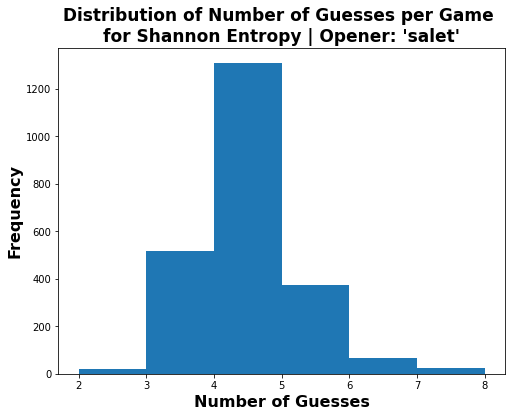

In [5]:
fig = plt.figure(figsize=(8,6))
plt.hist(num_guess_list, 6)
plt.title("Distribution of Number of Guesses per Game \nfor Shannon Entropy | Opener: 'salet'", 
          fontsize=17, fontweight="bold")
plt.xlabel("Number of Guesses", fontsize=16, fontweight="bold")
plt.ylabel("Frequency", fontsize=16, fontweight="bold")
plt.show()

In [6]:
guess_mean = np.mean(num_guess_list)
print("Mean number of guesses:", guess_mean)

Mean number of guesses: 4.011693373754873
